In [1]:
import scipy         
import datetime
from scipy.linalg import expm
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit


In [4]:
L = 5 #system size
M = -0.3 #fermion mass
N=4 #number of layers
l=1 #spin length
m_epsilon = 0
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [5]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
       0.         |2 2 2 2 2>           242  
       1.         |2 2 2 2 1>           241  
       2.         |2 2 2 2 0>           240  
       3.         |2 2 2 1 2>           239  
       4.         |2 2 2 1 1>           238  
       5.         |2 2 2 1 0>           237  
       6.         |2 2 2 0 2>           236  
       7.         |2 2 2 0 1>           235  
       8.         |2 2 2 0 0>           234  
       9.         |2 2 1 2 2>           233  
      10.         |2 2 1 2 1>           232  
      11.         |2 2 1 2 0>           231  
      12.         |2 2 1 1 2>           230  
      13.         |2 2 1 1 1>           229  
      14.         |2 2 1 1 0>           228  
      15.         |2 2 1 0 2>           227  
      16.         |2 2 1 0 1>           226  
      17.         |2 2 1 0 0>           225  
      18.         |2 2 0 2 2>           224  
      19.         |2 2 0 2 1>           223  
      20.  

In [6]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [7]:
B = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(4*l+1)
b[2*l+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(4*3+1)
for i in range(4*l+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.          0.          0.          0.          0.          0.
  0.        ]
[0. 0. 0. 1. 0.]


In [8]:
C = np.zeros((4*l+1,4*l+1))
for i in range(4*l+1):
    for j in range(4*l+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(4*l+1)
c[2*l] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(4*3+1)
for i in range(4*l+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.    0.    0.    0.    0.    0.
  0.  ]
[0. 0. 1. 0. 0.]


In [9]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(4*l+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [10]:
A = np.zeros((2*l+1,2*l+1))
for i in range(2*l+1):
    for j in range(2*l+1):
        A[i][j] = (-l+i)**j
b = np.zeros(2*l+1)
for i in range(2*l+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(2*3+1)
for i in range(2*l+1):
    x[i] = solution[i]
print(x)

[ 1.  0. -2.  0.  0.  0.  0.]


In [11]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []
quartic_term = []
quintic_term = []
sextic_term = []
interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])
    quartic_term.append([[(x[4])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1]])
    quintic_term.append([[(x[5])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1]])
    sextic_term.append([[(x[6])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1,i+1,i+1,i+1]])

    const_term

    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],
        ["+zzzz", quartic_term[i]],
        ["+zzzzz", quintic_term[i]],
        ["+zzzzzz", sextic_term[i]],

    ])

    interaction_m.append([
        ["-", const_term[i]],
        ["-z", linear_term[i]],
        ["-zz", quadratic_term[i]],
        ["-zzz", cubic_term[i]],
        ["-zzzz", quartic_term[i]],
        ["-zzzzz", quintic_term[i]],
        ["-zzzzzz", sextic_term[i]],

    ])

const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

G=0
for i in range(L+1):
    G += 0.15*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= full_ham_matrix + constraint_full_matrix #Spin-1 Hamiltonian with the local contstaints as a penalty term
#print(full_ham_matrix)

In [12]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])
print(eigenvec[:,0])

[-1.84068817 -1.29811607 -1.00113739]
[-1.01258403e-02-2.11107836e-02j  6.97805621e-19-1.64464882e-18j
  3.60953955e-18-2.41405135e-18j -3.78776111e-02-7.89688584e-02j
  3.21355074e-02+6.69974759e-02j  2.42913571e-17-1.42732163e-17j
 -2.88238279e-17-4.60402429e-17j  2.55343761e-18+8.79894826e-18j
  5.92464092e-18-3.49191522e-18j -6.24983275e-19-9.83773336e-18j
  6.63864730e-18-4.00653349e-18j -2.90695374e-18+5.41419122e-18j
  8.04952353e-18+6.60122820e-18j  1.76155429e-17-3.59520757e-18j
  3.24429403e-18-1.01471899e-17j -2.58428036e-17+2.38057732e-17j
  4.52469432e-18+5.42968197e-18j  1.60587318e-17-2.02609211e-18j
 -5.55688300e-20-4.57890966e-18j  1.76390178e-17-1.13464874e-17j
  3.16480356e-18+2.86374769e-17j  3.78186591e-17+3.15461325e-17j
  4.08570936e-17+3.92960552e-17j -5.27002120e-18+8.24796490e-18j
  1.25873302e-17+5.41158967e-18j -1.26077498e-17-6.58859220e-18j
 -2.59777611e-18+9.89226242e-18j -3.78776111e-02-7.89688584e-02j
  2.20668602e-17-6.44003388e-18j  3.90732076e-19+7.3

In [13]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian with the local contstaints
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")


In [14]:
#Gauge invariant part of the spectrum
string = ""
print(eigenvalues[eigenvalues<=1e1])
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)


[-1.84068817 -1.29811607 -0.98569887]
(0.0010422271449549209-0.02339041658982366j)|2 2 2 2 2>
(0.0038986467492330627-0.08749625457612471j)|2 2 2 1 2>
(-0.0033076265373232563+0.07423215083780409j)|2 2 2 1 1>
(0.003898646749233052-0.08749625457612464j)|2 1 2 2 2>
(0.016240366999538-0.36447808093431394j)|2 1 2 1 2>
(-0.014231699079073725+0.31939810035838895j)|2 1 2 1 1>
(-0.01378199089535841+0.3093054235250625j)|2 1 1 1 2>
(0.014491765890182275-0.3252347081290417j)|2 1 1 1 1>
(-0.006827466895815336+0.15322695798071195j)|2 1 1 0 1>
(-0.003307626537323243+0.07423215083780399j)|1 1 2 2 2>
(-0.014231699079073819+0.31939810035838906j)|1 1 2 1 2>
(0.012659801144776496-0.28412042821381583j)|1 1 2 1 1>
(0.014491765890182598-0.3252347081290417j)|1 1 1 1 2>
(-0.015610133959226679+0.35033393449475053j)|1 1 1 1 1>
(0.007911722413055773-0.17756060574726637j)|1 1 1 0 1>
(-0.006827466895815649+0.1532269579807116j)|1 0 1 1 2>
(0.00791172241305594-0.177560605747266j)|1 0 1 1 1>
(-0.005106082326699706+0.11

In [15]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [16]:
#cost function of the initial state
expt_value = 0
matvec_h = full_ham_matrix@psi_0
matvec_c = constraint_full_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*(matvec_h[i]+matvec_c[i])
print(np.real(expt_value))

0.0


In [17]:
expt_value = 0
matvec = full_ham_matrix@psi_0
for i in range(basis.Ns):
    expt_value += np.conj(psi_0[i])*matvec[i]
print(expt_value)

0j


In [18]:
def rot_sigma(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
        
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-1] = 0.5
    sigma[2*l-1][2*l-0] = 0.5
    sigma = sparse.csc_matrix(sigma)
    
    sigma_1 = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_1[2*l-1][2*l-2] = 0.5
    sigma_1[2*l-2][2*l-1] = 0.5
    sigma_1 = sparse.csc_matrix(sigma_1)
    
    rot_matrix = expm(-1j*theta*(sigma+sigma_1))
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_z(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-0] = -1.
    sigma[2*l-2][2*l-2] = 1.
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_z2(k,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-0][2*l-0] = 1.
    sigma[2*l-2][2*l-2] = 1.
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod

def rot_sigma_e(theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(0,int(L/2)+1):
        sigma_e = rot_sigma(2*k,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,theta)@sigma_o
    return(sigma_o)

def rot_sigma_e_z(theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(0,int(L/2)+1):
        sigma_e = rot_sigma_z(2*k,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o_z(theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_e = rot_sigma_z(2*k+1,theta)@sigma_o
    return(sigma_o)

def rot_sigma_e_z2(theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(0,int(L/2)+1):
        sigma_e = rot_sigma_z2(2*k,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o_z2(theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_e = rot_sigma_z2(2*k+1,theta)@sigma_o
    return(sigma_o)

In [19]:
def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    

In [20]:
#import timeit
#print(timeit.timeit('[ms_gate_global(0,2,np.pi)]', globals=globals()))
import datetime
print(datetime.datetime.now())
a = ms_gate_global(np.pi)
print(datetime.datetime.now())
print(np.size(a))


2022-05-10 14:00:04.517466
2022-05-10 14:00:04.525949
59049


In [21]:
Energy = np.zeros(5)
Fidelity = np.zeros(5)

In [28]:
import optuna
#for N in range(1,6):
theta = np.zeros(7*N)
#cost function definition
def cost_function_sigma(trial):
    psi_var = psi_0
    for i in range(N):
        for j in range(7):
            theta[7*i+j] = trial.suggest_float("7*"+str(i)+"+"+str(j), -2*np.pi, 2*np.pi)

    for i in range(N):
        psi_var = ms_gate_global(theta[7*i+0])@psi_var
        psi_var = rot_sigma_e_z2(theta[7*i+3])@rot_sigma_e_z(theta[7*i+2])@rot_sigma_e(theta[7*i+1])@psi_var
        psi_var = rot_sigma_o_z2(theta[7*i+6])@rot_sigma_o_z(theta[7*i+5])@rot_sigma_o(theta[7*i+4])@psi_var


    cost = np.conj(psi_var)@constrained_full_ham_matrix@psi_var
    return np.real(cost)

if __name__ == "__main__":
    sampler = optuna.samplers.CmaEsSampler(n_startup_trials = 100, restart_strategy = 'ipop', inc_popsize = 3.3)
    study = optuna.create_study(sampler=sampler, study_name = "M=0.1, L=5, n_trials=3000, N=".join(str(N)))
    study.optimize(cost_function_sigma, n_trials=6000)


/home/ppopov/anaconda3/lib/python3.8/site-packages/optuna/samplers/_cmaes.py:221: ExperimentalWarning: `restart_strategy` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2022-05-10 15:32:48,445] A new study created in memory with name: 4
/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:32:49,132] Trial 0 finished with value: 4.760929542690688 and parameters: {'7*0+0': 2.4269331201489504, '7*0+1': -5.9934326783171885, '7*0+2': 1.8092802696118468, '7*0+3': -1.983974111104751, '7*0+4': -2.1116266741797753, '7*0+5': -6.096449218422402, '7*0+6': -4.790011953996536, '7*1+0': 5.265540017530684, '7*1+1': -1.5337234002981024, '7*1+2': 5.815210333929375, '7*1+3': -2.2603194036892393, '7*1+4': -5.502840562047983, '7*1+5': 1.0608243359131855, '7*1+6':

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:32:53,556] Trial 7 finished with value: 4.160263797891584 and parameters: {'7*0+0': 0.16942784883651552, '7*0+1': 3.1618725103200074, '7*0+2': 3.958103091259261, '7*0+3': 0.5960693715336678, '7*0+4': -2.8983909611567347, '7*0+5': -1.0078713036871045, '7*0+6': 2.015511918794557, '7*1+0': 3.0016944138109274, '7*1+1': -4.716598126295866, '7*1+2': 1.0544423104580432, '7*1+3': 2.1607470071206727, '7*1+4': -5.020097714375664, '7*1+5': 1.2899291426559003, '7*1+6': -4.525153270237593, '7*2+0': 5.778393363443213, '7*2+1': -1.1161543832837335, '7*2+2': 5.5399168871572115, '7*2+3': 1.0256263623546298, '7*2+4': -2.2102132513005692, '7*2+5': 3.006269196856259, '7*2+6': -3.6445932334818294, '7*3+0': -4.438785924531348, '7*3+1': 0.6433473236253899, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:32:58,049] Trial 14 finished with value: 4.006042864335662 and parameters: {'7*0+0': -5.987472594517061, '7*0+1': -0.5704175914659517, '7*0+2': 6.091430143398341, '7*0+3': -1.1191124968164585, '7*0+4': -4.262075615482465, '7*0+5': -6.087117512848986, '7*0+6': 0.7383250097090901, '7*1+0': 4.461126222747486, '7*1+1': 2.680541093487479, '7*1+2': -6.130590908976392, '7*1+3': 4.476339196170054, '7*1+4': -3.014202343293352, '7*1+5': -2.4984231252892846, '7*1+6': -2.001829931934389, '7*2+0': -0.9396943592906633, '7*2+1': -1.4346228423275376, '7*2+2': -5.1106495803977925, '7*2+3': 1.902672092980854, '7*2+4': -5.132343100669205, '7*2+5': -2.629548703663278, '7*2+6': 2.744484890490904, '7*3+0': 1.9294815494322197, '7*3+1': 4.075021427091096, '7*3+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:02,334] Trial 21 finished with value: 4.932517555430631 and parameters: {'7*0+0': 0.5862575672690635, '7*0+1': -0.7179012051383609, '7*0+2': -4.650737542320989, '7*0+3': -0.9677214919296242, '7*0+4': 3.4355538033369335, '7*0+5': -5.732428404951075, '7*0+6': -2.399372659094371, '7*1+0': 0.8309417690419609, '7*1+1': -3.1124350362013384, '7*1+2': 1.2653000396530345, '7*1+3': 1.1676844611690536, '7*1+4': 3.3043198544325314, '7*1+5': 2.0670138392588573, '7*1+6': 5.53933824465545, '7*2+0': -3.1942409618803866, '7*2+1': -0.9599258936395652, '7*2+2': -4.376957971163116, '7*2+3': -0.9834801047315223, '7*2+4': 3.437531536914573, '7*2+5': 1.1139402806714607, '7*2+6': 3.6063074301870657, '7*3+0': -1.0210857781865021, '7*3+1': -1.1495068846138397,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:07,239] Trial 28 finished with value: 5.013429777821496 and parameters: {'7*0+0': -4.441137670682149, '7*0+1': -5.12770604748905, '7*0+2': 4.7724145242722535, '7*0+3': 0.3352901894150371, '7*0+4': 2.9527908365399558, '7*0+5': -5.272861660005033, '7*0+6': 1.7517656757407405, '7*1+0': -0.38293050351868896, '7*1+1': 1.8470711304363014, '7*1+2': -0.31395498608131067, '7*1+3': 5.369868974149503, '7*1+4': -0.8466916166800935, '7*1+5': -5.397845508117734, '7*1+6': -0.5351521174942517, '7*2+0': 5.366919257837699, '7*2+1': -2.5492174233270903, '7*2+2': 0.7101397772020706, '7*2+3': -5.650531514329756, '7*2+4': 2.6021425542771617, '7*2+5': -5.102530517170595, '7*2+6': -6.250542900599128, '7*3+0': 4.037503535897335, '7*3+1': -5.171837074631494, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:11,417] Trial 35 finished with value: 5.3898044037482435 and parameters: {'7*0+0': -5.930781708064327, '7*0+1': 2.1364827368242754, '7*0+2': 3.7227903882519087, '7*0+3': -1.852145754729067, '7*0+4': -5.959523768821242, '7*0+5': -2.4790135140169665, '7*0+6': -4.4991212587403915, '7*1+0': 0.0879149857168251, '7*1+1': -3.348787155669515, '7*1+2': -5.017903003746695, '7*1+3': -0.2673495466157352, '7*1+4': -4.44769464073982, '7*1+5': -6.111805401062444, '7*1+6': -0.016013915497890885, '7*2+0': 5.4062022517421475, '7*2+1': 5.288832307770511, '7*2+2': -5.418080146304996, '7*2+3': -0.9245711169918094, '7*2+4': -2.5831447855208243, '7*2+5': -4.077300263372464, '7*2+6': -2.9844028236769606, '7*3+0': -3.932643435172632, '7*3+1': -3.5988687210676

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:15,706] Trial 42 finished with value: 4.601562005462785 and parameters: {'7*0+0': 5.88872318397522, '7*0+1': 4.601367960216985, '7*0+2': -2.7142078256558255, '7*0+3': -4.542782848678455, '7*0+4': -0.932127370057926, '7*0+5': 2.67887245763208, '7*0+6': -2.4959167306384296, '7*1+0': 1.0691934381071473, '7*1+1': -0.07880701754034725, '7*1+2': 5.608434404750213, '7*1+3': -1.0737572888702562, '7*1+4': -2.9313586388029007, '7*1+5': 1.2289483963956744, '7*1+6': -5.103038174129441, '7*2+0': -5.423168854922054, '7*2+1': 0.7798111556816059, '7*2+2': 1.2608663917624936, '7*2+3': 4.40415459503434, '7*2+4': -2.551405926863837, '7*2+5': 4.9463576389212545, '7*2+6': -0.5328992012548106, '7*3+0': -2.0644830478054583, '7*3+1': 4.961578824579664, '7*3+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:19,858] Trial 49 finished with value: 5.673042280718292 and parameters: {'7*0+0': -1.3066431080221337, '7*0+1': 5.950341011081759, '7*0+2': -4.762966651038073, '7*0+3': 3.488717072708001, '7*0+4': 4.3348826409965255, '7*0+5': 5.698623313518487, '7*0+6': -0.5434136179819449, '7*1+0': 5.426741224580246, '7*1+1': 1.739033638483365, '7*1+2': 6.018782743747172, '7*1+3': 0.659613981558409, '7*1+4': 3.867336967107331, '7*1+5': -5.271372305256944, '7*1+6': -2.720703106623526, '7*2+0': 5.797067782086039, '7*2+1': 5.158994410136286, '7*2+2': 2.0634829298426087, '7*2+3': 1.1296053590056818, '7*2+4': 2.2413006192548313, '7*2+5': 2.2290708185986556, '7*2+6': 2.131507552097279, '7*3+0': 1.5427246965171282, '7*3+1': -0.18846085666207202, '7*3+2': -0

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:24,035] Trial 56 finished with value: 5.855213456329676 and parameters: {'7*0+0': -5.826430688702733, '7*0+1': 1.8308404104049387, '7*0+2': -1.5735384810251736, '7*0+3': 1.3316539859773302, '7*0+4': -6.1336020745388895, '7*0+5': 5.141757877090088, '7*0+6': -5.323172831663841, '7*1+0': -4.400793474228388, '7*1+1': 2.280306764153819, '7*1+2': 2.5085208174217755, '7*1+3': -5.832777814385592, '7*1+4': 0.35615067323180316, '7*1+5': -3.91967429306492, '7*1+6': 0.9390358810376336, '7*2+0': 3.6543743466303766, '7*2+1': 1.0662407261859688, '7*2+2': 0.5118655181549139, '7*2+3': -5.287242444383195, '7*2+4': -0.3184896249353031, '7*2+5': 5.293578234634355, '7*2+6': 2.618096196185501, '7*3+0': -4.143092309367834, '7*3+1': 2.072828772827039, '7*3+2

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:28,062] Trial 63 finished with value: 5.640163381923328 and parameters: {'7*0+0': 1.1066515014130207, '7*0+1': -1.951031525728741, '7*0+2': -5.526479100356633, '7*0+3': 2.1052925509800318, '7*0+4': -2.727201806294865, '7*0+5': -4.533265042750603, '7*0+6': 4.465000333947016, '7*1+0': -5.157082587049869, '7*1+1': -1.412605365502924, '7*1+2': -1.677058345109728, '7*1+3': 1.5903807747016634, '7*1+4': -5.586734319560305, '7*1+5': -1.7071351189615385, '7*1+6': 4.790978892834042, '7*2+0': -6.13885180772422, '7*2+1': -1.1778575451803572, '7*2+2': 0.5737104385289093, '7*2+3': 5.878309071087697, '7*2+4': -0.5377419934260947, '7*2+5': -5.445578052494648, '7*2+6': 4.857338341960565, '7*3+0': 4.361825826664981, '7*3+1': -1.192925261016467, '7*3+2'

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:32,769] Trial 70 finished with value: 4.110625183433552 and parameters: {'7*0+0': -1.8613485328322206, '7*0+1': 3.6004700388893287, '7*0+2': 4.403734225349293, '7*0+3': 5.48643679992748, '7*0+4': -1.8355583941130131, '7*0+5': 3.7366299415192046, '7*0+6': 2.408090897170405, '7*1+0': 0.6326912358412304, '7*1+1': -6.025278918209688, '7*1+2': -4.362487052461381, '7*1+3': 3.525551388172893, '7*1+4': 5.314998753161698, '7*1+5': 5.340170177387085, '7*1+6': 1.2488795250956404, '7*2+0': 3.615420940047839, '7*2+1': 5.47359558024784, '7*2+2': -2.265788639443141, '7*2+3': 3.7959429360809427, '7*2+4': 5.989323145854021, '7*2+5': 0.06362204305556673, '7*2+6': 3.0785514386589234, '7*3+0': 2.3178784256006093, '7*3+1': 5.519224660347868, '7*3+2': 2.01

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:37,038] Trial 77 finished with value: 4.576767903240189 and parameters: {'7*0+0': -5.423325343767316, '7*0+1': 2.8987578811108126, '7*0+2': 5.902833642039225, '7*0+3': 3.7271087738720627, '7*0+4': 0.42753005241362274, '7*0+5': -0.7669616264578609, '7*0+6': -3.0367705643983096, '7*1+0': 2.8677062803061677, '7*1+1': 1.069369674001491, '7*1+2': -3.6274218788254435, '7*1+3': -0.9003737883141865, '7*1+4': -3.375515445900587, '7*1+5': 4.9319807065715136, '7*1+6': 2.677156636329677, '7*2+0': -4.561475748901216, '7*2+1': -4.851292316298084, '7*2+2': 3.9184929527091157, '7*2+3': 5.703310948479052, '7*2+4': 1.7257432199585399, '7*2+5': -3.505638952166363, '7*2+6': 5.684608481371619, '7*3+0': 3.3353414674076056, '7*3+1': -1.4793545362334735, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:41,247] Trial 84 finished with value: 4.655260937773384 and parameters: {'7*0+0': 4.301284255985882, '7*0+1': -2.666578629899042, '7*0+2': 3.229339050711351, '7*0+3': 4.10304295276228, '7*0+4': -1.0276172279333622, '7*0+5': -2.69334881581784, '7*0+6': 4.812688697725298, '7*1+0': -2.9831613630295766, '7*1+1': -2.8711449771298256, '7*1+2': 2.9798104151595357, '7*1+3': -2.1681932046130834, '7*1+4': 2.700415238574827, '7*1+5': 3.6161847374159475, '7*1+6': 0.15774257305924877, '7*2+0': 1.0642183071369393, '7*2+1': 4.850732894579227, '7*2+2': -1.7732036635831756, '7*2+3': 1.3327334871823524, '7*2+4': 4.513905130920477, '7*2+5': -0.9304943362631084, '7*2+6': 5.108177110713358, '7*3+0': 2.60049779175762, '7*3+1': 0.8784009584300998, '7*3+2': 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:45,430] Trial 91 finished with value: 5.816574366199742 and parameters: {'7*0+0': -6.177743742199903, '7*0+1': 3.907915322769499, '7*0+2': 0.0009247138302326263, '7*0+3': -2.8700987788372276, '7*0+4': 1.983022888722461, '7*0+5': 3.8954530362280035, '7*0+6': -1.521905555544767, '7*1+0': 0.936578408581723, '7*1+1': -5.207192799995106, '7*1+2': 2.81960399221256, '7*1+3': -0.04669264875213219, '7*1+4': -4.52014794341552, '7*1+5': 3.3261047011956233, '7*1+6': 5.546064202401331, '7*2+0': -5.57325510503533, '7*2+1': -2.3454616695623254, '7*2+2': -4.732776587235559, '7*2+3': -0.09971898307458193, '7*2+4': 5.6157312339298, '7*2+5': -1.646992801741061, '7*2+6': 2.278614928994095, '7*3+0': -3.433738894821065, '7*3+1': 2.0371478889393053, '7*3+2'

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:49,851] Trial 98 finished with value: 3.716643174185519 and parameters: {'7*0+0': -0.3905237607042791, '7*0+1': 3.108366582871364, '7*0+2': 2.909580103257859, '7*0+3': 1.979772219304266, '7*0+4': -4.265130419909461, '7*0+5': 2.4307665130046896, '7*0+6': -5.7286796778967455, '7*1+0': 5.621520861568284, '7*1+1': 0.58228907248236, '7*1+2': -3.117335690271408, '7*1+3': -4.6485362792024745, '7*1+4': -5.928611843779232, '7*1+5': 2.030701282655711, '7*1+6': -3.362007805612346, '7*2+0': 0.5985716488180568, '7*2+1': 1.4691628146914635, '7*2+2': 5.345164233493421, '7*2+3': 3.8708603011298646, '7*2+4': -4.0700305685693134, '7*2+5': -3.499051621463353, '7*2+6': -1.6629497565508649, '7*3+0': 6.1717213774159525, '7*3+1': -2.436927561872386, '7*3+2'

[I 2022-05-10 15:33:54,374] Trial 106 finished with value: 5.618961930546419 and parameters: {'7*0+0': 1.7180023494589225, '7*0+1': -4.017027278403414, '7*0+2': -0.3679806963588035, '7*0+3': -2.256147856400587, '7*0+4': -1.8789044652968012, '7*0+5': 0.668323477096217, '7*0+6': -0.210066446075969, '7*1+0': -3.399281141040104, '7*1+1': -1.8734058466213752, '7*1+2': -1.3030028003972571, '7*1+3': 2.4832132808204035, '7*1+4': -0.11598771972953636, '7*1+5': 0.962997811006474, '7*1+6': 2.067823686356912, '7*2+0': -4.273451746412074, '7*2+1': -1.9108940387560185, '7*2+2': -0.48372440325174465, '7*2+3': -1.6907199572091245, '7*2+4': -0.9478248021964084, '7*2+5': 0.3663459479524993, '7*2+6': 0.7712516509112485, '7*3+0': 0.96243787410825, '7*3+1': -0.85063939717335, '7*3+2': -2.910962091765614, '7*3+3': -0.8724213103673428, '7*3+4': -4.629689697401439, '7*3+5': -2.397837232117404, '7*3+6': 1.6335154230654818}. Best is trial 87 with value: 2.0228792586828908.
/home/ppopov/anaconda3/lib/python3.8/s

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:33:58,530] Trial 114 finished with value: 4.546382490006551 and parameters: {'7*0+0': -0.2602440151741061, '7*0+1': 0.30089024152590094, '7*0+2': -2.517533702765901, '7*0+3': -1.2846390889605235, '7*0+4': 3.423612146285251, '7*0+5': 1.7675875284128926, '7*0+6': -1.0666414382841785, '7*1+0': 0.44272761509041825, '7*1+1': -1.258110714241172, '7*1+2': -1.944712423616707, '7*1+3': -1.1996762429923327, '7*1+4': 1.6372921528099744, '7*1+5': -2.3188500145301134, '7*1+6': -0.6626807899500311, '7*2+0': 3.6362538725709674, '7*2+1': -1.8960323657875702, '7*2+2': 4.9313968151359875, '7*2+3': 0.050437779339499, '7*2+4': 4.304290237485905, '7*2+5': 1.1470525432374998, '7*2+6': -0.8667445585184144, '7*3+0': 1.7369732430533413, '7*3+1': -0.6669494553237

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:02,632] Trial 122 finished with value: 4.492498004311264 and parameters: {'7*0+0': -0.6412744040325218, '7*0+1': 1.7871993592025375, '7*0+2': -4.0280377809538646, '7*0+3': -0.6026571813455861, '7*0+4': 2.2707169297897054, '7*0+5': -0.9343454431669518, '7*0+6': 0.13650211798811063, '7*1+0': -2.1754091634390855, '7*1+1': -1.0019059391233502, '7*1+2': 1.6905910095885865, '7*1+3': -1.2723148927303078, '7*1+4': -0.0557986659778148, '7*1+5': 0.3569539729869011, '7*1+6': 2.7265100668194204, '7*2+0': 2.1456925869544285, '7*2+1': -2.603452986719761, '7*2+2': 2.0336364430608254, '7*2+3': 1.613148949806005, '7*2+4': 2.1370430930345377, '7*2+5': -1.2639309467278055, '7*2+6': -2.2686248864991927, '7*3+0': -0.16477373801110384, '7*3+1': -0.15789128

[I 2022-05-10 15:34:06,478] Trial 129 finished with value: 5.1100566297531 and parameters: {'7*0+0': -2.4157539651832063, '7*0+1': 2.211151543132191, '7*0+2': -0.085829603241655, '7*0+3': -0.5995440358777722, '7*0+4': 0.5583829643459837, '7*0+5': 0.25514542917941085, '7*0+6': -0.8338137879121629, '7*1+0': 1.9627664976564327, '7*1+1': -1.0002479602644998, '7*1+2': 0.8478321401494466, '7*1+3': -1.1389792045173694, '7*1+4': 1.1968112939298399, '7*1+5': 1.616930723256064, '7*1+6': 1.4989577969114967, '7*2+0': -2.499786677775089, '7*2+1': 2.254884541388265, '7*2+2': 1.1530124786689147, '7*2+3': -2.862367359444238, '7*2+4': -5.471751868926032, '7*2+5': -1.997614608562798, '7*2+6': -2.387796372555452, '7*3+0': 1.8296522729966136, '7*3+1': 1.4494270524692727, '7*3+2': 0.048593062039408524, '7*3+3': -2.011225732284578, '7*3+4': 1.0775636943840152, '7*3+5': -2.825003461011569, '7*3+6': -0.41807860979487277}. Best is trial 87 with value: 2.0228792586828908.
/home/ppopov/anaconda3/lib/python3.8/si

[I 2022-05-10 15:34:10,136] Trial 136 finished with value: 4.827812116891054 and parameters: {'7*0+0': -1.4441341553284965, '7*0+1': -1.7432395022357734, '7*0+2': 1.0681020075366825, '7*0+3': -1.9509445646664525, '7*0+4': 4.100934719878152, '7*0+5': -2.3852606099804103, '7*0+6': -2.644579836834321, '7*1+0': 0.8367680931036938, '7*1+1': -1.4030712554353257, '7*1+2': 0.9759094817600455, '7*1+3': -2.7645459225702864, '7*1+4': 0.9032055270707405, '7*1+5': -0.7046904708930087, '7*1+6': 0.2054872492366342, '7*2+0': 0.34100995964684183, '7*2+1': 2.534684506449756, '7*2+2': 5.439586570365538, '7*2+3': -0.3589002109524712, '7*2+4': -1.3042088792678337, '7*2+5': 0.3087494873184553, '7*2+6': -1.3090932829157302, '7*3+0': 0.6479460362907254, '7*3+1': 2.537481465129413, '7*3+2': 1.4458612264685322, '7*3+3': 0.8250162523374075, '7*3+4': -0.003960818874132882, '7*3+5': -0.06954576142285407, '7*3+6': -1.7279833323581766}. Best is trial 87 with value: 2.0228792586828908.
/home/ppopov/anaconda3/lib/pyth

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:14,246] Trial 144 finished with value: 5.107938319936581 and parameters: {'7*0+0': -5.101925429501835, '7*0+1': -1.3429937196533377, '7*0+2': 2.656935021957567, '7*0+3': -3.153246060311404, '7*0+4': 3.991457736964109, '7*0+5': -3.1612948917887884, '7*0+6': 1.365368404164152, '7*1+0': -0.35770899258655164, '7*1+1': -2.112936436937294, '7*1+2': 4.258393541544221, '7*1+3': -2.3149998771473186, '7*1+4': 1.6933887608977516, '7*1+5': -4.895531695403346, '7*1+6': 0.06141155825706335, '7*2+0': -1.76870506872722, '7*2+1': -0.2515792281127718, '7*2+2': -0.017762555938908964, '7*2+3': 0.6059318911057054, '7*2+4': -1.3423451574367362, '7*2+5': -5.934675045465789, '7*2+6': -2.3399418148874247, '7*3+0': 5.144456098858886, '7*3+1': 1.865210362971917

[I 2022-05-10 15:34:17,876] Trial 151 finished with value: 3.251669742260446 and parameters: {'7*0+0': -4.2040756374758725, '7*0+1': -1.1648772606806514, '7*0+2': 0.8281083488794959, '7*0+3': -0.49734794544445093, '7*0+4': 2.9253730335474417, '7*0+5': 0.7750299617786092, '7*0+6': 1.1425267244141541, '7*1+0': 2.966027278886523, '7*1+1': -5.113513811532748, '7*1+2': 3.5435631057719243, '7*1+3': 3.246390839877034, '7*1+4': 1.9656302838524558, '7*1+5': -0.9179553347377893, '7*1+6': -1.7924798538999718, '7*2+0': -0.6853624068306835, '7*2+1': -3.6026119703852837, '7*2+2': 3.505812971274886, '7*2+3': 0.6065059556417602, '7*2+4': -1.450094529732086, '7*2+5': -3.8143057830019327, '7*2+6': -1.707900135593832, '7*3+0': -2.31640816336711, '7*3+1': -1.0771156274462452, '7*3+2': 0.7655334242911088, '7*3+3': -2.7758467315406876, '7*3+4': 2.7373982917145048, '7*3+5': -3.2687801857743315, '7*3+6': -2.574361710848812}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:22,040] Trial 159 finished with value: 3.573094238200611 and parameters: {'7*0+0': -4.199325562031255, '7*0+1': -2.47173974040928, '7*0+2': 0.060097215465654386, '7*0+3': -5.23271197704081, '7*0+4': 2.5473479670938377, '7*0+5': 0.27349302993949753, '7*0+6': 1.7924151685068836, '7*1+0': 0.5726937108021913, '7*1+1': -4.635038509702364, '7*1+2': 3.7371189212230425, '7*1+3': -2.795377040261352, '7*1+4': 2.671303093179225, '7*1+5': -2.77009543513186, '7*1+6': -0.20641356002014566, '7*2+0': 0.5873682846134349, '7*2+1': -1.1573278878853812, '7*2+2': 1.6168128436622387, '7*2+3': -2.787091965967154, '7*2+4': -0.9709407361239912, '7*2+5': -4.303056598431822, '7*2+6': 0.07100423090033836, '7*3+0': -1.1317530065323194, '7*3+1': 0.5014882169440038

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:25,769] Trial 166 finished with value: 5.056498081133812 and parameters: {'7*0+0': -2.688736953000152, '7*0+1': -0.5285093813478878, '7*0+2': 0.3754962584759457, '7*0+3': -3.6138497465304456, '7*0+4': 1.5019248249616424, '7*0+5': -1.6948298956735703, '7*0+6': -1.6914720497778857, '7*1+0': 2.264817865842279, '7*1+1': -5.005697731779579, '7*1+2': -0.2651710563366927, '7*1+3': -5.129089317533944, '7*1+4': 3.258373075710992, '7*1+5': -2.3176386565007463, '7*1+6': 2.729781952457901, '7*2+0': 1.8619826351433653, '7*2+1': -3.0398476742964866, '7*2+2': 2.701834845773086, '7*2+3': -3.9834534494369462, '7*2+4': -3.021508593577038, '7*2+5': -1.8096799034194178, '7*2+6': -1.439602847229109, '7*3+0': 1.0031108288701691, '7*3+1': 2.1109671954550966

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:29,663] Trial 173 finished with value: 6.58614897916525 and parameters: {'7*0+0': -1.7827270028996773, '7*0+1': -0.21787309597109594, '7*0+2': -2.254686514617834, '7*0+3': -5.161644895776203, '7*0+4': 3.433658814256362, '7*0+5': -2.810742869844348, '7*0+6': 0.3576571953581391, '7*1+0': 0.9703876067199896, '7*1+1': -2.353554101489669, '7*1+2': 3.131981679550133, '7*1+3': -1.7738652547722855, '7*1+4': -1.700239785357463, '7*1+5': -0.6415808244896684, '7*1+6': 0.805454055186658, '7*2+0': 3.028048850009174, '7*2+1': 1.065363846592561, '7*2+2': 2.3645405597942855, '7*2+3': -2.273039562576677, '7*2+4': -4.206053931643684, '7*2+5': -2.4290998014137988, '7*2+6': -2.582560371061445, '7*3+0': 2.4171545434749113, '7*3+1': -0.37156817207276305, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:33,554] Trial 180 finished with value: 4.043528824977681 and parameters: {'7*0+0': -2.1293171809222424, '7*0+1': -1.2740668441769276, '7*0+2': 5.199418899438541, '7*0+3': -3.453249425360392, '7*0+4': 3.5658749641322776, '7*0+5': -2.422397719605931, '7*0+6': 1.2764739371789027, '7*1+0': 2.0140109151507666, '7*1+1': -4.077734720614415, '7*1+2': 2.146229990593473, '7*1+3': 1.519688332948315, '7*1+4': 1.7405478381805737, '7*1+5': 0.2915331422874017, '7*1+6': 4.704683443513019, '7*2+0': 2.3893791690923805, '7*2+1': -5.422062662712963, '7*2+2': 1.8389443690976635, '7*2+3': -0.9982001576808831, '7*2+4': -2.217307814195525, '7*2+5': -3.009265262528983, '7*2+6': -4.042695407297683, '7*3+0': 0.28661730239104455, '7*3+1': -1.1384195957455518, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:37,583] Trial 187 finished with value: 3.6979639028614466 and parameters: {'7*0+0': -3.5058702871210454, '7*0+1': -2.8773791144661613, '7*0+2': 3.045074071252251, '7*0+3': -4.0829723749545686, '7*0+4': 2.851924147714907, '7*0+5': -2.372887660387067, '7*0+6': -1.6699159992340555, '7*1+0': 2.272331024950071, '7*1+1': -3.1725276322045524, '7*1+2': 5.076074296209601, '7*1+3': 0.053568692639445636, '7*1+4': 2.602847766856383, '7*1+5': -3.671293910324597, '7*1+6': 0.18919380842617262, '7*2+0': 1.48205659620252, '7*2+1': -2.373416603393675, '7*2+2': 1.7081886635721522, '7*2+3': -1.0619719245627255, '7*2+4': -3.4218337142475885, '7*2+5': -2.486199240577584, '7*2+6': 0.17180378243273964, '7*3+0': -0.4404290161044371, '7*3+1': -3.19146057631036

[I 2022-05-10 15:34:41,439] Trial 194 finished with value: 4.587200692013056 and parameters: {'7*0+0': -2.423811707283403, '7*0+1': -3.558686967612293, '7*0+2': 2.6686668188496645, '7*0+3': -3.6071682410763617, '7*0+4': 2.7655080781115267, '7*0+5': 0.5961004860791315, '7*0+6': 0.22343281120923497, '7*1+0': 1.4915317098076342, '7*1+1': -5.457989932635138, '7*1+2': 1.6670595682006062, '7*1+3': 1.2421424376783365, '7*1+4': 1.4462044893533905, '7*1+5': -3.3476110878504466, '7*1+6': 0.5749674163415901, '7*2+0': 2.969564053710839, '7*2+1': -4.561353245063328, '7*2+2': 0.7932840882684031, '7*2+3': -1.0510917391175847, '7*2+4': -0.9147901273900783, '7*2+5': -2.925040877743947, '7*2+6': -2.564611162739421, '7*3+0': 0.9887280826775688, '7*3+1': -0.5235998554493435, '7*3+2': 1.2434894137481376, '7*3+3': -4.244359864339226, '7*3+4': 4.74509387099164, '7*3+5': -3.165416829399589, '7*3+6': 1.542353044210767}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3.8/site-

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:45,517] Trial 201 finished with value: 6.647841234193959 and parameters: {'7*0+0': -3.8217817732708737, '7*0+1': -2.8294233409755787, '7*0+2': 4.925988262495602, '7*0+3': -4.470157428001715, '7*0+4': 2.6214553780074934, '7*0+5': -1.9754735310111822, '7*0+6': -2.0891420467622783, '7*1+0': 1.633941970229294, '7*1+1': -4.039640752754779, '7*1+2': 3.37114369775439, '7*1+3': -1.9684412843760233, '7*1+4': 2.5881880888023145, '7*1+5': -1.2841410654385108, '7*1+6': 0.5275170539612815, '7*2+0': 4.6072125570086016, '7*2+1': -2.422939227181116, '7*2+2': 3.417496591315901, '7*2+3': -2.368638385481474, '7*2+4': -3.1317506232763432, '7*2+5': -2.7768304296066773, '7*2+6': -2.8429831409793564, '7*3+0': 2.5227268315543627, '7*3+1': 0.34978947340571587

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:49,267] Trial 208 finished with value: 4.752385108135748 and parameters: {'7*0+0': -1.609919941769233, '7*0+1': -0.7650960236981919, '7*0+2': 5.920987559263243, '7*0+3': -3.244068738311154, '7*0+4': 5.6027466288444945, '7*0+5': 1.5313387098876503, '7*0+6': -0.42596487586361476, '7*1+0': 1.9279362921025247, '7*1+1': -3.012243532742614, '7*1+2': 1.028874332566832, '7*1+3': 2.866066252621962, '7*1+4': 2.2749222956366024, '7*1+5': -1.584619820903851, '7*1+6': -0.002852196681857322, '7*2+0': -2.8381370687400294, '7*2+1': -2.327963629453992, '7*2+2': 2.5833466629892774, '7*2+3': -2.99009180393241, '7*2+4': -1.377934022689415, '7*2+5': -4.722315452919714, '7*2+6': -5.924604160853484, '7*3+0': 2.961787539425972, '7*3+1': -0.6866296867458255, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:53,166] Trial 215 finished with value: 6.668226448918581 and parameters: {'7*0+0': -5.209992719718596, '7*0+1': 0.8623391982400284, '7*0+2': 0.4735125517943639, '7*0+3': -6.146464891442394, '7*0+4': 1.4985135960550329, '7*0+5': 1.0301881049448793, '7*0+6': 0.6118521316100389, '7*1+0': -0.622544375689952, '7*1+1': -3.640893474970193, '7*1+2': 4.226666935477314, '7*1+3': -1.5031493669192637, '7*1+4': 0.4369494639564341, '7*1+5': -2.085928377512268, '7*1+6': 2.5156955502648346, '7*2+0': 2.3117240536010737, '7*2+1': -3.813615983779506, '7*2+2': 5.030976930905155, '7*2+3': 0.6215720667566771, '7*2+4': -3.406702581042553, '7*2+5': -5.782589614569444, '7*2+6': -5.510891437754494, '7*3+0': 2.2116102021015274, '7*3+1': -4.782640916787411, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:34:57,021] Trial 222 finished with value: 5.3012506995125115 and parameters: {'7*0+0': -2.1937919496269584, '7*0+1': 1.099550064310733, '7*0+2': 4.8189576008996795, '7*0+3': -4.359721983744371, '7*0+4': 3.782573650040896, '7*0+5': 1.9910604105214769, '7*0+6': -2.8833966088019314, '7*1+0': 2.355493966478882, '7*1+1': -4.385731148312663, '7*1+2': 1.1410526119093503, '7*1+3': 0.877369794659243, '7*1+4': 0.4418133368609668, '7*1+5': -2.83443060312169, '7*1+6': 2.2250910997721265, '7*2+0': 1.334831857265858, '7*2+1': -3.2908787291288153, '7*2+2': 2.4351414375608873, '7*2+3': 0.45784908798100155, '7*2+4': 0.6708854720126523, '7*2+5': -2.3143757561102842, '7*2+6': -4.780055949057408, '7*3+0': 0.034605393901488535, '7*3+1': -1.8847078680944807, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:01,263] Trial 230 finished with value: 4.05713946790959 and parameters: {'7*0+0': -4.699538405448797, '7*0+1': -4.07354926151064, '7*0+2': 1.8162656479423267, '7*0+3': -4.594128915020946, '7*0+4': 3.967963940845029, '7*0+5': 1.2945187340556221, '7*0+6': 1.084657253570189, '7*1+0': 3.160331031903368, '7*1+1': -1.3085416299808388, '7*1+2': 0.8989022039582386, '7*1+3': 1.646562290844534, '7*1+4': -0.17321323032939012, '7*1+5': -2.9051352143829874, '7*1+6': 1.3088845257129522, '7*2+0': 1.0924155397724589, '7*2+1': -2.1678011377398585, '7*2+2': 1.0978326430189445, '7*2+3': -5.267400490611244, '7*2+4': -0.40879733633106285, '7*2+5': -3.3714036795835565, '7*2+6': -4.557911375598861, '7*3+0': -0.3758979057442673, '7*3+1': -1.3612204409262603,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:04,974] Trial 237 finished with value: 5.62938655860717 and parameters: {'7*0+0': -0.6919642991895851, '7*0+1': -3.946136256196378, '7*0+2': 2.4616141034286083, '7*0+3': -1.2241795584606339, '7*0+4': 2.137678638117232, '7*0+5': 3.5502553153689203, '7*0+6': -1.1075250738495546, '7*1+0': 2.0709534391554847, '7*1+1': -0.929789765573265, '7*1+2': 0.3821730155121511, '7*1+3': -1.7880155523149361, '7*1+4': 0.08613850351041502, '7*1+5': -0.6111255029420393, '7*1+6': -0.21374751283115268, '7*2+0': -2.190210038686498, '7*2+1': -2.5230093501245836, '7*2+2': -0.5676278775159576, '7*2+3': -0.20800708083301966, '7*2+4': -2.4139047090510553, '7*2+5': -2.5375503045729033, '7*2+6': -2.183604677571779, '7*3+0': 5.33162831947538, '7*3+1': 1.83623547991

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:08,669] Trial 244 finished with value: 4.086909158067453 and parameters: {'7*0+0': -3.0634504566768666, '7*0+1': -2.5075046597401136, '7*0+2': 0.6169484426482754, '7*0+3': -4.312347638081093, '7*0+4': 1.0342684047486503, '7*0+5': 3.177088351997169, '7*0+6': 0.30585220284703185, '7*1+0': -0.4091376176688244, '7*1+1': -1.6197629755956626, '7*1+2': 0.17003231022566534, '7*1+3': 0.9052045806893992, '7*1+4': 0.27462017066689454, '7*1+5': -4.760818752547568, '7*1+6': 1.7970116999081691, '7*2+0': -5.089345581973275, '7*2+1': -1.384532201612477, '7*2+2': 0.4233327083513392, '7*2+3': -5.930813585970195, '7*2+4': 0.6107904955260846, '7*2+5': -2.95719085493687, '7*2+6': -3.378835182351626, '7*3+0': 1.5569985622629428, '7*3+1': 0.8875800287813242

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:12,398] Trial 251 finished with value: 6.987796826668877 and parameters: {'7*0+0': -3.1554851821769176, '7*0+1': -4.637813882336834, '7*0+2': 1.550804225463347, '7*0+3': -4.104520686808931, '7*0+4': 1.8619106004273973, '7*0+5': 1.5395064257720652, '7*0+6': -0.7826168830998268, '7*1+0': -1.5769850261678016, '7*1+1': -3.343610483907776, '7*1+2': 3.963468571362146, '7*1+3': -0.20603367998328956, '7*1+4': 5.844700930032349, '7*1+5': -2.2506194714487515, '7*1+6': 0.2516095122397607, '7*2+0': 1.3479530015114265, '7*2+1': 0.5802578217612062, '7*2+2': 1.1179707002163322, '7*2+3': -4.985487594452451, '7*2+4': -0.48019270253341917, '7*2+5': -4.262799458497013, '7*2+6': -3.3472342955955163, '7*3+0': 0.9578798296547572, '7*3+1': -0.12272579997565

[I 2022-05-10 15:35:16,210] Trial 258 finished with value: 5.366321548559329 and parameters: {'7*0+0': -4.170874433169434, '7*0+1': -4.718079461066073, '7*0+2': 2.9107731610685965, '7*0+3': -3.765859987322054, '7*0+4': 3.2697677587966316, '7*0+5': 0.6018680780854929, '7*0+6': 4.495257410458852, '7*1+0': -0.19473324454485053, '7*1+1': 0.25714043655577923, '7*1+2': -0.10435432576864301, '7*1+3': 1.268588324340026, '7*1+4': 1.929039672484491, '7*1+5': -2.6434664996069253, '7*1+6': 0.4093207614518073, '7*2+0': -1.9896729120125691, '7*2+1': -0.07222358433711595, '7*2+2': 1.350577744576628, '7*2+3': -3.153145861698991, '7*2+4': 3.075836925255922, '7*2+5': -3.1749866960990376, '7*2+6': -0.2076791245990508, '7*3+0': -0.1515581717413983, '7*3+1': -2.6646171410158357, '7*3+2': -2.4825813532840533, '7*3+3': 0.6964216470730681, '7*3+4': 4.022628626650765, '7*3+5': -3.163966596274175, '7*3+6': 0.39998910958268175}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:20,658] Trial 266 finished with value: 5.332055902196134 and parameters: {'7*0+0': -4.4289775601268335, '7*0+1': -4.365206693765426, '7*0+2': 3.966320439579451, '7*0+3': -3.0008158258288833, '7*0+4': 0.7773027057448165, '7*0+5': -0.06170373382543182, '7*0+6': 1.4087190834359131, '7*1+0': -1.0343480170794037, '7*1+1': -0.31077152502641603, '7*1+2': 1.4354769163981245, '7*1+3': -0.5973006012158272, '7*1+4': 0.395337662505287, '7*1+5': -4.186660836688906, '7*1+6': 1.9704379535191463, '7*2+0': -2.6653810405143257, '7*2+1': 1.3519427702026867, '7*2+2': -0.9253222459293178, '7*2+3': -5.249589867851612, '7*2+4': 0.10016162874811552, '7*2+5': -3.209458591510959, '7*2+6': -1.393889480401092, '7*3+0': -0.5448083651326658, '7*3+1': -1.0846048273

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:24,501] Trial 273 finished with value: 6.16238767140311 and parameters: {'7*0+0': -4.903332500091415, '7*0+1': -3.581088885164002, '7*0+2': 2.3945158952391243, '7*0+3': -3.115656995629804, '7*0+4': 1.1339573466550281, '7*0+5': -1.6957135804431052, '7*0+6': 2.457108294605005, '7*1+0': 2.425085498349353, '7*1+1': -1.1348225675749313, '7*1+2': 2.801460386192675, '7*1+3': 0.3538519046588151, '7*1+4': 2.434014751086089, '7*1+5': -2.3904902479407673, '7*1+6': 1.3127529369807702, '7*2+0': -2.9790254049140916, '7*2+1': -2.8016492496934613, '7*2+2': 0.12302284840051542, '7*2+3': -5.283047485067837, '7*2+4': 2.951805920923009, '7*2+5': -1.5021598189185206, '7*2+6': -2.843529860722597, '7*3+0': -0.5590459074116313, '7*3+1': -2.2609365084366804, 

[I 2022-05-10 15:35:28,235] Trial 280 finished with value: 4.475091927513791 and parameters: {'7*0+0': -2.627399813991671, '7*0+1': -2.550712814780419, '7*0+2': 3.9688884445151036, '7*0+3': -3.3909068189973546, '7*0+4': -0.8335030931271059, '7*0+5': 0.3708417016750938, '7*0+6': 0.5703798197039133, '7*1+0': 0.09679728130239715, '7*1+1': 1.4632302996543665, '7*1+2': 1.9862910152853899, '7*1+3': 1.4289897449779432, '7*1+4': 4.458839425077813, '7*1+5': -2.2641919399098533, '7*1+6': 2.2140979472896536, '7*2+0': -1.2130263052234045, '7*2+1': -1.9043709912895503, '7*2+2': -3.0071124185064155, '7*2+3': -0.5751763551318372, '7*2+4': 3.1976667036542796, '7*2+5': -2.87435423131153, '7*2+6': -2.0358695404755407, '7*3+0': 1.8406392503568685, '7*3+1': -1.4968153379113862, '7*3+2': -1.2489870992097434, '7*3+3': -2.7002302728480063, '7*3+4': 2.895943358027866, '7*3+5': -1.5324407308765746, '7*3+6': 0.4205788713593196}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3

[I 2022-05-10 15:35:32,410] Trial 288 finished with value: 6.234690196589249 and parameters: {'7*0+0': -3.181516858005193, '7*0+1': -1.4106441018343228, '7*0+2': -0.5961142590435711, '7*0+3': -1.198526409210029, '7*0+4': 0.3563389843262036, '7*0+5': 0.686051844597154, '7*0+6': -0.08573933049905602, '7*1+0': 1.007895197089998, '7*1+1': 3.8156339521744105, '7*1+2': 2.8158015825317637, '7*1+3': 0.9756557137649297, '7*1+4': 1.6509796162957038, '7*1+5': -2.0405291434933943, '7*1+6': 1.2394634257797985, '7*2+0': -4.297498310461096, '7*2+1': -3.1902113363926707, '7*2+2': 1.0183302315799843, '7*2+3': -3.813320691880302, '7*2+4': 2.0125497661043052, '7*2+5': -0.7356087221082888, '7*2+6': -2.9121470296263796, '7*3+0': 0.6603581099321566, '7*3+1': 0.10784329812883608, '7*3+2': -2.8422936906204535, '7*3+3': -2.2989237403148355, '7*3+4': 0.8182014470283814, '7*3+5': -3.190968122008277, '7*3+6': 0.3714291748584374}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3.

[I 2022-05-10 15:35:36,428] Trial 296 finished with value: 5.923635576926213 and parameters: {'7*0+0': -0.3326034424104729, '7*0+1': -2.4996216392434993, '7*0+2': 2.889682510800646, '7*0+3': -3.904192049888038, '7*0+4': -0.5979862492753153, '7*0+5': 0.7475060111862849, '7*0+6': -1.472949547735623, '7*1+0': 1.6567328101868801, '7*1+1': 1.5423376318884232, '7*1+2': 1.8012079237984011, '7*1+3': 2.302309497462488, '7*1+4': 2.9146573382050587, '7*1+5': -1.741864101797408, '7*1+6': 1.0033516905142417, '7*2+0': -3.8631193865613405, '7*2+1': -2.653075162653061, '7*2+2': 0.40191866557893324, '7*2+3': -2.9531636238580523, '7*2+4': -0.30599677850457874, '7*2+5': -0.9674265005395168, '7*2+6': -2.9101533614674358, '7*3+0': 0.10765827895728819, '7*3+1': -2.582733616002529, '7*3+2': -1.5553106489364532, '7*3+3': -1.4981796977595496, '7*3+4': 2.5193159008081727, '7*3+5': -3.792689676954839, '7*3+6': 0.14483830785651922}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/pytho

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:40,572] Trial 304 finished with value: 5.035633078658656 and parameters: {'7*0+0': -3.437420047499529, '7*0+1': -1.4144140534140348, '7*0+2': 1.125234076633439, '7*0+3': -3.015902690557958, '7*0+4': -3.7623219341437615, '7*0+5': 3.415100046669785, '7*0+6': 2.2060976461353308, '7*1+0': 0.8953163692436743, '7*1+1': -1.3684258500462123, '7*1+2': 0.5671579420810627, '7*1+3': 2.233819140077551, '7*1+4': 2.2460803745844475, '7*1+5': -0.42835142715586194, '7*1+6': 0.699479718012634, '7*2+0': -2.8157302370321036, '7*2+1': -2.848517479955052, '7*2+2': -1.0758601933448695, '7*2+3': -3.8507965495317555, '7*2+4': 2.3963209376890164, '7*2+5': -1.878828670919958, '7*2+6': -4.534216976724874, '7*3+0': 1.140705563041501, '7*3+1': -1.8701941796972283,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:44,350] Trial 311 finished with value: 6.134245434430246 and parameters: {'7*0+0': -3.7446450577784494, '7*0+1': -3.025714783336571, '7*0+2': 1.2145859552338916, '7*0+3': -5.481927278422193, '7*0+4': -2.968016201412179, '7*0+5': 2.967494305276862, '7*0+6': 0.16427647194888673, '7*1+0': 1.7796367793625636, '7*1+1': 0.7322345912750692, '7*1+2': 0.5496341562148108, '7*1+3': 0.5365976890751072, '7*1+4': 1.6503765554215892, '7*1+5': -3.008157869903912, '7*1+6': -2.2643938722665684, '7*2+0': -4.01283294781728, '7*2+1': 0.41019337791340227, '7*2+2': 0.16192441409877897, '7*2+3': -3.252134175486459, '7*2+4': 1.5804347963778218, '7*2+5': -2.8147821679683345, '7*2+6': -3.232194455430595, '7*3+0': 3.2062480954533257, '7*3+1': 0.3389616982013932,

[I 2022-05-10 15:35:47,996] Trial 318 finished with value: 4.962799361334819 and parameters: {'7*0+0': -4.237400074470826, '7*0+1': -0.11328016822339615, '7*0+2': 3.8869404641201992, '7*0+3': -3.2887669719804156, '7*0+4': -3.07422308761633, '7*0+5': 1.6761471420402358, '7*0+6': -1.9682820429677048, '7*1+0': -0.14610995373326163, '7*1+1': 1.7033506542660228, '7*1+2': 1.4668040736035977, '7*1+3': 1.5305229236255995, '7*1+4': 1.1128732438647184, '7*1+5': -4.581671506418753, '7*1+6': 0.1977488949535473, '7*2+0': -4.4746462682482955, '7*2+1': -2.644511081631421, '7*2+2': 0.12320369540733955, '7*2+3': -3.4652993332210014, '7*2+4': 0.8377392812164681, '7*2+5': -2.807605615366564, '7*2+6': -2.0417225839198068, '7*3+0': 2.1352243354856575, '7*3+1': 1.3828140270168463, '7*3+2': -2.0584369557554623, '7*3+3': -4.218481408082278, '7*3+4': 1.756084453667686, '7*3+5': -0.8570790644486177, '7*3+6': -0.326388306445059}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:51,681] Trial 325 finished with value: 7.003724530585008 and parameters: {'7*0+0': -4.083566389352835, '7*0+1': -1.3835010377649768, '7*0+2': 0.7972422899123306, '7*0+3': -3.283308842340616, '7*0+4': -1.6371236560142761, '7*0+5': 4.325832917372677, '7*0+6': -4.178719405282838, '7*1+0': -0.2751936788101704, '7*1+1': 0.5848909980645004, '7*1+2': 1.205517169902214, '7*1+3': 1.621055573207661, '7*1+4': 4.1194873844104665, '7*1+5': -4.74413111206264, '7*1+6': 4.43819291725293, '7*2+0': -3.1430049951903927, '7*2+1': -0.3760917845566565, '7*2+2': 1.9898043769538734, '7*2+3': -1.4106763468960093, '7*2+4': 0.21733448116471732, '7*2+5': -0.3951456666321276, '7*2+6': -4.470713056698113, '7*3+0': 3.3952165900296007, '7*3+1': -1.8618230171423429, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:55,412] Trial 332 finished with value: 5.336441777929402 and parameters: {'7*0+0': -3.4073155314935324, '7*0+1': -3.7852126045246965, '7*0+2': 3.5368211975063577, '7*0+3': -4.314788426516796, '7*0+4': -3.2734582828615206, '7*0+5': -0.6533578031852754, '7*0+6': -2.964761288258689, '7*1+0': -2.1108992619796743, '7*1+1': 1.2829887464061063, '7*1+2': -0.30045976865681534, '7*1+3': 2.7001060150890805, '7*1+4': 2.444402490592706, '7*1+5': -5.472967534512451, '7*1+6': 2.2597625418259097, '7*2+0': -4.395112813131067, '7*2+1': -2.479959523235673, '7*2+2': -0.5910212071844213, '7*2+3': -4.898438694963836, '7*2+4': 1.5905053181224615, '7*2+5': -1.0303675228973381, '7*2+6': -2.8025413493073823, '7*3+0': 3.6647305641369305, '7*3+1': -1.69534118671

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:35:59,121] Trial 339 finished with value: 5.129722680135361 and parameters: {'7*0+0': -3.7891639417919034, '7*0+1': -1.967486221653881, '7*0+2': 1.7100477898202657, '7*0+3': -3.6322313595412328, '7*0+4': 0.3201066809775428, '7*0+5': 2.7200842405532875, '7*0+6': 0.16532741588574262, '7*1+0': 2.0521938018084485, '7*1+1': 0.11350394453272727, '7*1+2': 4.059812603167035, '7*1+3': 1.2045045996597223, '7*1+4': 2.691916224665401, '7*1+5': -3.4204401187604603, '7*1+6': -1.490016284598861, '7*2+0': -4.236373269790719, '7*2+1': -2.350669634779505, '7*2+2': 1.0654988192701746, '7*2+3': -3.3592444598380613, '7*2+4': 1.973962015824154, '7*2+5': -2.2489678032197005, '7*2+6': -4.546706231397412, '7*3+0': 4.263785782222377, '7*3+1': -0.7156537032443119,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:02,827] Trial 346 finished with value: 6.052724226629726 and parameters: {'7*0+0': -1.6602311093203834, '7*0+1': -0.9865391826357119, '7*0+2': 2.3248698789706754, '7*0+3': -3.8047616988612187, '7*0+4': -0.9583639626233069, '7*0+5': 6.122057965809259, '7*0+6': -0.0006904594390071128, '7*1+0': 1.5360671808282362, '7*1+1': 0.81424101753548, '7*1+2': 3.634953082796003, '7*1+3': 1.9116757396886406, '7*1+4': 2.451271534127065, '7*1+5': -4.95483333390347, '7*1+6': 1.0696550848577375, '7*2+0': -4.227018099842082, '7*2+1': -2.008303706893061, '7*2+2': 1.200792458906387, '7*2+3': -3.2995767200464323, '7*2+4': 1.1406715618853505, '7*2+5': -1.7618879494978814, '7*2+6': -5.9577733565475475, '7*3+0': 4.359022999395228, '7*3+1': -0.8752116468476511,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:06,583] Trial 353 finished with value: 4.897496704604346 and parameters: {'7*0+0': -2.731892431476692, '7*0+1': -2.322174359454594, '7*0+2': 2.9733839875739787, '7*0+3': -4.160559406977184, '7*0+4': 0.048644238938866546, '7*0+5': 3.243506946496722, '7*0+6': 4.06290111759083, '7*1+0': 1.8055421028649032, '7*1+1': 0.34481246553841105, '7*1+2': 5.655592143567561, '7*1+3': 1.2595151388170904, '7*1+4': 4.093617017468092, '7*1+5': -2.495639467972826, '7*1+6': 1.3091237221979548, '7*2+0': -5.22683904293823, '7*2+1': -2.83136029828375, '7*2+2': 1.622860509912731, '7*2+3': -3.418867166591994, '7*2+4': 3.019077001713455, '7*2+5': -2.025503097606798, '7*2+6': -2.461279703172062, '7*3+0': 4.0352261905129945, '7*3+1': -1.1381859498162457, '7*3+2':

[I 2022-05-10 15:36:10,207] Trial 360 finished with value: 5.822682444482409 and parameters: {'7*0+0': -2.20965318431388, '7*0+1': -4.31936378169897, '7*0+2': 1.3801373984032734, '7*0+3': -4.495153199240853, '7*0+4': 0.07072872913723927, '7*0+5': 0.5714652376639839, '7*0+6': -0.14865781204654982, '7*1+0': 0.696413151109672, '7*1+1': -0.7464026886799429, '7*1+2': 1.6822819154495792, '7*1+3': 2.8049018171166216, '7*1+4': 0.985867354718565, '7*1+5': -2.9680449997407847, '7*1+6': -3.6408799281892645, '7*2+0': -3.1901895362547847, '7*2+1': -0.09733021666204567, '7*2+2': 0.9419312119755885, '7*2+3': -5.69965874711456, '7*2+4': 1.621715199757256, '7*2+5': -1.2113393517329367, '7*2+6': -3.9191363604927214, '7*3+0': 3.296813128352851, '7*3+1': 0.05954838398329093, '7*3+2': -3.0193242980033808, '7*3+3': -3.7446636071314834, '7*3+4': 2.2089065090581284, '7*3+5': -5.446165531871291, '7*3+6': 0.8629040973048339}. Best is trial 148 with value: 2.002382852119431.
/home/ppopov/anaconda3/lib/python3.8/

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:13,936] Trial 367 finished with value: 5.97092774858503 and parameters: {'7*0+0': -2.8211357733340443, '7*0+1': -2.319396371746247, '7*0+2': 0.3669831951623661, '7*0+3': -4.0647459823391285, '7*0+4': -0.6103908257656417, '7*0+5': 5.104233555643686, '7*0+6': 2.041482173766531, '7*1+0': 1.4888726830061758, '7*1+1': -0.65562887979901, '7*1+2': 2.9496533847563637, '7*1+3': 0.1377677717718695, '7*1+4': 3.5044145628578773, '7*1+5': -4.100311322303927, '7*1+6': 0.09795270923848087, '7*2+0': -4.60342395615834, '7*2+1': 0.28513354173426075, '7*2+2': 0.8201450908873853, '7*2+3': -2.727393467370536, '7*2+4': 4.580389513613006, '7*2+5': -1.2125354609257728, '7*2+6': -3.724759929154024, '7*3+0': 3.465747729934837, '7*3+1': 0.8098539283614168, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:17,577] Trial 374 finished with value: 6.204947960058483 and parameters: {'7*0+0': -5.193541477602535, '7*0+1': -2.789795141871307, '7*0+2': -0.40183735388154984, '7*0+3': -3.120534572478272, '7*0+4': -1.1552629308686533, '7*0+5': 3.1775207757426287, '7*0+6': -0.057384155725888286, '7*1+0': -0.7603629864541639, '7*1+1': -0.7836993611171366, '7*1+2': 2.914584844402346, '7*1+3': -0.6958406142662089, '7*1+4': 5.13787927901849, '7*1+5': -4.853368807440101, '7*1+6': -1.7540820921735396, '7*2+0': -5.235255125124607, '7*2+1': 1.0336653611767792, '7*2+2': -1.1060084036519329, '7*2+3': -4.936277988609789, '7*2+4': 3.6194789340618145, '7*2+5': -0.07838656176028547, '7*2+6': -2.035757597309008, '7*3+0': 2.0896648461965173, '7*3+1': 2.40439095197

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:21,214] Trial 381 finished with value: 8.58224344079838 and parameters: {'7*0+0': -3.593308310824863, '7*0+1': -1.503065391470478, '7*0+2': 1.9184661403722416, '7*0+3': -4.1676303566154775, '7*0+4': -0.9965537697206275, '7*0+5': 2.2118656863140322, '7*0+6': -0.7972111215894949, '7*1+0': -0.5604451443844929, '7*1+1': -1.6219145186848085, '7*1+2': 0.9451944397948513, '7*1+3': 0.8958421862764867, '7*1+4': 1.852819476332563, '7*1+5': -4.8867982949669475, '7*1+6': -1.584630978178166, '7*2+0': -3.924835555819839, '7*2+1': -1.2267291423703859, '7*2+2': -0.3352018298279148, '7*2+3': -5.635152306996125, '7*2+4': 1.0314977393034845, '7*2+5': 1.0050723594909399, '7*2+6': -2.2353389358149003, '7*3+0': 3.4156724328341483, '7*3+1': 0.52542659610151

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:24,889] Trial 388 finished with value: 5.2546562037332425 and parameters: {'7*0+0': -6.228327085273404, '7*0+1': -2.371078805510077, '7*0+2': 0.5886786889279041, '7*0+3': -5.864417367995047, '7*0+4': 0.6244082894166212, '7*0+5': 1.115907082332161, '7*0+6': -2.251705786215246, '7*1+0': 2.7505505990830192, '7*1+1': -1.1236495299728304, '7*1+2': 0.6491272034083168, '7*1+3': 2.4321374696945917, '7*1+4': 2.444211820784842, '7*1+5': -4.729859122947558, '7*1+6': -1.413964382104508, '7*2+0': -0.6676560751421383, '7*2+1': 0.4170094496563933, '7*2+2': 0.39738726301286653, '7*2+3': -3.7903760353848726, '7*2+4': 0.6924457847953297, '7*2+5': -3.949974599297027, '7*2+6': -3.827609356410723, '7*3+0': 2.473751137310339, '7*3+1': 4.39429583235536, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:28,619] Trial 395 finished with value: 5.931421059259401 and parameters: {'7*0+0': -5.092669736741665, '7*0+1': -2.5298706988465476, '7*0+2': 1.7833701100472321, '7*0+3': -5.561209634040152, '7*0+4': -0.690350842202938, '7*0+5': 4.832572836816281, '7*0+6': -0.5794942636177387, '7*1+0': -0.3040135242262116, '7*1+1': -0.11362134450953221, '7*1+2': 2.038104949686833, '7*1+3': 0.5952188652918788, '7*1+4': 2.2067064635131133, '7*1+5': -4.230905860394731, '7*1+6': -0.40407017214104646, '7*2+0': -1.0851100784121803, '7*2+1': 0.706112870385548, '7*2+2': -0.598046294278719, '7*2+3': -3.711024079539093, '7*2+4': 2.515470377693498, '7*2+5': -3.2758996982922137, '7*2+6': -4.520855787376503, '7*3+0': 4.652240674475694, '7*3+1': 0.04189699909841637

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:32,194] Trial 402 finished with value: 4.274891165230695 and parameters: {'7*0+0': -4.743842144338677, '7*0+1': -0.6000535877439657, '7*0+2': 0.7915830076417787, '7*0+3': -3.8610561900723743, '7*0+4': 0.43176209647258856, '7*0+5': 1.029754316596093, '7*0+6': -0.8855335897651007, '7*1+0': 1.0144189386564217, '7*1+1': -1.855745342712104, '7*1+2': 2.1490963714982203, '7*1+3': 3.466957396463802, '7*1+4': 2.844439986639933, '7*1+5': -3.779960782251872, '7*1+6': -1.5141059100594845, '7*2+0': -4.189894324766163, '7*2+1': 1.3992760769553112, '7*2+2': 1.0836839028253054, '7*2+3': -2.2683028689789664, '7*2+4': -0.6750635807536264, '7*2+5': -2.066879040432431, '7*2+6': -5.0913928953630565, '7*3+0': 5.483531305738942, '7*3+1': 0.8894709056114128,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:35,739] Trial 409 finished with value: 2.3973131662062572 and parameters: {'7*0+0': -2.003747373184844, '7*0+1': 0.7168813879255181, '7*0+2': 2.7415637114255094, '7*0+3': -4.870776113108644, '7*0+4': -0.4269852527317667, '7*0+5': 4.103593981991249, '7*0+6': -1.6645209535444327, '7*1+0': 2.681105488084949, '7*1+1': -0.5869166859006083, '7*1+2': 2.130560520152432, '7*1+3': 2.7430483897176314, '7*1+4': 3.1539746955996817, '7*1+5': -2.978407626592286, '7*1+6': -0.393177248531526, '7*2+0': -5.171882045536676, '7*2+1': 0.25140048750694344, '7*2+2': 1.0255342515650983, '7*2+3': -2.9899462208161856, '7*2+4': 1.7034724590739492, '7*2+5': -4.07117276880652, '7*2+6': -3.291203722675887, '7*3+0': 5.701074889300261, '7*3+1': -0.06541593840670101, 

[I 2022-05-10 15:36:39,337] Trial 416 finished with value: 3.7703880097637317 and parameters: {'7*0+0': -3.3428789912992336, '7*0+1': -0.6995297934603975, '7*0+2': 0.3131885532506822, '7*0+3': -3.4857220356394203, '7*0+4': 1.3480217185942724, '7*0+5': 3.8896903105845713, '7*0+6': -1.928509839882055, '7*1+0': 0.8864078418138595, '7*1+1': -0.6671911068443154, '7*1+2': 3.0114855746509654, '7*1+3': 3.269846830881227, '7*1+4': 4.5221202009512815, '7*1+5': -3.991456021793823, '7*1+6': -0.5449007665772395, '7*2+0': -2.0090568408643965, '7*2+1': -1.9892216477969167, '7*2+2': 0.02824716319663101, '7*2+3': -2.4234725292091204, '7*2+4': 1.8672907624454003, '7*2+5': -0.7118886204873949, '7*2+6': -1.4402052823540898, '7*3+0': 6.092786041747844, '7*3+1': -0.13012702280193106, '7*3+2': 0.0093039979510956, '7*3+3': -2.0520963772229197, '7*3+4': 0.6387126928908459, '7*3+5': -2.9644292246295203, '7*3+6': 1.8056206024071866}. Best is trial 386 with value: 1.3073596980477329.
/home/ppopov/anaconda3/lib/py

[I 2022-05-10 15:36:42,926] Trial 423 finished with value: 1.608333614286587 and parameters: {'7*0+0': -6.058304745464664, '7*0+1': 0.5273604123000745, '7*0+2': 2.3892355620944006, '7*0+3': -4.266905370570064, '7*0+4': -1.2870212186002625, '7*0+5': 3.6976441437856735, '7*0+6': -2.5208765670073228, '7*1+0': 1.1086636604273858, '7*1+1': 0.1657221735952185, '7*1+2': 1.4952365617672805, '7*1+3': 0.9385480831748467, '7*1+4': 4.0844212003926135, '7*1+5': -3.198976313678098, '7*1+6': -0.36728059342003105, '7*2+0': -3.357163956452094, '7*2+1': -0.23483003304929187, '7*2+2': 2.9982156726966807, '7*2+3': -3.694645777683058, '7*2+4': 0.42594099400314894, '7*2+5': -4.3827340337535885, '7*2+6': -4.085176104886987, '7*3+0': 3.2767600628079943, '7*3+1': 0.34856007006188167, '7*3+2': -3.6270613082719887, '7*3+3': -3.861571124718864, '7*3+4': 1.7976557895399154, '7*3+5': -3.0815337164082757, '7*3+6': -0.6685035468659861}. Best is trial 386 with value: 1.3073596980477329.
/home/ppopov/anaconda3/lib/pyth

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:47,126] Trial 431 finished with value: 5.213425493075344 and parameters: {'7*0+0': -5.324357029562469, '7*0+1': 0.013479888504619175, '7*0+2': 3.398287231324633, '7*0+3': -2.8230125583627883, '7*0+4': -1.8923767410790786, '7*0+5': 2.660042977400887, '7*0+6': -1.679801433244621, '7*1+0': -0.7128951332138934, '7*1+1': 0.6759427297666141, '7*1+2': 1.4671409006622884, '7*1+3': 3.5654284463395216, '7*1+4': 3.966885659705217, '7*1+5': -3.4818661369459316, '7*1+6': -0.6738221418926849, '7*2+0': -2.6949570518946238, '7*2+1': 1.0214746137809, '7*2+2': 1.9465402371879676, '7*2+3': -3.6374904311992338, '7*2+4': 0.10857066840699936, '7*2+5': -2.5258737834771896, '7*2+6': -3.412713531100481, '7*3+0': 4.620620802180033, '7*3+1': -1.6622974625411628

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:50,803] Trial 438 finished with value: 6.262270999049661 and parameters: {'7*0+0': -3.0962127284891654, '7*0+1': -1.8504409961807884, '7*0+2': 0.6941890452699948, '7*0+3': -2.449533062094323, '7*0+4': -0.3842422291348261, '7*0+5': 3.1472701232091276, '7*0+6': -2.33529222728185, '7*1+0': 1.1053568659959871, '7*1+1': 1.3453710787384416, '7*1+2': 1.6275217449578947, '7*1+3': 0.5245574335137939, '7*1+4': 4.325134136387706, '7*1+5': -1.8903822402136927, '7*1+6': 0.9758039695782268, '7*2+0': -3.4669904511254868, '7*2+1': 0.8649888100103666, '7*2+2': 0.32473131422103974, '7*2+3': -2.322660312332066, '7*2+4': 3.7288410533883276, '7*2+5': -2.5000086288252947, '7*2+6': -4.311700322180533, '7*3+0': 3.9642826538739717, '7*3+1': 0.5181647100527915

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:36:54,511] Trial 445 finished with value: 4.205621757172203 and parameters: {'7*0+0': -3.937886459153664, '7*0+1': 1.4221033671271046, '7*0+2': 0.6741594831421118, '7*0+3': -4.5952449264405795, '7*0+4': -0.5146711821299581, '7*0+5': 3.31924310888633, '7*0+6': 0.6268676536686164, '7*1+0': 1.640459649358279, '7*1+1': -0.2983148143992709, '7*1+2': 2.80280120289855, '7*1+3': 0.056880070414989214, '7*1+4': 3.6101378918171063, '7*1+5': -2.8028546700505412, '7*1+6': 1.8266571830610328, '7*2+0': -2.6980744544335815, '7*2+1': 0.3929994194174346, '7*2+2': 2.511312317862425, '7*2+3': -5.35688214214879, '7*2+4': 2.933937940016365, '7*2+5': -3.4924075348927732, '7*2+6': -3.6609275430678325, '7*3+0': 5.035076863783285, '7*3+1': -0.8406680757878229, '7

[I 2022-05-10 15:36:58,409] Trial 452 finished with value: 2.504911827842133 and parameters: {'7*0+0': -4.076425756240694, '7*0+1': -0.2546126328268751, '7*0+2': 4.095757405459336, '7*0+3': -3.78463782350779, '7*0+4': -1.3178641425671822, '7*0+5': 1.2066535209906721, '7*0+6': 0.3784803426323793, '7*1+0': 0.2014605521317526, '7*1+1': 0.14855465453577416, '7*1+2': 2.430565334819517, '7*1+3': 1.815363410109719, '7*1+4': 4.919428064002854, '7*1+5': -2.4330427910269874, '7*1+6': -0.5429019905539911, '7*2+0': -1.2715325922188152, '7*2+1': -0.4801783368960948, '7*2+2': -0.14010256164066126, '7*2+3': -1.7550896995615994, '7*2+4': 3.4021438475171433, '7*2+5': -3.180482138077606, '7*2+6': -2.5088078231547546, '7*3+0': 6.250820576194528, '7*3+1': -0.8655248458607977, '7*3+2': 1.0193951104708465, '7*3+3': -3.222936606657745, '7*3+4': -0.7626230994968735, '7*3+5': -4.077758822733488, '7*3+6': 0.22320509404112915}. Best is trial 386 with value: 1.3073596980477329.
/home/ppopov/anaconda3/lib/python3.

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:03,029] Trial 460 finished with value: 3.512916813772667 and parameters: {'7*0+0': -4.631829329699889, '7*0+1': -1.1458484666681463, '7*0+2': 2.517222466397438, '7*0+3': -4.4052903930202385, '7*0+4': -0.16116115288612154, '7*0+5': 2.5103364961647676, '7*0+6': -1.608625422673324, '7*1+0': 0.3766452356339171, '7*1+1': 0.46432237709761065, '7*1+2': 3.109114755420651, '7*1+3': 2.938556719815683, '7*1+4': 4.081464250878229, '7*1+5': -3.9769397626489993, '7*1+6': 1.981229190550123, '7*2+0': -2.965700528197589, '7*2+1': 0.19562352007840655, '7*2+2': 1.301685237243452, '7*2+3': -3.1059425343097455, '7*2+4': 2.474183956856732, '7*2+5': -3.58499855968014, '7*2+6': -3.8469153187851126, '7*3+0': 5.619030095482538, '7*3+1': -1.0922829355364743, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:07,165] Trial 467 finished with value: 5.033967279716775 and parameters: {'7*0+0': -3.834389950828967, '7*0+1': -1.067854027973797, '7*0+2': 3.555375355706438, '7*0+3': -3.906896229595591, '7*0+4': -0.29263006610693765, '7*0+5': 4.047636388147339, '7*0+6': -0.4810098997047369, '7*1+0': -0.387485496695565, '7*1+1': -1.9819363411548687, '7*1+2': 2.3665455115967147, '7*1+3': 0.6641112826575883, '7*1+4': 4.39080261613959, '7*1+5': -4.13961086670181, '7*1+6': 1.0454067900830342, '7*2+0': -0.29077489208002016, '7*2+1': -1.0545811602400712, '7*2+2': -0.5580272281697021, '7*2+3': -2.9683454135693306, '7*2+4': 3.060995280304708, '7*2+5': -1.608641926830718, '7*2+6': -4.041645804419371, '7*3+0': 4.615503041418888, '7*3+1': -1.6411731559896363, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:11,523] Trial 475 finished with value: 6.309600970413604 and parameters: {'7*0+0': -3.7966899916892856, '7*0+1': -1.3334120802783902, '7*0+2': 5.376640857683966, '7*0+3': -5.001857568270475, '7*0+4': -2.5684141220328622, '7*0+5': 2.811681553769968, '7*0+6': -0.5263105837435462, '7*1+0': 1.2333183455351966, '7*1+1': 1.669796442152918, '7*1+2': 1.4386974505562655, '7*1+3': 2.016626877792167, '7*1+4': 4.2066613212574255, '7*1+5': -3.2161322505151224, '7*1+6': 0.7128351614435556, '7*2+0': -0.7074752530384314, '7*2+1': 1.0278302046941379, '7*2+2': 0.3311252232613109, '7*2+3': -2.4162441996213437, '7*2+4': 1.89512376483194, '7*2+5': -2.2661507671014487, '7*2+6': -3.3398135408858542, '7*3+0': 5.5617638691572795, '7*3+1': -1.0560730193076986,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:15,276] Trial 482 finished with value: 4.762424360884366 and parameters: {'7*0+0': -5.472621457864659, '7*0+1': -0.9009732370640038, '7*0+2': 2.123253112067685, '7*0+3': -3.277442571740959, '7*0+4': -0.1679979851623814, '7*0+5': 2.3295170018471874, '7*0+6': 0.03975126411578245, '7*1+0': -1.2084141635976153, '7*1+1': 1.167641831500282, '7*1+2': 3.1874602060436916, '7*1+3': 2.759972895007188, '7*1+4': 4.57263001404993, '7*1+5': -3.00061183978863, '7*1+6': -1.8681687768229829, '7*2+0': -1.8222188723286745, '7*2+1': -0.8395943180933193, '7*2+2': 1.572709124100947, '7*2+3': -3.4534218370099263, '7*2+4': 2.896760418740305, '7*2+5': -2.9229816216874607, '7*2+6': -4.528170902980567, '7*3+0': 4.764200857345296, '7*3+1': -0.17892002653416694, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:19,140] Trial 489 finished with value: 4.858446162335685 and parameters: {'7*0+0': -3.382315490281047, '7*0+1': 1.154005231927308, '7*0+2': 4.625129456633701, '7*0+3': -4.007453364576893, '7*0+4': -0.6853389182794288, '7*0+5': 3.6728973115876062, '7*0+6': 1.4840943972191183, '7*1+0': 0.5632717761129254, '7*1+1': 0.15123241084974182, '7*1+2': 2.7423084920583203, '7*1+3': 2.9144727876471643, '7*1+4': 5.655329005352351, '7*1+5': -3.1627585107060208, '7*1+6': -0.021028793332777962, '7*2+0': -2.109042128367232, '7*2+1': -0.17579041669665826, '7*2+2': 0.9723834798936075, '7*2+3': -2.5026396244885456, '7*2+4': 4.082156585308205, '7*2+5': -1.98790791401304, '7*2+6': -4.108670193394069, '7*3+0': 5.0631681448201995, '7*3+1': -1.78812155146878, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:23,055] Trial 496 finished with value: 5.737664251662208 and parameters: {'7*0+0': -3.419798708487009, '7*0+1': -0.08902092930993688, '7*0+2': 5.161078279041676, '7*0+3': -4.464220281830728, '7*0+4': -1.6728178235413553, '7*0+5': 0.9167644457488411, '7*0+6': -0.22556229497554586, '7*1+0': 0.7484317388947016, '7*1+1': -1.0458834042022644, '7*1+2': 2.96952422335202, '7*1+3': 2.8481405245521048, '7*1+4': 3.887165493205281, '7*1+5': -3.5016995673647924, '7*1+6': -1.8275667659225654, '7*2+0': -1.6096686718803537, '7*2+1': -0.8243055409716201, '7*2+2': 2.5745905135930953, '7*2+3': -1.4269506853075447, '7*2+4': 3.9805737857859222, '7*2+5': -3.765141956662031, '7*2+6': -2.670431290502693, '7*3+0': 5.911557967581187, '7*3+1': 0.804598722628170

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:26,997] Trial 503 finished with value: 3.8906840215947383 and parameters: {'7*0+0': -4.536582122881332, '7*0+1': -0.38051579785859785, '7*0+2': 4.216969194334437, '7*0+3': -4.0858821828527, '7*0+4': -2.400361753905135, '7*0+5': 0.8093456437672594, '7*0+6': 0.8825242546058716, '7*1+0': 1.3402008720242309, '7*1+1': -1.3097731091974136, '7*1+2': 4.567972343005251, '7*1+3': 3.155784659669264, '7*1+4': 3.6805393076862214, '7*1+5': -1.909022873371165, '7*1+6': -1.3867050399901004, '7*2+0': -1.1619051445719564, '7*2+1': -0.9403782294879157, '7*2+2': 2.862560326645516, '7*2+3': -0.6179093080846072, '7*2+4': 1.6397027658121073, '7*2+5': -4.085374095159783, '7*2+6': -3.3894883739471213, '7*3+0': 5.216788618774472, '7*3+1': -1.740677461583839, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:31,050] Trial 510 finished with value: 4.564633601090554 and parameters: {'7*0+0': -1.493518501437161, '7*0+1': -1.3432038772067645, '7*0+2': 3.777990668655152, '7*0+3': -5.354173256441381, '7*0+4': 0.16755879867491297, '7*0+5': 1.8956202269214506, '7*0+6': 1.2827171555578758, '7*1+0': 0.8564162433862729, '7*1+1': -1.2025891917090676, '7*1+2': 2.1469094792780927, '7*1+3': 1.3934836836625597, '7*1+4': 3.2490609655385283, '7*1+5': -4.029595730448103, '7*1+6': -2.1481085036557026, '7*2+0': -0.26191121063108624, '7*2+1': -0.4026446520242144, '7*2+2': 2.2999032874181227, '7*2+3': -2.359667116201625, '7*2+4': 3.59146324160256, '7*2+5': -4.541654656045594, '7*2+6': -3.4806156791348406, '7*3+0': 4.783855412555418, '7*3+1': -1.9495678574592523

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:35,030] Trial 517 finished with value: 4.554640124596936 and parameters: {'7*0+0': -3.825107994685409, '7*0+1': -0.6640398419170094, '7*0+2': 2.3919854597338035, '7*0+3': -3.710104553656323, '7*0+4': -0.9175073276109696, '7*0+5': 4.0049014004994445, '7*0+6': 0.5672711448280332, '7*1+0': 0.9570189961973292, '7*1+1': -0.24384970821573815, '7*1+2': 1.7795274511271533, '7*1+3': 1.4274017241017036, '7*1+4': 2.0035624659889573, '7*1+5': -4.337606669888739, '7*1+6': -2.911421951828551, '7*2+0': -0.8347167307890011, '7*2+1': -0.8918066151147096, '7*2+2': 3.0390959374877244, '7*2+3': -1.3937166283512639, '7*2+4': 5.070593476546257, '7*2+5': -4.856223752056842, '7*2+6': -2.676976921286099, '7*3+0': 4.897683013812095, '7*3+1': 2.4068403239245826

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:39,120] Trial 524 finished with value: 3.5710102137280013 and parameters: {'7*0+0': -3.9896030540435157, '7*0+1': 0.4157765114832155, '7*0+2': 4.466814487324099, '7*0+3': -3.830142404365239, '7*0+4': -0.5485090755430475, '7*0+5': 3.223335618339685, '7*0+6': 1.4851641065177432, '7*1+0': 0.003527322033425151, '7*1+1': -0.02599345507705758, '7*1+2': 4.711144599568316, '7*1+3': 2.6003097676926754, '7*1+4': 4.2354114223917465, '7*1+5': -4.257351378510685, '7*1+6': -1.453983228800401, '7*2+0': -0.9792689792333116, '7*2+1': -0.5942210140580809, '7*2+2': 2.6072328410815846, '7*2+3': -3.70537049831502, '7*2+4': 5.1475768568646725, '7*2+5': -3.6396080122147034, '7*2+6': -4.076184188241042, '7*3+0': 3.290238037942699, '7*3+1': -1.074443342524404

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:43,147] Trial 531 finished with value: 5.859721554687368 and parameters: {'7*0+0': -4.338426929982976, '7*0+1': 1.2827129053954744, '7*0+2': 5.72914738575754, '7*0+3': -4.037354198009891, '7*0+4': -1.0711049505026282, '7*0+5': 2.9576102777665167, '7*0+6': 1.135104716974922, '7*1+0': -1.3700191092413205, '7*1+1': -0.45211281017354477, '7*1+2': 4.481214462649387, '7*1+3': 1.6405891091432978, '7*1+4': 3.182474344993952, '7*1+5': -5.9067602346049375, '7*1+6': -3.157093612197441, '7*2+0': -2.9550457577594087, '7*2+1': 1.2533051306257734, '7*2+2': 2.844208069057964, '7*2+3': -2.4836139055964512, '7*2+4': 3.9315701838797708, '7*2+5': -3.824911091929158, '7*2+6': -3.2748526075649673, '7*3+0': 4.695845486366921, '7*3+1': -0.828073500083806, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:47,161] Trial 538 finished with value: 5.494448998982536 and parameters: {'7*0+0': -3.9237897176442087, '7*0+1': 1.0716286957071854, '7*0+2': 4.830659161161005, '7*0+3': -3.7023044547097186, '7*0+4': -2.7633802967506638, '7*0+5': 2.6952906643310977, '7*0+6': 2.5814069528225025, '7*1+0': -1.6333464919329537, '7*1+1': -2.0050906318854427, '7*1+2': 4.8972251511045215, '7*1+3': 1.7422293867507745, '7*1+4': 4.835306894350998, '7*1+5': -6.054695664144134, '7*1+6': -2.0843499431209382, '7*2+0': -3.9913725554558503, '7*2+1': -1.1232536278975456, '7*2+2': 4.7654494655101525, '7*2+3': -1.870804405229047, '7*2+4': 3.338697817463992, '7*2+5': -2.132638079482088, '7*2+6': -1.300283680322796, '7*3+0': 5.014484130815515, '7*3+1': -1.2852254771202243

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:51,264] Trial 545 finished with value: 5.725264253732103 and parameters: {'7*0+0': -5.95719884028827, '7*0+1': 0.5647600660533656, '7*0+2': 4.195138548403738, '7*0+3': -4.148200115381561, '7*0+4': -1.839809629085622, '7*0+5': 2.0217448815328494, '7*0+6': -0.5293992780229384, '7*1+0': 0.29033812792698066, '7*1+1': -0.899103440266648, '7*1+2': 4.736765366808975, '7*1+3': 0.7655459676246215, '7*1+4': 4.4208220869171315, '7*1+5': -5.79959971727956, '7*1+6': -3.8228103068648576, '7*2+0': -3.305620204013086, '7*2+1': -1.0668766905247422, '7*2+2': 4.162373130150701, '7*2+3': -1.8138819553019776, '7*2+4': 5.558094308966467, '7*2+5': -4.759683903519459, '7*2+6': -4.230644156071631, '7*3+0': 4.934309632906569, '7*3+1': 0.017953447162618902, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:55,413] Trial 552 finished with value: 4.140276592077585 and parameters: {'7*0+0': -4.845691607006806, '7*0+1': 1.4291845307495032, '7*0+2': 3.578136824156393, '7*0+3': -5.123832141250146, '7*0+4': -2.6961191397545528, '7*0+5': 2.9468780025985697, '7*0+6': -0.04305692033343134, '7*1+0': 1.1283297531035879, '7*1+1': 0.889960375319339, '7*1+2': 6.220413448090095, '7*1+3': 1.2035619682060112, '7*1+4': 4.85568335420792, '7*1+5': -5.2139066216760686, '7*1+6': -3.9559547062824847, '7*2+0': -3.513432447516501, '7*2+1': -1.4788231104344445, '7*2+2': 3.178994229556762, '7*2+3': -1.1027920778368254, '7*2+4': 4.078599303029861, '7*2+5': -3.246592668744079, '7*2+6': -0.11425194482414236, '7*3+0': 4.514690063231982, '7*3+1': 0.6019643059026816, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:37:59,558] Trial 559 finished with value: 3.980924861558268 and parameters: {'7*0+0': -4.21306648547546, '7*0+1': -0.4663161343849638, '7*0+2': 4.47555132752845, '7*0+3': -2.0485362009968355, '7*0+4': -2.507767859458206, '7*0+5': 2.4037064616380426, '7*0+6': 1.4721392689826007, '7*1+0': -0.08361042429883314, '7*1+1': 0.6454352550136604, '7*1+2': 3.9571974923238127, '7*1+3': 2.0633323880601084, '7*1+4': 3.1888662129184286, '7*1+5': -3.729530115369492, '7*1+6': -3.109954912015186, '7*2+0': -3.8278658521705786, '7*2+1': -1.5752984450463918, '7*2+2': 2.782690435072024, '7*2+3': -1.9015134379099405, '7*2+4': 4.586256600671439, '7*2+5': -2.1346422955732884, '7*2+6': -4.554586259062302, '7*3+0': 2.9228022496291013, '7*3+1': -1.158271402909337, 

[I 2022-05-10 15:38:03,375] Trial 566 finished with value: 5.033236830472947 and parameters: {'7*0+0': -4.609160906868787, '7*0+1': -1.9509395113543648, '7*0+2': 3.9120177168215413, '7*0+3': -2.6756881435995763, '7*0+4': -1.8097863331377675, '7*0+5': 1.9904121148880738, '7*0+6': 0.5368484756981875, '7*1+0': 1.6951488572392515, '7*1+1': 0.1123872651528271, '7*1+2': 2.258257563326299, '7*1+3': 2.213781344535572, '7*1+4': 2.6326018912234725, '7*1+5': -4.243408555810494, '7*1+6': -1.0843314463281952, '7*2+0': -3.195301080043253, '7*2+1': 0.04844790968794915, '7*2+2': 1.6425944497498237, '7*2+3': -2.5404277369729034, '7*2+4': 3.6439231838192625, '7*2+5': -2.869330716299565, '7*2+6': -2.8832181735311972, '7*3+0': 2.5242090971511986, '7*3+1': -0.43776886209736127, '7*3+2': -0.8902988885292176, '7*3+3': -3.025847408596712, '7*3+4': -0.3785247068398325, '7*3+5': -3.5977301190721627, '7*3+6': 0.9931663864438988}. Best is trial 386 with value: 1.3073596980477329.
/home/ppopov/anaconda3/lib/python

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:07,302] Trial 573 finished with value: 3.102918339120821 and parameters: {'7*0+0': -5.920807918389222, '7*0+1': -0.3779281157042523, '7*0+2': 4.193545788979303, '7*0+3': -0.6745683495979762, '7*0+4': -3.3117153533177124, '7*0+5': 1.3465936655840818, '7*0+6': 1.203940468345614, '7*1+0': 2.4100530306051753, '7*1+1': 0.6580266493234749, '7*1+2': 5.1191267591294665, '7*1+3': 1.4177029560846581, '7*1+4': 3.3911962695116835, '7*1+5': -4.24637202365715, '7*1+6': -1.2444705453490088, '7*2+0': -4.160118121762756, '7*2+1': -0.8848845780114942, '7*2+2': 4.641487900634007, '7*2+3': -2.536468310831933, '7*2+4': 4.367744907402758, '7*2+5': -3.65993582457368, '7*2+6': -3.509182106939166, '7*3+0': 3.439134995922549, '7*3+1': 0.18001935495262344, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:11,122] Trial 580 finished with value: 5.528893494860805 and parameters: {'7*0+0': -4.741604057586373, '7*0+1': 0.8986795343289469, '7*0+2': 3.165881890827539, '7*0+3': -1.5149864264090551, '7*0+4': -2.0656449120392693, '7*0+5': 3.066844275848754, '7*0+6': 1.0111741506578447, '7*1+0': 1.7828011242633832, '7*1+1': 0.3826248785410631, '7*1+2': 3.94936505261218, '7*1+3': 3.6541885435191235, '7*1+4': 2.051237721223793, '7*1+5': -5.683539425522564, '7*1+6': -2.45319652426548, '7*2+0': -4.442119851863186, '7*2+1': -1.5856131507254587, '7*2+2': 4.1519996060529225, '7*2+3': -1.8435701806874703, '7*2+4': 3.2213437325972025, '7*2+5': -3.6691218350728985, '7*2+6': -2.3519330698512118, '7*3+0': 3.3213540540551505, '7*3+1': -0.6236220011912035, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:14,973] Trial 587 finished with value: 3.527808252959643 and parameters: {'7*0+0': -5.1534787578355274, '7*0+1': -0.5369890916397067, '7*0+2': 3.8720272210720843, '7*0+3': -1.573420813064346, '7*0+4': -1.3973083287169519, '7*0+5': 3.0790508751319527, '7*0+6': 0.5207269598220599, '7*1+0': 0.9877653626411902, '7*1+1': 0.33233969014712295, '7*1+2': 5.230983505844058, '7*1+3': 0.9593882913183935, '7*1+4': 4.169129763911413, '7*1+5': -3.5947849377030807, '7*1+6': -3.941106225910972, '7*2+0': -2.3579984290080285, '7*2+1': -1.416418845878292, '7*2+2': 3.8081043116971514, '7*2+3': -0.6507598448223204, '7*2+4': 4.39443400427321, '7*2+5': -3.3799726512855583, '7*2+6': -3.4994800885997956, '7*3+0': 5.334051466024602, '7*3+1': 1.0322549484908912,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:18,973] Trial 594 finished with value: 5.568837010871135 and parameters: {'7*0+0': -5.73865734348768, '7*0+1': -0.870344894210644, '7*0+2': 4.412752403393203, '7*0+3': -2.0378639326019092, '7*0+4': -2.2926241750477834, '7*0+5': 2.891468667855184, '7*0+6': 1.3527898739240856, '7*1+0': 2.3002562954509305, '7*1+1': 0.2523522079955267, '7*1+2': 5.592572841661091, '7*1+3': 1.6377640917569696, '7*1+4': 4.7716514494465425, '7*1+5': -4.888153485508959, '7*1+6': -3.681957248907599, '7*2+0': -1.8490664491166595, '7*2+1': -1.1871913922137116, '7*2+2': 3.917428599757201, '7*2+3': -0.3173292550472526, '7*2+4': 3.694775137347566, '7*2+5': -4.682731596388157, '7*2+6': -1.83198843570725, '7*3+0': 4.643370650632892, '7*3+1': -0.309159392152006, '7*3+2

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:23,020] Trial 601 finished with value: 2.707494273490483 and parameters: {'7*0+0': -4.924325160235766, '7*0+1': 0.6597809214134004, '7*0+2': 2.322765344206484, '7*0+3': -0.2992297057400658, '7*0+4': -2.8063762868636637, '7*0+5': 2.283606785429813, '7*0+6': 1.3731329086787962, '7*1+0': 3.0532684293213714, '7*1+1': -0.04118054912184911, '7*1+2': 4.474196801321162, '7*1+3': 2.3256820234579223, '7*1+4': 4.9000823271853395, '7*1+5': -4.305138813534799, '7*1+6': -3.1720800512717062, '7*2+0': -2.6052082994801715, '7*2+1': 1.1162873460133258, '7*2+2': 5.978963537303361, '7*2+3': -0.7365578370439084, '7*2+4': 4.989320305614097, '7*2+5': -3.4093051655506024, '7*2+6': -2.281377775207016, '7*3+0': 4.076855117930776, '7*3+1': -0.7552918276470019, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:27,145] Trial 608 finished with value: 5.104236535579343 and parameters: {'7*0+0': -4.7802574361052645, '7*0+1': -0.5414273900654292, '7*0+2': 3.0784732555970833, '7*0+3': -1.1544607728274445, '7*0+4': -3.0496045619060466, '7*0+5': 3.97098029963797, '7*0+6': 0.8343345332503252, '7*1+0': 3.2409347117697562, '7*1+1': -1.1945674411207308, '7*1+2': 2.7862916950382903, '7*1+3': 2.91918995697569, '7*1+4': 5.106839572258564, '7*1+5': -2.75842551689681, '7*1+6': -2.1593417548283895, '7*2+0': -2.1770383505779813, '7*2+1': 1.7216985555730449, '7*2+2': 3.7817610194405478, '7*2+3': -0.577455202303459, '7*2+4': 3.424565819556085, '7*2+5': -3.2750228822415766, '7*2+6': -4.236392408477335, '7*3+0': 4.074420727274426, '7*3+1': -0.7822793801989814, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:31,269] Trial 615 finished with value: 2.4028452029092504 and parameters: {'7*0+0': -5.601993278558023, '7*0+1': 0.5235854417441739, '7*0+2': 3.8842697286823613, '7*0+3': -0.8973737809434288, '7*0+4': -1.5726573407572306, '7*0+5': 2.9140081947954846, '7*0+6': 0.346463757374877, '7*1+0': 3.0885384473948796, '7*1+1': 0.5519472807777122, '7*1+2': 4.405824664761423, '7*1+3': 3.950378552051955, '7*1+4': 4.808860486543782, '7*1+5': -3.164425335126142, '7*1+6': -2.8138873009260568, '7*2+0': -3.408212656306851, '7*2+1': -0.14066622704552575, '7*2+2': 3.4350706352390263, '7*2+3': 0.3341362761022222, '7*2+4': 5.772139573801958, '7*2+5': -3.3230976508786814, '7*2+6': -2.661017142957165, '7*3+0': 2.302270972544611, '7*3+1': 0.21931558549841296, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:35,061] Trial 622 finished with value: 1.7700246858285116 and parameters: {'7*0+0': -5.4011988691437836, '7*0+1': 0.4074920671862698, '7*0+2': 4.304486735394317, '7*0+3': 0.007823454563928744, '7*0+4': -2.375338983984407, '7*0+5': 2.2903300975725496, '7*0+6': -0.11975001833843135, '7*1+0': 2.3306882208130455, '7*1+1': 0.4885554461562937, '7*1+2': 4.499622639459367, '7*1+3': 3.309161550593821, '7*1+4': 4.343904545623735, '7*1+5': -5.63957122270874, '7*1+6': -1.58586698024167, '7*2+0': -3.7139343448499877, '7*2+1': 0.09242530086577855, '7*2+2': 4.008311154097904, '7*2+3': -0.09386164773430417, '7*2+4': 5.37939776214682, '7*2+5': -2.6062476188989043, '7*2+6': -1.1361110120175877, '7*3+0': 2.015612776088166, '7*3+1': -0.11698987536312042,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:38,926] Trial 629 finished with value: 4.641934995679204 and parameters: {'7*0+0': -5.659074434265072, '7*0+1': 0.9408593525958886, '7*0+2': 4.1894688694390645, '7*0+3': 1.1581929148749437, '7*0+4': -1.2588714726231878, '7*0+5': 3.4921586260569066, '7*0+6': 0.1374474968710252, '7*1+0': 3.0073047880654626, '7*1+1': -0.3082160848010106, '7*1+2': 5.132932240154976, '7*1+3': 4.410898036271962, '7*1+4': 5.972112945453811, '7*1+5': -6.01648221633013, '7*1+6': -2.575510320869032, '7*2+0': -4.542687213664175, '7*2+1': -1.2996995854485276, '7*2+2': 4.901838125962727, '7*2+3': 0.06383907025641311, '7*2+4': 3.9323089314381496, '7*2+5': -4.411813023577063, '7*2+6': -1.1007174039361152, '7*3+0': 4.139066939330014, '7*3+1': 0.49881741768373195, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:42,859] Trial 636 finished with value: 5.249462839703166 and parameters: {'7*0+0': -5.3699432982995585, '7*0+1': 1.353435342231407, '7*0+2': 4.982784795242125, '7*0+3': 0.7741791756658454, '7*0+4': -3.1126250435326606, '7*0+5': 1.5368563947357854, '7*0+6': -0.2866439251245743, '7*1+0': 0.7906252303551016, '7*1+1': 1.5582676180510564, '7*1+2': 3.3701687280713237, '7*1+3': 3.1533573996297166, '7*1+4': 5.983245467633289, '7*1+5': -5.3179946566922265, '7*1+6': -3.499226213609526, '7*2+0': -3.035486357356899, '7*2+1': 0.6547326344841333, '7*2+2': 4.0639657590109834, '7*2+3': 0.30403642431001754, '7*2+4': 4.976489003015257, '7*2+5': -3.1308052911891964, '7*2+6': -3.054878704980211, '7*3+0': 2.648512500229141, '7*3+1': 1.6481493744631455, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:46,836] Trial 643 finished with value: 2.595280012069435 and parameters: {'7*0+0': -3.7975887158350754, '7*0+1': -0.3993178771094608, '7*0+2': 2.4690111073792336, '7*0+3': 1.1728358764426312, '7*0+4': -3.4502973479411434, '7*0+5': 2.4836967357036848, '7*0+6': 0.4514682390049968, '7*1+0': 3.2586261185670073, '7*1+1': 0.8819001903826439, '7*1+2': 4.129367656626654, '7*1+3': 3.2415273335687487, '7*1+4': 2.7407534398596773, '7*1+5': -5.05048294122238, '7*1+6': -3.0221838316772445, '7*2+0': -3.494656481745216, '7*2+1': 0.01877539964702997, '7*2+2': 3.522615410293163, '7*2+3': -1.32440443913228, '7*2+4': 4.482943990435589, '7*2+5': -4.843885655637113, '7*2+6': -1.440382506320773, '7*3+0': 3.29877042256423, '7*3+1': -0.5922945568947915, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:50,792] Trial 650 finished with value: 4.067122862600326 and parameters: {'7*0+0': -4.757319231107738, '7*0+1': -1.2138990478808935, '7*0+2': 4.251556390567431, '7*0+3': -1.9171707054661826, '7*0+4': -3.1003197055245235, '7*0+5': 2.2723055047465603, '7*0+6': 1.3412709921763386, '7*1+0': 4.121652187167829, '7*1+1': 0.23465732665403208, '7*1+2': 4.777491080473469, '7*1+3': 1.3839144710565316, '7*1+4': 3.275581933827943, '7*1+5': -4.360881044953987, '7*1+6': -1.751236774314083, '7*2+0': -2.769685561636898, '7*2+1': -0.8886750899357599, '7*2+2': 4.891483652585211, '7*2+3': -0.1632747300677816, '7*2+4': 4.962389561934658, '7*2+5': -2.8677159879944965, '7*2+6': -2.0955756368540808, '7*3+0': 2.3530665199916694, '7*3+1': 0.6206052239327293, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:54,753] Trial 657 finished with value: 1.7541702694468384 and parameters: {'7*0+0': -5.761419886567343, '7*0+1': 0.23056693301085973, '7*0+2': 3.570885681228846, '7*0+3': -0.9966424186553537, '7*0+4': -3.052713821050091, '7*0+5': 1.0140293677961985, '7*0+6': 1.0631750827181472, '7*1+0': 2.777038686129563, '7*1+1': 0.40018812065307996, '7*1+2': 5.0403253826379295, '7*1+3': 3.9378567924315098, '7*1+4': 4.1390326564072915, '7*1+5': -3.838784789246124, '7*1+6': -2.6234330966813646, '7*2+0': -3.442216249376875, '7*2+1': -0.19357403208718785, '7*2+2': 4.257982081908592, '7*2+3': -0.7242117499662124, '7*2+4': 4.547821361644389, '7*2+5': -2.947432706199411, '7*2+6': -1.9754249164590993, '7*3+0': 3.1058933283064682, '7*3+1': -0.478483097496733

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:38:58,966] Trial 664 finished with value: 3.5546472274559076 and parameters: {'7*0+0': -5.750343183629514, '7*0+1': -1.0299621016407154, '7*0+2': 2.8578538355136702, '7*0+3': 0.18073835801950655, '7*0+4': -3.3021325404771065, '7*0+5': 2.1376543253037545, '7*0+6': -1.3516342714401226, '7*1+0': 2.9292982072519145, '7*1+1': -0.02946212723531577, '7*1+2': 4.027148096712251, '7*1+3': 4.699062758051262, '7*1+4': 3.291754241168547, '7*1+5': -2.568044852604052, '7*1+6': -2.442631720343433, '7*2+0': -2.610302806623898, '7*2+1': -0.27349405977430424, '7*2+2': 3.920965269349607, '7*2+3': 0.35356403045271145, '7*2+4': 4.21816858170944, '7*2+5': -2.24643082442113, '7*2+6': -3.4541239039356126, '7*3+0': 2.4100807495565584, '7*3+1': -0.4770337789011117

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:04,219] Trial 671 finished with value: 4.564795442192595 and parameters: {'7*0+0': -4.283030032375969, '7*0+1': 0.8816011568173645, '7*0+2': 3.6210230509835735, '7*0+3': -0.7468737819506657, '7*0+4': -2.549211703921887, '7*0+5': 2.267700089770566, '7*0+6': 0.7996413367322948, '7*1+0': 3.338420545519614, '7*1+1': 1.2402109727816775, '7*1+2': 5.005805382471058, '7*1+3': 3.683274940221299, '7*1+4': 4.180065123406023, '7*1+5': -4.930300261939298, '7*1+6': -2.5910795185682556, '7*2+0': -3.794438638986883, '7*2+1': -0.015748237678678445, '7*2+2': 3.623582441870762, '7*2+3': -0.6741422253092559, '7*2+4': 4.620119693078594, '7*2+5': -3.8627072264021747, '7*2+6': -3.1714772543017746, '7*3+0': 3.4902021743881066, '7*3+1': -0.5435850977349262, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:09,508] Trial 678 finished with value: 2.7272783625619903 and parameters: {'7*0+0': -5.097473740498327, '7*0+1': 1.1295536472457224, '7*0+2': 2.5405327275056155, '7*0+3': -1.5250774876294253, '7*0+4': -2.992315751284771, '7*0+5': 0.6767700593986481, '7*0+6': -1.017846093111386, '7*1+0': 2.5676222725383737, '7*1+1': -0.1871178595880404, '7*1+2': 5.864606559014943, '7*1+3': 4.109352482196913, '7*1+4': 5.100722898847603, '7*1+5': -4.4203664388954875, '7*1+6': -0.9862982530882682, '7*2+0': -3.0547957955793312, '7*2+1': -0.14389053372566987, '7*2+2': 6.176020287252869, '7*2+3': -0.31944048502858724, '7*2+4': 3.0385628438731707, '7*2+5': -4.081259568677346, '7*2+6': -2.585217163234061, '7*3+0': 2.1366095335489073, '7*3+1': -1.15094221998923

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:13,564] Trial 685 finished with value: 5.433925786071514 and parameters: {'7*0+0': -3.9517052453694816, '7*0+1': 1.1410592756827778, '7*0+2': 3.6883552577770646, '7*0+3': -0.0778084062710157, '7*0+4': -3.103273328444982, '7*0+5': 1.44958296353498, '7*0+6': -0.6626754670359762, '7*1+0': 1.8423311733669796, '7*1+1': 1.1793781960564789, '7*1+2': 4.773293096280836, '7*1+3': 2.683361973272259, '7*1+4': 3.541833457281407, '7*1+5': -5.307492254762631, '7*1+6': -2.9757064820306707, '7*2+0': -2.5550515720055227, '7*2+1': -2.0936673476970418, '7*2+2': 5.679633115532381, '7*2+3': 0.3076544353269269, '7*2+4': 4.600666249926359, '7*2+5': -3.758982004738552, '7*2+6': -1.8067659408654073, '7*3+0': 2.8482090039647177, '7*3+1': -1.086097856930778, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:17,645] Trial 692 finished with value: 5.6166217247754355 and parameters: {'7*0+0': -5.546619745083631, '7*0+1': 0.08043700196963555, '7*0+2': 3.957204786734578, '7*0+3': -0.9332026750101873, '7*0+4': -2.553880235292071, '7*0+5': -0.05592921244868887, '7*0+6': -1.0311470930503783, '7*1+0': 2.5349494985311107, '7*1+1': -1.2902920106757398, '7*1+2': 5.538187757963049, '7*1+3': 3.7445448038151246, '7*1+4': 3.9047905272160595, '7*1+5': -3.9522292410603455, '7*1+6': -1.553252600400974, '7*2+0': -3.0221454760092974, '7*2+1': -1.5184855242761501, '7*2+2': 5.986701316270419, '7*2+3': -0.22222190281712337, '7*2+4': 4.5221413926235, '7*2+5': -4.2830020245967235, '7*2+6': -3.114160861209527, '7*3+0': 0.8727939757728009, '7*3+1': -1.2069749386729

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:21,662] Trial 699 finished with value: 3.173829679011375 and parameters: {'7*0+0': -4.054346045814072, '7*0+1': 0.9605576245128258, '7*0+2': 3.713178293326155, '7*0+3': -0.535026847885073, '7*0+4': -2.4742997250336662, '7*0+5': 1.3376668901180309, '7*0+6': -1.053827140946155, '7*1+0': 2.7626762936518663, '7*1+1': -0.42774646017747797, '7*1+2': 5.519215476494936, '7*1+3': 4.239794359487021, '7*1+4': 4.102889415526216, '7*1+5': -3.6712658171873294, '7*1+6': -2.38616131035693, '7*2+0': -2.6987677720757697, '7*2+1': -0.7259147107831898, '7*2+2': 4.889834728818457, '7*2+3': 0.1208867838181967, '7*2+4': 4.0350793575356105, '7*2+5': -3.7825339219864804, '7*2+6': -2.0967273797157095, '7*3+0': 1.7824729458523645, '7*3+1': -0.1822274743522912, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:25,608] Trial 706 finished with value: 3.9874623916780036 and parameters: {'7*0+0': -3.471090022717499, '7*0+1': 0.904342407711076, '7*0+2': 4.913034676402361, '7*0+3': -3.4449982168170576, '7*0+4': -1.7126125019091134, '7*0+5': 2.492246407093533, '7*0+6': -0.9573256316128163, '7*1+0': 5.200536475665475, '7*1+1': 1.1273838503294007, '7*1+2': 3.9864182791724976, '7*1+3': 1.9005333015534756, '7*1+4': 3.1864362092048704, '7*1+5': -4.485589411438064, '7*1+6': -2.2127957663224143, '7*2+0': -3.72021464438621, '7*2+1': -1.290684337263206, '7*2+2': 3.386471787501998, '7*2+3': -1.0931390030635395, '7*2+4': 4.667611634792704, '7*2+5': -4.844250208929223, '7*2+6': -1.666833516776487, '7*3+0': 1.9192829795935955, '7*3+1': -0.8348875732758239, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:29,631] Trial 713 finished with value: 2.7253294365159695 and parameters: {'7*0+0': -4.681851470968743, '7*0+1': -0.33066612075228385, '7*0+2': 2.41145677874394, '7*0+3': -1.247073170898373, '7*0+4': -2.509950075340353, '7*0+5': 0.2874747394047473, '7*0+6': -1.536619870931381, '7*1+0': 2.3830475433125313, '7*1+1': -0.5706663975108588, '7*1+2': 4.448391715748918, '7*1+3': 2.4564995338481173, '7*1+4': 2.3831011730106626, '7*1+5': -5.875150004858699, '7*1+6': -2.7219879278886987, '7*2+0': -4.062851793830134, '7*2+1': 0.20567557670025047, '7*2+2': 5.64305364493551, '7*2+3': -0.018468941219363474, '7*2+4': 3.422824890225166, '7*2+5': -4.871163378899713, '7*2+6': -1.0908556769310247, '7*3+0': 2.489649736828819, '7*3+1': -0.337299782042219, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:33,821] Trial 720 finished with value: 3.2986685516740173 and parameters: {'7*0+0': -5.502129963633859, '7*0+1': -0.6921233710231887, '7*0+2': 5.480600719181469, '7*0+3': -1.4615506962152693, '7*0+4': -1.4295684968338673, '7*0+5': 1.3716255547176222, '7*0+6': -0.8328008113566783, '7*1+0': 2.211099076740613, '7*1+1': 0.007266452566708659, '7*1+2': 3.80395141708208, '7*1+3': 1.078639305739523, '7*1+4': 3.882126856703474, '7*1+5': -6.017149329752994, '7*1+6': -2.344966456031395, '7*2+0': -4.5511680993367545, '7*2+1': -1.5627737095519152, '7*2+2': 4.854409569137024, '7*2+3': 0.323936839830748, '7*2+4': 4.002713584101333, '7*2+5': -3.546064596815949, '7*2+6': -2.474996505067016, '7*3+0': 2.221067091317086, '7*3+1': 0.07751953465157496, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:37,831] Trial 727 finished with value: 3.2574431699256783 and parameters: {'7*0+0': -4.782231401516465, '7*0+1': -0.6806371987456304, '7*0+2': 3.4372488279675126, '7*0+3': -0.7947795573278914, '7*0+4': -2.3577161269659817, '7*0+5': 1.343604761586333, '7*0+6': -1.7341488593365346, '7*1+0': 3.5512408965251896, '7*1+1': 1.2015990802854268, '7*1+2': 5.052907321869967, '7*1+3': 3.631913524916538, '7*1+4': 3.923251946470292, '7*1+5': -4.905662755980903, '7*1+6': -1.0944825366878663, '7*2+0': -3.57633687099137, '7*2+1': -0.5367054345206165, '7*2+2': 5.267702796816374, '7*2+3': -0.21842271603147506, '7*2+4': 2.873561919247301, '7*2+5': -4.890509920476124, '7*2+6': -2.291165409232462, '7*3+0': 3.3900446002943134, '7*3+1': 0.20155212109102444, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:41,881] Trial 734 finished with value: 5.9916929624177255 and parameters: {'7*0+0': -4.070099327002813, '7*0+1': 0.5578207670005696, '7*0+2': 2.408853524858377, '7*0+3': -0.36278166731958983, '7*0+4': -1.264577470428538, '7*0+5': 1.750452174642467, '7*0+6': -0.6596407424782251, '7*1+0': 3.5503426502197812, '7*1+1': -0.6376965743751961, '7*1+2': 4.620587485127, '7*1+3': 3.7490953284495476, '7*1+4': 3.448865149326629, '7*1+5': -5.1357457597746015, '7*1+6': -0.2014646888607614, '7*2+0': -2.9245062722429815, '7*2+1': 0.9780674232567954, '7*2+2': 3.63557680245192, '7*2+3': -1.6521970800795593, '7*2+4': 4.725954241976433, '7*2+5': -2.676180621917634, '7*2+6': -3.122871687794216, '7*3+0': 2.3021214849428056, '7*3+1': -1.2069261605280157, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:45,908] Trial 741 finished with value: 5.455688566528064 and parameters: {'7*0+0': -6.250676550412925, '7*0+1': 0.20511957190736504, '7*0+2': 1.1961847419484943, '7*0+3': -0.4884608482291526, '7*0+4': -2.3613253118345736, '7*0+5': 0.28733572352246506, '7*0+6': -0.5406690265576328, '7*1+0': 3.7631696235726295, '7*1+1': -1.219249645113464, '7*1+2': 4.5303903393583935, '7*1+3': 3.1251733919298283, '7*1+4': 4.403771463490498, '7*1+5': -4.412190302634911, '7*1+6': -1.441370606037018, '7*2+0': -2.8624272263102375, '7*2+1': -0.07630510031714727, '7*2+2': 5.034665095809659, '7*2+3': -0.6676833298099876, '7*2+4': 3.2422654949468885, '7*2+5': -5.407931513651938, '7*2+6': -2.7675121326935117, '7*3+0': 2.621536060753962, '7*3+1': -1.0852015277313

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:49,870] Trial 748 finished with value: 3.011341121417397 and parameters: {'7*0+0': -5.951398593316705, '7*0+1': 0.658756999475627, '7*0+2': 3.4063102367067444, '7*0+3': -1.7081923530906633, '7*0+4': -3.4160230438373826, '7*0+5': 1.8452681438589715, '7*0+6': -2.5889896593791355, '7*1+0': 2.816860203675396, '7*1+1': 0.08116601971610066, '7*1+2': 5.126025801536266, '7*1+3': 2.4234830053009437, '7*1+4': 3.6041473071446517, '7*1+5': -3.7766423602094026, '7*1+6': -1.6764142063132832, '7*2+0': -2.9581611392425584, '7*2+1': 0.3187708614060101, '7*2+2': 4.844783567459509, '7*2+3': 0.4991279714584713, '7*2+4': 3.8920612798323524, '7*2+5': -3.8065488729840267, '7*2+6': -3.01812186231298, '7*3+0': 0.320207953178796, '7*3+1': -0.08507034464442326,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:53,847] Trial 755 finished with value: 1.6809508385731773 and parameters: {'7*0+0': -5.072487265625755, '7*0+1': -0.1869250938759737, '7*0+2': 3.381207636001211, '7*0+3': 0.2546795379001161, '7*0+4': -2.4550719354453063, '7*0+5': 0.16504787543538713, '7*0+6': -0.5839678881084833, '7*1+0': 2.833224739378275, '7*1+1': -0.0823494160371733, '7*1+2': 4.182649331581359, '7*1+3': 2.349183271586866, '7*1+4': 4.041504091886104, '7*1+5': -5.4714453217178605, '7*1+6': -1.9123662113003523, '7*2+0': -2.067475756301074, '7*2+1': -0.33794571680748303, '7*2+2': 5.319844547450147, '7*2+3': 1.3111706240671686, '7*2+4': 5.069071915507424, '7*2+5': -5.334027473756432, '7*2+6': -2.1422118271936395, '7*3+0': 2.0959814250961575, '7*3+1': -0.2183244818872348

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:39:57,926] Trial 762 finished with value: 2.4458452570410754 and parameters: {'7*0+0': -5.0664168831235985, '7*0+1': -0.19391039728959145, '7*0+2': 4.003748577903005, '7*0+3': -0.20160108308178087, '7*0+4': -2.0460925434659085, '7*0+5': -0.5206379750951187, '7*0+6': 0.6284735518333995, '7*1+0': 3.109356109342605, '7*1+1': -0.520736601233325, '7*1+2': 5.713973982521922, '7*1+3': 3.5923734967895626, '7*1+4': 3.552216457263463, '7*1+5': -6.224287756344355, '7*1+6': -0.41439691471214357, '7*2+0': -2.7769383191956782, '7*2+1': -0.7032825524067952, '7*2+2': 5.326286292384081, '7*2+3': -0.2720986909415247, '7*2+4': 3.1477850827317546, '7*2+5': -4.080191163234483, '7*2+6': -2.683219722324863, '7*3+0': 0.5244365637603563, '7*3+1': 0.0331784790247

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:02,016] Trial 769 finished with value: 2.872907507473511 and parameters: {'7*0+0': -4.443836942221732, '7*0+1': -0.07348624488999533, '7*0+2': 3.8826946316075053, '7*0+3': -1.7550912725005734, '7*0+4': -2.7766887953799624, '7*0+5': 0.4318996400099074, '7*0+6': -0.5207542450485979, '7*1+0': 3.1436204732953015, '7*1+1': -0.2769777838517525, '7*1+2': 4.981733060818378, '7*1+3': 2.0114976423563995, '7*1+4': 2.868636633192237, '7*1+5': -4.966345268439049, '7*1+6': -1.0281178798593626, '7*2+0': -1.7561456760536212, '7*2+1': -0.8162538017390708, '7*2+2': 5.938049561519217, '7*2+3': -0.08986806323226376, '7*2+4': 3.964490357988519, '7*2+5': -4.5880427151615315, '7*2+6': -2.0631084051976436, '7*3+0': 1.594237712819756, '7*3+1': -1.098846973511

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:06,029] Trial 776 finished with value: 1.8309197207170471 and parameters: {'7*0+0': -4.556683146931016, '7*0+1': -0.22473499288103407, '7*0+2': 3.357270066712845, '7*0+3': -0.6812081694625083, '7*0+4': -2.465280591495532, '7*0+5': 0.512801985144291, '7*0+6': -1.2870158397596925, '7*1+0': 3.193216445279635, '7*1+1': -0.6382251183485941, '7*1+2': 3.2247817209533673, '7*1+3': 2.4255419020992908, '7*1+4': 3.9568751595223386, '7*1+5': -4.0684452777600075, '7*1+6': -2.1609628878808236, '7*2+0': -2.2052318888576075, '7*2+1': 0.7236691310430561, '7*2+2': 5.165003943534184, '7*2+3': 0.8517630813087728, '7*2+4': 4.769294731326184, '7*2+5': -5.178762990311696, '7*2+6': -1.3437796840233527, '7*3+0': 1.4212532555200121, '7*3+1': -0.463270118972455

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:10,086] Trial 783 finished with value: 1.2047502575261153 and parameters: {'7*0+0': -4.964202952767849, '7*0+1': -0.1766774411582767, '7*0+2': 2.32677020217041, '7*0+3': -0.152148357524736, '7*0+4': -1.987117988349946, '7*0+5': -0.7152247105055758, '7*0+6': -1.394985815739548, '7*1+0': 4.6046429931989845, '7*1+1': -0.33084086275184554, '7*1+2': 4.448887283043864, '7*1+3': 2.865082209423306, '7*1+4': 3.728912817584995, '7*1+5': -5.291615030722468, '7*1+6': -2.5735514503266, '7*2+0': -2.978110762114523, '7*2+1': 0.0006806783048030618, '7*2+2': 6.102511652862448, '7*2+3': 2.6029707843077223, '7*2+4': 5.086879433545216, '7*2+5': -5.3629904482303115, '7*2+6': -3.9355030967163067, '7*3+0': 1.603847167947932, '7*3+1': 0.30576147768210626, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:13,977] Trial 790 finished with value: 3.665102013827131 and parameters: {'7*0+0': -4.2507020342721455, '7*0+1': 0.6013364017004629, '7*0+2': 4.028197408503611, '7*0+3': 0.886564419957996, '7*0+4': -1.9969113820396243, '7*0+5': 0.030629838756093875, '7*0+6': -0.9058413668538322, '7*1+0': 4.288312545055296, '7*1+1': -0.26707172060170137, '7*1+2': 2.3661901225253654, '7*1+3': 2.2291874833702305, '7*1+4': 2.4391926291613886, '7*1+5': -5.138899186811963, '7*1+6': -1.2904298989297822, '7*2+0': -0.4427277895360118, '7*2+1': 1.4675072946813537, '7*2+2': 5.099656059006698, '7*2+3': 1.7604962124661139, '7*2+4': 3.497700546886104, '7*2+5': -4.938963907135121, '7*2+6': -2.3784232231542277, '7*3+0': 2.7196216514463054, '7*3+1': -0.133441821712569

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:18,054] Trial 797 finished with value: 1.9794979394684336 and parameters: {'7*0+0': -4.957947345253055, '7*0+1': -0.031499786101668384, '7*0+2': 3.0928791602893413, '7*0+3': -1.2876591173730354, '7*0+4': -2.2398685730422914, '7*0+5': -1.155076422128989, '7*0+6': -0.7499322185844675, '7*1+0': 4.648472365674756, '7*1+1': -0.1457405163865775, '7*1+2': 5.329436862528208, '7*1+3': 1.9605572920606944, '7*1+4': 2.9444993308649376, '7*1+5': -5.868314809038899, '7*1+6': -3.4526763136318954, '7*2+0': -1.5302560823892337, '7*2+1': -0.09051896173924476, '7*2+2': 5.482694427482756, '7*2+3': 2.369946295239272, '7*2+4': 4.681339273514643, '7*2+5': -5.303496129926913, '7*2+6': -2.4389431232096124, '7*3+0': 0.5557648696093439, '7*3+1': -0.770016805261

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:22,085] Trial 804 finished with value: 3.8634978661881516 and parameters: {'7*0+0': -4.226525944657251, '7*0+1': 0.29055757667225435, '7*0+2': 2.0299999992419093, '7*0+3': -0.2035643377071219, '7*0+4': -2.1264929070529646, '7*0+5': -0.7790112209585365, '7*0+6': -1.1949063196963257, '7*1+0': 5.871040510415163, '7*1+1': -1.4940913406141012, '7*1+2': 4.480453522483802, '7*1+3': 2.3584482657033052, '7*1+4': 3.466257257576091, '7*1+5': -3.7536128180171957, '7*1+6': -1.267249850797846, '7*2+0': -3.9812196224530565, '7*2+1': 0.8678136938512292, '7*2+2': 6.143069461139028, '7*2+3': 4.343008019102827, '7*2+4': 5.231353923939851, '7*2+5': -5.75993444175486, '7*2+6': -2.3847614563829795, '7*3+0': 1.8292192732076462, '7*3+1': -0.6847164021812999,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:26,012] Trial 811 finished with value: 5.280530683685049 and parameters: {'7*0+0': -5.00435170467262, '7*0+1': 0.9371301826660562, '7*0+2': 2.1020459607818474, '7*0+3': 1.5849318124745497, '7*0+4': -1.7558792159159633, '7*0+5': -1.80971329807566, '7*0+6': -1.6437214275741168, '7*1+0': 5.169998843425938, '7*1+1': -1.2998025705273828, '7*1+2': 2.7739559097116926, '7*1+3': 2.6186525757292647, '7*1+4': 3.1020510522652622, '7*1+5': -5.189430420396678, '7*1+6': -0.6119557156339599, '7*2+0': -1.9603559995321405, '7*2+1': -1.0568524581855683, '7*2+2': 4.8972004366807, '7*2+3': 3.4957833693640303, '7*2+4': 4.361454315084896, '7*2+5': -4.838741162060751, '7*2+6': -3.516021073723427, '7*3+0': 1.763998300188699, '7*3+1': 0.14931675095681796, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:30,052] Trial 818 finished with value: 4.292149858285658 and parameters: {'7*0+0': -5.071179186879283, '7*0+1': 0.36447934977449625, '7*0+2': 3.185836763513262, '7*0+3': -0.43857875744671926, '7*0+4': -3.295283652435562, '7*0+5': 0.36786547329268915, '7*0+6': -1.3661253078345472, '7*1+0': 5.533922798503558, '7*1+1': 0.10741631717073974, '7*1+2': 3.329086536949183, '7*1+3': 1.7346619993931829, '7*1+4': 3.2660373969799, '7*1+5': -4.566741721596795, '7*1+6': -1.9196268339056697, '7*2+0': -2.954532075199301, '7*2+1': -1.4487239958455298, '7*2+2': 5.392480416752579, '7*2+3': 2.885082012561471, '7*2+4': 4.5470000452446575, '7*2+5': -5.864184464001826, '7*2+6': -3.151791097766508, '7*3+0': 2.085447057499424, '7*3+1': -0.7477191919664212, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:33,934] Trial 825 finished with value: 1.579235989821546 and parameters: {'7*0+0': -5.099587235702744, '7*0+1': -0.2883637715053903, '7*0+2': 3.037525083204241, '7*0+3': -0.1864813416076359, '7*0+4': -2.9122875544832114, '7*0+5': -0.8076657951732351, '7*0+6': -1.4615883211706264, '7*1+0': 5.207480441733597, '7*1+1': 0.3624206557295238, '7*1+2': 3.0840313200737297, '7*1+3': 1.24896905633979, '7*1+4': 4.236377064072917, '7*1+5': -4.365196200305257, '7*1+6': -2.735008581962651, '7*2+0': -1.9613515772488728, '7*2+1': -0.17257678070437743, '7*2+2': 4.177238624621458, '7*2+3': 0.9199683137590129, '7*2+4': 5.286834448628549, '7*2+5': -5.324902803712041, '7*2+6': -3.167982324455062, '7*3+0': 0.9274621978303997, '7*3+1': -0.20408100721456124, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:37,924] Trial 832 finished with value: 4.702180274867388 and parameters: {'7*0+0': -5.070333703376399, '7*0+1': 0.41191572674203425, '7*0+2': 4.276829497621165, '7*0+3': -1.107269148230911, '7*0+4': -1.3761524147211754, '7*0+5': -1.7720469293970846, '7*0+6': -2.2097235456183526, '7*1+0': 4.259321771182551, '7*1+1': -0.38634640525700026, '7*1+2': 2.778886025858884, '7*1+3': 1.720577164045072, '7*1+4': 2.6845984660803923, '7*1+5': -4.011049971531218, '7*1+6': -1.8319933202142356, '7*2+0': -1.600287865777391, '7*2+1': -1.3555570434727628, '7*2+2': 5.5630640303156715, '7*2+3': 3.209957013370136, '7*2+4': 5.730753309484442, '7*2+5': -4.271635662507176, '7*2+6': -3.3070194226006357, '7*3+0': 1.7706006634700544, '7*3+1': 0.7514897686209279, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:41,834] Trial 839 finished with value: 2.4332273958513957 and parameters: {'7*0+0': -4.529391093632786, '7*0+1': -1.0289751163479308, '7*0+2': 4.357476003332993, '7*0+3': -1.3719206855382018, '7*0+4': -2.056433419437327, '7*0+5': -0.6926445065640674, '7*0+6': -2.051008204197937, '7*1+0': 4.694729193659729, '7*1+1': 0.6719078490467884, '7*1+2': 2.866043012129177, '7*1+3': 3.224306105398434, '7*1+4': 4.902935942863834, '7*1+5': -5.030243308850109, '7*1+6': -2.166120001860407, '7*2+0': -2.74802103532781, '7*2+1': 0.21940310568121962, '7*2+2': 5.134032367469431, '7*2+3': 2.2286114867675773, '7*2+4': 5.319347833953512, '7*2+5': -4.231427811791778, '7*2+6': -3.391446268870768, '7*3+0': 0.9834938368181114, '7*3+1': -0.11894186281860858, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:45,848] Trial 846 finished with value: 2.045151783162995 and parameters: {'7*0+0': -4.273770566708851, '7*0+1': -0.010715680830864549, '7*0+2': 3.8311697354991217, '7*0+3': -1.9436769198280595, '7*0+4': -2.796029765223402, '7*0+5': -2.0002586446017916, '7*0+6': -2.038438265999303, '7*1+0': 5.758527924020725, '7*1+1': 0.01577331838989579, '7*1+2': 3.6145594330531656, '7*1+3': 1.7585133120698944, '7*1+4': 4.4263808265778515, '7*1+5': -4.8454785147243875, '7*1+6': -1.6291149470791622, '7*2+0': -3.5014877396598543, '7*2+1': -0.7754187857436992, '7*2+2': 5.210589767915851, '7*2+3': 1.5492595950756043, '7*2+4': 4.328150306726768, '7*2+5': -4.786176747363574, '7*2+6': -2.845157865308867, '7*3+0': 1.3096718868082469, '7*3+1': -0.1082827585240

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:49,977] Trial 853 finished with value: 1.6850747018557661 and parameters: {'7*0+0': -4.0582101842509255, '7*0+1': 0.37815136669097216, '7*0+2': 3.8100929386474434, '7*0+3': -1.0403660696682802, '7*0+4': -2.6846473443090426, '7*0+5': -1.8154567123393597, '7*0+6': -1.930968320533085, '7*1+0': 4.954376654481855, '7*1+1': 0.009393154580732557, '7*1+2': 4.020296091958792, '7*1+3': 1.8343002444120178, '7*1+4': 4.399086616284862, '7*1+5': -5.24347416830118, '7*1+6': -0.53658412253877, '7*2+0': -2.190890388151163, '7*2+1': 0.17100260001075893, '7*2+2': 4.545727329888806, '7*2+3': 0.5398888918145508, '7*2+4': 4.760884127351051, '7*2+5': -3.633080219386586, '7*2+6': -3.7763902125115645, '7*3+0': 0.46725553472578935, '7*3+1': 0.21282695790780842

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:54,234] Trial 860 finished with value: 3.4830676835436707 and parameters: {'7*0+0': -4.9592506913159555, '7*0+1': 0.6631031833345126, '7*0+2': 4.640476284886024, '7*0+3': -0.706391768087217, '7*0+4': -2.55190417334955, '7*0+5': -0.9288766291952406, '7*0+6': -2.5241352830960744, '7*1+0': 4.333131449958246, '7*1+1': 0.6743191742794151, '7*1+2': 3.791419872629648, '7*1+3': 3.0042060036515403, '7*1+4': 5.37263895421737, '7*1+5': -4.982187219666893, '7*1+6': -1.6306638567394989, '7*2+0': -3.0376801777798463, '7*2+1': 0.4426909450802695, '7*2+2': 3.8007907972530552, '7*2+3': 2.101678571398649, '7*2+4': 3.7970526645868405, '7*2+5': -3.804603665452524, '7*2+6': -2.008362636615741, '7*3+0': 0.4155398883795285, '7*3+1': 0.6881651837117633, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:40:58,373] Trial 867 finished with value: 2.7578952228498403 and parameters: {'7*0+0': -4.774247355017856, '7*0+1': 0.23525939566526113, '7*0+2': 3.9430202459450103, '7*0+3': -0.9831914157865648, '7*0+4': -2.5270380024531933, '7*0+5': -0.6509212744338679, '7*0+6': -1.3113706796518831, '7*1+0': 5.864208672485899, '7*1+1': -0.2942574956845351, '7*1+2': 2.6732909524676702, '7*1+3': 3.838102974234645, '7*1+4': 4.072236637932088, '7*1+5': -6.041553995307419, '7*1+6': -2.5446583751763674, '7*2+0': -3.4666395990720478, '7*2+1': -0.4418815830085981, '7*2+2': 4.630716126187459, '7*2+3': 1.120372847005473, '7*2+4': 4.221118884983523, '7*2+5': -5.418833846285225, '7*2+6': -3.3409422259355512, '7*3+0': 1.3525623260096433, '7*3+1': 0.5212634855152772

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:02,489] Trial 874 finished with value: 2.2229952502016213 and parameters: {'7*0+0': -5.424156169282454, '7*0+1': 0.05307839759991502, '7*0+2': 4.350952801430959, '7*0+3': -0.5572089574844246, '7*0+4': -2.5288207725464646, '7*0+5': -1.5105645949799869, '7*0+6': -1.3632344861285444, '7*1+0': 5.613915269253887, '7*1+1': 0.7799822175316035, '7*1+2': 2.3953072676602343, '7*1+3': 2.5779614328616898, '7*1+4': 3.4348432086134033, '7*1+5': -4.27677376574329, '7*1+6': -2.4756411475031475, '7*2+0': -1.82138619532491, '7*2+1': -0.6089677344269065, '7*2+2': 3.745941209483185, '7*2+3': 1.2386610255685997, '7*2+4': 6.092991036463342, '7*2+5': -4.482807593167792, '7*2+6': -3.57097816732958, '7*3+0': 1.1049412627895683, '7*3+1': -0.1358579459851258, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:06,753] Trial 881 finished with value: 4.711939497879628 and parameters: {'7*0+0': -5.138816362642097, '7*0+1': 0.6832400781962653, '7*0+2': 4.060003989161098, '7*0+3': -2.419052322936381, '7*0+4': -1.921787464075327, '7*0+5': -0.21785241137400413, '7*0+6': -2.038290324610236, '7*1+0': 4.876455423653143, '7*1+1': 0.3958224323487961, '7*1+2': 1.8567694191658144, '7*1+3': 1.3012214852356248, '7*1+4': 4.5072458185453, '7*1+5': -4.540786606891634, '7*1+6': -3.165805485518571, '7*2+0': -2.9183217196984392, '7*2+1': -0.2737039934654276, '7*2+2': 3.9122730359228584, '7*2+3': 1.1013823209008176, '7*2+4': 4.265027323900269, '7*2+5': -3.2677421658590475, '7*2+6': -2.659077409981587, '7*3+0': 1.305303636431367, '7*3+1': 0.9863872474256464, '7*3+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:11,030] Trial 888 finished with value: 4.020068167177405 and parameters: {'7*0+0': -5.0399838771658985, '7*0+1': -1.0722088316333658, '7*0+2': 3.4572021628295215, '7*0+3': -0.6316155632897705, '7*0+4': -2.089722369936327, '7*0+5': -1.531602135153118, '7*0+6': -2.113915487375033, '7*1+0': 4.633080181362303, '7*1+1': 1.194285395052768, '7*1+2': 0.6516921199082821, '7*1+3': 1.8475212518356274, '7*1+4': 3.563978299183119, '7*1+5': -4.513738210084804, '7*1+6': -1.572399421816065, '7*2+0': -3.583936203860966, '7*2+1': -0.40235373403178104, '7*2+2': 4.232408939808638, '7*2+3': 1.0751743095973, '7*2+4': 3.7166544835516993, '7*2+5': -4.099328220233849, '7*2+6': -4.940744306731293, '7*3+0': 0.503003163816313, '7*3+1': -0.3797843195599917, '7*3+

[I 2022-05-10 15:41:15,102] Trial 895 finished with value: 3.0028084515531477 and parameters: {'7*0+0': -4.8001141575391015, '7*0+1': 0.29551930272246274, '7*0+2': 3.703186896483647, '7*0+3': -2.2772729988891864, '7*0+4': -3.393546730243337, '7*0+5': -0.6268963284321456, '7*0+6': -2.5140354678252863, '7*1+0': 5.261422716258949, '7*1+1': 0.797327343845877, '7*1+2': 2.496394131550835, '7*1+3': 1.7826144927377339, '7*1+4': 4.905571334237841, '7*1+5': -4.62113742881659, '7*1+6': -3.7908357318455943, '7*2+0': -2.4892202305099165, '7*2+1': 0.5769925944667863, '7*2+2': 5.314501800885022, '7*2+3': 1.2502135524219131, '7*2+4': 4.5899923160423395, '7*2+5': -2.46917670501226, '7*2+6': -4.227210563370397, '7*3+0': 2.423380200768826, '7*3+1': -0.4732150291251085, '7*3+2': 1.476310733203028, '7*3+3': -1.938124001655017, '7*3+4': 3.0174286361813722, '7*3+5': -3.2585175372761834, '7*3+6': 1.284989878789293}. Best is trial 582 with value: 1.1817952612912288.
/home/ppopov/anaconda3/lib/python3.8/site-pa

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:19,548] Trial 903 finished with value: 2.986846289769668 and parameters: {'7*0+0': -4.306577639803678, '7*0+1': 0.9816484405978905, '7*0+2': 4.194563351580698, '7*0+3': -0.7953291085001486, '7*0+4': -1.465436216980465, '7*0+5': -3.020013680373862, '7*0+6': -1.8818425274021464, '7*1+0': 4.107350358375447, '7*1+1': -0.1663893800790065, '7*1+2': 3.5258355431405946, '7*1+3': 2.6748447298115154, '7*1+4': 5.008439666103699, '7*1+5': -3.991069626277544, '7*1+6': -1.8453898672752844, '7*2+0': -2.1797553188890535, '7*2+1': -0.5964044022789177, '7*2+2': 4.60346580246507, '7*2+3': 0.4323483903586406, '7*2+4': 4.296882628182185, '7*2+5': -2.654497716736416, '7*2+6': -2.431876132829622, '7*3+0': 1.62163687395078, '7*3+1': -0.6047914344226051, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:23,710] Trial 911 finished with value: 1.5013691751387013 and parameters: {'7*0+0': -3.035211089917264, '7*0+1': 0.009598040861923784, '7*0+2': 5.088217555337741, '7*0+3': -1.442920386878607, '7*0+4': -2.7536242708210183, '7*0+5': -1.6076518774871231, '7*0+6': -0.9044291815701584, '7*1+0': 4.916585558683138, '7*1+1': 0.19578291611764084, '7*1+2': 2.756722084366581, '7*1+3': 3.4695355273613755, '7*1+4': 5.4157278303906295, '7*1+5': -3.9270876087671365, '7*1+6': -2.508755284402223, '7*2+0': -1.3695768531315131, '7*2+1': -0.27687985699356793, '7*2+2': 4.615966319097747, '7*2+3': 1.2601850886239967, '7*2+4': 4.5275135252934495, '7*2+5': -3.992630088046576, '7*2+6': -1.7492546943191905, '7*3+0': 1.7066587027902271, '7*3+1': 0.0376728657203

[I 2022-05-10 15:41:27,313] Trial 918 finished with value: 3.7093404272186596 and parameters: {'7*0+0': -5.082938224503402, '7*0+1': -1.081042981239073, '7*0+2': 3.3383272965660145, '7*0+3': -1.676636972576866, '7*0+4': -3.274607584811119, '7*0+5': -1.3993913459229883, '7*0+6': -1.3404095514601844, '7*1+0': 4.812287142056438, '7*1+1': 0.6047670601077948, '7*1+2': 2.5766524062825598, '7*1+3': 1.5221841095379225, '7*1+4': 5.291447801016275, '7*1+5': -3.884238650186049, '7*1+6': -1.332338577086503, '7*2+0': -3.7033521449555526, '7*2+1': 0.06010034625763262, '7*2+2': 4.8447842795572456, '7*2+3': -0.47630777710833944, '7*2+4': 5.554626489058542, '7*2+5': -3.2294529722501895, '7*2+6': -3.133009170095706, '7*3+0': 1.0029905845470029, '7*3+1': 0.2845766129036101, '7*3+2': -0.4069990212587289, '7*3+3': -1.0331164227772727, '7*3+4': 2.6292159929483967, '7*3+5': -2.1785233730665867, '7*3+6': 1.0403249464343207}. Best is trial 582 with value: 1.1817952612912288.
/home/ppopov/anaconda3/lib/python3.

[I 2022-05-10 15:41:31,006] Trial 925 finished with value: 3.0323946338286665 and parameters: {'7*0+0': -4.251597755776089, '7*0+1': 0.8490769263025482, '7*0+2': 4.305295617669435, '7*0+3': -0.9952808661410107, '7*0+4': -1.8565210638191036, '7*0+5': -1.0242155862583973, '7*0+6': -2.4093708426196447, '7*1+0': 4.315470687431392, '7*1+1': -0.41251135387408827, '7*1+2': 3.7780726303330594, '7*1+3': 3.547634591157985, '7*1+4': 3.398321274391841, '7*1+5': -3.551183469835387, '7*1+6': -2.735337186648674, '7*2+0': -2.818154929254724, '7*2+1': -0.39568601790566005, '7*2+2': 3.9480620785104277, '7*2+3': 0.9207552667192194, '7*2+4': 3.935582663695323, '7*2+5': -3.292413651348006, '7*2+6': -2.4022555107404937, '7*3+0': 2.923600402790102, '7*3+1': -0.6063460821102558, '7*3+2': 1.2181539459097772, '7*3+3': -1.720947929359913, '7*3+4': 1.5809939688001047, '7*3+5': -1.852351907922343, '7*3+6': 1.9476263664186468}. Best is trial 582 with value: 1.1817952612912288.
[I 2022-05-10 15:41:31,518] Trial 926 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:35,138] Trial 933 finished with value: 4.255936700425347 and parameters: {'7*0+0': -3.409717624375043, '7*0+1': 0.18638727253101656, '7*0+2': 4.215883631246639, '7*0+3': -2.326525767633884, '7*0+4': -3.3926610387268874, '7*0+5': -1.9923388629093908, '7*0+6': -1.1266134955956366, '7*1+0': 3.58474420398326, '7*1+1': 0.2281054644797081, '7*1+2': 1.6955694297874817, '7*1+3': 2.8657913561771213, '7*1+4': 5.64284588607185, '7*1+5': -4.418231957146035, '7*1+6': -2.172416173343318, '7*2+0': -1.7958022920794592, '7*2+1': -0.06642100645592838, '7*2+2': 3.5713003095335183, '7*2+3': 0.845111609142603, '7*2+4': 4.016173429386116, '7*2+5': -5.230952142503325, '7*2+6': -2.4014816635281107, '7*3+0': 3.363650960885045, '7*3+1': 1.2026863851776384, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:38,729] Trial 940 finished with value: 3.5321410591872517 and parameters: {'7*0+0': -2.590680008741876, '7*0+1': 0.791386218666084, '7*0+2': 4.148170951309603, '7*0+3': -2.7731208023428477, '7*0+4': -2.605666599981259, '7*0+5': -0.1977863232149224, '7*0+6': -1.8141851522913623, '7*1+0': 2.947267240633697, '7*1+1': -1.0523151933798565, '7*1+2': 2.3154813419949187, '7*1+3': 3.225534800833793, '7*1+4': 4.522027018258548, '7*1+5': -4.329600074884312, '7*1+6': -2.4380237708616237, '7*2+0': -3.1323746879058962, '7*2+1': 0.3601393489605208, '7*2+2': 4.027019075532748, '7*2+3': -0.11596934881659138, '7*2+4': 4.60390679763374, '7*2+5': -2.0465791376084024, '7*2+6': -1.4493984446459631, '7*3+0': 2.5487578592084943, '7*3+1': -0.2513913744041544,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:42,352] Trial 947 finished with value: 2.3680215850303385 and parameters: {'7*0+0': -3.4471073348955463, '7*0+1': -0.14400536817255288, '7*0+2': 3.260544124622074, '7*0+3': -0.8883278133063162, '7*0+4': -2.4128332528432814, '7*0+5': -2.1977284082509265, '7*0+6': -3.019301934288603, '7*1+0': 4.959739542455606, '7*1+1': -0.024530299347251372, '7*1+2': 2.0041296861005717, '7*1+3': 3.5185923045753804, '7*1+4': 4.9751434131328685, '7*1+5': -5.51033163926534, '7*1+6': -1.9655145385057602, '7*2+0': -2.7935636430077504, '7*2+1': 0.3405351076333881, '7*2+2': 4.15555672849957, '7*2+3': 1.4736240272871695, '7*2+4': 5.138661533579222, '7*2+5': -3.9914381397761227, '7*2+6': -2.793562572508957, '7*3+0': 1.3644827819821959, '7*3+1': -0.3720685870601

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:45,972] Trial 954 finished with value: 2.6040408198190867 and parameters: {'7*0+0': -4.729291461738731, '7*0+1': 0.7812439502031674, '7*0+2': 4.075536228635928, '7*0+3': -1.140965755198554, '7*0+4': -3.046271981964356, '7*0+5': -0.1267190685702141, '7*0+6': -1.0304216864060398, '7*1+0': 4.691189424814477, '7*1+1': 0.3861069494322662, '7*1+2': 3.3981094296415226, '7*1+3': 3.8075339593232593, '7*1+4': 5.90637612342857, '7*1+5': -4.258247990016674, '7*1+6': -2.134217300396577, '7*2+0': -2.942089429420542, '7*2+1': -0.1172663380250801, '7*2+2': 4.650007026541619, '7*2+3': 0.527207775218015, '7*2+4': 5.171433850773432, '7*2+5': -4.246789800350354, '7*2+6': -3.0413642709528053, '7*3+0': 2.1599586712743006, '7*3+1': -1.0154462076630764, '7*3

[I 2022-05-10 15:41:49,515] Trial 961 finished with value: 2.1238186625934015 and parameters: {'7*0+0': -3.493993844814438, '7*0+1': -0.04940811508943348, '7*0+2': 1.6624860518362203, '7*0+3': -1.9518093908003573, '7*0+4': -2.1357780646460034, '7*0+5': -1.0601940014072846, '7*0+6': -2.5854726443899656, '7*1+0': 4.722767565384929, '7*1+1': -0.7393025977854, '7*1+2': 1.9448889361562998, '7*1+3': 3.7531731344392103, '7*1+4': 4.649430269667244, '7*1+5': -3.5194584046544652, '7*1+6': -2.6896913813826684, '7*2+0': -0.9421372438540301, '7*2+1': -0.3414411444345547, '7*2+2': 4.667041773089548, '7*2+3': 0.014553339265526766, '7*2+4': 5.186580142776645, '7*2+5': -3.444497459193902, '7*2+6': -2.393659131889931, '7*3+0': 2.2400429653842884, '7*3+1': -0.42270886125675644, '7*3+2': 0.5532511921746684, '7*3+3': -3.836178954897378, '7*3+4': 1.9840066946844472, '7*3+5': -1.5058269891279474, '7*3+6': 2.143642620870945}. Best is trial 582 with value: 1.1817952612912288.
[I 2022-05-10 15:41:50,041] Trial 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:53,627] Trial 969 finished with value: 3.647746081024521 and parameters: {'7*0+0': -4.101339931370404, '7*0+1': -1.1268601943221883, '7*0+2': 2.760435613366239, '7*0+3': -1.103925088094618, '7*0+4': -4.041283216868235, '7*0+5': -1.6819306593313172, '7*0+6': -2.2232219616947293, '7*1+0': 4.420142141803126, '7*1+1': 0.27564147876371703, '7*1+2': 2.2379178429326747, '7*1+3': 3.0206500017832854, '7*1+4': 5.648455365762471, '7*1+5': -3.633438085411921, '7*1+6': -3.4113457566473824, '7*2+0': -2.434306852571745, '7*2+1': 0.31790272867573444, '7*2+2': 4.449178922185265, '7*2+3': 1.1812465732881448, '7*2+4': 4.905423776236636, '7*2+5': -2.752283830370656, '7*2+6': -2.684626128948623, '7*3+0': 2.1618683920783197, '7*3+1': -1.1953048957690933, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:41:57,231] Trial 976 finished with value: 3.5028597020131813 and parameters: {'7*0+0': -4.351045260504532, '7*0+1': -0.2448953994943714, '7*0+2': 3.1976535223744875, '7*0+3': -0.7746495460641765, '7*0+4': -2.7921017028125736, '7*0+5': -1.0662430819723463, '7*0+6': -1.5122959633094957, '7*1+0': 4.1646250546672885, '7*1+1': -1.337308150006219, '7*1+2': 2.886256025090895, '7*1+3': 3.2779757351860033, '7*1+4': 5.384753164658653, '7*1+5': -3.038808175236085, '7*1+6': -2.265941691969556, '7*2+0': -1.7497851538703553, '7*2+1': -0.763554323746669, '7*2+2': 4.627699184988102, '7*2+3': 0.6175291738048987, '7*2+4': 5.352583589995033, '7*2+5': -4.988224058130371, '7*2+6': -2.8785386670003508, '7*3+0': 2.617344014466909, '7*3+1': -0.9181098780843537,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:00,787] Trial 983 finished with value: 3.3782799032927597 and parameters: {'7*0+0': -4.376501824992743, '7*0+1': 0.008419065486892491, '7*0+2': 2.306690859115584, '7*0+3': -1.6472871489057253, '7*0+4': -2.8322388621978503, '7*0+5': -0.9997575658780847, '7*0+6': -2.464972633703154, '7*1+0': 4.291930175666657, '7*1+1': -1.3328543444754755, '7*1+2': 3.5931124591112145, '7*1+3': 3.4422072093803298, '7*1+4': 6.101298520134552, '7*1+5': -3.509518234478582, '7*1+6': -3.2220769644702347, '7*2+0': -1.5917220158718521, '7*2+1': -0.38886316174806124, '7*2+2': 4.914500679755708, '7*2+3': 0.6352712520448842, '7*2+4': 5.987087247376786, '7*2+5': -4.219377410226831, '7*2+6': -2.7437928589706395, '7*3+0': 2.053890951091304, '7*3+1': 0.060839992389602

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:04,390] Trial 990 finished with value: 2.7035336124349434 and parameters: {'7*0+0': -3.8986681181025773, '7*0+1': -0.37000765995287965, '7*0+2': 1.2963039071209614, '7*0+3': -3.0679221806410415, '7*0+4': -3.021778996641925, '7*0+5': -1.228686459342041, '7*0+6': -1.542018048350412, '7*1+0': 4.343468079347159, '7*1+1': -0.6116430091795118, '7*1+2': 2.4871677946575956, '7*1+3': 2.7971729985617717, '7*1+4': 6.041463749781323, '7*1+5': -2.826114575808118, '7*1+6': -1.9155903918661523, '7*2+0': -1.3474510650120082, '7*2+1': -0.5738698436490381, '7*2+2': 4.215013900291062, '7*2+3': 0.0037833395525537217, '7*2+4': 3.8083611045700976, '7*2+5': -4.47137591182113, '7*2+6': -2.5927693752640857, '7*3+0': 1.9839432948858877, '7*3+1': -0.43099924169

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:08,008] Trial 997 finished with value: 4.352899267692868 and parameters: {'7*0+0': -3.7027067068782724, '7*0+1': -1.0126482975949553, '7*0+2': 2.2054355822122327, '7*0+3': -2.5947333058081496, '7*0+4': -3.719278959336852, '7*0+5': -0.5445572389839701, '7*0+6': -1.6387459900922958, '7*1+0': 4.580433631606162, '7*1+1': -1.1471028838861743, '7*1+2': 3.6064773869490176, '7*1+3': 3.5366841021318933, '7*1+4': 5.0262753210896385, '7*1+5': -4.652284747461817, '7*1+6': -2.4328604595047914, '7*2+0': -2.573593303706542, '7*2+1': -0.2293612224246629, '7*2+2': 5.9473783721681235, '7*2+3': 0.23930972500712694, '7*2+4': 4.240528445993273, '7*2+5': -4.180620588305243, '7*2+6': -3.860579173563092, '7*3+0': 1.004457464236058, '7*3+1': 0.192353628721701

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:11,584] Trial 1004 finished with value: 2.7495308918801946 and parameters: {'7*0+0': -4.813468741644219, '7*0+1': -0.7435392526983249, '7*0+2': 0.9874510646890586, '7*0+3': -1.220306897124353, '7*0+4': -3.8187542216302983, '7*0+5': -1.3121146771385055, '7*0+6': -2.2721240341856968, '7*1+0': 4.392171392633506, '7*1+1': 0.09151668666809548, '7*1+2': 2.6926705788165486, '7*1+3': 2.6629352375191657, '7*1+4': 5.380540516546328, '7*1+5': -5.330719017099263, '7*1+6': -3.012660428519543, '7*2+0': -2.710427511577554, '7*2+1': -1.0411279975537946, '7*2+2': 6.105296590095334, '7*2+3': 0.17969768698588107, '7*2+4': 5.198569121432536, '7*2+5': -4.598400290881698, '7*2+6': -4.498608294486138, '7*3+0': 1.7948385257070663, '7*3+1': -0.065161210524475

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:15,148] Trial 1011 finished with value: 1.4417730510287896 and parameters: {'7*0+0': -4.176498196664428, '7*0+1': -0.19449436150906158, '7*0+2': 2.2970855948429927, '7*0+3': -1.1048700181040358, '7*0+4': -2.7364704952995353, '7*0+5': 0.1987356054989139, '7*0+6': -2.446081607366863, '7*1+0': 4.479544118168439, '7*1+1': -0.05093615859883456, '7*1+2': 2.718866939660861, '7*1+3': 3.2231319424076257, '7*1+4': 3.902020774134985, '7*1+5': -4.450324047850341, '7*1+6': -3.216432134781012, '7*2+0': -2.947396463190399, '7*2+1': -0.005920114636925877, '7*2+2': 4.930409752482965, '7*2+3': -0.3370789128289496, '7*2+4': 2.903357263989418, '7*2+5': -4.2318168507166725, '7*2+6': -4.563351183615901, '7*3+0': 0.9416620821547578, '7*3+1': 0.3009140049437

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:18,741] Trial 1018 finished with value: 3.4537548889905265 and parameters: {'7*0+0': -4.156576938243711, '7*0+1': -0.021336431771069017, '7*0+2': 2.502050004655649, '7*0+3': -0.2998360156679236, '7*0+4': -2.8379602503854975, '7*0+5': 0.19409840816328472, '7*0+6': -1.7993047563852493, '7*1+0': 4.420523006070673, '7*1+1': -1.5745265052267892, '7*1+2': 1.466810802217925, '7*1+3': 2.9975282196667177, '7*1+4': 4.387923574322608, '7*1+5': -5.109287386707457, '7*1+6': -3.4345832076572846, '7*2+0': -3.733511355455602, '7*2+1': 0.10117700114966444, '7*2+2': 4.649195441526214, '7*2+3': 0.3128499269774737, '7*2+4': 4.557067838282897, '7*2+5': -4.055593778313763, '7*2+6': -4.307184468258708, '7*3+0': 1.4453983220353057, '7*3+1': -0.75045846157964

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:22,340] Trial 1025 finished with value: 2.138559190836906 and parameters: {'7*0+0': -4.142625204561239, '7*0+1': -0.6026408648233512, '7*0+2': 2.446393538736038, '7*0+3': -0.5940574333685065, '7*0+4': -3.0170149963481268, '7*0+5': -0.6702123064054903, '7*0+6': -2.0151581379586845, '7*1+0': 4.68238553957162, '7*1+1': 0.3349962511544091, '7*1+2': 1.1945174497264157, '7*1+3': 3.4208424375341773, '7*1+4': 4.706181913482478, '7*1+5': -4.134673097162883, '7*1+6': -2.679046165449034, '7*2+0': -2.6262740908732756, '7*2+1': 0.2568491720266558, '7*2+2': 5.145045710007338, '7*2+3': 0.6301439898120569, '7*2+4': 4.062493189630016, '7*2+5': -3.1596003094606013, '7*2+6': -3.969261052038599, '7*3+0': 0.39736514077460117, '7*3+1': 0.40017688258176587,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:25,940] Trial 1032 finished with value: 3.053390519906731 and parameters: {'7*0+0': -5.115383576545524, '7*0+1': -0.12210835765652178, '7*0+2': 1.8479919322626643, '7*0+3': -1.5220945169051259, '7*0+4': -3.0722842803942205, '7*0+5': -0.6460915456765911, '7*0+6': -1.7911508114495902, '7*1+0': 4.6462216629498965, '7*1+1': -0.5365651666805958, '7*1+2': 2.6753223285703216, '7*1+3': 2.8836973347793986, '7*1+4': 4.115913442131442, '7*1+5': -3.4660906499272985, '7*1+6': -3.1705370264469614, '7*2+0': -2.1047168296932672, '7*2+1': 0.34005277716621385, '7*2+2': 5.518824542049149, '7*2+3': 0.6784521890636461, '7*2+4': 3.3545620835072634, '7*2+5': -3.3350426647904956, '7*2+6': -3.5764058664847065, '7*3+0': 1.2631576280577865, '7*3+1': 0.974965558

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:29,710] Trial 1039 finished with value: 1.1005343932303047 and parameters: {'7*0+0': -3.7371756455565555, '7*0+1': -0.08434369096936051, '7*0+2': 2.8010824975481365, '7*0+3': -1.536859061280896, '7*0+4': -3.970275505422049, '7*0+5': -0.08889730717938893, '7*0+6': -3.54655238090514, '7*1+0': 4.390663089726217, '7*1+1': 0.17236334979283746, '7*1+2': 1.8421766273301894, '7*1+3': 3.2041628415156884, '7*1+4': 5.360120794628596, '7*1+5': -4.360895540582535, '7*1+6': -4.056859541891196, '7*2+0': -2.8744040512582476, '7*2+1': 0.235277699991676, '7*2+2': 5.05776584675628, '7*2+3': -0.6958168742274802, '7*2+4': 3.954309182561535, '7*2+5': -3.477909149353205, '7*2+6': -3.394758221085344, '7*3+0': 1.5075310284745997, '7*3+1': 0.08915512495772052,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:33,335] Trial 1046 finished with value: 2.9735949549902942 and parameters: {'7*0+0': -5.161380249611295, '7*0+1': -0.1309967118771425, '7*0+2': 2.7691405295379132, '7*0+3': -1.4749834806361983, '7*0+4': -3.10300831147351, '7*0+5': -0.9057960318300922, '7*0+6': -2.2111166937351565, '7*1+0': 4.7118608518324425, '7*1+1': 0.4607593138199966, '7*1+2': 2.184929167593535, '7*1+3': 3.2619131174190166, '7*1+4': 4.0206850295434915, '7*1+5': -4.794798005526022, '7*1+6': -2.7325472684172403, '7*2+0': -2.7499435448491933, '7*2+1': 0.9062373339254084, '7*2+2': 6.01972341342325, '7*2+3': -0.4297462421482011, '7*2+4': 4.425686909924217, '7*2+5': -4.032120048717901, '7*2+6': -4.494266896327584, '7*3+0': 0.7378090788699931, '7*3+1': 0.2288102733558992,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:37,080] Trial 1053 finished with value: 1.5657806707813886 and parameters: {'7*0+0': -5.136283476931821, '7*0+1': -0.18047279808692038, '7*0+2': 3.751582958049978, '7*0+3': -0.6474253561337044, '7*0+4': -3.617046999594802, '7*0+5': -0.6360550468593072, '7*0+6': -2.3760368859215646, '7*1+0': 5.138994699979519, '7*1+1': 0.03433876035287939, '7*1+2': 2.676128346977729, '7*1+3': 4.05215620970697, '7*1+4': 4.895842574565747, '7*1+5': -4.716098990272881, '7*1+6': -3.9386762969442417, '7*2+0': -2.7639752673478566, '7*2+1': 0.8839003627884514, '7*2+2': 4.949493211072149, '7*2+3': -0.6908309507995708, '7*2+4': 3.4703290331845107, '7*2+5': -4.544676992504593, '7*2+6': -3.096597418546554, '7*3+0': 0.6594704809256776, '7*3+1': -0.2957837911464504

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:40,706] Trial 1060 finished with value: 4.076211866273672 and parameters: {'7*0+0': -5.189723207369017, '7*0+1': -0.6800758097476071, '7*0+2': 2.8887869067162, '7*0+3': -0.8135608198849553, '7*0+4': -3.6865207482808406, '7*0+5': 0.10059830823403126, '7*0+6': -3.7390184286890022, '7*1+0': 4.687266541899251, '7*1+1': -0.40685309703531153, '7*1+2': 3.13441147937252, '7*1+3': 3.8022445972251804, '7*1+4': 4.8925585142218395, '7*1+5': -4.8005638510566895, '7*1+6': -3.7296998641486634, '7*2+0': -1.8134627792901328, '7*2+1': -0.44183398690634795, '7*2+2': 5.357117508963062, '7*2+3': -0.8087482722605933, '7*2+4': 4.419259790935058, '7*2+5': -4.384137682299333, '7*2+6': -3.8193989621752267, '7*3+0': 0.11030953680138333, '7*3+1': -0.754979188613

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:44,419] Trial 1067 finished with value: 1.2195565274418012 and parameters: {'7*0+0': -4.4702804351214835, '7*0+1': -0.24385022909000476, '7*0+2': 4.474642624099811, '7*0+3': -1.0540298294603139, '7*0+4': -4.418329364445113, '7*0+5': -0.3645565767458031, '7*0+6': -2.009152246925486, '7*1+0': 5.537717847312731, '7*1+1': 0.07461744823976707, '7*1+2': 3.2991816874652464, '7*1+3': 3.6606299599448353, '7*1+4': 4.8822062578691545, '7*1+5': -4.439648162015348, '7*1+6': -3.5753605477630495, '7*2+0': -1.690925789344145, '7*2+1': 0.3648157557790093, '7*2+2': 5.2218518223317, '7*2+3': -1.1704966698184842, '7*2+4': 3.8392605349241316, '7*2+5': -4.210415188906518, '7*2+6': -2.724755280958561, '7*3+0': 0.6023304615583456, '7*3+1': -0.865042979167345

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:48,137] Trial 1074 finished with value: 2.735174727315777 and parameters: {'7*0+0': -4.83642230945868, '7*0+1': 0.4077670254498825, '7*0+2': 1.7735054053524137, '7*0+3': -0.7041607947003348, '7*0+4': -4.1554626334080025, '7*0+5': -1.1212213968920515, '7*0+6': -1.875720581895721, '7*1+0': 4.957462605965662, '7*1+1': -0.5259594355661233, '7*1+2': 2.2636411755349366, '7*1+3': 4.714370466503532, '7*1+4': 4.138876365519879, '7*1+5': -3.9910960547506305, '7*1+6': -3.7299062512940395, '7*2+0': -2.030016551954933, '7*2+1': 0.5586930181862716, '7*2+2': 5.507360859965428, '7*2+3': -0.9216608830934135, '7*2+4': 3.755314245304435, '7*2+5': -4.755411537231428, '7*2+6': -3.4834692634100333, '7*3+0': 0.023543527772397543, '7*3+1': 0.2507571503380488

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:51,912] Trial 1081 finished with value: 3.5457680786204806 and parameters: {'7*0+0': -5.178059677820499, '7*0+1': -0.04634116787505502, '7*0+2': 2.5904415176624314, '7*0+3': -0.5127468288874212, '7*0+4': -4.114093051795061, '7*0+5': -1.7212950988168347, '7*0+6': -2.5176352698914712, '7*1+0': 5.228071967918678, '7*1+1': -0.015162937271296972, '7*1+2': 2.747622874685837, '7*1+3': 4.146011641535904, '7*1+4': 5.628471508318588, '7*1+5': -4.927977985778892, '7*1+6': -3.6342380105352454, '7*2+0': -2.55834126578079, '7*2+1': 0.421141256252775, '7*2+2': 5.8798610340840325, '7*2+3': -1.0770299871147748, '7*2+4': 3.312762155535563, '7*2+5': -4.413952022798366, '7*2+6': -2.099683325148257, '7*3+0': 0.9758495575406443, '7*3+1': -1.131708710837546

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:55,645] Trial 1088 finished with value: 2.1027464296262486 and parameters: {'7*0+0': -5.447364946799755, '7*0+1': 0.6409656914077839, '7*0+2': 2.3939840134613024, '7*0+3': -1.4842269248457776, '7*0+4': -4.6098740501853825, '7*0+5': -0.11058687741529594, '7*0+6': -1.2606676904012588, '7*1+0': 5.309287195698736, '7*1+1': -0.1941300208913601, '7*1+2': 2.577488375625988, '7*1+3': 3.3978934003886843, '7*1+4': 4.9254280194925855, '7*1+5': -4.914642041190228, '7*1+6': -4.082021121442468, '7*2+0': -2.1578929080351665, '7*2+1': -0.03508980486277652, '7*2+2': 5.4188413539224545, '7*2+3': -1.0885376364663804, '7*2+4': 4.94526839003332, '7*2+5': -4.2735512636848325, '7*2+6': -2.376932389318339, '7*3+0': 1.1136134696275986, '7*3+1': -0.74427899555

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:42:59,421] Trial 1095 finished with value: 1.274028913889997 and parameters: {'7*0+0': -3.886959831595043, '7*0+1': 0.24687982560465735, '7*0+2': 3.7275414027408167, '7*0+3': -1.2795486440445945, '7*0+4': -3.447063157140847, '7*0+5': -0.9586168921490013, '7*0+6': -1.4588540816673705, '7*1+0': 5.209347207619903, '7*1+1': 0.019902790529072997, '7*1+2': 2.1623150079805966, '7*1+3': 4.384531888289247, '7*1+4': 5.108707825305131, '7*1+5': -4.638376834561446, '7*1+6': -3.447252726479834, '7*2+0': -1.6840406757354645, '7*2+1': 0.09642674692639097, '7*2+2': 5.985399574712776, '7*2+3': -0.6196170467794494, '7*2+4': 4.543558738629779, '7*2+5': -3.4984758963943987, '7*2+6': -3.2691752549556425, '7*3+0': 1.7530582266577486, '7*3+1': -0.3528469877948

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:03,164] Trial 1102 finished with value: 1.4385482544307155 and parameters: {'7*0+0': -4.373684003288041, '7*0+1': 0.015263882082652225, '7*0+2': 3.150528080225016, '7*0+3': -0.8027105288234281, '7*0+4': -3.600484958220437, '7*0+5': -0.4404213321328149, '7*0+6': -2.3094050139596654, '7*1+0': 5.645746830844142, '7*1+1': 0.1652164426657292, '7*1+2': 2.660140506819218, '7*1+3': 3.314023623340599, '7*1+4': 5.10773281992927, '7*1+5': -3.9266754489525058, '7*1+6': -3.636466573942797, '7*2+0': -2.1628228864858814, '7*2+1': 0.03533507500451907, '7*2+2': 5.554903298500541, '7*2+3': -0.26781736382879995, '7*2+4': 4.286593923855634, '7*2+5': -3.1423706718316646, '7*2+6': -2.4699708647474146, '7*3+0': 0.27927865223303083, '7*3+1': -0.4800642847914

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:06,877] Trial 1109 finished with value: 1.794986612773792 and parameters: {'7*0+0': -4.149249323279593, '7*0+1': 0.35717948697882007, '7*0+2': 3.767874542860364, '7*0+3': -1.3964163603532054, '7*0+4': -3.6935183361435553, '7*0+5': -0.7204752598611063, '7*0+6': -2.0018792908891676, '7*1+0': 4.8985237876779, '7*1+1': 0.2957004005702053, '7*1+2': 2.60459796774155, '7*1+3': 3.9902208722544157, '7*1+4': 5.196589926906854, '7*1+5': -4.075740165933497, '7*1+6': -3.3542169113894365, '7*2+0': -1.4868520381748813, '7*2+1': 0.5028826672924015, '7*2+2': 5.58628118232435, '7*2+3': -0.32871979033170096, '7*2+4': 4.003072077736572, '7*2+5': -3.436251698593943, '7*2+6': -3.3350610587461453, '7*3+0': 1.341678534593944, '7*3+1': -0.4244400838954573, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:10,507] Trial 1116 finished with value: 2.388130714767276 and parameters: {'7*0+0': -4.748369253773201, '7*0+1': 0.16906243468012186, '7*0+2': 2.838465815172917, '7*0+3': -0.5345896598857744, '7*0+4': -4.023524628267349, '7*0+5': -0.7420435814098265, '7*0+6': -1.9999754988543448, '7*1+0': 5.286082072578285, '7*1+1': 0.57775474212097, '7*1+2': 1.6875885583022314, '7*1+3': 4.215414510051848, '7*1+4': 6.153363393802796, '7*1+5': -3.8255040071835893, '7*1+6': -2.9283170255608946, '7*2+0': -2.1747343704634434, '7*2+1': 0.4159045317943596, '7*2+2': 4.674267047933899, '7*2+3': 0.04831653918516099, '7*2+4': 3.4530444502492306, '7*2+5': -4.438611446975591, '7*2+6': -2.4860024067229873, '7*3+0': 1.091292201045535, '7*3+1': -0.3509081936894516, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:14,197] Trial 1123 finished with value: 2.280328015973218 and parameters: {'7*0+0': -4.174192537905843, '7*0+1': 0.37582462278715073, '7*0+2': 3.4067038714430606, '7*0+3': -1.5222139656286524, '7*0+4': -3.2398173102748324, '7*0+5': -0.977893341421821, '7*0+6': -1.079402894148627, '7*1+0': 4.9476529299344145, '7*1+1': 0.46300574912796993, '7*1+2': 2.626563944608158, '7*1+3': 4.320724387756707, '7*1+4': 5.543592849809983, '7*1+5': -4.066722518276573, '7*1+6': -2.7815666018756176, '7*2+0': -2.6453169577945372, '7*2+1': -0.023558552444447545, '7*2+2': 5.372040703617285, '7*2+3': -0.4962804007433536, '7*2+4': 4.766811818102017, '7*2+5': -4.7440548899953505, '7*2+6': -2.5975259668118484, '7*3+0': 1.3051527781674024, '7*3+1': -0.479520443553

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:17,889] Trial 1130 finished with value: 1.992340262441716 and parameters: {'7*0+0': -4.831298861951837, '7*0+1': 0.10023615625319733, '7*0+2': 3.4335376374882083, '7*0+3': -0.677114181243321, '7*0+4': -3.777181401675887, '7*0+5': -0.2366366860155934, '7*0+6': -1.09148025817835, '7*1+0': 5.704139702756784, '7*1+1': 0.5932426084491902, '7*1+2': 2.2398509280281673, '7*1+3': 3.169682773823997, '7*1+4': 5.180315005484702, '7*1+5': -4.460713005081334, '7*1+6': -3.783668125032759, '7*2+0': -1.5916971558484572, '7*2+1': -0.18072716399645863, '7*2+2': 4.638988248538723, '7*2+3': -0.814333232687572, '7*2+4': 4.934590901326943, '7*2+5': -3.568150353625328, '7*2+6': -2.5293841466241975, '7*3+0': 1.525345275264857, '7*3+1': -0.13975075297468725, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:21,513] Trial 1137 finished with value: 1.8877976191767232 and parameters: {'7*0+0': -3.954258534024879, '7*0+1': 0.0010705426728923884, '7*0+2': 3.1181688324161096, '7*0+3': 0.09859254417016405, '7*0+4': -3.8971917765332837, '7*0+5': -1.0869628590855047, '7*0+6': -1.0947596937997535, '7*1+0': 5.46276170512868, '7*1+1': -0.690737677395906, '7*1+2': 2.0788381955850657, '7*1+3': 4.223204368934662, '7*1+4': 6.0451332343702235, '7*1+5': -4.049298740139918, '7*1+6': -3.3267282089949224, '7*2+0': -1.3890092417892097, '7*2+1': -0.3174313037947185, '7*2+2': 4.799442110705206, '7*2+3': -0.5432692180936857, '7*2+4': 4.080189647482782, '7*2+5': -3.275780833173624, '7*2+6': -2.1331165514540165, '7*3+0': 1.7907062137520602, '7*3+1': 0.291428401051

[I 2022-05-10 15:43:25,113] Trial 1144 finished with value: 1.9763094602476783 and parameters: {'7*0+0': -3.0218873146484797, '7*0+1': 0.1158631452062561, '7*0+2': 2.630430952039417, '7*0+3': -1.1628957804521116, '7*0+4': -3.501338711357668, '7*0+5': -1.5366112086602306, '7*0+6': -1.621735034417961, '7*1+0': 5.019273480136604, '7*1+1': -0.06914468887194986, '7*1+2': 2.1409457257009006, '7*1+3': 3.6594264952039413, '7*1+4': 4.630769962454827, '7*1+5': -4.537596697708897, '7*1+6': -3.3498460314794225, '7*2+0': -2.044772826597416, '7*2+1': 0.14293582350719336, '7*2+2': 5.346165793159856, '7*2+3': -1.4418984623182918, '7*2+4': 3.809520734156223, '7*2+5': -3.669307724959661, '7*2+6': -2.7074209738906405, '7*3+0': 1.3293682950996213, '7*3+1': -0.6561470799741069, '7*3+2': 0.1190888625143458, '7*3+3': -3.165003153940148, '7*3+4': 1.313379050789268, '7*3+5': -2.190811233120228, '7*3+6': 1.7967149115530587}. Best is trial 1039 with value: 1.1005343932303047.
/home/ppopov/anaconda3/lib/python3.8

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:28,699] Trial 1151 finished with value: 1.9881188310914588 and parameters: {'7*0+0': -3.575452408730397, '7*0+1': -0.19891890228060052, '7*0+2': 2.8128169692941674, '7*0+3': -1.7781053278279706, '7*0+4': -3.6350025837554627, '7*0+5': -1.1546636265745371, '7*0+6': -1.976804714006025, '7*1+0': 5.271706310627315, '7*1+1': 0.5640397582522723, '7*1+2': 1.5530103640511728, '7*1+3': 3.501074425237204, '7*1+4': 5.5493307228013915, '7*1+5': -4.291864707206961, '7*1+6': -3.509978636243344, '7*2+0': -1.643810932932711, '7*2+1': 0.5187040426636713, '7*2+2': 4.6970456052701985, '7*2+3': -1.1288208012654575, '7*2+4': 4.033961174781592, '7*2+5': -3.427630756261617, '7*2+6': -1.8915327659096361, '7*3+0': 1.9483927097641978, '7*3+1': 0.180478780463793

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:32,429] Trial 1158 finished with value: 1.6216673219004525 and parameters: {'7*0+0': -3.7229688348077463, '7*0+1': -0.09375564242521378, '7*0+2': 2.9874651767718396, '7*0+3': -1.2597379707014942, '7*0+4': -3.5477410785431003, '7*0+5': -1.456984194855869, '7*0+6': -2.182208454679921, '7*1+0': 5.6571610460440445, '7*1+1': 0.20713434602225908, '7*1+2': 1.2248164561011565, '7*1+3': 3.8863913693627152, '7*1+4': 4.598977569200275, '7*1+5': -4.211171973781625, '7*1+6': -2.857429386182119, '7*2+0': -1.9234907746445173, '7*2+1': 0.2507680716892269, '7*2+2': 4.650119653029605, '7*2+3': 0.042812291556894144, '7*2+4': 5.154120631521558, '7*2+5': -3.5388491721886246, '7*2+6': -3.4929969175900206, '7*3+0': 1.3121634900343961, '7*3+1': -0.5795994777

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:36,126] Trial 1165 finished with value: 2.8698370997979175 and parameters: {'7*0+0': -3.012292171696773, '7*0+1': 0.4219041591013908, '7*0+2': 3.110597818524431, '7*0+3': -1.3791655373787948, '7*0+4': -4.198430685802676, '7*0+5': -1.3642734311743057, '7*0+6': -1.4760850229714226, '7*1+0': 5.090013439610154, '7*1+1': 0.1508839992202326, '7*1+2': 2.06053950949074, '7*1+3': 3.876780485218869, '7*1+4': 5.95272093006302, '7*1+5': -4.492115715211328, '7*1+6': -3.1554943049250523, '7*2+0': -1.1604034371515288, '7*2+1': 0.6801652863693548, '7*2+2': 5.350262009993675, '7*2+3': -0.4769945194329427, '7*2+4': 5.091959863255068, '7*2+5': -3.4546808354981144, '7*2+6': -2.685773282480118, '7*3+0': 1.6864185192110854, '7*3+1': -0.6488852587721987, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:39,790] Trial 1172 finished with value: 2.2488514514755282 and parameters: {'7*0+0': -3.540395088282306, '7*0+1': -0.12875853554609704, '7*0+2': 3.0080244304992583, '7*0+3': -2.0815020772181954, '7*0+4': -3.1683326580665634, '7*0+5': -0.6374560860315934, '7*0+6': -1.2047282785449234, '7*1+0': 5.481328509365899, '7*1+1': 0.4727630988039784, '7*1+2': 1.7141893459664626, '7*1+3': 3.7282281840651725, '7*1+4': 5.164156385614355, '7*1+5': -3.7275476757305626, '7*1+6': -2.233974310985065, '7*2+0': -1.3691008635532191, '7*2+1': -0.2539365173264731, '7*2+2': 5.373373967276717, '7*2+3': -0.8597948410877567, '7*2+4': 4.021606198588808, '7*2+5': -4.126067783848642, '7*2+6': -3.9142001609300783, '7*3+0': 1.5899346513861903, '7*3+1': -0.66607460957

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:43,429] Trial 1179 finished with value: 1.829731517236947 and parameters: {'7*0+0': -3.4118157913324114, '7*0+1': -0.26282581415323236, '7*0+2': 3.2887791395491637, '7*0+3': -1.9111514742869293, '7*0+4': -3.347120580792052, '7*0+5': -0.11475748529393548, '7*0+6': -2.1529277985292055, '7*1+0': 5.560871487428142, '7*1+1': 0.10615410255587279, '7*1+2': 1.7557315887526557, '7*1+3': 3.7847544223749856, '7*1+4': 5.2908396497247505, '7*1+5': -4.63994682055743, '7*1+6': -2.6682505700653465, '7*2+0': -2.089029637759266, '7*2+1': 0.4387647507835823, '7*2+2': 4.978312021919379, '7*2+3': -0.25570772031136835, '7*2+4': 4.865380918059651, '7*2+5': -3.7082380885545274, '7*2+6': -2.7070255918488204, '7*3+0': 1.7254675644179007, '7*3+1': 0.26420682525

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:47,051] Trial 1186 finished with value: 1.5454032201092462 and parameters: {'7*0+0': -3.180335871133108, '7*0+1': 0.31624132284823375, '7*0+2': 3.433351672628244, '7*0+3': -2.036098922469227, '7*0+4': -3.735203665185209, '7*0+5': -0.5388823905696898, '7*0+6': -1.829739288769522, '7*1+0': 5.536277916656657, '7*1+1': -0.026865301446767686, '7*1+2': 2.224285549976927, '7*1+3': 3.294345028331571, '7*1+4': 6.008489926871135, '7*1+5': -4.080001541732097, '7*1+6': -3.379675903121028, '7*2+0': -1.9213019199291463, '7*2+1': 0.26073572587238264, '7*2+2': 5.1217249946323555, '7*2+3': -0.29270128421102887, '7*2+4': 4.485371841560455, '7*2+5': -3.5405394004916837, '7*2+6': -3.3626674256117055, '7*3+0': 1.8517438568206306, '7*3+1': -0.0978014285899

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:50,683] Trial 1193 finished with value: 2.5009431662229726 and parameters: {'7*0+0': -3.1317174241296883, '7*0+1': 0.07215911726920243, '7*0+2': 2.751108962250374, '7*0+3': -2.0499875163066283, '7*0+4': -4.0506357433191, '7*0+5': -0.22885657440552087, '7*0+6': -1.8405100611680743, '7*1+0': 4.711263774341483, '7*1+1': 0.13634274711708955, '7*1+2': 2.2511385933675236, '7*1+3': 3.396416669445652, '7*1+4': 4.981483828616196, '7*1+5': -4.249785400270505, '7*1+6': -3.275971405543892, '7*2+0': -2.0207566069886886, '7*2+1': 0.8177167042349696, '7*2+2': 4.915770483914582, '7*2+3': -0.3236069184720438, '7*2+4': 4.421721849930071, '7*2+5': -3.367821977226767, '7*2+6': -2.7714308134697343, '7*3+0': 1.5761621038842668, '7*3+1': -0.4756578193684648

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:54,256] Trial 1200 finished with value: 1.1165041130929596 and parameters: {'7*0+0': -3.777549186547933, '7*0+1': -0.13752586196618571, '7*0+2': 3.9835688057896492, '7*0+3': -2.0586429875585064, '7*0+4': -3.616750055498735, '7*0+5': -0.17001045989236535, '7*0+6': -0.8169724047429685, '7*1+0': 5.198940669591566, '7*1+1': 0.23126338679759298, '7*1+2': 1.5456587947291855, '7*1+3': 3.7452926024076914, '7*1+4': 4.839720935272294, '7*1+5': -4.203513414814116, '7*1+6': -3.0415834455039703, '7*2+0': -2.848717991746339, '7*2+1': -0.027364637624153976, '7*2+2': 4.397903780266878, '7*2+3': -0.4882926219364783, '7*2+4': 4.397620604188207, '7*2+5': -4.070446128750767, '7*2+6': -4.246986454715923, '7*3+0': 1.608604511799477, '7*3+1': -0.21267211327

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:43:57,908] Trial 1207 finished with value: 3.300989739899035 and parameters: {'7*0+0': -3.6305728946146996, '7*0+1': 0.11120820377220234, '7*0+2': 3.1159280077382654, '7*0+3': -1.7164976850258433, '7*0+4': -3.3110155190472623, '7*0+5': -0.7910599810085891, '7*0+6': -0.7892433105092748, '7*1+0': 5.287827205890988, '7*1+1': 0.3518908396506423, '7*1+2': 1.3924154855451556, '7*1+3': 4.014921972915494, '7*1+4': 4.532628199849828, '7*1+5': -3.9940527252643183, '7*1+6': -3.4493628971545798, '7*2+0': -1.6387009185654486, '7*2+1': -0.13634179631404067, '7*2+2': 4.815969476109507, '7*2+3': -0.7311550556165612, '7*2+4': 4.324846011638437, '7*2+5': -3.444941403473066, '7*2+6': -2.675263005765615, '7*3+0': 0.4022282437990342, '7*3+1': -0.840610946953

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:01,593] Trial 1214 finished with value: 1.946970897511726 and parameters: {'7*0+0': -3.9411900231535384, '7*0+1': 0.005998875746423674, '7*0+2': 3.173991092923497, '7*0+3': -1.5275510454064523, '7*0+4': -3.68121325449522, '7*0+5': 0.3665990170762168, '7*0+6': -1.1111863711236063, '7*1+0': 4.762523829611501, '7*1+1': -0.4884585982975699, '7*1+2': 1.693778966149782, '7*1+3': 3.740004541990129, '7*1+4': 5.482103972400778, '7*1+5': -4.423749045720689, '7*1+6': -3.8517409211747946, '7*2+0': -2.0808826064161208, '7*2+1': 0.12061335390840225, '7*2+2': 4.57914689472919, '7*2+3': -0.32105458998720804, '7*2+4': 4.399321527838962, '7*2+5': -3.5102384988640276, '7*2+6': -3.5648052811175734, '7*3+0': 1.034523184499193, '7*3+1': -0.0269433999470480

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:05,295] Trial 1221 finished with value: 1.802605381122102 and parameters: {'7*0+0': -3.4082036744627735, '7*0+1': 0.0410599284973575, '7*0+2': 3.8768367271878543, '7*0+3': -2.1499881877287126, '7*0+4': -3.8248189651757434, '7*0+5': -0.8689848080878676, '7*0+6': -1.0577499799244694, '7*1+0': 4.749930633087963, '7*1+1': 0.15163399633962546, '7*1+2': 2.4184531086346595, '7*1+3': 3.7101580755944057, '7*1+4': 5.6976947746756, '7*1+5': -4.398278960140722, '7*1+6': -3.251345451204903, '7*2+0': -1.7818592838078946, '7*2+1': -0.497632812152648, '7*2+2': 5.733398852842248, '7*2+3': 0.3773890315361691, '7*2+4': 4.652476945974181, '7*2+5': -4.090612537330104, '7*2+6': -2.761801766445018, '7*3+0': 1.2850404152213852, '7*3+1': -0.101239104427503, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:08,968] Trial 1228 finished with value: 1.8291577162296977 and parameters: {'7*0+0': -3.609538636607606, '7*0+1': -0.16371541730503564, '7*0+2': 3.457471573815544, '7*0+3': -2.3279798992788137, '7*0+4': -4.455762406434459, '7*0+5': -0.03588513592568139, '7*0+6': -1.078546782176945, '7*1+0': 4.549833599041179, '7*1+1': -0.3279373512100581, '7*1+2': 1.6732928006137981, '7*1+3': 3.7663264858291385, '7*1+4': 4.631017185054487, '7*1+5': -4.437448023166977, '7*1+6': -4.062152810384536, '7*2+0': -1.4294107139629322, '7*2+1': -0.16205919861525536, '7*2+2': 4.677396287417948, '7*2+3': -0.8367402925677522, '7*2+4': 3.784514924521995, '7*2+5': -2.9781281963059234, '7*2+6': -2.8587250272584686, '7*3+0': 1.0129622300694132, '7*3+1': 0.162260258699

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:12,676] Trial 1235 finished with value: 1.8171275792454324 and parameters: {'7*0+0': -3.504622662212074, '7*0+1': -0.24247675736475158, '7*0+2': 2.788591041539776, '7*0+3': -1.6982111085177085, '7*0+4': -3.6449397099409104, '7*0+5': 0.6792166594418939, '7*0+6': -1.1079018743954085, '7*1+0': 4.621207768338654, '7*1+1': -0.1063516584651521, '7*1+2': 2.169858718497724, '7*1+3': 3.5870709618552574, '7*1+4': 4.864483045963273, '7*1+5': -4.491718535802624, '7*1+6': -3.677415581876381, '7*2+0': -1.9252227792702508, '7*2+1': 0.45217369827563875, '7*2+2': 4.965453173018414, '7*2+3': -0.19345925822379956, '7*2+4': 4.043723290818688, '7*2+5': -3.179902067143145, '7*2+6': -2.6212014207815115, '7*3+0': 1.358913316593721, '7*3+1': -0.62386078902405

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:16,367] Trial 1242 finished with value: 1.51079157930781 and parameters: {'7*0+0': -4.008922286513708, '7*0+1': 0.3025619238408518, '7*0+2': 2.9538705301192807, '7*0+3': -1.7839861344941648, '7*0+4': -3.70878952610514, '7*0+5': -0.3682708127807568, '7*0+6': -1.55277338284097, '7*1+0': 4.364209713153029, '7*1+1': 0.09739707595615105, '7*1+2': 2.0490484451926596, '7*1+3': 3.680134617186705, '7*1+4': 4.837261996264048, '7*1+5': -4.751770202615906, '7*1+6': -3.7458618463667186, '7*2+0': -1.585065718827182, '7*2+1': -0.3614906406546816, '7*2+2': 4.6961514775867546, '7*2+3': -0.29295883803420897, '7*2+4': 4.417528956806183, '7*2+5': -3.752979409912158, '7*2+6': -2.7420011865966227, '7*3+0': 0.5244458561152979, '7*3+1': -0.1276252871066277, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:20,013] Trial 1249 finished with value: 2.366473482720184 and parameters: {'7*0+0': -4.155483231931094, '7*0+1': 0.051813908183438305, '7*0+2': 2.6105099105426213, '7*0+3': -2.5085780210268034, '7*0+4': -3.2769473999485563, '7*0+5': -0.16384938261120863, '7*0+6': -0.22852721196279668, '7*1+0': 5.017215813334272, '7*1+1': -0.7294143550043215, '7*1+2': 2.6871191576007543, '7*1+3': 4.2760488037685365, '7*1+4': 4.932688041782557, '7*1+5': -5.611618916294749, '7*1+6': -4.129178884015213, '7*2+0': -1.8715931637711887, '7*2+1': -0.34804792539161883, '7*2+2': 5.207362923588247, '7*2+3': -0.14966987133118198, '7*2+4': 5.675797658852555, '7*2+5': -3.6408407635657722, '7*2+6': -2.373353752456454, '7*3+0': 1.907355071875519, '7*3+1': -0.466992106

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:23,625] Trial 1256 finished with value: 2.2540401730121102 and parameters: {'7*0+0': -4.524679862012564, '7*0+1': -0.20657641105277774, '7*0+2': 3.4316568150885653, '7*0+3': -2.4848620287808743, '7*0+4': -3.6317903212874976, '7*0+5': -0.0625880846234645, '7*0+6': -1.207877945492074, '7*1+0': 5.186030201457924, '7*1+1': -0.5232273471452785, '7*1+2': 1.970992022749836, '7*1+3': 4.08425387549114, '7*1+4': 4.756499647879218, '7*1+5': -5.372288166809158, '7*1+6': -4.181168626228985, '7*2+0': -1.8594116226209467, '7*2+1': -0.6142352742087817, '7*2+2': 4.704066539820403, '7*2+3': -0.41660064865951074, '7*2+4': 4.5063516962282835, '7*2+5': -3.898047740707964, '7*2+6': -2.6485115049271197, '7*3+0': 0.9143613425925854, '7*3+1': 0.15794887362486

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:27,244] Trial 1263 finished with value: 1.918292659594091 and parameters: {'7*0+0': -3.715723386612091, '7*0+1': -0.20941116974036855, '7*0+2': 3.4882540622634273, '7*0+3': -2.2056779560686897, '7*0+4': -3.974989032739286, '7*0+5': 0.09394402548221477, '7*0+6': -0.15434481803828184, '7*1+0': 4.90564841060071, '7*1+1': 0.12277038482266964, '7*1+2': 1.6808722000818297, '7*1+3': 4.04198790028817, '7*1+4': 4.971871273534495, '7*1+5': -4.5492924068586476, '7*1+6': -4.100259484419884, '7*2+0': -2.1252423160787326, '7*2+1': -0.6183843619656662, '7*2+2': 5.079080680892768, '7*2+3': -0.6135185328710733, '7*2+4': 5.0848979518223665, '7*2+5': -3.7676945926586094, '7*2+6': -2.749636495908061, '7*3+0': 2.04702899755099, '7*3+1': -0.040661797759844

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:30,927] Trial 1270 finished with value: 1.5890432371648897 and parameters: {'7*0+0': -3.780776642786991, '7*0+1': 0.41493998539905197, '7*0+2': 3.2928832785945565, '7*0+3': -1.9143264348455504, '7*0+4': -3.633549976557627, '7*0+5': 0.4825147087494606, '7*0+6': -0.09634861346870588, '7*1+0': 5.1544124369387765, '7*1+1': -0.08067822931198168, '7*1+2': 1.950963743846708, '7*1+3': 4.070394993407938, '7*1+4': 5.029189766633542, '7*1+5': -3.844374371406838, '7*1+6': -4.07499465402786, '7*2+0': -1.6211697157914493, '7*2+1': -0.3654177565061688, '7*2+2': 5.591752276410421, '7*2+3': -0.6023768415048991, '7*2+4': 4.7644087578385275, '7*2+5': -3.569039809236112, '7*2+6': -2.7589200339306292, '7*3+0': 1.9407394687636546, '7*3+1': -0.1593395950118

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:34,542] Trial 1277 finished with value: 1.2858191440151225 and parameters: {'7*0+0': -4.063240739623427, '7*0+1': 0.3976207624830749, '7*0+2': 3.5128721303128816, '7*0+3': -1.7786522590334906, '7*0+4': -4.203162425493759, '7*0+5': -0.376724765073812, '7*0+6': -0.44456629016695026, '7*1+0': 4.510731883585488, '7*1+1': 0.09265031297994894, '7*1+2': 1.9859641639347134, '7*1+3': 4.140227585337528, '7*1+4': 5.015945561065209, '7*1+5': -3.9974087421844238, '7*1+6': -4.020657027870723, '7*2+0': -2.1449772721116265, '7*2+1': 0.11185733725162983, '7*2+2': 5.551900039932065, '7*2+3': 0.08384336640214762, '7*2+4': 4.696237259321515, '7*2+5': -3.5035982521771603, '7*2+6': -3.1103181605551287, '7*3+0': 1.5932725943203343, '7*3+1': -0.3675426117169

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:38,140] Trial 1284 finished with value: 1.7138443894590445 and parameters: {'7*0+0': -4.0620556745951, '7*0+1': -0.03544531465452849, '7*0+2': 3.241348968403654, '7*0+3': -2.569342502196334, '7*0+4': -3.6688265565280735, '7*0+5': 0.01777078541403504, '7*0+6': 0.5148507504878319, '7*1+0': 5.150106624265333, '7*1+1': 0.08859372225290316, '7*1+2': 2.09733158484026, '7*1+3': 3.846423832452532, '7*1+4': 4.571350895890961, '7*1+5': -4.731057278105518, '7*1+6': -4.3064375093690215, '7*2+0': -2.3830502194500442, '7*2+1': -0.577667767506014, '7*2+2': 5.31403587351219, '7*2+3': -0.1942912215130384, '7*2+4': 4.532652768915924, '7*2+5': -3.4209057297533243, '7*2+6': -2.62699162962065, '7*3+0': 1.7754411216004296, '7*3+1': -0.08307380791614571, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:41,733] Trial 1291 finished with value: 2.7956608879101204 and parameters: {'7*0+0': -4.717237475663025, '7*0+1': 0.7910715830733945, '7*0+2': 3.2099902869668506, '7*0+3': -1.9756704868101524, '7*0+4': -3.70127460252376, '7*0+5': -0.1741440631307568, '7*0+6': 0.25792143468169326, '7*1+0': 4.41868248226018, '7*1+1': 0.035362773620411236, '7*1+2': 2.7601427884274004, '7*1+3': 4.15525338862391, '7*1+4': 4.750658203930811, '7*1+5': -4.777757444914575, '7*1+6': -5.075285511457992, '7*2+0': -2.523962636789137, '7*2+1': 0.46396824283767135, '7*2+2': 5.6250450602946165, '7*2+3': 0.6366543237255906, '7*2+4': 5.200004762853675, '7*2+5': -3.456430126370274, '7*2+6': -2.417600743229028, '7*3+0': 1.560810516065123, '7*3+1': -0.5674720897627249, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:45,352] Trial 1298 finished with value: 1.6725040161724756 and parameters: {'7*0+0': -4.151094228145113, '7*0+1': 0.08122728318524863, '7*0+2': 3.816484839581588, '7*0+3': -2.0618466847299053, '7*0+4': -3.507841230701012, '7*0+5': -0.6744523203570348, '7*0+6': 0.30027696590209424, '7*1+0': 5.430731352908498, '7*1+1': -0.03315674036760155, '7*1+2': 3.02262107279922, '7*1+3': 4.749394900047804, '7*1+4': 4.2382104821947975, '7*1+5': -5.167594266711758, '7*1+6': -4.843566215894306, '7*2+0': -2.2655454747549064, '7*2+1': -0.014731641987440203, '7*2+2': 4.822491465393993, '7*2+3': -0.4502073467862636, '7*2+4': 4.662172918067539, '7*2+5': -2.788284601516094, '7*2+6': -2.8339964797596764, '7*3+0': 1.3010176723227767, '7*3+1': -0.2382913803413

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:48,942] Trial 1305 finished with value: 1.3865475716890914 and parameters: {'7*0+0': -4.548269800309264, '7*0+1': 0.0839227211503912, '7*0+2': 3.3221522961951995, '7*0+3': -1.4106930267536062, '7*0+4': -3.278547236196097, '7*0+5': 0.14503598587785238, '7*0+6': 0.11054423483251324, '7*1+0': 5.111865106363376, '7*1+1': -0.24360686875400905, '7*1+2': 2.439315786651176, '7*1+3': 4.582030931673919, '7*1+4': 4.1239616918964, '7*1+5': -4.995544924007258, '7*1+6': -4.209236899707421, '7*2+0': -2.4449179864027166, '7*2+1': -0.23334792784341593, '7*2+2': 4.839505827455984, '7*2+3': -0.1710829564546918, '7*2+4': 4.810425746236686, '7*2+5': -2.1960984415523255, '7*2+6': -2.3223719702002406, '7*3+0': 1.4191075420562338, '7*3+1': -0.127470230198778

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:52,563] Trial 1312 finished with value: 2.722813759954079 and parameters: {'7*0+0': -3.8068808255389515, '7*0+1': 0.289097319122498, '7*0+2': 3.40393450080361, '7*0+3': -1.707771189782651, '7*0+4': -3.0798228544759074, '7*0+5': -0.11918576447330304, '7*0+6': 0.5969645557053436, '7*1+0': 5.305262014616233, '7*1+1': 0.7763942418593747, '7*1+2': 2.4958215200681164, '7*1+3': 4.171552616647181, '7*1+4': 4.630197179612739, '7*1+5': -4.359971259939761, '7*1+6': -4.946733013575646, '7*2+0': -2.5348304373373765, '7*2+1': 0.13125210705535245, '7*2+2': 4.884433281611393, '7*2+3': 0.27109780023773444, '7*2+4': 4.870159730619472, '7*2+5': -3.1585313654994964, '7*2+6': -2.5557666250828794, '7*3+0': 1.008685306533639, '7*3+1': 0.023782379282610455, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:56,178] Trial 1319 finished with value: 1.3881866654321318 and parameters: {'7*0+0': -4.324199674807263, '7*0+1': 0.2903160020705681, '7*0+2': 3.3656612047392938, '7*0+3': -1.8432164393434358, '7*0+4': -3.7655848012228055, '7*0+5': -0.7212970963867783, '7*0+6': -0.5335906654806923, '7*1+0': 4.48889522267285, '7*1+1': -0.019168712977154195, '7*1+2': 2.209628804137179, '7*1+3': 3.78774785984263, '7*1+4': 4.399436574089766, '7*1+5': -4.221518426009627, '7*1+6': -4.04430094926819, '7*2+0': -1.9578834743268265, '7*2+1': -0.08424426199685037, '7*2+2': 4.497185822554263, '7*2+3': -0.5958094897835126, '7*2+4': 4.541943169861421, '7*2+5': -2.905646627814283, '7*2+6': -2.505144685298834, '7*3+0': 1.771371180333813, '7*3+1': 0.29307913902987537,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:44:59,784] Trial 1326 finished with value: 1.9059096860618616 and parameters: {'7*0+0': -4.597585398643373, '7*0+1': -0.2047339615022963, '7*0+2': 4.042210904012872, '7*0+3': -1.4293394096313479, '7*0+4': -3.5619098262629723, '7*0+5': -0.6039830563382482, '7*0+6': -0.34865836115918664, '7*1+0': 4.6061134675549145, '7*1+1': 0.22437443618086128, '7*1+2': 2.6045177337571452, '7*1+3': 3.8945513641723775, '7*1+4': 4.631890867659758, '7*1+5': -3.896959517934881, '7*1+6': -3.4891413876757578, '7*2+0': -1.7522584496704565, '7*2+1': -0.4055005740056442, '7*2+2': 5.15401419821791, '7*2+3': 0.27516928790848155, '7*2+4': 4.438515471823003, '7*2+5': -2.7880557494683944, '7*2+6': -2.9601657781915085, '7*3+0': 1.203384691409097, '7*3+1': 0.033395708955

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:03,383] Trial 1333 finished with value: 1.601232179713414 and parameters: {'7*0+0': -4.629295899844297, '7*0+1': 0.0978759757126445, '7*0+2': 3.544092551976461, '7*0+3': -2.1257565422900626, '7*0+4': -3.9833728719211967, '7*0+5': -0.5578366668926393, '7*0+6': 0.2578353969430329, '7*1+0': 4.732407847251944, '7*1+1': 0.41366150817449154, '7*1+2': 2.2897148962188285, '7*1+3': 4.479737697563976, '7*1+4': 4.7833189359276, '7*1+5': -4.446323068350885, '7*1+6': -4.066863306933229, '7*2+0': -1.7135228844426438, '7*2+1': 0.025803214094577084, '7*2+2': 5.165488733945922, '7*2+3': 0.39598942407315796, '7*2+4': 5.096937038374156, '7*2+5': -3.9725136943937764, '7*2+6': -2.8216730076588625, '7*3+0': 2.6140792581487196, '7*3+1': -0.4481812542824902,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:06,971] Trial 1340 finished with value: 1.5281068252853407 and parameters: {'7*0+0': -4.749788359143239, '7*0+1': -0.15127623597098136, '7*0+2': 3.3608640071040554, '7*0+3': -1.7909767760424489, '7*0+4': -3.568838067913755, '7*0+5': 0.15724501285160125, '7*0+6': -0.41247772698117946, '7*1+0': 4.295972040208061, '7*1+1': -0.46728590924282587, '7*1+2': 2.0958536982158957, '7*1+3': 3.6601032652396244, '7*1+4': 5.042794602470951, '7*1+5': -4.0443226515987, '7*1+6': -3.9469217499426725, '7*2+0': -1.9969433588157575, '7*2+1': -0.2731717510056962, '7*2+2': 4.255678230007153, '7*2+3': 0.11740520752121153, '7*2+4': 4.7700860141108885, '7*2+5': -3.234180108684986, '7*2+6': -2.6827886263323535, '7*3+0': 1.8460134765490086, '7*3+1': -0.0329576881

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:10,596] Trial 1347 finished with value: 1.319725597940859 and parameters: {'7*0+0': -4.162278183573917, '7*0+1': -0.06782888891469681, '7*0+2': 3.492938638736962, '7*0+3': -2.4440776678577363, '7*0+4': -3.664636544695178, '7*0+5': 0.054160035381021, '7*0+6': -0.3222759587125551, '7*1+0': 4.132075963392155, '7*1+1': 0.11989039886906422, '7*1+2': 2.3968450163590234, '7*1+3': 3.408628666378302, '7*1+4': 4.899241708287441, '7*1+5': -4.730443878986387, '7*1+6': -3.8723410316643383, '7*2+0': -2.100028458008296, '7*2+1': -0.13627594345867883, '7*2+2': 4.487763348758625, '7*2+3': -0.6748539197183114, '7*2+4': 4.030068105242816, '7*2+5': -3.310160769565718, '7*2+6': -2.346631966671521, '7*3+0': 1.2870701152605775, '7*3+1': -0.13732444240880776

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:14,265] Trial 1354 finished with value: 2.0827969595986078 and parameters: {'7*0+0': -4.5855137793231275, '7*0+1': 0.12524864256318552, '7*0+2': 3.146091209131146, '7*0+3': -2.148457359473808, '7*0+4': -3.4850992526489093, '7*0+5': 0.21782058634606605, '7*0+6': -0.014493501137128162, '7*1+0': 3.629488677980348, '7*1+1': 0.060787278662033185, '7*1+2': 2.5180331201663506, '7*1+3': 3.2553240829068373, '7*1+4': 4.77822333048407, '7*1+5': -4.8169841412203285, '7*1+6': -3.644798469947918, '7*2+0': -1.5527296380977855, '7*2+1': -0.7103049500009908, '7*2+2': 4.596704128605001, '7*2+3': -0.1731941616089961, '7*2+4': 4.8851073012199215, '7*2+5': -3.246806409753692, '7*2+6': -2.4965138371263507, '7*3+0': 1.8620749648175816, '7*3+1': -0.222176266

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:17,896] Trial 1361 finished with value: 2.1681750546354377 and parameters: {'7*0+0': -4.396014129639125, '7*0+1': 0.6239846681145053, '7*0+2': 3.0166626126883633, '7*0+3': -1.7195986105580983, '7*0+4': -4.1718731110909655, '7*0+5': -0.3428764307182865, '7*0+6': 0.06741466612785685, '7*1+0': 3.992057357439794, '7*1+1': 0.05934016898155975, '7*1+2': 1.9194064278537004, '7*1+3': 3.3744691353158114, '7*1+4': 4.115782686914684, '7*1+5': -4.896296394372433, '7*1+6': -4.496307234182455, '7*2+0': -2.8560621756096984, '7*2+1': -0.20991509722696255, '7*2+2': 4.4101415215139745, '7*2+3': -0.5227045023722752, '7*2+4': 4.870622302204109, '7*2+5': -3.117957342302827, '7*2+6': -2.283557455749475, '7*3+0': 1.6038183904690875, '7*3+1': -0.125007176560

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:21,526] Trial 1368 finished with value: 2.0571114714717527 and parameters: {'7*0+0': -4.185138240816553, '7*0+1': 0.19597595250742117, '7*0+2': 3.5604095340291084, '7*0+3': -1.923781657184171, '7*0+4': -4.198121078106919, '7*0+5': 0.33402110162383175, '7*0+6': -0.040687566808917, '7*1+0': 3.8300125269988157, '7*1+1': 0.14347869613803477, '7*1+2': 2.6643355175501977, '7*1+3': 3.365550354419584, '7*1+4': 3.822513353038551, '7*1+5': -4.872547850694677, '7*1+6': -4.272303752007392, '7*2+0': -2.4162452522120836, '7*2+1': -0.6922305291297866, '7*2+2': 4.162322229566472, '7*2+3': -1.280846194461966, '7*2+4': 4.954120724664131, '7*2+5': -4.002809130148149, '7*2+6': -2.373915656219154, '7*3+0': 1.8136439492608065, '7*3+1': 0.18181486473542727,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:25,142] Trial 1375 finished with value: 1.949727468381253 and parameters: {'7*0+0': -3.6954443177277096, '7*0+1': -0.003314439237862482, '7*0+2': 3.6929971837285485, '7*0+3': -2.1659057926924907, '7*0+4': -3.7039097079481644, '7*0+5': -0.11840500275425847, '7*0+6': 0.7504289252727271, '7*1+0': 4.242455492232613, '7*1+1': -0.2432251385037253, '7*1+2': 1.8228933956760018, '7*1+3': 3.3591474164451776, '7*1+4': 4.363320150107957, '7*1+5': -4.551940617433121, '7*1+6': -3.7045539172939552, '7*2+0': -2.6074490484751935, '7*2+1': -0.7967799965925164, '7*2+2': 4.9334179950039, '7*2+3': -0.3173002166384799, '7*2+4': 5.077298265466688, '7*2+5': -2.9272730180817845, '7*2+6': -2.0910240828413436, '7*3+0': 1.5718807584985117, '7*3+1': 0.25524413876

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:28,741] Trial 1382 finished with value: 1.9587748973349053 and parameters: {'7*0+0': -4.231928899954458, '7*0+1': 0.48915750063484537, '7*0+2': 3.5556568640610373, '7*0+3': -2.052914577055044, '7*0+4': -4.186044934881209, '7*0+5': -0.03746368411886896, '7*0+6': 0.6264767650759357, '7*1+0': 4.263678944528337, '7*1+1': 0.182638781001413, '7*1+2': 2.5703246750657405, '7*1+3': 3.9332094483874886, '7*1+4': 4.551063194949443, '7*1+5': -5.070072487923716, '7*1+6': -3.916948103000042, '7*2+0': -2.547306901980604, '7*2+1': -0.12274464461586579, '7*2+2': 4.521538501296557, '7*2+3': -0.7239942719086321, '7*2+4': 4.528119798334187, '7*2+5': -3.6355364461830377, '7*2+6': -3.2028628468704237, '7*3+0': 2.0597672745735727, '7*3+1': -0.161149893081417

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:32,469] Trial 1389 finished with value: 1.74423589561958 and parameters: {'7*0+0': -4.311207440778036, '7*0+1': 0.11537788386081073, '7*0+2': 3.5620344083077655, '7*0+3': -1.6018437828974537, '7*0+4': -3.710174977177581, '7*0+5': 0.03838853897504513, '7*0+6': -0.2839005445348416, '7*1+0': 3.5473430948270486, '7*1+1': 0.05307071783961961, '7*1+2': 2.539356417232938, '7*1+3': 3.6758479014569523, '7*1+4': 4.6277311701678405, '7*1+5': -4.768527554425941, '7*1+6': -3.725235903275093, '7*2+0': -1.585282465793207, '7*2+1': -0.359998562360594, '7*2+2': 4.484391426836641, '7*2+3': -0.6003861562526415, '7*2+4': 4.911169276528547, '7*2+5': -3.990497053179493, '7*2+6': -2.3579035026131363, '7*3+0': 1.9511867809369547, '7*3+1': -0.3711698560110516

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:36,139] Trial 1396 finished with value: 2.0066442052378006 and parameters: {'7*0+0': -4.3768535064322265, '7*0+1': 0.24259964690699481, '7*0+2': 3.873275235996793, '7*0+3': -1.9905959642937552, '7*0+4': -4.232040512136484, '7*0+5': -0.16139314759252538, '7*0+6': 0.6011138484038807, '7*1+0': 3.944312631089755, '7*1+1': 0.5318367035643065, '7*1+2': 2.604328731976971, '7*1+3': 3.6637001800655806, '7*1+4': 4.709542369991692, '7*1+5': -5.253897407409017, '7*1+6': -4.261987316676412, '7*2+0': -2.2162358506726636, '7*2+1': -0.3002861286157068, '7*2+2': 4.399322419900246, '7*2+3': -1.4321513995675677, '7*2+4': 4.815073065383751, '7*2+5': -3.708263844973991, '7*2+6': -1.8497737244354, '7*3+0': 1.4057166087245478, '7*3+1': -0.03294930511585284,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:39,872] Trial 1403 finished with value: 2.093974669510031 and parameters: {'7*0+0': -4.111423350442495, '7*0+1': -0.00500925731470811, '7*0+2': 4.378654028011062, '7*0+3': -2.1956170271243702, '7*0+4': -4.240324664295333, '7*0+5': -0.4930161215860716, '7*0+6': 0.21799555073067567, '7*1+0': 3.845443140674642, '7*1+1': 0.34648563712814895, '7*1+2': 2.6918325483364067, '7*1+3': 3.861492844958845, '7*1+4': 4.36326995432085, '7*1+5': -4.83708761415349, '7*1+6': -3.84696046421587, '7*2+0': -2.1726174350001415, '7*2+1': -0.6348435500093048, '7*2+2': 4.446894194927992, '7*2+3': -0.6335528840660057, '7*2+4': 4.0286559436702785, '7*2+5': -3.677219388330951, '7*2+6': -2.6952988821525494, '7*3+0': 1.6333131311636302, '7*3+1': 0.6384033593901555, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:43,494] Trial 1410 finished with value: 1.7807496673782905 and parameters: {'7*0+0': -4.559286999619366, '7*0+1': 0.37817577126844837, '7*0+2': 4.316767243676559, '7*0+3': -2.257326424169141, '7*0+4': -3.9577175840270917, '7*0+5': 0.09964127219579211, '7*0+6': 0.415703458157318, '7*1+0': 3.8347180077491676, '7*1+1': -0.07047097661554672, '7*1+2': 2.7147114268148207, '7*1+3': 3.9121163358896913, '7*1+4': 4.383662330554483, '7*1+5': -4.933213692411573, '7*1+6': -3.653346917520522, '7*2+0': -2.322092591897147, '7*2+1': -0.42652134770873873, '7*2+2': 4.263789344189838, '7*2+3': -0.353364219776359, '7*2+4': 5.279215786531134, '7*2+5': -3.394546974313933, '7*2+6': -2.713395803879058, '7*3+0': 2.209977205967597, '7*3+1': -0.3919276355969552,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:47,089] Trial 1417 finished with value: 1.0050530766598844 and parameters: {'7*0+0': -3.8525249072335725, '7*0+1': 0.19912014203973805, '7*0+2': 3.734049598912775, '7*0+3': -2.5156447095231607, '7*0+4': -3.498731001069187, '7*0+5': -0.4149025328674255, '7*0+6': 0.10639761857754368, '7*1+0': 4.182163988777775, '7*1+1': -0.2375565131789799, '7*1+2': 2.027567170588962, '7*1+3': 3.676476979501731, '7*1+4': 4.676116562097918, '7*1+5': -5.084199664609336, '7*1+6': -3.646579331974528, '7*2+0': -2.588625371444419, '7*2+1': -0.3293522261769187, '7*2+2': 4.808705573044691, '7*2+3': -1.130387122904589, '7*2+4': 4.080272053375964, '7*2+5': -3.5027319841160973, '7*2+6': -2.278372342913546, '7*3+0': 2.112922244940275, '7*3+1': -0.0691491294862926, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:50,664] Trial 1424 finished with value: 2.198324575731899 and parameters: {'7*0+0': -4.0983951765413975, '7*0+1': 0.10984277340625269, '7*0+2': 3.6282291070545383, '7*0+3': -1.9963625082852898, '7*0+4': -3.351443636506001, '7*0+5': -0.26313724820862383, '7*0+6': 0.2098548516250393, '7*1+0': 3.8794338092078937, '7*1+1': -0.19508149521004975, '7*1+2': 1.87672454668777, '7*1+3': 3.5417427304276767, '7*1+4': 4.780577210344388, '7*1+5': -4.494802344438677, '7*1+6': -3.6176210952183587, '7*2+0': -2.55210403147835, '7*2+1': -0.6296193415091691, '7*2+2': 4.85065362328688, '7*2+3': -0.6622060953992934, '7*2+4': 4.522927047000357, '7*2+5': -3.1593869357861877, '7*2+6': -2.433395941651108, '7*3+0': 1.2639144363606587, '7*3+1': -0.196465201469379

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:54,244] Trial 1431 finished with value: 1.5718824279944292 and parameters: {'7*0+0': -4.243132060533272, '7*0+1': 0.19538401060996685, '7*0+2': 3.8983199533644934, '7*0+3': -2.0274720522564036, '7*0+4': -3.6892454401608235, '7*0+5': 0.26559604586015045, '7*0+6': 0.3950755378902318, '7*1+0': 4.205648951885173, '7*1+1': -0.09965616836822527, '7*1+2': 2.133673956700144, '7*1+3': 4.574879006570171, '7*1+4': 4.723278513530262, '7*1+5': -5.051989000076164, '7*1+6': -4.695461739648849, '7*2+0': -2.7938696702507637, '7*2+1': -0.046564867310966845, '7*2+2': 4.954529120369968, '7*2+3': -0.7701491936169891, '7*2+4': 4.346565241066006, '7*2+5': -3.8328419272179826, '7*2+6': -2.0465059891568984, '7*3+0': 1.5900105422550184, '7*3+1': 0.123107688637

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:45:57,825] Trial 1438 finished with value: 1.2917129376655567 and parameters: {'7*0+0': -4.375861763179453, '7*0+1': 0.23526559966523297, '7*0+2': 3.8122368173492656, '7*0+3': -2.087576397681116, '7*0+4': -3.8991413446327923, '7*0+5': 0.059340025754091946, '7*0+6': -0.29546626636765094, '7*1+0': 4.403339494566399, '7*1+1': -0.05661150452470022, '7*1+2': 2.362058792614647, '7*1+3': 3.28900374874944, '7*1+4': 4.417806290431431, '7*1+5': -5.175095249151343, '7*1+6': -3.636956411244923, '7*2+0': -2.4191416523507807, '7*2+1': -0.1904498911681744, '7*2+2': 4.66125853934225, '7*2+3': -0.53582023706894, '7*2+4': 4.578821579146622, '7*2+5': -3.560039440665518, '7*2+6': -2.3502666738828832, '7*3+0': 1.3399110513415902, '7*3+1': 0.03637661488301146

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:01,418] Trial 1445 finished with value: 0.9023689436547339 and parameters: {'7*0+0': -4.651809728407546, '7*0+1': 0.09176614884169287, '7*0+2': 3.3989111725740186, '7*0+3': -1.561868885742461, '7*0+4': -3.9077889137169914, '7*0+5': 0.04915899502504992, '7*0+6': -0.3717029795027287, '7*1+0': 3.858817020850334, '7*1+1': -0.1320803866069457, '7*1+2': 2.672755052811123, '7*1+3': 4.132819197408658, '7*1+4': 4.705541796557604, '7*1+5': -5.231461819118951, '7*1+6': -3.9150990273059296, '7*2+0': -2.445076642687757, '7*2+1': -0.012860945907060356, '7*2+2': 4.880912312719437, '7*2+3': -0.5875489984877915, '7*2+4': 4.300732450824235, '7*2+5': -3.7054494673392826, '7*2+6': -2.3591103068555737, '7*3+0': 1.5946506547415242, '7*3+1': 0.0862080333571

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:05,046] Trial 1452 finished with value: 1.1974373003724852 and parameters: {'7*0+0': -4.548234373680342, '7*0+1': -0.01224773395653489, '7*0+2': 3.55903735764209, '7*0+3': -1.7584996041357237, '7*0+4': -3.4574699268391393, '7*0+5': 0.2547319766152172, '7*0+6': -0.16159284677966157, '7*1+0': 3.8284366032758235, '7*1+1': -0.13165866946790383, '7*1+2': 2.582765049968974, '7*1+3': 4.189432312064572, '7*1+4': 4.826448844137094, '7*1+5': -4.906006553055273, '7*1+6': -3.9778587761484308, '7*2+0': -2.3416961544122286, '7*2+1': -0.21486847663936237, '7*2+2': 4.94761794396473, '7*2+3': -0.6101084125194473, '7*2+4': 4.62787066257701, '7*2+5': -3.791401030999344, '7*2+6': -2.3967685767542717, '7*3+0': 1.6007109157702373, '7*3+1': 0.18034762881568

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:08,662] Trial 1459 finished with value: 1.5121191523330006 and parameters: {'7*0+0': -4.108545166675677, '7*0+1': 0.24567850832125546, '7*0+2': 3.444803128855392, '7*0+3': -2.131851707829983, '7*0+4': -3.6874924032944056, '7*0+5': 0.050659570726981074, '7*0+6': -0.43830775623811213, '7*1+0': 3.995665467018534, '7*1+1': -0.0863081293915445, '7*1+2': 2.7113652962087826, '7*1+3': 4.114188622832208, '7*1+4': 4.714910378203138, '7*1+5': -5.087862364394926, '7*1+6': -3.546516919537726, '7*2+0': -2.4396865990447414, '7*2+1': -0.04285721398304431, '7*2+2': 4.63192819151842, '7*2+3': -0.7025944976693843, '7*2+4': 4.646360215411048, '7*2+5': -3.190704522235579, '7*2+6': -2.055165314313904, '7*3+0': 1.7860097936994133, '7*3+1': -0.10705357922995

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:12,319] Trial 1466 finished with value: 1.8575359827183842 and parameters: {'7*0+0': -4.049317216502102, '7*0+1': 0.022342003725824462, '7*0+2': 3.2700678946687782, '7*0+3': -1.6382353938985146, '7*0+4': -3.6074884354048007, '7*0+5': -0.16146995345103587, '7*0+6': 0.23422495987646502, '7*1+0': 3.689477561593415, '7*1+1': -0.1302335219942062, '7*1+2': 2.1205057883894414, '7*1+3': 4.045469449889369, '7*1+4': 4.1547193960588915, '7*1+5': -5.160219749169393, '7*1+6': -4.102900727965317, '7*2+0': -2.400130278435915, '7*2+1': -0.48600331248750583, '7*2+2': 4.341335744048345, '7*2+3': -0.886200290858127, '7*2+4': 4.337094532296216, '7*2+5': -3.7144955516769427, '7*2+6': -2.544650770554242, '7*3+0': 1.882666610249835, '7*3+1': 0.0823762809343

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:15,922] Trial 1473 finished with value: 0.9515656429358914 and parameters: {'7*0+0': -3.827129267162337, '7*0+1': 0.09140230010117718, '7*0+2': 3.6084455786998233, '7*0+3': -2.1408853134395374, '7*0+4': -4.4627903059739555, '7*0+5': -0.37997731710545735, '7*0+6': -0.3098309328249723, '7*1+0': 3.5828340531757026, '7*1+1': -0.16220505554830156, '7*1+2': 2.643532104949961, '7*1+3': 3.553982296024101, '7*1+4': 4.551440450135079, '7*1+5': -5.468301988945114, '7*1+6': -3.3705272189384976, '7*2+0': -2.445485760188914, '7*2+1': 0.03144938508451886, '7*2+2': 5.02809183610557, '7*2+3': -0.9520619223029857, '7*2+4': 3.9905402289754206, '7*2+5': -3.973855920457795, '7*2+6': -2.7186861996954415, '7*3+0': 1.4482108889259846, '7*3+1': -0.22182278858

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:19,597] Trial 1480 finished with value: 1.6802470174832411 and parameters: {'7*0+0': -3.9152498978646246, '7*0+1': -0.17095861145330313, '7*0+2': 3.822794267901767, '7*0+3': -1.5106973440896772, '7*0+4': -3.9079618157595313, '7*0+5': -0.11056320906895145, '7*0+6': 0.05953719860249508, '7*1+0': 3.960452851360604, '7*1+1': 0.026855405565440735, '7*1+2': 2.6131439625712627, '7*1+3': 3.711315044662761, '7*1+4': 4.464577211902581, '7*1+5': -5.642386560243321, '7*1+6': -3.5726203223835533, '7*2+0': -2.6267986483007046, '7*2+1': 0.21421131887303693, '7*2+2': 4.9974626568365395, '7*2+3': -0.7221898689567718, '7*2+4': 4.427802654723424, '7*2+5': -4.396693086372406, '7*2+6': -2.5158741430301506, '7*3+0': 1.4604236799438275, '7*3+1': 0.004445434

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:23,269] Trial 1487 finished with value: 1.315851206471569 and parameters: {'7*0+0': -4.116229319716767, '7*0+1': -0.10679118063241486, '7*0+2': 4.029037933747823, '7*0+3': -1.648675360840421, '7*0+4': -4.576688863923612, '7*0+5': -0.21017377393366954, '7*0+6': -0.1843023536883905, '7*1+0': 3.6166435686199785, '7*1+1': 0.299377329356549, '7*1+2': 2.9864682834003453, '7*1+3': 3.430617522126198, '7*1+4': 4.591627440631673, '7*1+5': -4.929063135257974, '7*1+6': -3.314026529761903, '7*2+0': -2.9289597808066494, '7*2+1': -0.1888670194689981, '7*2+2': 4.898791438363535, '7*2+3': -0.6663697625911091, '7*2+4': 4.168096008129406, '7*2+5': -3.927356148601443, '7*2+6': -2.7744641924218962, '7*3+0': 1.2272756054777716, '7*3+1': -0.300339627795714,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:26,902] Trial 1494 finished with value: 1.454177251373678 and parameters: {'7*0+0': -4.081761707422089, '7*0+1': -0.2395376545954288, '7*0+2': 4.037188082394384, '7*0+3': -2.1177680137295956, '7*0+4': -4.610772371265855, '7*0+5': 0.3366730762388772, '7*0+6': 0.2585752491962052, '7*1+0': 3.254635385628999, '7*1+1': 0.29201183932917524, '7*1+2': 2.804624580088714, '7*1+3': 3.8717746723945563, '7*1+4': 4.072816733631906, '7*1+5': -5.422289360392198, '7*1+6': -3.6317014974016644, '7*2+0': -2.5997560240268642, '7*2+1': 0.2135012843357518, '7*2+2': 4.707812955988878, '7*2+3': -1.3246706680490616, '7*2+4': 3.706612990903376, '7*2+5': -4.111123841895196, '7*2+6': -2.3892108579900952, '7*3+0': 1.4434883253622626, '7*3+1': 0.0697342609481906, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:31,854] Trial 1501 finished with value: 1.205911421515156 and parameters: {'7*0+0': -4.113708303250009, '7*0+1': -0.20310545018557205, '7*0+2': 4.086477302858734, '7*0+3': -2.0253439988849826, '7*0+4': -4.461085805822897, '7*0+5': -0.3853882566521944, '7*0+6': 0.11440851854994541, '7*1+0': 3.3817312575010288, '7*1+1': 0.17300922834488436, '7*1+2': 2.7952788668537107, '7*1+3': 3.380357398301067, '7*1+4': 4.3955754739061845, '7*1+5': -5.350248742474802, '7*1+6': -3.485826294534914, '7*2+0': -2.667910665378268, '7*2+1': 0.08431625006744103, '7*2+2': 4.79305524528485, '7*2+3': -0.522136887655346, '7*2+4': 4.24546794928596, '7*2+5': -4.33396061057996, '7*2+6': -2.1306864897060938, '7*3+0': 1.444283568723751, '7*3+1': 0.2445355123541788, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:36,958] Trial 1508 finished with value: 1.0543378221423687 and parameters: {'7*0+0': -3.958206162717161, '7*0+1': -0.21297961890542605, '7*0+2': 3.8068988023543864, '7*0+3': -1.9247809921548091, '7*0+4': -4.845322984843256, '7*0+5': -0.068956888998457, '7*0+6': -0.21129570444042084, '7*1+0': 2.788007858051765, '7*1+1': 0.012394460542287988, '7*1+2': 3.450613628327635, '7*1+3': 3.9434594374336265, '7*1+4': 4.140796678388776, '7*1+5': -5.31774294451542, '7*1+6': -3.2692550896832664, '7*2+0': -2.5030683152986963, '7*2+1': 0.18225628551951226, '7*2+2': 5.045366153927896, '7*2+3': -1.300467021737563, '7*2+4': 3.799141893193368, '7*2+5': -3.8889035896930677, '7*2+6': -2.95142912569334, '7*3+0': 1.1501925750607263, '7*3+1': -0.13277529977268

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:42,158] Trial 1515 finished with value: 1.3338459329156276 and parameters: {'7*0+0': -4.1577231034138755, '7*0+1': 0.13285055042148836, '7*0+2': 3.8292816614558935, '7*0+3': -2.129415642960009, '7*0+4': -4.540996713590191, '7*0+5': -0.22973583389461788, '7*0+6': -0.052430772497314926, '7*1+0': 3.4828057117048843, '7*1+1': 0.25014473560363204, '7*1+2': 2.3165721340156114, '7*1+3': 3.3696113129302434, '7*1+4': 3.93107118662502, '7*1+5': -6.001894891933, '7*1+6': -3.8125178415716627, '7*2+0': -2.381019015877759, '7*2+1': 0.022427994763886926, '7*2+2': 4.424181019048853, '7*2+3': -0.39669758952200934, '7*2+4': 4.341135019980235, '7*2+5': -3.9255024832504475, '7*2+6': -2.6137611371022764, '7*3+0': 1.6192491909810514, '7*3+1': 0.14270526608

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:47,224] Trial 1522 finished with value: 1.4383866518555308 and parameters: {'7*0+0': -3.7281326417712073, '7*0+1': -0.020650554661093376, '7*0+2': 4.5366312774764745, '7*0+3': -2.272637246796661, '7*0+4': -4.222837525097396, '7*0+5': 0.07479949812458236, '7*0+6': 0.1065897483335231, '7*1+0': 3.705109350446998, '7*1+1': 0.2017155777730854, '7*1+2': 2.8037350782111705, '7*1+3': 3.5549859106957675, '7*1+4': 4.386351999084405, '7*1+5': -5.328337161890389, '7*1+6': -3.590730127538024, '7*2+0': -2.6530093616871016, '7*2+1': -0.3037152677485643, '7*2+2': 4.797632444277643, '7*2+3': -0.5765653835063087, '7*2+4': 4.31904429824343, '7*2+5': -3.4941057731707454, '7*2+6': -2.597313443242068, '7*3+0': 1.315864971712722, '7*3+1': 0.463992095058645,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:52,245] Trial 1529 finished with value: 1.379849453638435 and parameters: {'7*0+0': -3.6919622797998835, '7*0+1': 0.08394913174596935, '7*0+2': 3.998097586909168, '7*0+3': -1.7967166030988042, '7*0+4': -4.408064500120814, '7*0+5': 0.08078312011511415, '7*0+6': 0.135659234017939, '7*1+0': 3.22347900414563, '7*1+1': 0.0523950271667222, '7*1+2': 2.68946683508491, '7*1+3': 3.856496149164423, '7*1+4': 4.722308764167132, '7*1+5': -5.566817353006044, '7*1+6': -3.437805841169833, '7*2+0': -3.616085988624559, '7*2+1': 0.19329188418022863, '7*2+2': 4.774043503644206, '7*2+3': -0.45522363374223707, '7*2+4': 4.335373830975069, '7*2+5': -4.519334945067416, '7*2+6': -2.3887163701598433, '7*3+0': 1.393204414595859, '7*3+1': 0.07729515303970308, '7*3

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:46:57,280] Trial 1536 finished with value: 1.3029038969929365 and parameters: {'7*0+0': -3.7039085069248294, '7*0+1': -0.28722549880616954, '7*0+2': 3.759346892810309, '7*0+3': -2.1469106620237537, '7*0+4': -4.705689305252686, '7*0+5': -0.11906692640376365, '7*0+6': 0.48706284216493145, '7*1+0': 3.2878027947864474, '7*1+1': -0.0027777619653491133, '7*1+2': 2.9806533121911603, '7*1+3': 3.7434112270865803, '7*1+4': 4.528308783065523, '7*1+5': -5.52337606400588, '7*1+6': -3.7263708396268527, '7*2+0': -2.486019565161205, '7*2+1': 0.078866882527784, '7*2+2': 4.58762214299512, '7*2+3': -1.3365860305102282, '7*2+4': 3.915962574848786, '7*2+5': -3.9414551291130993, '7*2+6': -2.6092404067564554, '7*3+0': 1.7065868850324488, '7*3+1': 0.01223981424

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:02,267] Trial 1543 finished with value: 1.5161421727372235 and parameters: {'7*0+0': -3.5322212210841397, '7*0+1': -0.3038685770367735, '7*0+2': 3.3123073510133625, '7*0+3': -1.8483911209724146, '7*0+4': -5.03213615121069, '7*0+5': 0.3298299293276991, '7*0+6': -0.008938159572853394, '7*1+0': 3.076371114904022, '7*1+1': -0.040386275712553564, '7*1+2': 2.9374935182929773, '7*1+3': 3.927373720166077, '7*1+4': 4.711144182710788, '7*1+5': -5.271904332663985, '7*1+6': -3.680700342066556, '7*2+0': -2.8044815613431595, '7*2+1': 0.07902137287418, '7*2+2': 4.9895151891519, '7*2+3': -1.4044579552418948, '7*2+4': 3.6973407973131582, '7*2+5': -4.247871044609024, '7*2+6': -2.469405224871925, '7*3+0': 1.6348689983845222, '7*3+1': -0.0408725603846705

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:07,240] Trial 1550 finished with value: 1.6866795525396658 and parameters: {'7*0+0': -4.067229721704416, '7*0+1': -0.10883132959428102, '7*0+2': 3.8181685502357574, '7*0+3': -1.6710990826127619, '7*0+4': -4.392038999790142, '7*0+5': 0.32052858962711817, '7*0+6': -0.0007542211865706784, '7*1+0': 3.807290149872083, '7*1+1': -0.1757932892645032, '7*1+2': 3.185858477658723, '7*1+3': 3.4540530916941794, '7*1+4': 4.590402894401083, '7*1+5': -5.078991093901162, '7*1+6': -3.7141707984976575, '7*2+0': -2.828586157047034, '7*2+1': -0.3737830236200121, '7*2+2': 4.602165388591564, '7*2+3': -1.2975923376435838, '7*2+4': 4.177299623598662, '7*2+5': -3.9925849660758033, '7*2+6': -2.7710784861775455, '7*3+0': 1.6613528475694745, '7*3+1': 0.1357076744

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:12,252] Trial 1557 finished with value: 1.6069014373821233 and parameters: {'7*0+0': -3.8400952249661264, '7*0+1': -0.17302725231628108, '7*0+2': 4.154375438567963, '7*0+3': -1.7663836421478378, '7*0+4': -5.027289558787348, '7*0+5': 0.03708166905032831, '7*0+6': -0.31829303732043657, '7*1+0': 3.8297165708894045, '7*1+1': -0.11878359243102887, '7*1+2': 3.5966967464080852, '7*1+3': 3.6546350978633595, '7*1+4': 4.003394785911144, '7*1+5': -5.249688102436134, '7*1+6': -3.8817282602116303, '7*2+0': -3.0037497096486314, '7*2+1': 0.10231062305136095, '7*2+2': 5.355001957368549, '7*2+3': -0.9463425531444538, '7*2+4': 4.167558463153935, '7*2+5': -4.056931084790696, '7*2+6': -2.54953900728156, '7*3+0': 1.2381037228669804, '7*3+1': -0.0941996539

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:17,246] Trial 1564 finished with value: 1.931649007455562 and parameters: {'7*0+0': -4.517214165401285, '7*0+1': 0.0867020673983987, '7*0+2': 3.7080164422564743, '7*0+3': -1.7403267031317933, '7*0+4': -4.884062045512304, '7*0+5': -0.6750476529239156, '7*0+6': 0.37484917585955674, '7*1+0': 3.747861650815198, '7*1+1': -0.21294088029457542, '7*1+2': 3.9154626505924863, '7*1+3': 3.623233602330639, '7*1+4': 4.7929348225479185, '7*1+5': -5.522802491429786, '7*1+6': -3.468451818089441, '7*2+0': -2.8828283574677536, '7*2+1': -0.04154605092461342, '7*2+2': 5.128306804142724, '7*2+3': -0.8168900200571331, '7*2+4': 4.392548853919547, '7*2+5': -4.16504368892839, '7*2+6': -2.6674817751407724, '7*3+0': 1.2474715797562503, '7*3+1': -0.19320438126314

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:22,266] Trial 1571 finished with value: 1.6040241329499747 and parameters: {'7*0+0': -3.599398749978057, '7*0+1': -0.33882041907800753, '7*0+2': 3.8297218382004323, '7*0+3': -1.7359556512116319, '7*0+4': -4.9200310673054615, '7*0+5': -0.424468762410764, '7*0+6': 0.6365322307479027, '7*1+0': 3.314900304939278, '7*1+1': -0.04452363731147081, '7*1+2': 3.3238737047234634, '7*1+3': 3.4428707395664016, '7*1+4': 4.392121668250359, '7*1+5': -5.544684011847198, '7*1+6': -4.26053237991212, '7*2+0': -2.621340134885254, '7*2+1': -0.023737432774083057, '7*2+2': 4.766179722902649, '7*2+3': -0.9724623907497395, '7*2+4': 3.969264352397837, '7*2+5': -4.245176717272494, '7*2+6': -2.0371367496554784, '7*3+0': 1.3987859520636468, '7*3+1': -0.325890633845

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:27,231] Trial 1578 finished with value: 1.444762580882307 and parameters: {'7*0+0': -4.037763603711768, '7*0+1': -0.2242056851333314, '7*0+2': 4.423557699949619, '7*0+3': -2.541114890182496, '7*0+4': -4.661996682031349, '7*0+5': -0.05606821827552877, '7*0+6': 0.47612612730217485, '7*1+0': 3.501874970199, '7*1+1': 0.06599489081078001, '7*1+2': 3.441519972480605, '7*1+3': 3.519376836913844, '7*1+4': 4.700386980924497, '7*1+5': -5.209999103667781, '7*1+6': -3.399251829548591, '7*2+0': -2.806999565259164, '7*2+1': -0.057709529478650094, '7*2+2': 4.783394744376628, '7*2+3': -0.8078326737900938, '7*2+4': 4.349215839458815, '7*2+5': -4.264800573609929, '7*2+6': -2.5636120329162564, '7*3+0': 1.8395940609155228, '7*3+1': -0.1487723699386086, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:32,274] Trial 1585 finished with value: 1.066692597990978 and parameters: {'7*0+0': -4.428482913103603, '7*0+1': 0.05916118038946949, '7*0+2': 4.1655642254246095, '7*0+3': -2.1822101449900617, '7*0+4': -5.112122919366388, '7*0+5': -0.10419353533026929, '7*0+6': -0.31094539108987407, '7*1+0': 3.6288145365259834, '7*1+1': -0.1208729267015769, '7*1+2': 3.6062090933414397, '7*1+3': 3.5345560809556966, '7*1+4': 4.346777598940511, '7*1+5': -5.224133955130277, '7*1+6': -3.8167305336521484, '7*2+0': -3.148377246228105, '7*2+1': 0.08591867184021049, '7*2+2': 5.079473258133514, '7*2+3': -1.2501765607014568, '7*2+4': 4.259415944538017, '7*2+5': -4.114711831302781, '7*2+6': -2.5077933063488484, '7*3+0': 1.286325760668014, '7*3+1': -0.389607221833

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:37,295] Trial 1592 finished with value: 1.3445228673902299 and parameters: {'7*0+0': -3.999726189217082, '7*0+1': -0.01058360024689374, '7*0+2': 3.5881669058662338, '7*0+3': -2.313876414626459, '7*0+4': -4.628417201928598, '7*0+5': -0.0633424426645012, '7*0+6': -0.025214814942183014, '7*1+0': 3.4467221233691294, '7*1+1': -0.1761200498342127, '7*1+2': 3.543637983667418, '7*1+3': 3.729613119600858, '7*1+4': 4.402439587010318, '7*1+5': -4.706990022038577, '7*1+6': -3.85846063159927, '7*2+0': -2.3513452723596213, '7*2+1': -0.12137890088450778, '7*2+2': 4.745652749624096, '7*2+3': -1.0208910640020608, '7*2+4': 4.546424808755207, '7*2+5': -3.669208401864083, '7*2+6': -2.909346833831425, '7*3+0': 1.793687420678656, '7*3+1': -0.23430015030316

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:42,368] Trial 1599 finished with value: 1.142192296839962 and parameters: {'7*0+0': -4.219922004070171, '7*0+1': 0.31241008314739305, '7*0+2': 3.7208734484574504, '7*0+3': -1.700611857618326, '7*0+4': -5.048292319339951, '7*0+5': -0.055913323407604854, '7*0+6': -0.1811307169369391, '7*1+0': 3.837057665276659, '7*1+1': -0.050750277683875814, '7*1+2': 3.6863625138225404, '7*1+3': 3.8026307720720878, '7*1+4': 4.589706319003102, '7*1+5': -5.5780008201520355, '7*1+6': -3.846432723794946, '7*2+0': -2.7109603927960277, '7*2+1': 0.26263824832075167, '7*2+2': 5.257134739905993, '7*2+3': -0.8927945221502926, '7*2+4': 4.4491558741935915, '7*2+5': -4.137545636634304, '7*2+6': -2.3139837140679442, '7*3+0': 1.1905369553202885, '7*3+1': -0.085577676

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:47,358] Trial 1606 finished with value: 1.285885290733635 and parameters: {'7*0+0': -4.175831874250882, '7*0+1': 0.026264474206405097, '7*0+2': 3.474960016310917, '7*0+3': -2.0195128073005004, '7*0+4': -5.190477756777721, '7*0+5': -0.2937991788347821, '7*0+6': 0.15794610109963442, '7*1+0': 4.207252510517052, '7*1+1': -0.2189059591758965, '7*1+2': 3.914073169019931, '7*1+3': 3.773518758303483, '7*1+4': 4.479169509852096, '7*1+5': -5.140214170755311, '7*1+6': -3.811074422714473, '7*2+0': -3.0024470156274794, '7*2+1': 0.037561512424464816, '7*2+2': 5.260110485013113, '7*2+3': -1.3024615878623833, '7*2+4': 4.0064155166117885, '7*2+5': -4.215174385313044, '7*2+6': -2.155708223797727, '7*3+0': 0.9261124585592773, '7*3+1': -0.221130995187319

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:52,385] Trial 1613 finished with value: 1.0857698844309116 and parameters: {'7*0+0': -3.9489445202889626, '7*0+1': 0.0904377676752228, '7*0+2': 4.132230498028987, '7*0+3': -2.128393767338188, '7*0+4': -5.232137903378136, '7*0+5': -0.25401260899409994, '7*0+6': 0.6966454138577456, '7*1+0': 3.716519915136244, '7*1+1': 0.07662071148367566, '7*1+2': 3.6400769943893523, '7*1+3': 4.168513306613961, '7*1+4': 4.320273188980838, '7*1+5': -5.256171059500502, '7*1+6': -4.555930370187572, '7*2+0': -2.7756347441710556, '7*2+1': 0.27319327123028575, '7*2+2': 5.268899597652812, '7*2+3': -1.3197679519713568, '7*2+4': 4.584934290478779, '7*2+5': -3.739102398929694, '7*2+6': -2.3226530155829215, '7*3+0': 1.1609765904827019, '7*3+1': -0.2872793309236927

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:47:57,461] Trial 1620 finished with value: 1.490084216073239 and parameters: {'7*0+0': -3.9137431690592295, '7*0+1': -0.13335193571899964, '7*0+2': 4.028415694152807, '7*0+3': -2.405858387036932, '7*0+4': -5.399332284791468, '7*0+5': -0.4064529334634335, '7*0+6': 0.4311842955539971, '7*1+0': 3.6111821447072123, '7*1+1': 0.0032455497248327775, '7*1+2': 3.464755791525674, '7*1+3': 3.7417504296361814, '7*1+4': 4.392495881263076, '7*1+5': -5.4347577499591155, '7*1+6': -3.7897230064595875, '7*2+0': -3.1736591592202403, '7*2+1': 0.43432228595096817, '7*2+2': 5.2675133196688275, '7*2+3': -1.0995881781106964, '7*2+4': 4.08273953191068, '7*2+5': -4.335811665331495, '7*2+6': -2.188499415716544, '7*3+0': 1.2048230716006887, '7*3+1': -0.208719096247

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:02,520] Trial 1627 finished with value: 1.562372883591311 and parameters: {'7*0+0': -3.618921073212811, '7*0+1': 0.10931413435029988, '7*0+2': 4.056275597550803, '7*0+3': -2.2733703010903885, '7*0+4': -5.229138721728288, '7*0+5': -0.4834014844879735, '7*0+6': 0.3581883400502997, '7*1+0': 3.6685978847137295, '7*1+1': 0.16223006856654426, '7*1+2': 3.426612137126312, '7*1+3': 3.7003572296829494, '7*1+4': 4.124431702221572, '7*1+5': -5.280690954282887, '7*1+6': -3.818943056411426, '7*2+0': -3.4481784612053117, '7*2+1': 0.3406742963609845, '7*2+2': 5.179623263898691, '7*2+3': -0.8105571757873147, '7*2+4': 4.39565332560323, '7*2+5': -4.24043561097277, '7*2+6': -2.357846358053302, '7*3+0': 1.6259431438144103, '7*3+1': -0.38871243549236567, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:07,568] Trial 1634 finished with value: 1.7480420293509074 and parameters: {'7*0+0': -4.00744159513066, '7*0+1': -0.058739277420575636, '7*0+2': 4.08188157349942, '7*0+3': -2.0714626411913564, '7*0+4': -5.249440018712892, '7*0+5': 0.17816917626628342, '7*0+6': 0.3186129777845781, '7*1+0': 3.4330315691625093, '7*1+1': 0.42266432650886754, '7*1+2': 3.456506088546738, '7*1+3': 3.964359175545594, '7*1+4': 3.9606291880087774, '7*1+5': -6.015337718960037, '7*1+6': -3.7541418036665655, '7*2+0': -2.7078216356488634, '7*2+1': 0.5693738317329646, '7*2+2': 5.5115597492092165, '7*2+3': -1.5223372379097, '7*2+4': 4.382980886838892, '7*2+5': -3.845622226170524, '7*2+6': -2.8857321774607962, '7*3+0': 1.489843760701796, '7*3+1': -0.21354909856581072,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:12,563] Trial 1641 finished with value: 0.9404523303326567 and parameters: {'7*0+0': -4.320748288726698, '7*0+1': 0.08434295805063605, '7*0+2': 3.8832401974215722, '7*0+3': -1.8011355309392323, '7*0+4': -5.497540962705347, '7*0+5': -0.19155399927476013, '7*0+6': 0.42777642930244, '7*1+0': 3.5899150875488393, '7*1+1': 0.23250599303964786, '7*1+2': 3.486724809037641, '7*1+3': 3.997638968449704, '7*1+4': 4.315653368129462, '7*1+5': -4.900863110858179, '7*1+6': -3.523588230180485, '7*2+0': -2.6336019785392932, '7*2+1': 0.14505059494630596, '7*2+2': 5.231205159763079, '7*2+3': -1.5056835631557484, '7*2+4': 4.3019225585582115, '7*2+5': -4.361015148410767, '7*2+6': -2.6333168326962797, '7*3+0': 0.9867215612481505, '7*3+1': -0.099828280889567

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:17,624] Trial 1648 finished with value: 0.9467291422499821 and parameters: {'7*0+0': -4.45702347792752, '7*0+1': -0.09847399522180167, '7*0+2': 3.6413802435143667, '7*0+3': -1.962795849244508, '7*0+4': -5.15919504348197, '7*0+5': -0.2452508595375852, '7*0+6': 0.33138056419069883, '7*1+0': 3.9099843941615404, '7*1+1': -0.11178927708703428, '7*1+2': 3.6365618501026806, '7*1+3': 3.8658616780388977, '7*1+4': 4.47973820169798, '7*1+5': -5.671709089933096, '7*1+6': -3.515282837333777, '7*2+0': -2.5111119631121546, '7*2+1': 0.27192137933811017, '7*2+2': 5.036499176538678, '7*2+3': -1.233389400093176, '7*2+4': 4.1572550238233825, '7*2+5': -3.906723119774252, '7*2+6': -2.7278807935531644, '7*3+0': 1.3997372422004566, '7*3+1': -0.10482662017362

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:22,640] Trial 1655 finished with value: 0.7206923743404918 and parameters: {'7*0+0': -4.328717253528859, '7*0+1': 0.2655326900533862, '7*0+2': 3.808735279412037, '7*0+3': -1.9494912937308588, '7*0+4': -5.389296812661669, '7*0+5': -0.1856226394116212, '7*0+6': -0.03812128571322837, '7*1+0': 3.8549701542384978, '7*1+1': 0.047493297591076414, '7*1+2': 3.57595201976748, '7*1+3': 3.85942529092867, '7*1+4': 4.082930983251997, '7*1+5': -5.508473927666604, '7*1+6': -3.6532846063332345, '7*2+0': -2.4284795203738847, '7*2+1': 0.20742517492279022, '7*2+2': 5.538406673864985, '7*2+3': -1.0835828670770733, '7*2+4': 4.129433727290517, '7*2+5': -4.082559201899948, '7*2+6': -2.565358321258652, '7*3+0': 1.0274718803958423, '7*3+1': -0.1491416864947125

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:27,648] Trial 1662 finished with value: 1.8256448890851484 and parameters: {'7*0+0': -4.49563732428799, '7*0+1': 0.11705118683672658, '7*0+2': 3.897910317419681, '7*0+3': -1.805136246027881, '7*0+4': -6.2663554434447235, '7*0+5': -0.25271969723502963, '7*0+6': 0.39460944631305395, '7*1+0': 4.0073422448717135, '7*1+1': 0.26856291900281726, '7*1+2': 3.3104392946918653, '7*1+3': 3.4766201127171703, '7*1+4': 4.672838525301668, '7*1+5': -5.079206829540941, '7*1+6': -3.7050548773793706, '7*2+0': -2.0777290867966576, '7*2+1': 0.42708439119040653, '7*2+2': 5.525366911926868, '7*2+3': -1.2609751600143835, '7*2+4': 4.236225923439953, '7*2+5': -3.689532979303075, '7*2+6': -2.8263860746248874, '7*3+0': 1.20995967319861, '7*3+1': -0.25047438483710

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:31,362] Trial 1669 finished with value: 0.7147571954772235 and parameters: {'7*0+0': -4.069471331879696, '7*0+1': 0.2373042094984062, '7*0+2': 3.8207153554075712, '7*0+3': -1.9229235133792015, '7*0+4': -5.388236346540783, '7*0+5': -0.09609001683521101, '7*0+6': 0.053270188982919436, '7*1+0': 3.6994649148844676, '7*1+1': 0.2343343084084226, '7*1+2': 3.218780241473917, '7*1+3': 3.79317957495484, '7*1+4': 4.339789965310584, '7*1+5': -5.411920061128438, '7*1+6': -3.287895260401383, '7*2+0': -2.3438666254451213, '7*2+1': 0.061648808833269036, '7*2+2': 5.125085397528608, '7*2+3': -1.261556123351629, '7*2+4': 4.2986074735096835, '7*2+5': -3.7990830502433517, '7*2+6': -2.4998486063651253, '7*3+0': 1.4766256458784863, '7*3+1': 0.12289609302147

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:35,054] Trial 1676 finished with value: 1.320728263422704 and parameters: {'7*0+0': -4.451228471949185, '7*0+1': 0.3055303594427413, '7*0+2': 4.45819262518051, '7*0+3': -1.6049177129572023, '7*0+4': -5.490987712857389, '7*0+5': -0.4348970167193359, '7*0+6': 0.4297356816576032, '7*1+0': 4.1252269261093355, '7*1+1': -0.07447536229057636, '7*1+2': 3.24834137127851, '7*1+3': 3.9238848218850406, '7*1+4': 4.440233698783312, '7*1+5': -5.351158356062219, '7*1+6': -3.6844221606014296, '7*2+0': -2.346287520115346, '7*2+1': 0.02285019917705547, '7*2+2': 5.390259391788234, '7*2+3': -1.503864293114466, '7*2+4': 4.271762903400244, '7*2+5': -3.9991258974242845, '7*2+6': -2.61065393684028, '7*3+0': 1.4167028959349668, '7*3+1': -0.09968245446582295, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:38,786] Trial 1683 finished with value: 0.814314304396416 and parameters: {'7*0+0': -4.119866015368943, '7*0+1': -0.016127176808575477, '7*0+2': 4.088226141940325, '7*0+3': -1.7660427036275592, '7*0+4': -5.4276286814777785, '7*0+5': -0.21551925715263612, '7*0+6': 0.10037682781236323, '7*1+0': 3.9021479664241494, '7*1+1': -0.031798791959926936, '7*1+2': 3.7063289319810795, '7*1+3': 3.971844921752401, '7*1+4': 4.698473288331824, '7*1+5': -5.413069098332441, '7*1+6': -3.4331562815749463, '7*2+0': -2.409942683084659, '7*2+1': 0.38812659644851233, '7*2+2': 5.215282564209683, '7*2+3': -1.2231686993178212, '7*2+4': 4.348535004709963, '7*2+5': -3.8862835297006226, '7*2+6': -2.6115493047322396, '7*3+0': 1.3344768085357495, '7*3+1': -0.10794117

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:42,391] Trial 1690 finished with value: 1.2929386016085243 and parameters: {'7*0+0': -3.8942603973627263, '7*0+1': 0.5289575937534093, '7*0+2': 3.980967580988112, '7*0+3': -1.9647937278711787, '7*0+4': -5.559010218839961, '7*0+5': -0.1309595814018225, '7*0+6': 0.27569810477645323, '7*1+0': 4.420321523258298, '7*1+1': 0.10374077970336384, '7*1+2': 3.5949669079503717, '7*1+3': 3.6284218743262437, '7*1+4': 4.848706606432419, '7*1+5': -5.8600563827412815, '7*1+6': -3.7152994564650164, '7*2+0': -2.3050297502399237, '7*2+1': 0.4800657920932172, '7*2+2': 5.17116980865999, '7*2+3': -1.0909264929670888, '7*2+4': 4.43347077055548, '7*2+5': -3.875098040177811, '7*2+6': -2.547442400993546, '7*3+0': 1.590440617167968, '7*3+1': 0.11252422164978197,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:46,004] Trial 1697 finished with value: 1.0468579641504627 and parameters: {'7*0+0': -4.136714914020114, '7*0+1': 0.013269569838257333, '7*0+2': 3.811414137400477, '7*0+3': -1.9846595089819081, '7*0+4': -5.158613503837406, '7*0+5': 0.1996195450986062, '7*0+6': 0.2967579045294055, '7*1+0': 4.034165244237677, '7*1+1': -0.023205824976806157, '7*1+2': 3.6331941989782104, '7*1+3': 3.829414483634603, '7*1+4': 4.500394657294287, '7*1+5': -5.149486261094298, '7*1+6': -3.3390187891907366, '7*2+0': -2.0745180729329533, '7*2+1': 0.07419423466502412, '7*2+2': 5.581990302569034, '7*2+3': -1.341831089679189, '7*2+4': 4.440423728888797, '7*2+5': -4.148458601047228, '7*2+6': -2.661263827432399, '7*3+0': 1.3967659222590296, '7*3+1': -0.157420443498714

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:49,649] Trial 1704 finished with value: 0.9908076855247012 and parameters: {'7*0+0': -4.348805700380086, '7*0+1': -0.037957810795342634, '7*0+2': 4.551263072077219, '7*0+3': -1.7726958334676268, '7*0+4': -4.861381365916634, '7*0+5': -0.34567685802977477, '7*0+6': 0.6866220338461204, '7*1+0': 3.6022546901814017, '7*1+1': -0.011403593352977248, '7*1+2': 3.175912206560165, '7*1+3': 3.4693735020708014, '7*1+4': 4.732928763434659, '7*1+5': -6.2195526288324885, '7*1+6': -3.624864928922176, '7*2+0': -2.090840500332595, '7*2+1': 0.001688790274792712, '7*2+2': 5.450257857943791, '7*2+3': -0.9233362414832387, '7*2+4': 4.7307311374016425, '7*2+5': -4.2005767031677745, '7*2+6': -2.2547654660888257, '7*3+0': 1.7208378496239898, '7*3+1': 0.04783698

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:53,340] Trial 1711 finished with value: 1.1190743003647445 and parameters: {'7*0+0': -4.25756775602904, '7*0+1': 0.2306250013301293, '7*0+2': 4.701000683737837, '7*0+3': -2.2828337096255535, '7*0+4': -4.938296672676514, '7*0+5': -0.4600949800744041, '7*0+6': 0.4871429209767455, '7*1+0': 3.3895388835997013, '7*1+1': 0.11480933074247024, '7*1+2': 3.52605400883143, '7*1+3': 3.758096648942602, '7*1+4': 4.761134808759786, '7*1+5': -5.303216744955656, '7*1+6': -3.5416378653984233, '7*2+0': -1.7827242446283853, '7*2+1': 0.26393047929701224, '7*2+2': 4.9619593451280455, '7*2+3': -1.3996270526818462, '7*2+4': 4.3634554575367375, '7*2+5': -4.082372337137775, '7*2+6': -2.528625946165628, '7*3+0': 1.8200595369675572, '7*3+1': 0.19592613406825796,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:48:56,947] Trial 1718 finished with value: 1.0174558674053238 and parameters: {'7*0+0': -4.022905797288064, '7*0+1': 0.2985314325969568, '7*0+2': 4.686032340563078, '7*0+3': -1.832654901615337, '7*0+4': -5.371215777836878, '7*0+5': -0.42245188599853967, '7*0+6': 0.5876303981582021, '7*1+0': 3.998020087368282, '7*1+1': -0.11534662971856746, '7*1+2': 3.8271086023277676, '7*1+3': 4.0220783754471565, '7*1+4': 4.984179855741059, '7*1+5': -5.44850124522365, '7*1+6': -3.773650587585182, '7*2+0': -2.206446219427384, '7*2+1': 0.3477426770161811, '7*2+2': 5.231065796236313, '7*2+3': -0.9660233404574898, '7*2+4': 4.557191424449623, '7*2+5': -4.374074482654704, '7*2+6': -2.030787176401306, '7*3+0': 1.3676716883645452, '7*3+1': -0.27024227846428506, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:00,556] Trial 1725 finished with value: 1.1148592255343255 and parameters: {'7*0+0': -4.47225301776058, '7*0+1': 0.11991073708244931, '7*0+2': 4.5507862211552546, '7*0+3': -2.160219253423606, '7*0+4': -5.716118465268264, '7*0+5': 0.07473647234592656, '7*0+6': 0.21420903435676308, '7*1+0': 3.3830785192976944, '7*1+1': 0.2192250590924041, '7*1+2': 2.903722307266067, '7*1+3': 3.912768486176734, '7*1+4': 4.30216535688066, '7*1+5': -5.37599144947294, '7*1+6': -3.3572982895029395, '7*2+0': -2.116647140592273, '7*2+1': 0.25859617742186286, '7*2+2': 5.398881951453016, '7*2+3': -1.2429403743195893, '7*2+4': 4.309852819418234, '7*2+5': -4.071789746367684, '7*2+6': -2.3851503903344997, '7*3+0': 1.9318660056444177, '7*3+1': 0.12020444343823519, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:04,238] Trial 1732 finished with value: 2.0695345669449114 and parameters: {'7*0+0': -4.387587347750642, '7*0+1': -0.09480637559183194, '7*0+2': 4.613511761418513, '7*0+3': -1.9096484211518387, '7*0+4': -5.221574886498074, '7*0+5': -0.46998035813088535, '7*0+6': 0.3747337122183358, '7*1+0': 3.8599317102205783, '7*1+1': 0.05372571412150801, '7*1+2': 3.0603447217100106, '7*1+3': 3.6632492227591227, '7*1+4': 4.283297833797526, '7*1+5': -5.464166221717725, '7*1+6': -3.6878159084650224, '7*2+0': -2.0233551845597906, '7*2+1': 0.37311492847323424, '7*2+2': 5.260065271221786, '7*2+3': -1.198401496740996, '7*2+4': 4.392638857989481, '7*2+5': -4.538298827202966, '7*2+6': -2.2138077248562698, '7*3+0': 1.26783195656607, '7*3+1': -0.03841431879402

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:07,855] Trial 1739 finished with value: 1.1362138729847842 and parameters: {'7*0+0': -4.642117557128282, '7*0+1': -0.033483402549140145, '7*0+2': 4.35225214409507, '7*0+3': -1.779747589682451, '7*0+4': -5.601038639986054, '7*0+5': -0.32968454758100496, '7*0+6': 0.5371155926618751, '7*1+0': 3.677490778691788, '7*1+1': 0.00561271890813372, '7*1+2': 3.6752989408208765, '7*1+3': 4.216866638224919, '7*1+4': 4.368543199107236, '7*1+5': -5.364175376282749, '7*1+6': -3.197784906109743, '7*2+0': -2.3655562963074597, '7*2+1': 0.2330316480794221, '7*2+2': 5.141180002528287, '7*2+3': -1.0556641696249227, '7*2+4': 4.660756717216813, '7*2+5': -4.426504044157613, '7*2+6': -2.499177444315699, '7*3+0': 1.3383097968536917, '7*3+1': 0.18602895882900078,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:11,467] Trial 1746 finished with value: 1.2947512666445422 and parameters: {'7*0+0': -4.8608027025955876, '7*0+1': -0.15878739298618955, '7*0+2': 5.0823152219633565, '7*0+3': -2.3017000272161297, '7*0+4': -5.508659526257061, '7*0+5': -0.07988324196106406, '7*0+6': 0.6692972068025694, '7*1+0': 3.274898700373455, '7*1+1': 0.08188607774371773, '7*1+2': 3.395913843572089, '7*1+3': 4.035499788238647, '7*1+4': 4.6729946751219735, '7*1+5': -5.334297930028645, '7*1+6': -3.809215156094522, '7*2+0': -1.8986011700754157, '7*2+1': 0.2222440028412035, '7*2+2': 5.152550824960494, '7*2+3': -1.2196315989189432, '7*2+4': 4.546489005534227, '7*2+5': -4.124858856582404, '7*2+6': -2.4239744048259992, '7*3+0': 1.5460471707132393, '7*3+1': -0.0334565122961

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:15,119] Trial 1753 finished with value: 1.066798110236141 and parameters: {'7*0+0': -4.508939937932458, '7*0+1': 0.009770036169837713, '7*0+2': 4.337842416598342, '7*0+3': -2.0388255907596666, '7*0+4': -5.2744785998397, '7*0+5': -0.6267827296195111, '7*0+6': 0.4146844456867046, '7*1+0': 3.4819605905763273, '7*1+1': -0.0049659341707789725, '7*1+2': 3.8215885426446063, '7*1+3': 3.525393320894144, '7*1+4': 4.846143715184412, '7*1+5': -5.458600092877636, '7*1+6': -4.024778148930924, '7*2+0': -1.9867230438101702, '7*2+1': 0.3043262833357324, '7*2+2': 5.053705451983345, '7*2+3': -1.4387911783534049, '7*2+4': 4.327577400619121, '7*2+5': -4.450680979434516, '7*2+6': -3.0489009925985546, '7*3+0': 1.2921644734790858, '7*3+1': 0.0700291185396484

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:18,788] Trial 1760 finished with value: 1.7721733911694177 and parameters: {'7*0+0': -4.309491986899816, '7*0+1': 0.022741787090999215, '7*0+2': 3.8514378651214454, '7*0+3': -2.1825882684622817, '7*0+4': -5.131773476301614, '7*0+5': -0.7018555308562546, '7*0+6': 0.7018251519576306, '7*1+0': 3.3663731684999996, '7*1+1': -0.007821898540859497, '7*1+2': 3.8287601389760932, '7*1+3': 3.6572354515045227, '7*1+4': 4.962600655164404, '7*1+5': -5.724036769112572, '7*1+6': -3.9566821811621193, '7*2+0': -2.0571763728132324, '7*2+1': 0.3510646389403058, '7*2+2': 4.8026636116411145, '7*2+3': -1.52910087385778, '7*2+4': 4.2458547817924455, '7*2+5': -4.23243521410541, '7*2+6': -2.455779061485894, '7*3+0': 1.8615262518269093, '7*3+1': 0.0949929540483

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:22,460] Trial 1767 finished with value: 1.6274661776917827 and parameters: {'7*0+0': -4.249960297395854, '7*0+1': 0.08684028682613912, '7*0+2': 4.217522454744785, '7*0+3': -1.8385111127209237, '7*0+4': -5.387334213598248, '7*0+5': -1.0563830155611544, '7*0+6': 0.8693746513574583, '7*1+0': 3.37230113783511, '7*1+1': -0.20542896657277443, '7*1+2': 3.6699111838962066, '7*1+3': 3.8809418705772973, '7*1+4': 4.772797585397718, '7*1+5': -5.539108763808495, '7*1+6': -4.053813184852307, '7*2+0': -2.045322330385692, '7*2+1': 0.2708720875428715, '7*2+2': 5.252795164576342, '7*2+3': -0.9834861992927195, '7*2+4': 4.652553603599845, '7*2+5': -4.062837345268569, '7*2+6': -2.6452546645522257, '7*3+0': 2.1015767064270414, '7*3+1': 0.01447690644997661,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:26,181] Trial 1774 finished with value: 1.097450976329041 and parameters: {'7*0+0': -4.132043158258538, '7*0+1': 0.13601111544405523, '7*0+2': 4.4427830825917125, '7*0+3': -2.054099150802584, '7*0+4': -5.362036081597307, '7*0+5': -0.768693778067037, '7*0+6': 0.20905397977617177, '7*1+0': 4.359115351004309, '7*1+1': 0.41990687862963555, '7*1+2': 3.542353062712152, '7*1+3': 4.098601979006255, '7*1+4': 4.6901339089893925, '7*1+5': -5.472981343765976, '7*1+6': -3.854163381991918, '7*2+0': -2.0300646533494593, '7*2+1': 0.3003852780298128, '7*2+2': 5.290545409992734, '7*2+3': -1.167019831395304, '7*2+4': 4.617469941189885, '7*2+5': -4.034277139417485, '7*2+6': -2.8816302936817166, '7*3+0': 1.4850839606876127, '7*3+1': 0.04117561602235413, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:29,959] Trial 1781 finished with value: 1.1356824618063164 and parameters: {'7*0+0': -4.371593533570118, '7*0+1': 0.04533513878703892, '7*0+2': 4.493976478486013, '7*0+3': -2.239762160725494, '7*0+4': -5.129188956476903, '7*0+5': -0.7388459211766591, '7*0+6': 0.6701491452808308, '7*1+0': 3.9773140949190537, '7*1+1': -0.142139354556007, '7*1+2': 3.448184958529153, '7*1+3': 4.1748547510110114, '7*1+4': 4.222959225725158, '7*1+5': -5.561033645544024, '7*1+6': -3.941211080282743, '7*2+0': -2.202518749192015, '7*2+1': 0.055756568316786145, '7*2+2': 5.280042253297097, '7*2+3': -1.0569769112911702, '7*2+4': 4.859154421191395, '7*2+5': -3.7766362325902856, '7*2+6': -2.5470162403811574, '7*3+0': 1.6662484776898383, '7*3+1': -0.0743730143321958

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:33,798] Trial 1788 finished with value: 1.1891445341651616 and parameters: {'7*0+0': -4.7257365207521, '7*0+1': -0.06632533179134863, '7*0+2': 4.431951446432292, '7*0+3': -2.1455586319006636, '7*0+4': -5.415643803265621, '7*0+5': -0.53430716973447, '7*0+6': 0.42576100893925584, '7*1+0': 4.0145369649985705, '7*1+1': 0.0915067418884446, '7*1+2': 3.6170350641854268, '7*1+3': 4.347216915885822, '7*1+4': 4.430872322470737, '7*1+5': -5.364416218393344, '7*1+6': -3.8753497878050127, '7*2+0': -1.7910130507554876, '7*2+1': 0.20370871415805925, '7*2+2': 5.178437933437304, '7*2+3': -1.4655302230833458, '7*2+4': 4.303583242351282, '7*2+5': -4.0223079598971045, '7*2+6': -2.4332746487368477, '7*3+0': 1.650542756585462, '7*3+1': -0.3015354087804171,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:37,470] Trial 1795 finished with value: 1.0127028849612771 and parameters: {'7*0+0': -4.427402194179234, '7*0+1': 0.0810490808323701, '7*0+2': 4.351031758725257, '7*0+3': -2.1772707670496314, '7*0+4': -5.103949831270753, '7*0+5': -0.4411264743298362, '7*0+6': 0.9052485327475319, '7*1+0': 3.4379260128774574, '7*1+1': -0.33595040912150165, '7*1+2': 3.693931551782763, '7*1+3': 3.785422609419076, '7*1+4': 4.329868563889052, '7*1+5': -5.500753265711349, '7*1+6': -4.090110784196248, '7*2+0': -2.1651218209626415, '7*2+1': -0.03377460034812757, '7*2+2': 4.890835589747884, '7*2+3': -1.2485819619714897, '7*2+4': 5.0378111355259465, '7*2+5': -3.884132658514147, '7*2+6': -2.745540878294718, '7*3+0': 1.6776899323860588, '7*3+1': 0.0839213115388101

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:41,142] Trial 1802 finished with value: 1.1195655280416577 and parameters: {'7*0+0': -4.122409904843862, '7*0+1': 0.046393624958461735, '7*0+2': 4.393351680557828, '7*0+3': -2.1785803622996758, '7*0+4': -5.1208974310723026, '7*0+5': -0.36653128124542983, '7*0+6': 0.845302877291219, '7*1+0': 3.628883447453514, '7*1+1': -0.0453385250123184, '7*1+2': 3.684511621623338, '7*1+3': 4.210470126927644, '7*1+4': 4.353773024085032, '7*1+5': -5.364428502588607, '7*1+6': -3.695035789811758, '7*2+0': -1.9930231141794523, '7*2+1': -0.3383278991650437, '7*2+2': 5.259702483862402, '7*2+3': -1.4828795589945025, '7*2+4': 4.458140645362624, '7*2+5': -3.747442860732908, '7*2+6': -2.551829692915506, '7*3+0': 1.9499248846031685, '7*3+1': -0.2174278599606320

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:44,734] Trial 1809 finished with value: 1.508550915624503 and parameters: {'7*0+0': -4.6380593318800845, '7*0+1': 0.10956818134159134, '7*0+2': 4.025169696941852, '7*0+3': -2.167599526287789, '7*0+4': -5.0356086393569015, '7*0+5': -0.46624889191061014, '7*0+6': 0.5853954550677053, '7*1+0': 3.2590463434201897, '7*1+1': -0.0342916150414635, '7*1+2': 3.8418822777274073, '7*1+3': 3.8554781114496635, '7*1+4': 4.3628567506183495, '7*1+5': -5.501665592156713, '7*1+6': -3.95495070119746, '7*2+0': -1.7373590031814108, '7*2+1': 0.0363019670045564, '7*2+2': 5.441814157573562, '7*2+3': -1.7395837205969062, '7*2+4': 4.090667829897838, '7*2+5': -4.04948304510855, '7*2+6': -2.8791579028358667, '7*3+0': 1.725222288671629, '7*3+1': 0.01594244347171028

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:48,409] Trial 1816 finished with value: 0.8361841071589748 and parameters: {'7*0+0': -4.581049280072286, '7*0+1': 0.08914853633778096, '7*0+2': 4.45288342523004, '7*0+3': -2.1760252036964336, '7*0+4': -5.312200851682932, '7*0+5': -0.3169915439900259, '7*0+6': 0.4115912488844268, '7*1+0': 3.948464335971615, '7*1+1': 0.36058468233162805, '7*1+2': 3.2622709698973154, '7*1+3': 3.950341646866987, '7*1+4': 4.554292031404918, '7*1+5': -5.157939102918379, '7*1+6': -4.157905579078781, '7*2+0': -2.1992822828504406, '7*2+1': 0.39605139753813556, '7*2+2': 5.255205049383106, '7*2+3': -1.26174366300888, '7*2+4': 4.570405038424324, '7*2+5': -4.009093413307536, '7*2+6': -2.644441517745092, '7*3+0': 1.6690357759510022, '7*3+1': -0.3851485776504797, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:52,101] Trial 1823 finished with value: 0.8618001176690272 and parameters: {'7*0+0': -4.2564286404844305, '7*0+1': -0.2845914045362102, '7*0+2': 3.9578989159756945, '7*0+3': -2.3476100026800943, '7*0+4': -5.185932515345803, '7*0+5': -0.3291735392255112, '7*0+6': 0.5517567047088459, '7*1+0': 3.7487122697529416, '7*1+1': -0.014483651346242257, '7*1+2': 3.4948723428720667, '7*1+3': 4.310657134967385, '7*1+4': 4.329192460784344, '7*1+5': -5.45236553196467, '7*1+6': -3.933424451315171, '7*2+0': -2.277502235069312, '7*2+1': 0.02927041786169335, '7*2+2': 5.202771044318707, '7*2+3': -1.5841738027230712, '7*2+4': 4.528558251412737, '7*2+5': -3.9945442555042425, '7*2+6': -2.6776922456010204, '7*3+0': 1.8637048139612336, '7*3+1': -0.088572703464

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:55,816] Trial 1830 finished with value: 0.8125027186650566 and parameters: {'7*0+0': -4.375013446064814, '7*0+1': -0.03157627874260345, '7*0+2': 4.339010293069943, '7*0+3': -2.329452790146909, '7*0+4': -4.86008226684805, '7*0+5': -0.5265246622662405, '7*0+6': 0.349065584565303, '7*1+0': 3.404430998927394, '7*1+1': -0.05871730516240001, '7*1+2': 3.4198027144279513, '7*1+3': 4.173754554120055, '7*1+4': 4.089148718778295, '7*1+5': -5.357003094189564, '7*1+6': -4.419690680380999, '7*2+0': -2.2487488863668648, '7*2+1': 0.10990732880160976, '7*2+2': 5.23326591918058, '7*2+3': -1.3486790228950087, '7*2+4': 4.563832397515811, '7*2+5': -3.76111331067664, '7*2+6': -2.328172276531794, '7*3+0': 2.0705230372283485, '7*3+1': -0.2864885771082756, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:49:59,473] Trial 1837 finished with value: 1.0665571262750038 and parameters: {'7*0+0': -4.214366250835266, '7*0+1': -0.11680420812578822, '7*0+2': 4.577352281515983, '7*0+3': -2.2796481890808358, '7*0+4': -4.883733217514955, '7*0+5': -0.9723947644178668, '7*0+6': 0.29683655441125056, '7*1+0': 3.7452182244374046, '7*1+1': 0.2325388149265275, '7*1+2': 3.344705531244462, '7*1+3': 4.070627429011728, '7*1+4': 4.173684912288315, '7*1+5': -5.0659381147696365, '7*1+6': -4.040718118842931, '7*2+0': -1.9520594468575392, '7*2+1': 0.3114405497463012, '7*2+2': 5.215042542577109, '7*2+3': -1.3906226681604306, '7*2+4': 4.686725521235994, '7*2+5': -4.217312772313125, '7*2+6': -2.8027455526142604, '7*3+0': 1.7346663085833316, '7*3+1': -0.502615454102857

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:03,154] Trial 1844 finished with value: 1.1691160020034512 and parameters: {'7*0+0': -4.48964478036845, '7*0+1': -0.04233353006170177, '7*0+2': 4.223571597280673, '7*0+3': -2.130736154421049, '7*0+4': -5.042363377131731, '7*0+5': -0.5167938551233138, '7*0+6': 0.2040745062441804, '7*1+0': 3.9031284090870884, '7*1+1': 0.20164342177959144, '7*1+2': 3.514300644976929, '7*1+3': 3.865475992275869, '7*1+4': 4.363364945033877, '7*1+5': -5.2613741296948175, '7*1+6': -4.31739276156572, '7*2+0': -2.086266063234974, '7*2+1': 0.026960382672148318, '7*2+2': 4.911000684538475, '7*2+3': -1.5680902449036258, '7*2+4': 4.058551362361494, '7*2+5': -3.6536298281717325, '7*2+6': -3.0343785962166407, '7*3+0': 1.4809328410409694, '7*3+1': -0.2894342202780550

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:06,766] Trial 1851 finished with value: 0.5605044584406812 and parameters: {'7*0+0': -4.553519413255389, '7*0+1': 0.01620809190941963, '7*0+2': 4.262635747693218, '7*0+3': -2.1592398348652146, '7*0+4': -5.012464141752032, '7*0+5': -1.048041360688996, '7*0+6': 0.22218036327235927, '7*1+0': 3.6324589642475766, '7*1+1': 0.18301295382503185, '7*1+2': 3.5457642179844617, '7*1+3': 3.8447720880715694, '7*1+4': 4.2524012536798645, '7*1+5': -5.5113974974822, '7*1+6': -3.868109072219201, '7*2+0': -2.130471294962923, '7*2+1': 0.19398278815247724, '7*2+2': 5.238213629205296, '7*2+3': -1.3419936656883236, '7*2+4': 4.125241126661068, '7*2+5': -3.9721080215028683, '7*2+6': -2.7902731104318095, '7*3+0': 1.3392639412334377, '7*3+1': -0.141641377044265

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:10,462] Trial 1858 finished with value: 0.6826347428980806 and parameters: {'7*0+0': -4.395656324398683, '7*0+1': 0.09559669075247676, '7*0+2': 4.167449753151042, '7*0+3': -2.284383740915472, '7*0+4': -4.80016720213543, '7*0+5': -0.839775267371312, '7*0+6': 0.2743264219677962, '7*1+0': 3.6294282056766423, '7*1+1': 0.044462587596367356, '7*1+2': 3.403975750229626, '7*1+3': 3.899234891918564, '7*1+4': 4.385207399115217, '7*1+5': -5.142863279301447, '7*1+6': -4.258196637852991, '7*2+0': -2.4558102115976617, '7*2+1': 0.1782136669975455, '7*2+2': 5.265721006606377, '7*2+3': -1.1104084632133542, '7*2+4': 4.388200102096938, '7*2+5': -3.574786369421676, '7*2+6': -2.6530982453665697, '7*3+0': 1.636917146159798, '7*3+1': -0.30791163852643555, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:14,124] Trial 1865 finished with value: 1.310146229891886 and parameters: {'7*0+0': -4.202157693921341, '7*0+1': -0.0021118274292537542, '7*0+2': 4.182040872453266, '7*0+3': -2.2743235255091143, '7*0+4': -5.08507335541219, '7*0+5': -0.3968562743182169, '7*0+6': 0.2459269320644304, '7*1+0': 3.3633500079296104, '7*1+1': 0.03191976380513681, '7*1+2': 3.536655826918566, '7*1+3': 4.144503442585004, '7*1+4': 4.5789052407001005, '7*1+5': -5.278089351314909, '7*1+6': -3.7670734568734088, '7*2+0': -2.265527289847598, '7*2+1': 0.11337870099565962, '7*2+2': 5.100847873119973, '7*2+3': -1.2670278732584277, '7*2+4': 4.518851023931406, '7*2+5': -3.651531285502693, '7*2+6': -2.883497773350067, '7*3+0': 1.8234544107332211, '7*3+1': -0.316848012857063

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:17,752] Trial 1872 finished with value: 0.960681368147613 and parameters: {'7*0+0': -4.146513923372134, '7*0+1': -0.06602810303183698, '7*0+2': 4.252883227755463, '7*0+3': -2.252894051470519, '7*0+4': -5.101494706781205, '7*0+5': -0.44143758928492505, '7*0+6': -0.18346473012803013, '7*1+0': 3.9118495846612564, '7*1+1': 0.34321529794341576, '7*1+2': 3.1626512984469066, '7*1+3': 3.874458647302786, '7*1+4': 4.499555010635187, '7*1+5': -5.042939852981351, '7*1+6': -4.287113796106115, '7*2+0': -2.29894583240583, '7*2+1': 0.15039759273973988, '7*2+2': 5.404293861351189, '7*2+3': -0.9801630860846369, '7*2+4': 4.4036646803461945, '7*2+5': -3.680753967280475, '7*2+6': -2.840505887041194, '7*3+0': 1.36679203370892, '7*3+1': -0.16890155912473837

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:21,466] Trial 1879 finished with value: 0.9931584668915971 and parameters: {'7*0+0': -4.696611813368928, '7*0+1': -0.1137102392397364, '7*0+2': 4.016268912566914, '7*0+3': -1.8216488185973163, '7*0+4': -4.907441752463592, '7*0+5': -0.5311875280523622, '7*0+6': 0.1373852099643738, '7*1+0': 3.972255715304402, '7*1+1': 0.0751426912053032, '7*1+2': 3.34226513794239, '7*1+3': 3.8970257504787895, '7*1+4': 4.539876245727502, '7*1+5': -5.431577456468545, '7*1+6': -4.28551400301022, '7*2+0': -2.4103693663285313, '7*2+1': -0.059526299553992856, '7*2+2': 5.541055203998026, '7*2+3': -1.3462797594527585, '7*2+4': 4.3114841008008895, '7*2+5': -3.8028563950107266, '7*2+6': -3.150804021714768, '7*3+0': 1.4736314762569405, '7*3+1': -0.0811471266369025

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:25,235] Trial 1886 finished with value: 0.386242579127882 and parameters: {'7*0+0': -4.349462529983674, '7*0+1': -0.14621748277364757, '7*0+2': 3.9985178305191758, '7*0+3': -2.23398276167829, '7*0+4': -5.1718810363435725, '7*0+5': -0.48339660319752303, '7*0+6': -0.12344543990333201, '7*1+0': 3.771481319096583, '7*1+1': 0.15408839480674036, '7*1+2': 3.4343377023522845, '7*1+3': 4.189330761867617, '7*1+4': 4.270163714984886, '7*1+5': -5.3644888123228975, '7*1+6': -3.9472392826531166, '7*2+0': -2.3629590220404566, '7*2+1': 0.3162466131506113, '7*2+2': 5.1036284086646715, '7*2+3': -1.1985137198267866, '7*2+4': 4.396444273013837, '7*2+5': -3.64719440887278, '7*2+6': -3.149746068004521, '7*3+0': 1.3945900892134033, '7*3+1': -0.0790756811359

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:29,525] Trial 1893 finished with value: 0.8642099331975399 and parameters: {'7*0+0': -4.553292895943331, '7*0+1': -0.15670099772500662, '7*0+2': 3.9929177865136607, '7*0+3': -2.3885201596476753, '7*0+4': -4.755175398865328, '7*0+5': -0.7258850456291128, '7*0+6': 0.060550452794525284, '7*1+0': 4.036093363533529, '7*1+1': 0.15348398145701958, '7*1+2': 3.2602818946433905, '7*1+3': 3.9884124679393405, '7*1+4': 4.425440949027438, '7*1+5': -5.3403844278081225, '7*1+6': -4.279686460029253, '7*2+0': -2.395726010699281, '7*2+1': 0.29067605766051596, '7*2+2': 5.196108494083343, '7*2+3': -1.19828412869936, '7*2+4': 4.162012609649309, '7*2+5': -3.564182833807297, '7*2+6': -3.298693506234646, '7*3+0': 1.4153198217726173, '7*3+1': -0.19567281872919

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:34,137] Trial 1900 finished with value: 0.6576950132086121 and parameters: {'7*0+0': -4.670304119537806, '7*0+1': -0.1249432042448255, '7*0+2': 4.24000280811917, '7*0+3': -2.2238756129712556, '7*0+4': -4.674043884556645, '7*0+5': -0.6999126762705459, '7*0+6': 0.03715720270013423, '7*1+0': 3.75436644516208, '7*1+1': -0.2376586436420382, '7*1+2': 3.4777143548765905, '7*1+3': 3.8848962744052704, '7*1+4': 4.270810662413784, '7*1+5': -5.315073063221751, '7*1+6': -3.971065429577188, '7*2+0': -2.1696277520047715, '7*2+1': 0.069784561749968, '7*2+2': 5.091592389324898, '7*2+3': -0.9621126488787892, '7*2+4': 4.2550007447711256, '7*2+5': -3.6514338227225456, '7*2+6': -2.869639645524275, '7*3+0': 1.8074785394860928, '7*3+1': -0.02605898444349735

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:36,835] Trial 1907 finished with value: 0.42679760499146274 and parameters: {'7*0+0': -4.317178788199805, '7*0+1': -0.05507687157607785, '7*0+2': 4.1250362722102825, '7*0+3': -2.256936400297723, '7*0+4': -5.038585927582889, '7*0+5': -0.7859936915982969, '7*0+6': -0.13302911931273007, '7*1+0': 3.703346238833762, '7*1+1': 0.1344077107581388, '7*1+2': 3.3870674713921547, '7*1+3': 4.095565096336485, '7*1+4': 4.424029637896403, '7*1+5': -5.4623563324313436, '7*1+6': -3.7407054527605714, '7*2+0': -2.556573743116639, '7*2+1': 0.22701895962084312, '7*2+2': 5.2847689732309595, '7*2+3': -1.519147232345215, '7*2+4': 4.379596240736145, '7*2+5': -3.7053618005872853, '7*2+6': -3.3462969532088476, '7*3+0': 1.4411335275402204, '7*3+1': 0.039131251640

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:39,513] Trial 1914 finished with value: 0.7438859269898678 and parameters: {'7*0+0': -4.37784062005629, '7*0+1': -0.22228729751754667, '7*0+2': 4.496411579583629, '7*0+3': -2.291676451264586, '7*0+4': -5.109338746121366, '7*0+5': -0.9786576371912425, '7*0+6': 0.18047242520900078, '7*1+0': 3.6637835553902667, '7*1+1': -0.0721904991787121, '7*1+2': 3.566289914727037, '7*1+3': 4.452467838953169, '7*1+4': 4.496570421299109, '7*1+5': -5.280319458516776, '7*1+6': -3.8418247711817632, '7*2+0': -2.623826048386956, '7*2+1': 0.2519440255005941, '7*2+2': 5.217558532469435, '7*2+3': -1.2542452441026237, '7*2+4': 4.391970177544037, '7*2+5': -3.907571381879325, '7*2+6': -3.0863223602900316, '7*3+0': 1.6944566321175438, '7*3+1': 0.13156354959501157,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:42,260] Trial 1921 finished with value: 0.42120093241636536 and parameters: {'7*0+0': -4.14971969893467, '7*0+1': -0.04793480513126096, '7*0+2': 4.319957292288762, '7*0+3': -2.04702000590953, '7*0+4': -5.222245190085023, '7*0+5': -0.5388792425118275, '7*0+6': 0.008841943605666785, '7*1+0': 3.728348567228098, '7*1+1': 0.09487642420692442, '7*1+2': 3.3614521156778463, '7*1+3': 4.110213233083003, '7*1+4': 4.766130407199869, '7*1+5': -5.153698354970315, '7*1+6': -4.187710622540577, '7*2+0': -2.4499900236610936, '7*2+1': 0.16616227392659075, '7*2+2': 5.073594674472418, '7*2+3': -1.257213665807233, '7*2+4': 4.310675267794068, '7*2+5': -3.5580402972201677, '7*2+6': -2.7343166253680793, '7*3+0': 1.3388565604535623, '7*3+1': 0.0879724802243186

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:44,933] Trial 1928 finished with value: 1.7122526192449898 and parameters: {'7*0+0': -4.156165598792105, '7*0+1': -0.11945778506662724, '7*0+2': 4.197814508344382, '7*0+3': -2.402310281207741, '7*0+4': -5.370974582299038, '7*0+5': -0.6786539439314875, '7*0+6': 0.06882507141703861, '7*1+0': 3.386407928481866, '7*1+1': -0.047840071142328355, '7*1+2': 3.5824561867171463, '7*1+3': 4.108387490659855, '7*1+4': 4.756488249081401, '7*1+5': -5.643623491358154, '7*1+6': -4.145201419381435, '7*2+0': -2.081905112787637, '7*2+1': 0.32887252446291876, '7*2+2': 5.366562426751784, '7*2+3': -1.4325488668947215, '7*2+4': 4.436843926271286, '7*2+5': -3.5324088856290317, '7*2+6': -3.104288208402144, '7*3+0': 1.2863119574122706, '7*3+1': 0.088501034842446

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:47,877] Trial 1935 finished with value: 0.6264327703926889 and parameters: {'7*0+0': -4.099748465985259, '7*0+1': 0.029312682543177822, '7*0+2': 4.470658258761334, '7*0+3': -2.1893778975292, '7*0+4': -5.215159819466723, '7*0+5': -0.6375888813447944, '7*0+6': 0.16957460510581907, '7*1+0': 3.5414480320044825, '7*1+1': 0.0158862206604824, '7*1+2': 3.5010691198614574, '7*1+3': 4.172367211494717, '7*1+4': 4.5719747257644014, '7*1+5': -5.423154803555628, '7*1+6': -4.469597946683004, '7*2+0': -2.422728282555045, '7*2+1': 0.07333560749192022, '7*2+2': 5.315598444204641, '7*2+3': -1.3799276420367064, '7*2+4': 4.643254115517262, '7*2+5': -3.516054187485613, '7*2+6': -3.0376932931277154, '7*3+0': 1.7424288531782233, '7*3+1': 0.10031698924057059,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:50,556] Trial 1942 finished with value: 0.8743066719696954 and parameters: {'7*0+0': -4.230223084143848, '7*0+1': 0.13113646580854052, '7*0+2': 4.341857066865312, '7*0+3': -2.273875325086699, '7*0+4': -5.127484908571792, '7*0+5': -0.8478485781237086, '7*0+6': -0.189717128821286, '7*1+0': 3.394326051243521, '7*1+1': -0.0159376212360869, '7*1+2': 3.252453979841162, '7*1+3': 3.906048174640794, '7*1+4': 4.789651082432186, '7*1+5': -5.399961629647047, '7*1+6': -4.112114901749116, '7*2+0': -2.3395798351324513, '7*2+1': 0.127975124854818, '7*2+2': 5.020697582567871, '7*2+3': -1.3235973678200996, '7*2+4': 4.289208481966241, '7*2+5': -3.8137357367842264, '7*2+6': -2.9507541962930923, '7*3+0': 1.6877557576955369, '7*3+1': 0.12074186607971915, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:53,308] Trial 1949 finished with value: 1.1328462817540852 and parameters: {'7*0+0': -4.431408315493088, '7*0+1': 0.07802928714935675, '7*0+2': 4.236211876541589, '7*0+3': -2.1324027854009695, '7*0+4': -5.182685246590752, '7*0+5': -0.6357655280879551, '7*0+6': -0.12457399650655035, '7*1+0': 3.39783012220419, '7*1+1': -0.27259423240954517, '7*1+2': 3.4220596871646602, '7*1+3': 4.018330065102179, '7*1+4': 4.695665003903059, '7*1+5': -5.2771728185792846, '7*1+6': -4.111482351216425, '7*2+0': -2.705180829448377, '7*2+1': -0.11383262023082427, '7*2+2': 4.99480989416901, '7*2+3': -1.338068403987276, '7*2+4': 4.435219533440172, '7*2+5': -3.5480572011167157, '7*2+6': -3.1309647990211245, '7*3+0': 1.7928062657830004, '7*3+1': 0.086312074237957

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:56,051] Trial 1956 finished with value: 0.8697559144912013 and parameters: {'7*0+0': -4.375811060381089, '7*0+1': 0.0780788072703641, '7*0+2': 4.05574513802234, '7*0+3': -1.822002124991045, '7*0+4': -5.5710026592898, '7*0+5': -0.6259235205391641, '7*0+6': -0.35869128819015283, '7*1+0': 3.5816218302661973, '7*1+1': 0.0298046913035128, '7*1+2': 3.514272388227581, '7*1+3': 4.2428952060988125, '7*1+4': 4.363580668582339, '7*1+5': -5.124863770712168, '7*1+6': -4.392022605476391, '7*2+0': -2.8408137825663924, '7*2+1': 0.2117808738848188, '7*2+2': 5.211494568175793, '7*2+3': -1.2969656922655086, '7*2+4': 4.5014656053075175, '7*2+5': -3.8001321260103884, '7*2+6': -3.1857634930536407, '7*3+0': 1.4583639666029058, '7*3+1': 0.13299735794018602, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:50:58,698] Trial 1963 finished with value: 0.5196912586431578 and parameters: {'7*0+0': -4.175926926049785, '7*0+1': 0.0921617215443575, '7*0+2': 4.347436928001275, '7*0+3': -2.0863818370166607, '7*0+4': -5.200915494435746, '7*0+5': -0.6735833862949222, '7*0+6': -0.03550471419132756, '7*1+0': 3.7341336826524723, '7*1+1': 0.10907326293145271, '7*1+2': 3.582196809346165, '7*1+3': 3.9475440441646636, '7*1+4': 4.596339407930021, '7*1+5': -5.4157675660057825, '7*1+6': -4.388041943927239, '7*2+0': -2.2635320215545462, '7*2+1': 0.22788951139080488, '7*2+2': 5.267454655397636, '7*2+3': -1.1930351316039196, '7*2+4': 4.406918970395149, '7*2+5': -3.9944471812327134, '7*2+6': -2.7742968073752943, '7*3+0': 1.3283743683361788, '7*3+1': 0.0224525028259

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:01,098] Trial 1970 finished with value: 0.9726284500435287 and parameters: {'7*0+0': -4.3160285625220665, '7*0+1': -0.06674597823550163, '7*0+2': 4.484955587051594, '7*0+3': -2.0751240244788014, '7*0+4': -5.196329946695812, '7*0+5': -0.49046786858136127, '7*0+6': -0.024938499169859615, '7*1+0': 3.5130875402483634, '7*1+1': 0.08232605527826875, '7*1+2': 3.394747722127596, '7*1+3': 4.036240787289163, '7*1+4': 4.567134594220038, '7*1+5': -5.50341297641746, '7*1+6': -4.160835101502163, '7*2+0': -2.314623744942628, '7*2+1': 0.22559331395332666, '7*2+2': 5.405784381156816, '7*2+3': -1.2768025578913993, '7*2+4': 4.308572014720913, '7*2+5': -3.7483982637565707, '7*2+6': -3.0753064198619104, '7*3+0': 1.3225400583262117, '7*3+1': 0.171090892891

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:03,552] Trial 1977 finished with value: 0.3344710238472251 and parameters: {'7*0+0': -4.169544144133739, '7*0+1': -0.038365214220618477, '7*0+2': 3.8674763862765014, '7*0+3': -2.2427600201319304, '7*0+4': -5.163458425861844, '7*0+5': -0.7512745644039034, '7*0+6': -0.47105410355334015, '7*1+0': 3.7342705725768233, '7*1+1': 0.10029142644217895, '7*1+2': 3.35757672158298, '7*1+3': 3.83721089788136, '7*1+4': 4.676380933635537, '7*1+5': -5.117151448224654, '7*1+6': -4.050910166475829, '7*2+0': -2.2152191921260704, '7*2+1': 0.2215347894945628, '7*2+2': 5.265549307447029, '7*2+3': -1.0175707783290275, '7*2+4': 4.069781393309168, '7*2+5': -3.639274731854509, '7*2+6': -3.0891383294822625, '7*3+0': 1.4047366183301544, '7*3+1': -0.02290170462615

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:05,967] Trial 1984 finished with value: 0.3061168881333364 and parameters: {'7*0+0': -4.333841059528017, '7*0+1': -0.01969679346532753, '7*0+2': 4.242981811644846, '7*0+3': -2.0604091950332286, '7*0+4': -5.303274462963564, '7*0+5': -0.56393932631374, '7*0+6': -0.1941007912583087, '7*1+0': 3.752182429501965, '7*1+1': -0.011593189625934044, '7*1+2': 3.502999138202552, '7*1+3': 3.913586321255381, '7*1+4': 4.3886697100748, '7*1+5': -5.29615359900043, '7*1+6': -4.140483465778013, '7*2+0': -2.6293599635469884, '7*2+1': 0.19856780024817597, '7*2+2': 4.954534108441636, '7*2+3': -1.2294050132058554, '7*2+4': 4.44929342902295, '7*2+5': -3.6453405419481277, '7*2+6': -2.918879353054787, '7*3+0': 1.6832374500800211, '7*3+1': 0.008151162941561763, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:08,373] Trial 1991 finished with value: 1.3048440385903515 and parameters: {'7*0+0': -4.283708762563523, '7*0+1': 0.01708772839338728, '7*0+2': 3.8800247175549054, '7*0+3': -2.177648521352764, '7*0+4': -5.253173497149758, '7*0+5': -0.719739792668994, '7*0+6': -0.20424305889071492, '7*1+0': 3.5465022655697482, '7*1+1': 0.06879445773442552, '7*1+2': 3.587443544166789, '7*1+3': 3.875032867190137, '7*1+4': 4.317197211150781, '7*1+5': -5.177439753472564, '7*1+6': -4.385973544818663, '7*2+0': -2.467819398350415, '7*2+1': -0.01917613215136396, '7*2+2': 4.840663523424072, '7*2+3': -1.3184688514115221, '7*2+4': 4.162644092373049, '7*2+5': -3.805982450719198, '7*2+6': -2.903060316825674, '7*3+0': 1.3766611764434433, '7*3+1': -0.0787301503718817

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:10,798] Trial 1998 finished with value: 0.4168961928286857 and parameters: {'7*0+0': -4.1976584961197885, '7*0+1': 0.1704529986337029, '7*0+2': 4.016097600586991, '7*0+3': -1.8495760240101113, '7*0+4': -5.350255849782767, '7*0+5': -0.5156018031732692, '7*0+6': -0.31826657799049296, '7*1+0': 3.614434971195252, '7*1+1': 0.11651320717730544, '7*1+2': 3.24037114850577, '7*1+3': 4.039906308308136, '7*1+4': 4.455134941284826, '7*1+5': -5.006746359072012, '7*1+6': -4.062360263659865, '7*2+0': -2.2189326493168777, '7*2+1': 0.12039151012120386, '7*2+2': 5.1272127949090205, '7*2+3': -1.0722749597823438, '7*2+4': 4.304254408579121, '7*2+5': -3.8528437099192283, '7*2+6': -3.0285772684086276, '7*3+0': 1.77376126106354, '7*3+1': -0.0673497649677344

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:13,242] Trial 2005 finished with value: 0.672922449195203 and parameters: {'7*0+0': -4.0921278001323325, '7*0+1': -0.0744320915982551, '7*0+2': 4.160497997258146, '7*0+3': -2.126630621984194, '7*0+4': -5.195512850791464, '7*0+5': -0.6011711917705158, '7*0+6': -0.3503156878126095, '7*1+0': 3.5377134964125805, '7*1+1': 0.004521453163134154, '7*1+2': 3.5716256004320712, '7*1+3': 4.094766189007741, '7*1+4': 4.457019871946726, '7*1+5': -5.1959781691335385, '7*1+6': -4.116240324728588, '7*2+0': -2.2599588874094647, '7*2+1': 0.1134371778892687, '7*2+2': 5.006373465002631, '7*2+3': -1.2207770123833637, '7*2+4': 4.059164216162854, '7*2+5': -3.722820512533645, '7*2+6': -3.24557946909416, '7*3+0': 1.744734594707165, '7*3+1': 0.05453973782070582,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:15,674] Trial 2012 finished with value: 0.9855834283809464 and parameters: {'7*0+0': -4.342647298884377, '7*0+1': -0.10155632836592879, '7*0+2': 3.997198947817166, '7*0+3': -2.014399837755504, '7*0+4': -5.2857293903650575, '7*0+5': -0.54208933040714, '7*0+6': -0.4022115278644008, '7*1+0': 3.8942107637241308, '7*1+1': -0.29053275845870136, '7*1+2': 3.320198355070305, '7*1+3': 3.751473058800678, '7*1+4': 4.412410711896482, '7*1+5': -5.15823668490641, '7*1+6': -4.068933514529215, '7*2+0': -2.5714918354480205, '7*2+1': 0.2112118319297247, '7*2+2': 5.0155467785030385, '7*2+3': -1.1630927212507245, '7*2+4': 4.100953428938291, '7*2+5': -3.7521876642220824, '7*2+6': -2.9835696865679684, '7*3+0': 1.7644652747039227, '7*3+1': -0.098412725444364

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:18,109] Trial 2019 finished with value: 0.3487606697584203 and parameters: {'7*0+0': -4.178513591535219, '7*0+1': 0.09151898557918721, '7*0+2': 4.036817152470622, '7*0+3': -2.1965847656585806, '7*0+4': -5.325583909684956, '7*0+5': -0.6542061426121321, '7*0+6': -0.637449636526613, '7*1+0': 3.76438698001932, '7*1+1': 0.04936948172737696, '7*1+2': 3.3633157507164264, '7*1+3': 3.9948669910849826, '7*1+4': 4.792482587590383, '7*1+5': -4.897160152702766, '7*1+6': -4.146914315004971, '7*2+0': -2.146076022152762, '7*2+1': 0.10084026792549453, '7*2+2': 5.137911205689981, '7*2+3': -1.2100396910203883, '7*2+4': 4.010175550494585, '7*2+5': -3.707069082514048, '7*2+6': -3.0890948884181384, '7*3+0': 1.4050246322532614, '7*3+1': -0.2547256322747343,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:20,522] Trial 2026 finished with value: 0.4354151334534001 and parameters: {'7*0+0': -4.147759178475795, '7*0+1': 0.1409048916826118, '7*0+2': 4.019397300985877, '7*0+3': -1.9134687993380257, '7*0+4': -5.2440491909412374, '7*0+5': -0.48782848550361363, '7*0+6': -0.5548205597512186, '7*1+0': 3.823290360751206, '7*1+1': 0.191493444240264, '7*1+2': 3.6034192047884996, '7*1+3': 3.9296753120909416, '7*1+4': 4.755800452370813, '7*1+5': -4.949487562666416, '7*1+6': -3.8108400117115915, '7*2+0': -2.4406285954194527, '7*2+1': 0.24545313232107316, '7*2+2': 4.906521348937095, '7*2+3': -1.2081917105063456, '7*2+4': 4.179812471940168, '7*2+5': -3.8948125494883263, '7*2+6': -3.1360680156613854, '7*3+0': 1.5384182359089345, '7*3+1': -0.0832462941972

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:22,980] Trial 2033 finished with value: 0.5724931188124354 and parameters: {'7*0+0': -4.101167332847503, '7*0+1': 0.2411310924235238, '7*0+2': 4.015088235208142, '7*0+3': -1.9422239310931848, '7*0+4': -5.485949118103412, '7*0+5': -0.6082443335519065, '7*0+6': -0.2831743315540821, '7*1+0': 3.741993438794796, '7*1+1': 0.19232031658483287, '7*1+2': 3.393856631950393, '7*1+3': 3.8243465346796324, '7*1+4': 4.508344688594058, '7*1+5': -5.159652251705808, '7*1+6': -4.131576378415033, '7*2+0': -2.123684721793892, '7*2+1': 0.24687709111950515, '7*2+2': 5.1742995128452565, '7*2+3': -1.0316642660837478, '7*2+4': 4.152930817754477, '7*2+5': -4.012905733010345, '7*2+6': -3.0157138693617975, '7*3+0': 1.719417933698197, '7*3+1': 0.04827575872837267,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:25,528] Trial 2040 finished with value: 0.16388226062005248 and parameters: {'7*0+0': -4.21908612148549, '7*0+1': 0.04815150797018331, '7*0+2': 3.787130669741342, '7*0+3': -1.9205960681986431, '7*0+4': -5.3118188520504495, '7*0+5': -0.7100867026366878, '7*0+6': -0.5844670187728638, '7*1+0': 3.663687759177142, '7*1+1': 0.0754606035499952, '7*1+2': 3.254737928801288, '7*1+3': 3.9929353118697066, '7*1+4': 4.455146574698744, '7*1+5': -4.772551191053007, '7*1+6': -4.037368883957504, '7*2+0': -2.394842087445172, '7*2+1': 0.167584554663059, '7*2+2': 5.299383966414133, '7*2+3': -1.1331510419964115, '7*2+4': 3.9842357508605164, '7*2+5': -3.758623735648057, '7*2+6': -3.2385212025989367, '7*3+0': 1.438793324944259, '7*3+1': 0.0013548896772781933

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:27,980] Trial 2047 finished with value: 0.8479570249104945 and parameters: {'7*0+0': -4.404064425044727, '7*0+1': -0.05069986952888696, '7*0+2': 3.992235919275801, '7*0+3': -2.171392966904791, '7*0+4': -5.152819883183948, '7*0+5': -0.6700155710150831, '7*0+6': -0.39657236893050524, '7*1+0': 3.753632729855684, '7*1+1': 0.038641288463957764, '7*1+2': 3.2285153574106156, '7*1+3': 3.6984301036931773, '7*1+4': 4.667444371703403, '7*1+5': -5.011907277985728, '7*1+6': -3.979375511493099, '7*2+0': -2.516020895098056, '7*2+1': 0.2518841538654356, '7*2+2': 5.007383998856254, '7*2+3': -1.1092485910088528, '7*2+4': 4.228574254866044, '7*2+5': -3.952621654912549, '7*2+6': -3.2448400717087313, '7*3+0': 1.715077291718991, '7*3+1': 0.1474735883334779

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:30,536] Trial 2054 finished with value: 0.5519840615051816 and parameters: {'7*0+0': -4.179741998420727, '7*0+1': -0.0581879681974973, '7*0+2': 3.9151309480362397, '7*0+3': -1.869364512328501, '7*0+4': -5.6740593861182065, '7*0+5': -0.7329552528928533, '7*0+6': -0.35804123262934107, '7*1+0': 3.6384637030234597, '7*1+1': 0.008755381827601612, '7*1+2': 3.2870844150174214, '7*1+3': 3.807072663569656, '7*1+4': 4.430396379522121, '7*1+5': -5.026385157738831, '7*1+6': -4.150330643826979, '7*2+0': -2.5087816837558043, '7*2+1': 0.08312242745805239, '7*2+2': 5.259956185438145, '7*2+3': -0.9245403100932841, '7*2+4': 4.066374545381743, '7*2+5': -3.882558004882538, '7*2+6': -3.442770346510167, '7*3+0': 1.5515462693571629, '7*3+1': -0.053550637267

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:33,206] Trial 2061 finished with value: 0.5415268792104361 and parameters: {'7*0+0': -4.267988699243207, '7*0+1': 0.006431098440858273, '7*0+2': 3.9756011204059716, '7*0+3': -1.8287390664152277, '7*0+4': -5.464669508217861, '7*0+5': -0.5868673600110251, '7*0+6': -0.38808171873845976, '7*1+0': 3.6604939397327843, '7*1+1': 0.09653922607417434, '7*1+2': 3.4790357692543967, '7*1+3': 4.219181418651644, '7*1+4': 4.482738571261742, '7*1+5': -5.062204963039428, '7*1+6': -4.038925946987601, '7*2+0': -2.346971266968293, '7*2+1': -0.006689779772112159, '7*2+2': 5.238046816676594, '7*2+3': -1.1084485543200253, '7*2+4': 4.155498367966582, '7*2+5': -3.6587535907153748, '7*2+6': -3.3156630464939187, '7*3+0': 1.7009088805355197, '7*3+1': -0.015772125

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:35,649] Trial 2068 finished with value: 0.4483410851292683 and parameters: {'7*0+0': -4.257783291493533, '7*0+1': -0.12340182704812484, '7*0+2': 3.9640541667561635, '7*0+3': -1.8579888141830525, '7*0+4': -5.252023907422612, '7*0+5': -0.5481809757375385, '7*0+6': -0.41968857611064797, '7*1+0': 3.7629270143494806, '7*1+1': 0.0501972938434243, '7*1+2': 3.191241104540659, '7*1+3': 3.895224499380824, '7*1+4': 4.8747809014720005, '7*1+5': -4.950214278261155, '7*1+6': -4.321711184123238, '7*2+0': -2.114158949818965, '7*2+1': 0.08230556880613495, '7*2+2': 5.169004380887575, '7*2+3': -0.9504319062114468, '7*2+4': 4.287624961741113, '7*2+5': -3.8413382792965556, '7*2+6': -3.248066605763299, '7*3+0': 1.6610472115318422, '7*3+1': 0.02302938212078

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:38,112] Trial 2075 finished with value: 0.6651097666517366 and parameters: {'7*0+0': -4.245599610049957, '7*0+1': 0.10464255590206055, '7*0+2': 3.786654622571286, '7*0+3': -1.8552498736296088, '7*0+4': -5.153652237099982, '7*0+5': -0.5251819929583412, '7*0+6': -0.490287382191243, '7*1+0': 3.575520358599682, '7*1+1': 0.011217120080690729, '7*1+2': 3.3462700073047866, '7*1+3': 3.8767873690171135, '7*1+4': 4.9097586163405085, '7*1+5': -4.8045547041673835, '7*1+6': -4.05731625445735, '7*2+0': -2.457509421864208, '7*2+1': 0.172804278465296, '7*2+2': 5.270132481254308, '7*2+3': -1.329995529007063, '7*2+4': 3.9958591575329176, '7*2+5': -3.699057752287873, '7*2+6': -3.282701615372482, '7*3+0': 1.6053386795574422, '7*3+1': -0.04253385148731978

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:40,571] Trial 2082 finished with value: 0.7893576630769807 and parameters: {'7*0+0': -4.0415548557035, '7*0+1': -0.09945664832907211, '7*0+2': 4.111336686814623, '7*0+3': -1.8797577048166392, '7*0+4': -5.1047581546740375, '7*0+5': -0.5854319692079452, '7*0+6': -0.2107858487531895, '7*1+0': 3.6100147420111197, '7*1+1': 0.101184950461656, '7*1+2': 3.3694471813202775, '7*1+3': 3.56347699117291, '7*1+4': 4.730126169669217, '7*1+5': -4.7627237073295365, '7*1+6': -4.0018174451043915, '7*2+0': -2.281234357870863, '7*2+1': 0.10894712639602183, '7*2+2': 5.174369446467561, '7*2+3': -1.0647969013507108, '7*2+4': 4.2917806374255125, '7*2+5': -3.8819125936456502, '7*2+6': -2.9563205489999973, '7*3+0': 1.6496975436437948, '7*3+1': -0.15486032725168

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:43,026] Trial 2089 finished with value: 0.7931160961275515 and parameters: {'7*0+0': -4.130972992483662, '7*0+1': 0.06086120799429896, '7*0+2': 3.797724861651786, '7*0+3': -1.8999975165228618, '7*0+4': -5.121333333145203, '7*0+5': -0.524671025979822, '7*0+6': -0.40824337593835036, '7*1+0': 3.61277678903941, '7*1+1': 0.08726297715980452, '7*1+2': 3.550427132236133, '7*1+3': 3.9574187168136192, '7*1+4': 4.736743205538914, '7*1+5': -4.813307024916177, '7*1+6': -4.00666008197046, '7*2+0': -2.623198308007169, '7*2+1': 0.09123250342970306, '7*2+2': 5.013959001008963, '7*2+3': -1.3876395808544078, '7*2+4': 4.227935454253749, '7*2+5': -3.4197953368751994, '7*2+6': -3.1949828188032794, '7*3+0': 1.5108037009123247, '7*3+1': 0.13496090532285238,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:45,478] Trial 2096 finished with value: 0.36218373255096725 and parameters: {'7*0+0': -4.277191698692511, '7*0+1': 0.025730037827463123, '7*0+2': 3.9379723676743272, '7*0+3': -1.8497165121818775, '7*0+4': -5.311485738638574, '7*0+5': -0.6755763781167667, '7*0+6': -0.34177487752223745, '7*1+0': 3.8246916983157795, '7*1+1': 0.1801782378592957, '7*1+2': 3.3241526074239807, '7*1+3': 3.9523088373797326, '7*1+4': 4.938305490674871, '7*1+5': -4.628770005303316, '7*1+6': -4.161692515132456, '7*2+0': -2.386383167796622, '7*2+1': 0.09913263279156932, '7*2+2': 5.246019746322981, '7*2+3': -1.0120023758691106, '7*2+4': 4.36229922916603, '7*2+5': -3.976351739874666, '7*2+6': -3.3012716596700162, '7*3+0': 1.3887252524431686, '7*3+1': -0.046093456862

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:48,002] Trial 2103 finished with value: 1.2296949503497108 and parameters: {'7*0+0': -4.143047471249305, '7*0+1': -0.04536502202274571, '7*0+2': 3.683153261267345, '7*0+3': -1.8456277355928792, '7*0+4': -5.296536697324882, '7*0+5': -0.6505514542800459, '7*0+6': -0.5180908306556694, '7*1+0': 3.9124060079637815, '7*1+1': -0.04467769442772776, '7*1+2': 3.2493700721729297, '7*1+3': 3.9110356230947367, '7*1+4': 5.028044681526598, '7*1+5': -4.526388850777362, '7*1+6': -4.052686062411711, '7*2+0': -2.4832752260013433, '7*2+1': 0.03501076299814765, '7*2+2': 5.41416802172848, '7*2+3': -0.931182055746987, '7*2+4': 4.125290240414712, '7*2+5': -3.687043451103868, '7*2+6': -3.3620647221177506, '7*3+0': 1.3745632995218495, '7*3+1': 0.02994089218838

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:50,404] Trial 2110 finished with value: 0.510774399860306 and parameters: {'7*0+0': -4.145013551476997, '7*0+1': -0.11639072474837507, '7*0+2': 3.6690282316539307, '7*0+3': -1.9190010712284118, '7*0+4': -5.391739735475687, '7*0+5': -0.7399979126789785, '7*0+6': -0.40264645785712516, '7*1+0': 3.749613477619973, '7*1+1': 0.2099673450347069, '7*1+2': 3.098588341470159, '7*1+3': 3.8926365612777802, '7*1+4': 4.856934504908741, '7*1+5': -4.683477090440701, '7*1+6': -4.2188325117703585, '7*2+0': -2.230754315723678, '7*2+1': 0.12548977928570793, '7*2+2': 5.14544668671663, '7*2+3': -0.8938592737371275, '7*2+4': 4.410908204764666, '7*2+5': -3.6442712563224857, '7*2+6': -3.1815701021574245, '7*3+0': 1.5059460402426101, '7*3+1': 0.093168025300791

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:52,878] Trial 2117 finished with value: 0.46661167408960597 and parameters: {'7*0+0': -4.1110656425541965, '7*0+1': 0.016829758620615934, '7*0+2': 3.877175427939778, '7*0+3': -2.0216670943961614, '7*0+4': -5.211605408105629, '7*0+5': -0.5166174315639448, '7*0+6': -0.622101096663996, '7*1+0': 3.729205061849914, '7*1+1': 0.034471800384929085, '7*1+2': 3.337864827266845, '7*1+3': 4.087799132271146, '7*1+4': 4.880391386543344, '7*1+5': -4.567668866152521, '7*1+6': -4.060184379181641, '7*2+0': -2.4994459794061856, '7*2+1': -0.05922628270001862, '7*2+2': 5.1328992384396255, '7*2+3': -1.169355236785951, '7*2+4': 4.27416470770813, '7*2+5': -3.9527229655636997, '7*2+6': -3.6065042134012284, '7*3+0': 1.6509471404070897, '7*3+1': 0.1656322592283

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:55,221] Trial 2124 finished with value: 0.23824814904703104 and parameters: {'7*0+0': -4.2270477764413315, '7*0+1': -0.15511047888959179, '7*0+2': 3.764839213971137, '7*0+3': -1.927083853615469, '7*0+4': -5.234319452459995, '7*0+5': -0.31583719201825566, '7*0+6': -0.7144611723018905, '7*1+0': 3.7375031168952786, '7*1+1': 0.15817866638313266, '7*1+2': 3.3978696359031466, '7*1+3': 4.120602161601601, '7*1+4': 4.846204573370065, '7*1+5': -4.500003263483063, '7*1+6': -4.107497419527253, '7*2+0': -2.3978189674209505, '7*2+1': 0.010218186451218747, '7*2+2': 5.31922290206291, '7*2+3': -1.328758730592889, '7*2+4': 4.082976917842265, '7*2+5': -3.5410905989719947, '7*2+6': -3.467220869548338, '7*3+0': 1.4958088540286902, '7*3+1': 0.0587823791982

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:51:57,671] Trial 2131 finished with value: 0.6449405971093314 and parameters: {'7*0+0': -4.174332727814978, '7*0+1': -0.2278648358450598, '7*0+2': 3.9577716265054903, '7*0+3': -2.0144814420564385, '7*0+4': -5.3711090574929115, '7*0+5': -0.44149614772424345, '7*0+6': -0.45077309581011016, '7*1+0': 3.7700464986071482, '7*1+1': 0.25512607108996077, '7*1+2': 3.5749602980051707, '7*1+3': 4.075999390521699, '7*1+4': 4.783300528230118, '7*1+5': -4.419733051918522, '7*1+6': -3.7691114975712194, '7*2+0': -2.416790527324265, '7*2+1': 0.0008215702389671661, '7*2+2': 5.489006673344628, '7*2+3': -1.139181362961487, '7*2+4': 4.1315375238049965, '7*2+5': -3.5954362810382143, '7*2+6': -3.344123818969894, '7*3+0': 1.4558232484845393, '7*3+1': 0.006223656

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:00,196] Trial 2138 finished with value: 0.5632124059171404 and parameters: {'7*0+0': -4.120989685669675, '7*0+1': -0.055570362830667255, '7*0+2': 3.791735797312428, '7*0+3': -2.0183198277544965, '7*0+4': -5.377943055410537, '7*0+5': -0.4650078664651214, '7*0+6': -0.6321434094909856, '7*1+0': 3.693807717069409, '7*1+1': 0.17137049979943, '7*1+2': 3.0499121472545236, '7*1+3': 4.070206717728678, '7*1+4': 4.905282660087383, '7*1+5': -4.778038067073118, '7*1+6': -4.225592160779192, '7*2+0': -2.5189084228882224, '7*2+1': -0.043327645236564793, '7*2+2': 5.122344834647293, '7*2+3': -1.2829510699834548, '7*2+4': 4.084543665568554, '7*2+5': -3.866690966510701, '7*2+6': -3.4922832438415616, '7*3+0': 1.5087418849020486, '7*3+1': -0.02903824540956

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:02,656] Trial 2145 finished with value: 0.8359421661574784 and parameters: {'7*0+0': -4.182918528349816, '7*0+1': 0.27660340713398324, '7*0+2': 3.711958737647549, '7*0+3': -1.848062265135976, '7*0+4': -5.173845008334307, '7*0+5': -0.5722642866020022, '7*0+6': -0.31913451501419937, '7*1+0': 3.7188659898664147, '7*1+1': 0.35020631266230323, '7*1+2': 3.0283925490938817, '7*1+3': 3.762634013036399, '7*1+4': 4.770447206857511, '7*1+5': -4.7814234873166415, '7*1+6': -4.306481407948847, '7*2+0': -2.361843590478174, '7*2+1': 0.15563742120240726, '7*2+2': 5.369637823526144, '7*2+3': -1.2056146964243337, '7*2+4': 4.236851773773359, '7*2+5': -3.6820334627486044, '7*2+6': -3.502479588515224, '7*3+0': 1.621789733825594, '7*3+1': 0.1697021591144207

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:05,144] Trial 2152 finished with value: 0.48692416920596227 and parameters: {'7*0+0': -4.140359544266924, '7*0+1': 0.01024889343972501, '7*0+2': 3.5901016545450153, '7*0+3': -1.5923460037790322, '7*0+4': -5.24015249557948, '7*0+5': -0.4177301776922814, '7*0+6': -0.6976978743601792, '7*1+0': 3.80650210623586, '7*1+1': 0.22160991311898245, '7*1+2': 2.949574167101258, '7*1+3': 3.990715353002861, '7*1+4': 4.827450150732051, '7*1+5': -4.238426459768351, '7*1+6': -4.051513307823836, '7*2+0': -2.3013749512197745, '7*2+1': -0.08050231133654379, '7*2+2': 5.079372364365508, '7*2+3': -1.1514446092411619, '7*2+4': 4.21041411686563, '7*2+5': -3.500283465158294, '7*2+6': -3.387151160455532, '7*3+0': 1.5880962232786755, '7*3+1': -0.04258359164102177

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:07,608] Trial 2159 finished with value: 0.9544763756895077 and parameters: {'7*0+0': -4.31721029559704, '7*0+1': 0.14775415543322368, '7*0+2': 3.7874226118551606, '7*0+3': -1.6547441829337788, '7*0+4': -5.1489930298443385, '7*0+5': -0.43524487985491855, '7*0+6': -0.5604030115450434, '7*1+0': 3.7122307030292427, '7*1+1': 0.07444983945687231, '7*1+2': 3.1044962779652656, '7*1+3': 4.087940159675786, '7*1+4': 4.75280164478271, '7*1+5': -4.395643076311726, '7*1+6': -4.265622733081693, '7*2+0': -2.2568710986673124, '7*2+1': -0.0777370680933957, '7*2+2': 5.5197356190309295, '7*2+3': -1.0848085473899474, '7*2+4': 3.8371418078727046, '7*2+5': -3.6866552453618455, '7*2+6': -3.468063746942412, '7*3+0': 1.386513371343695, '7*3+1': 0.1330935828562

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:10,080] Trial 2166 finished with value: 0.4038754822611133 and parameters: {'7*0+0': -4.272035231662395, '7*0+1': -0.03967821515234109, '7*0+2': 3.890308882100426, '7*0+3': -1.658227188328348, '7*0+4': -5.299030350019115, '7*0+5': -0.26479136214487053, '7*0+6': -0.4454886489035391, '7*1+0': 3.9472635861885075, '7*1+1': -0.008740366396814303, '7*1+2': 3.1456245459386367, '7*1+3': 4.054989064005747, '7*1+4': 4.7000491525502, '7*1+5': -4.624261732128912, '7*1+6': -4.231538231868927, '7*2+0': -2.065180957420792, '7*2+1': 0.17901642570929732, '7*2+2': 5.294788519650384, '7*2+3': -1.3227400109960954, '7*2+4': 4.137115863205753, '7*2+5': -4.009224330858275, '7*2+6': -3.344792115315851, '7*3+0': 1.551145823197047, '7*3+1': 0.10950290355220388

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:12,500] Trial 2173 finished with value: 0.5817154771307593 and parameters: {'7*0+0': -4.374195122933889, '7*0+1': 0.15840374080493008, '7*0+2': 3.792954138171144, '7*0+3': -1.9870287524484707, '7*0+4': -5.273771713963472, '7*0+5': -0.4699067146307868, '7*0+6': -0.6138807599386059, '7*1+0': 4.046246060717161, '7*1+1': 0.34392973611934385, '7*1+2': 2.945012094290349, '7*1+3': 4.001268461897974, '7*1+4': 4.834534881844058, '7*1+5': -4.731424040432155, '7*1+6': -4.119532930047213, '7*2+0': -2.2386799200458625, '7*2+1': -0.08391669764991638, '7*2+2': 5.202393966169719, '7*2+3': -1.1621952480556792, '7*2+4': 3.9975311172279686, '7*2+5': -3.668981530269308, '7*2+6': -3.563706914861901, '7*3+0': 1.3055919045710256, '7*3+1': 0.1549884188641853

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:14,956] Trial 2180 finished with value: 0.5830678516242487 and parameters: {'7*0+0': -4.195512812976943, '7*0+1': -0.044778471023747254, '7*0+2': 3.8848969297015152, '7*0+3': -1.7132662907201768, '7*0+4': -5.079328121435163, '7*0+5': -0.4246619766424404, '7*0+6': -0.4543221822769513, '7*1+0': 3.8685108463221463, '7*1+1': 0.1680558265120747, '7*1+2': 2.896476829524829, '7*1+3': 4.184566441296277, '7*1+4': 4.514852452454676, '7*1+5': -4.566528507804322, '7*1+6': -4.045972037035665, '7*2+0': -2.472897856245979, '7*2+1': -0.1745076681480412, '7*2+2': 5.112267337767868, '7*2+3': -1.4199509325257094, '7*2+4': 4.035246278179146, '7*2+5': -3.537228129378491, '7*2+6': -3.3473471111449444, '7*3+0': 1.576752927910254, '7*3+1': 0.0043157306916069

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:17,435] Trial 2187 finished with value: 0.37379537347701286 and parameters: {'7*0+0': -4.330204729251945, '7*0+1': -0.21386955949514086, '7*0+2': 3.7293398546137833, '7*0+3': -1.478406382883407, '7*0+4': -5.310311311397316, '7*0+5': -0.36257166302594046, '7*0+6': -0.4567768762207428, '7*1+0': 3.8836636294730384, '7*1+1': 0.2384282633468686, '7*1+2': 3.0900044676416463, '7*1+3': 4.211134224850436, '7*1+4': 4.6804969577384, '7*1+5': -4.574797341302751, '7*1+6': -4.27800569883055, '7*2+0': -2.327854924478742, '7*2+1': -0.07355234777872512, '7*2+2': 5.1499557741898965, '7*2+3': -1.2137929472540283, '7*2+4': 4.2229660726386555, '7*2+5': -3.5202013050477974, '7*2+6': -3.3372920882086556, '7*3+0': 1.4055345594550759, '7*3+1': 0.0398383970056

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:20,166] Trial 2194 finished with value: 0.9731909365512695 and parameters: {'7*0+0': -4.168285406193434, '7*0+1': -0.30746606504042595, '7*0+2': 4.002672979119785, '7*0+3': -1.6708352510813045, '7*0+4': -5.336496517262873, '7*0+5': -0.6283877622943009, '7*0+6': -0.6696138818402075, '7*1+0': 3.937772099644888, '7*1+1': 0.2399935748561281, '7*1+2': 3.0256586994159336, '7*1+3': 3.897440773130293, '7*1+4': 4.818036529900943, '7*1+5': -4.559008383302745, '7*1+6': -4.315216397001978, '7*2+0': -2.370709781413617, '7*2+1': 0.1561622504770854, '7*2+2': 5.2903549487680595, '7*2+3': -1.1377716179714592, '7*2+4': 4.149109527389221, '7*2+5': -3.801203053867606, '7*2+6': -3.335390942159627, '7*3+0': 1.3864287823601613, '7*3+1': 0.03921724987192453,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:22,752] Trial 2201 finished with value: 0.5556920196004049 and parameters: {'7*0+0': -4.262936385323966, '7*0+1': -0.18611776698739954, '7*0+2': 3.9421534532490488, '7*0+3': -1.6112667480332306, '7*0+4': -5.209763093493954, '7*0+5': -0.46979274885255246, '7*0+6': -0.6167189760545236, '7*1+0': 3.8570455092852978, '7*1+1': 0.2770814119101295, '7*1+2': 3.160572524760123, '7*1+3': 4.191710165457149, '7*1+4': 4.8164253327019475, '7*1+5': -4.539510765430926, '7*1+6': -4.1282191933562915, '7*2+0': -2.3635707236393495, '7*2+1': -0.10654808836920575, '7*2+2': 5.08063784497326, '7*2+3': -1.1887516309155337, '7*2+4': 4.122802376186808, '7*2+5': -3.3693216335418614, '7*2+6': -3.4116397568359935, '7*3+0': 1.4379857720858882, '7*3+1': -0.0051072615

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:25,348] Trial 2208 finished with value: 0.3400106847909131 and parameters: {'7*0+0': -4.150705993704891, '7*0+1': -0.0003649299537509254, '7*0+2': 3.653315432436306, '7*0+3': -1.5780040806548126, '7*0+4': -5.3242030154905375, '7*0+5': -0.5823727523835577, '7*0+6': -0.8800495454440378, '7*1+0': 4.014059528425397, '7*1+1': 0.2127886602490148, '7*1+2': 2.9300458033797807, '7*1+3': 4.026239431617868, '7*1+4': 4.852813210213712, '7*1+5': -4.529062139848354, '7*1+6': -4.0571416107123826, '7*2+0': -2.3273213033558373, '7*2+1': 0.06192104008474045, '7*2+2': 5.127735260914724, '7*2+3': -1.2168161752635906, '7*2+4': 4.2101231627141615, '7*2+5': -3.6482895778142206, '7*2+6': -3.4276660205472913, '7*3+0': 1.4936437266501634, '7*3+1': 0.1000820925

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:28,105] Trial 2215 finished with value: 0.24830880433697114 and parameters: {'7*0+0': -4.064303230241672, '7*0+1': -0.10389461061753992, '7*0+2': 3.4683578780041886, '7*0+3': -1.586831618456471, '7*0+4': -5.235576389718456, '7*0+5': -0.4311773432606158, '7*0+6': -0.8554608461288191, '7*1+0': 3.897847308711052, '7*1+1': 0.08417132773429759, '7*1+2': 3.0414907455657487, '7*1+3': 4.216895842172065, '7*1+4': 4.754176944859879, '7*1+5': -4.263441032601393, '7*1+6': -4.210775407508401, '7*2+0': -2.2956349494357626, '7*2+1': 0.08374664677645527, '7*2+2': 5.0048706281189945, '7*2+3': -1.162950347812654, '7*2+4': 3.973674842474848, '7*2+5': -3.549527597093027, '7*2+6': -3.3338358023164902, '7*3+0': 1.551743545168403, '7*3+1': -0.10342041408566

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:30,884] Trial 2222 finished with value: 0.09073127258256414 and parameters: {'7*0+0': -4.092016544988231, '7*0+1': 0.06508883452212494, '7*0+2': 3.6179356039005577, '7*0+3': -1.5239711521691344, '7*0+4': -5.341684425240643, '7*0+5': -0.5497152788433515, '7*0+6': -0.9995178472427053, '7*1+0': 3.9198243272917472, '7*1+1': 0.16037937035715052, '7*1+2': 2.927279797649361, '7*1+3': 4.274233143179114, '7*1+4': 4.816916289240421, '7*1+5': -4.310899947546369, '7*1+6': -4.435358241330027, '7*2+0': -2.5008004310429452, '7*2+1': 0.05727322097139922, '7*2+2': 5.258562252869582, '7*2+3': -1.2380685967644671, '7*2+4': 4.071082530469072, '7*2+5': -3.618137395763049, '7*2+6': -3.419482153199663, '7*3+0': 1.516517483684057, '7*3+1': 0.0293720156871969

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:33,373] Trial 2229 finished with value: 0.5165061712041993 and parameters: {'7*0+0': -4.117039172113292, '7*0+1': 0.02833992654456253, '7*0+2': 3.630072472713425, '7*0+3': -1.7297575010754294, '7*0+4': -5.306626418061063, '7*0+5': -0.5124859343269416, '7*0+6': -0.7783672640005, '7*1+0': 3.6647815686362946, '7*1+1': 0.08784834130692987, '7*1+2': 3.1210172285630033, '7*1+3': 4.201226203095157, '7*1+4': 5.15522391565177, '7*1+5': -4.226129410980501, '7*1+6': -4.200766491551167, '7*2+0': -2.3426077037234285, '7*2+1': 0.12037494418115606, '7*2+2': 5.203344345456253, '7*2+3': -1.3959304934766719, '7*2+4': 3.952509306871808, '7*2+5': -3.4513621329364312, '7*2+6': -3.2529561293284344, '7*3+0': 1.4253613617886747, '7*3+1': -0.06137808610407538

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:35,997] Trial 2236 finished with value: 0.39957962879765074 and parameters: {'7*0+0': -3.9334721852267402, '7*0+1': 0.09306203581441674, '7*0+2': 3.7387960196888717, '7*0+3': -1.6183968458787672, '7*0+4': -5.209902828271793, '7*0+5': -0.3728422995254418, '7*0+6': -0.8933460978294986, '7*1+0': 3.976405892116718, '7*1+1': 0.11898205279551718, '7*1+2': 2.974467030470827, '7*1+3': 4.284377409269294, '7*1+4': 4.852603356999163, '7*1+5': -4.156865201291855, '7*1+6': -4.402430681945038, '7*2+0': -2.3066419566610086, '7*2+1': 0.05148718081524373, '7*2+2': 5.233977169099531, '7*2+3': -1.3814820244675055, '7*2+4': 4.286401143269109, '7*2+5': -3.4935336690514305, '7*2+6': -3.2063173747947755, '7*3+0': 1.408957399312277, '7*3+1': 0.01951827362819

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:38,600] Trial 2243 finished with value: 0.49645517651169546 and parameters: {'7*0+0': -4.0480339158365775, '7*0+1': 0.10363651054357473, '7*0+2': 3.486242824967727, '7*0+3': -1.5319392437258754, '7*0+4': -5.118264597627088, '7*0+5': -0.557265365130907, '7*0+6': -0.8258998917649332, '7*1+0': 3.9477710401425767, '7*1+1': 0.0821288204930103, '7*1+2': 2.764358007884653, '7*1+3': 4.273917808046609, '7*1+4': 4.945925501898882, '7*1+5': -4.297659583138174, '7*1+6': -4.446466942153476, '7*2+0': -2.40275303561386, '7*2+1': 0.13965440183721023, '7*2+2': 5.327563528853424, '7*2+3': -1.1621200904298223, '7*2+4': 4.340223608565995, '7*2+5': -3.456087082042093, '7*2+6': -3.143303370230493, '7*3+0': 1.6177776959782326, '7*3+1': 0.06574431034978866, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:41,109] Trial 2250 finished with value: 0.5444685113148983 and parameters: {'7*0+0': -4.076783646990167, '7*0+1': 0.0007216050186783923, '7*0+2': 3.7041342508047475, '7*0+3': -1.5126906421016972, '7*0+4': -5.427065193341514, '7*0+5': -0.6768876096181415, '7*0+6': -0.734408980148765, '7*1+0': 3.8850369957759145, '7*1+1': 0.18266925110020987, '7*1+2': 2.956688116747119, '7*1+3': 4.24865813677475, '7*1+4': 4.871077111541873, '7*1+5': -4.386666222514822, '7*1+6': -4.552931584165275, '7*2+0': -2.2920133032103465, '7*2+1': 0.13537348021453355, '7*2+2': 5.163864995124652, '7*2+3': -1.2677678123889426, '7*2+4': 4.003387190263852, '7*2+5': -3.682810236600463, '7*2+6': -3.286763027758376, '7*3+0': 1.4775228677553127, '7*3+1': 0.0111072950188107

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:43,746] Trial 2257 finished with value: 0.09368162217094372 and parameters: {'7*0+0': -4.051598826369541, '7*0+1': 0.008492704152106637, '7*0+2': 3.607004503374117, '7*0+3': -1.656486009622939, '7*0+4': -5.227833648494579, '7*0+5': -0.4984188655071415, '7*0+6': -0.8577765678553135, '7*1+0': 3.846509265359597, '7*1+1': 0.05487130951365278, '7*1+2': 3.025417443414882, '7*1+3': 4.145486089826563, '7*1+4': 4.620152600081461, '7*1+5': -4.4383505780466015, '7*1+6': -4.318368825971899, '7*2+0': -2.2885990871443584, '7*2+1': 0.16011943155358058, '7*2+2': 5.213125308691729, '7*2+3': -1.0836768530614507, '7*2+4': 4.256427245293422, '7*2+5': -3.3604857923023155, '7*2+6': -3.3795793766992053, '7*3+0': 1.3806731446667748, '7*3+1': -0.0402161401348

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:46,200] Trial 2264 finished with value: 0.38958144848849413 and parameters: {'7*0+0': -3.9722262959848313, '7*0+1': 0.059508797778534045, '7*0+2': 3.5985323897191597, '7*0+3': -1.768541170933681, '7*0+4': -5.408104778226388, '7*0+5': -0.5309274560390002, '7*0+6': -0.7301765037194561, '7*1+0': 3.6264670535342716, '7*1+1': 0.1384068136839578, '7*1+2': 2.9909817243317267, '7*1+3': 4.295181248874603, '7*1+4': 4.469061839854171, '7*1+5': -4.389098406642719, '7*1+6': -4.426332413283876, '7*2+0': -2.4271082074013925, '7*2+1': 0.0735904203159226, '7*2+2': 5.122832351735554, '7*2+3': -1.1828046310985558, '7*2+4': 4.2782563665772715, '7*2+5': -3.407521058083532, '7*2+6': -3.427957713910999, '7*3+0': 1.470161996440731, '7*3+1': 0.112976144620419

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:48,658] Trial 2271 finished with value: 0.15128285312930762 and parameters: {'7*0+0': -3.884355757163897, '7*0+1': -0.04278726968477706, '7*0+2': 3.5372528618445345, '7*0+3': -1.670209075400599, '7*0+4': -5.137569170967388, '7*0+5': -0.5095323190416742, '7*0+6': -0.7783725218223089, '7*1+0': 3.809992632683969, '7*1+1': 0.13065801444851652, '7*1+2': 2.99184369674296, '7*1+3': 4.056681702728416, '7*1+4': 4.672727063793536, '7*1+5': -4.20150070944334, '7*1+6': -4.353213074480422, '7*2+0': -2.361139129515961, '7*2+1': 0.054429336287632926, '7*2+2': 5.050768759017464, '7*2+3': -1.1032464383805913, '7*2+4': 4.195865265522738, '7*2+5': -3.5711508571597226, '7*2+6': -3.7038402898691754, '7*3+0': 1.5003781153783915, '7*3+1': 0.0442903803575419

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:51,137] Trial 2278 finished with value: 0.022031197618012574 and parameters: {'7*0+0': -4.20585299267236, '7*0+1': 0.09652066503884571, '7*0+2': 3.749499092190263, '7*0+3': -1.7581970903019042, '7*0+4': -5.264966610122963, '7*0+5': -0.44629533451148107, '7*0+6': -0.7915211773861254, '7*1+0': 3.8164389983907925, '7*1+1': 0.06431055653961609, '7*1+2': 3.087794090499278, '7*1+3': 4.095274185968949, '7*1+4': 4.7171079332331285, '7*1+5': -4.42186676616758, '7*1+6': -4.302321066367179, '7*2+0': -2.3365401698308568, '7*2+1': 0.018668059746782747, '7*2+2': 5.126925916023169, '7*2+3': -1.0483832058380576, '7*2+4': 4.210393924557903, '7*2+5': -3.7365711691457735, '7*2+6': -3.440785270919561, '7*3+0': 1.4931325861568117, '7*3+1': -0.051978084153

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:53,704] Trial 2285 finished with value: 0.3620488422809688 and parameters: {'7*0+0': -3.961003995293056, '7*0+1': 0.0348210561444882, '7*0+2': 3.6672551876056545, '7*0+3': -1.802653670018837, '7*0+4': -5.252163084691609, '7*0+5': -0.6193112747551897, '7*0+6': -0.8654032379590743, '7*1+0': 3.948821140170808, '7*1+1': 0.09745148671538889, '7*1+2': 3.1606543966826184, '7*1+3': 4.049991315569173, '7*1+4': 4.64208602160545, '7*1+5': -4.488593210273549, '7*1+6': -4.3364789602638, '7*2+0': -2.267566508432494, '7*2+1': 0.10588379734496135, '7*2+2': 5.226136600016922, '7*2+3': -0.8986502903502483, '7*2+4': 4.241504813085811, '7*2+5': -3.683970255150067, '7*2+6': -3.132915699064696, '7*3+0': 1.3563071722662448, '7*3+1': 0.02796217502306251, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:56,209] Trial 2292 finished with value: 0.40954427095091983 and parameters: {'7*0+0': -3.948098535027162, '7*0+1': 0.0965861406370175, '7*0+2': 3.670819675752129, '7*0+3': -1.758224342004748, '7*0+4': -5.085338939131718, '7*0+5': -0.556594723190649, '7*0+6': -0.9344397472480173, '7*1+0': 3.8816245650307777, '7*1+1': 0.09214721252426905, '7*1+2': 2.8568113788733718, '7*1+3': 4.224510014313099, '7*1+4': 4.65210331485793, '7*1+5': -4.180341928903731, '7*1+6': -4.296549753895505, '7*2+0': -2.1462600656767306, '7*2+1': 0.09613935674550739, '7*2+2': 5.132299109752473, '7*2+3': -0.9879765449175999, '7*2+4': 3.92449389416002, '7*2+5': -3.531572005458485, '7*2+6': -3.4721752933910603, '7*3+0': 1.5406853003306566, '7*3+1': -0.08671885189393032,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:52:58,645] Trial 2299 finished with value: 0.3837845066542644 and parameters: {'7*0+0': -4.152856048392728, '7*0+1': 0.19170705895409834, '7*0+2': 3.7776699779747203, '7*0+3': -2.0091532348115457, '7*0+4': -5.107748175266398, '7*0+5': -0.41794193721965783, '7*0+6': -0.6390127597801334, '7*1+0': 3.996085630770828, '7*1+1': 0.09727469884396799, '7*1+2': 2.88736905948246, '7*1+3': 4.136639274747624, '7*1+4': 4.667901499314102, '7*1+5': -4.414888487737386, '7*1+6': -4.13442227681188, '7*2+0': -2.5245754649886574, '7*2+1': 0.09315382399025607, '7*2+2': 5.2125000786532665, '7*2+3': -1.355005144530611, '7*2+4': 4.108888553338076, '7*2+5': -3.6477177264491765, '7*2+6': -3.458588888137976, '7*3+0': 1.3262115584574203, '7*3+1': 0.00672330772348822

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:01,091] Trial 2306 finished with value: 0.17753893902209922 and parameters: {'7*0+0': -4.026020079898657, '7*0+1': 0.03821692516508439, '7*0+2': 3.581001524909953, '7*0+3': -1.8045123039221167, '7*0+4': -5.258509281893467, '7*0+5': -0.5272199918639128, '7*0+6': -0.7422444517556923, '7*1+0': 3.9008255983725233, '7*1+1': 0.020669501466617266, '7*1+2': 2.9644041617388126, '7*1+3': 4.371458291739209, '7*1+4': 4.549867749006994, '7*1+5': -4.409640127289508, '7*1+6': -4.263805220836658, '7*2+0': -2.4315635368196675, '7*2+1': 0.2348914637562322, '7*2+2': 5.144776093771443, '7*2+3': -1.1101107637269856, '7*2+4': 4.004118439063115, '7*2+5': -3.832030867982271, '7*2+6': -3.458496416319318, '7*3+0': 1.3884905427657595, '7*3+1': -0.08718285492649

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:03,556] Trial 2313 finished with value: 0.15957284123106902 and parameters: {'7*0+0': -4.056785783464179, '7*0+1': 0.1374505370303088, '7*0+2': 3.3989752392586166, '7*0+3': -1.5805526477965164, '7*0+4': -5.251100414347281, '7*0+5': -0.47313180155187945, '7*0+6': -1.0919040844720778, '7*1+0': 3.923187488957164, '7*1+1': 0.04067421227003282, '7*1+2': 2.6495387322106145, '7*1+3': 4.283501425908848, '7*1+4': 4.6801029694017435, '7*1+5': -4.012666407984266, '7*1+6': -4.362717648482031, '7*2+0': -2.4077472982483745, '7*2+1': 0.03665428444983501, '7*2+2': 5.341620836378421, '7*2+3': -1.1602416044134216, '7*2+4': 3.8733783476482637, '7*2+5': -3.5851838074633635, '7*2+6': -3.388222731237407, '7*3+0': 1.376596035631245, '7*3+1': 0.0919617227698

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:06,033] Trial 2320 finished with value: 0.1337459369191545 and parameters: {'7*0+0': -4.21799673463606, '7*0+1': 0.12276954487374214, '7*0+2': 3.58940416804054, '7*0+3': -1.5870700787461325, '7*0+4': -5.271551858255486, '7*0+5': -0.38888627168290923, '7*0+6': -0.9080475639295839, '7*1+0': 3.7466265882207854, '7*1+1': 0.07295964769938357, '7*1+2': 2.817247928559976, '7*1+3': 4.203245857239481, '7*1+4': 4.657774977793521, '7*1+5': -4.409203487323764, '7*1+6': -4.158223769280518, '7*2+0': -2.347109212908865, '7*2+1': 0.1553523393443456, '7*2+2': 5.351258831887725, '7*2+3': -1.2575765183186167, '7*2+4': 4.130035453187, '7*2+5': -3.838715859614986, '7*2+6': -3.4598479301568443, '7*3+0': 1.4232588097343493, '7*3+1': -0.05136154844075357, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:08,475] Trial 2327 finished with value: -0.0028186570994893634 and parameters: {'7*0+0': -4.093027615098574, '7*0+1': 0.15182436088432966, '7*0+2': 3.653631316026419, '7*0+3': -1.719454703290387, '7*0+4': -5.167129302328258, '7*0+5': -0.33500101540331584, '7*0+6': -0.8204876347643254, '7*1+0': 3.8116797618357663, '7*1+1': 0.027152811668366438, '7*1+2': 2.8249204322175476, '7*1+3': 4.300105197364185, '7*1+4': 4.466245288778162, '7*1+5': -4.268572803733619, '7*1+6': -4.390053545567622, '7*2+0': -2.296714160719566, '7*2+1': 0.07704985508502935, '7*2+2': 5.174600594293072, '7*2+3': -1.2370071969126906, '7*2+4': 4.13778193245377, '7*2+5': -3.7104712477613306, '7*2+6': -3.399625250536873, '7*3+0': 1.4273749372383162, '7*3+1': 0.016265364825

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:10,863] Trial 2334 finished with value: 0.18830061269942458 and parameters: {'7*0+0': -4.05494177419454, '7*0+1': 0.18736054370611108, '7*0+2': 3.578527469256727, '7*0+3': -1.8123030018563027, '7*0+4': -5.268123589179831, '7*0+5': -0.3699629284426417, '7*0+6': -1.0312204852029503, '7*1+0': 3.7005048924491426, '7*1+1': 0.01546890983378332, '7*1+2': 2.6125060782591447, '7*1+3': 4.394090540187013, '7*1+4': 4.860782142806084, '7*1+5': -4.092224586991752, '7*1+6': -4.276983010327855, '7*2+0': -2.336724611104279, '7*2+1': 0.04118338531414451, '7*2+2': 5.239070130104131, '7*2+3': -1.235559315540042, '7*2+4': 4.096594890131379, '7*2+5': -3.8044855981494745, '7*2+6': -3.4071073676466868, '7*3+0': 1.5336304551076456, '7*3+1': 0.0045614994560736

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:13,358] Trial 2341 finished with value: 0.5122063212626291 and parameters: {'7*0+0': -3.9491086468687415, '7*0+1': 0.22636649301617662, '7*0+2': 3.601458871436575, '7*0+3': -1.7587277395639573, '7*0+4': -5.055779411892558, '7*0+5': -0.21999888065324882, '7*0+6': -1.0494060883113243, '7*1+0': 3.96301743455381, '7*1+1': -0.03130702013008435, '7*1+2': 2.68455909080652, '7*1+3': 4.272092912158202, '7*1+4': 4.790739066869993, '7*1+5': -4.288315102380855, '7*1+6': -4.5067851114114275, '7*2+0': -2.33739992877122, '7*2+1': 0.005278089509854922, '7*2+2': 5.331989300074847, '7*2+3': -1.1383798746044977, '7*2+4': 4.222099712315602, '7*2+5': -3.8762163642812455, '7*2+6': -3.4387785113933655, '7*3+0': 1.5358691954400483, '7*3+1': 0.095778925253089

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:15,909] Trial 2348 finished with value: 0.08857832052466008 and parameters: {'7*0+0': -4.115647859215313, '7*0+1': 0.1587055593396031, '7*0+2': 3.6321657142526944, '7*0+3': -1.6976959847428719, '7*0+4': -5.139938796619968, '7*0+5': -0.2971365169637003, '7*0+6': -0.9436329843361918, '7*1+0': 3.7247884729320333, '7*1+1': -0.06499295050442626, '7*1+2': 2.795747367528898, '7*1+3': 4.332809001464718, '7*1+4': 4.665643790945949, '7*1+5': -4.207795709940211, '7*1+6': -4.244322935132644, '7*2+0': -2.292085906090872, '7*2+1': 0.07697264087004509, '7*2+2': 5.101651040579984, '7*2+3': -1.287489568673647, '7*2+4': 4.197524540887435, '7*2+5': -3.8232516206083895, '7*2+6': -3.3867865385396563, '7*3+0': 1.391620449870008, '7*3+1': 0.1275346724448337

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:18,370] Trial 2355 finished with value: 0.07269871174606321 and parameters: {'7*0+0': -4.102482810127393, '7*0+1': 0.18743411378517574, '7*0+2': 3.5531680137757866, '7*0+3': -1.6729398170188439, '7*0+4': -5.002433671555749, '7*0+5': -0.395825735767915, '7*0+6': -1.0747133590817974, '7*1+0': 3.7940660297538673, '7*1+1': 0.0813730355801123, '7*1+2': 2.678295523680712, '7*1+3': 4.229502965979846, '7*1+4': 4.455166314731166, '7*1+5': -4.300866572947692, '7*1+6': -4.295477392718243, '7*2+0': -2.358456226106093, '7*2+1': -0.032842691904916343, '7*2+2': 5.402726150090803, '7*2+3': -1.3431246775890764, '7*2+4': 4.029907436614134, '7*2+5': -3.613470702827285, '7*2+6': -3.249741903827764, '7*3+0': 1.370089891633628, '7*3+1': 0.1550624052665637,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:20,836] Trial 2362 finished with value: 0.1871799509619967 and parameters: {'7*0+0': -3.996584329043235, '7*0+1': 0.083048421848669, '7*0+2': 3.567099918736843, '7*0+3': -1.685288946937114, '7*0+4': -5.136854717053684, '7*0+5': -0.16974863222655728, '7*0+6': -0.8596876248388189, '7*1+0': 3.7624558385305833, '7*1+1': 0.11866762387486834, '7*1+2': 2.696746032918412, '7*1+3': 4.200984014826042, '7*1+4': 4.663012700939371, '7*1+5': -4.195463351950477, '7*1+6': -4.454416392328734, '7*2+0': -2.407921557779018, '7*2+1': 0.04993578832925255, '7*2+2': 5.307850994292079, '7*2+3': -1.0901594986041667, '7*2+4': 4.191266166405851, '7*2+5': -3.7963144914233276, '7*2+6': -3.436762332654828, '7*3+0': 1.2454351492647595, '7*3+1': 0.13304652811447215, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:23,300] Trial 2369 finished with value: 0.02287509547760888 and parameters: {'7*0+0': -3.9960271434689134, '7*0+1': 0.022201649512662236, '7*0+2': 3.5581259939173253, '7*0+3': -1.7188113694097928, '7*0+4': -5.194910526684305, '7*0+5': -0.08474178845278243, '7*0+6': -0.8563952874532974, '7*1+0': 3.9288101549686143, '7*1+1': -0.021514736764350062, '7*1+2': 2.7775124581226627, '7*1+3': 4.243589615258499, '7*1+4': 4.5830889943262605, '7*1+5': -4.173033456441281, '7*1+6': -4.497123893156835, '7*2+0': -2.250295005179598, '7*2+1': 0.06386637582918961, '7*2+2': 5.214509771724781, '7*2+3': -1.2603641592037138, '7*2+4': 4.364082672725602, '7*2+5': -3.640814881006445, '7*2+6': -3.487677152938161, '7*3+0': 1.3750055737687652, '7*3+1': 0.134890962

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:25,752] Trial 2376 finished with value: 0.11253718611754579 and parameters: {'7*0+0': -4.335397166622666, '7*0+1': 0.12621141392167293, '7*0+2': 3.6650316362853887, '7*0+3': -1.7061720918817966, '7*0+4': -5.1174294521660455, '7*0+5': -0.37789971521307414, '7*0+6': -1.06303766468462, '7*1+0': 3.9623117284489404, '7*1+1': 0.04385837907052985, '7*1+2': 2.9349859998926724, '7*1+3': 4.368485246906196, '7*1+4': 4.473975146641519, '7*1+5': -4.251751289605256, '7*1+6': -4.383878319927117, '7*2+0': -2.310614301805853, '7*2+1': 0.2112653846811214, '7*2+2': 5.30888479418098, '7*2+3': -1.3392200519431838, '7*2+4': 4.436204873522596, '7*2+5': -3.6827766656544503, '7*2+6': -3.5936060667899246, '7*3+0': 1.4570798829409286, '7*3+1': 0.051512496377344

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:28,216] Trial 2383 finished with value: 0.058947003513749915 and parameters: {'7*0+0': -4.04814384333548, '7*0+1': -0.044606702325069955, '7*0+2': 3.5680167832029124, '7*0+3': -1.7375366641584449, '7*0+4': -5.043312113570954, '7*0+5': -0.2195871743848858, '7*0+6': -1.0497526355093858, '7*1+0': 3.899022544686788, '7*1+1': -0.024291211713596703, '7*1+2': 2.8368791293568294, '7*1+3': 4.37939196819434, '7*1+4': 4.756264846952358, '7*1+5': -4.191085874008688, '7*1+6': -4.405389306883938, '7*2+0': -2.3498435581170702, '7*2+1': 0.11795294427454528, '7*2+2': 5.28929827685525, '7*2+3': -1.2680343683618156, '7*2+4': 4.274714210978187, '7*2+5': -3.6786473412990834, '7*2+6': -3.658442383581613, '7*3+0': 1.3284499081389944, '7*3+1': 0.134242232126

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:30,967] Trial 2390 finished with value: 0.3510036775390709 and parameters: {'7*0+0': -4.261135097209189, '7*0+1': 0.12075703399685919, '7*0+2': 3.5839984421529856, '7*0+3': -1.7764303033782822, '7*0+4': -5.350606558392096, '7*0+5': -0.1322295899320554, '7*0+6': -1.0557531894871404, '7*1+0': 4.033440135435482, '7*1+1': 0.005574799754225965, '7*1+2': 2.953256520767628, '7*1+3': 4.433858962425326, '7*1+4': 4.626439011956717, '7*1+5': -4.336054846186307, '7*1+6': -4.220161531069379, '7*2+0': -2.40050417458605, '7*2+1': 0.20974536680199987, '7*2+2': 5.190789079671116, '7*2+3': -1.2579130315940485, '7*2+4': 4.313514161979798, '7*2+5': -3.9419467963289176, '7*2+6': -3.456617555687117, '7*3+0': 1.4518752037704925, '7*3+1': 0.04743287736198068

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:33,464] Trial 2397 finished with value: -0.027919496186047665 and parameters: {'7*0+0': -4.134545467229325, '7*0+1': -0.05770036051771096, '7*0+2': 3.525955174147697, '7*0+3': -1.7533030947714863, '7*0+4': -5.152232470603238, '7*0+5': -0.11869684365360478, '7*0+6': -0.8616981869019491, '7*1+0': 3.8473634217299653, '7*1+1': 0.11976540189828987, '7*1+2': 2.8013192773256326, '7*1+3': 4.374683154455978, '7*1+4': 4.483892340826416, '7*1+5': -4.249661053276898, '7*1+6': -4.36061341439423, '7*2+0': -2.4524063839784223, '7*2+1': 0.1887865107682684, '7*2+2': 5.0931050805919185, '7*2+3': -1.0386272104710215, '7*2+4': 4.418507785055922, '7*2+5': -3.8746361029089713, '7*2+6': -3.466362316422302, '7*3+0': 1.3735541854713942, '7*3+1': 0.31193760849

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:35,945] Trial 2404 finished with value: 0.0645898841272663 and parameters: {'7*0+0': -4.180961813966606, '7*0+1': 0.04385306756257458, '7*0+2': 3.4615213694986773, '7*0+3': -1.6149810258652235, '7*0+4': -5.240113115877531, '7*0+5': 0.019891692576178982, '7*0+6': -1.2168913206865142, '7*1+0': 3.9314574891972267, '7*1+1': 0.01394334109779917, '7*1+2': 2.740291757564004, '7*1+3': 4.249950370137191, '7*1+4': 4.66127994198977, '7*1+5': -4.233450898654905, '7*1+6': -4.3788600028551725, '7*2+0': -2.2758253293930286, '7*2+1': 0.23163247918084057, '7*2+2': 5.233341965510543, '7*2+3': -1.2097302977464943, '7*2+4': 4.285651487493499, '7*2+5': -3.947155850068826, '7*2+6': -3.4407305078059673, '7*3+0': 1.3814659436891346, '7*3+1': 0.21790723174712

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:38,434] Trial 2411 finished with value: 0.325299147056919 and parameters: {'7*0+0': -4.229701508298391, '7*0+1': 0.03873375482082715, '7*0+2': 3.4604711505843033, '7*0+3': -1.7243736389423814, '7*0+4': -5.275325408713369, '7*0+5': -0.018555574950451056, '7*0+6': -0.8545506429912981, '7*1+0': 3.9123182370837815, '7*1+1': 0.04937901970483698, '7*1+2': 2.9404993157340384, '7*1+3': 4.4192733157380815, '7*1+4': 4.594292069305387, '7*1+5': -4.2592369903577385, '7*1+6': -4.310429794463733, '7*2+0': -2.4535081185528806, '7*2+1': 0.22288687954712189, '7*2+2': 5.060087090580212, '7*2+3': -0.9386979062264759, '7*2+4': 4.327734476684092, '7*2+5': -3.893464759198619, '7*2+6': -3.448412312092511, '7*3+0': 1.5182256399168947, '7*3+1': 0.288474272946

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:40,884] Trial 2418 finished with value: -0.008027692081951976 and parameters: {'7*0+0': -3.985312547481367, '7*0+1': 0.030457211498690087, '7*0+2': 3.4923430119180767, '7*0+3': -1.6906872903224055, '7*0+4': -5.139614106605975, '7*0+5': -0.052212881838754575, '7*0+6': -1.2244793658385633, '7*1+0': 3.928866696954788, '7*1+1': 0.11378728929840487, '7*1+2': 2.713513823507247, '7*1+3': 4.285442710803857, '7*1+4': 4.5459022454929965, '7*1+5': -4.090351355590851, '7*1+6': -4.248702269817956, '7*2+0': -2.4444194842713065, '7*2+1': 0.1313985682120351, '7*2+2': 5.255999941052601, '7*2+3': -1.1336627365335226, '7*2+4': 4.35733817675469, '7*2+5': -3.767081209780717, '7*2+6': -3.291200305727725, '7*3+0': 1.2768796301184664, '7*3+1': 0.252088008610

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:43,360] Trial 2425 finished with value: 0.08799080580237001 and parameters: {'7*0+0': -4.202041447481993, '7*0+1': 0.03922750306059873, '7*0+2': 3.809090978622571, '7*0+3': -1.7554171704361188, '7*0+4': -5.29083197464433, '7*0+5': -0.13391710543289376, '7*0+6': -0.797489596458861, '7*1+0': 3.885150883916815, '7*1+1': 0.2455992952538548, '7*1+2': 2.931391762093908, '7*1+3': 4.370661497862005, '7*1+4': 4.669587344668215, '7*1+5': -4.320089237965501, '7*1+6': -4.386349636876965, '7*2+0': -2.3234016902205057, '7*2+1': 0.11939533877997317, '7*2+2': 5.23495977902983, '7*2+3': -1.1850693061382584, '7*2+4': 4.469864046499305, '7*2+5': -4.02753119173936, '7*2+6': -3.4102427245705176, '7*3+0': 1.4296362639616373, '7*3+1': 0.24830573170655024, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:45,832] Trial 2432 finished with value: 0.39324134311745124 and parameters: {'7*0+0': -4.117083785221032, '7*0+1': 0.07319372105666651, '7*0+2': 3.6870629132678325, '7*0+3': -1.6196593509278445, '7*0+4': -5.300463024971156, '7*0+5': 0.0690766628444483, '7*0+6': -0.9019316915736968, '7*1+0': 3.889076086258403, '7*1+1': 0.07154897623203947, '7*1+2': 2.7120667357056325, '7*1+3': 4.498914930510732, '7*1+4': 4.5187979398143945, '7*1+5': -4.130333259074617, '7*1+6': -4.400955887473555, '7*2+0': -2.355198175875448, '7*2+1': 0.1221431955155324, '7*2+2': 5.035173108851364, '7*2+3': -1.0904993729133314, '7*2+4': 4.4702543468533, '7*2+5': -3.74259718202798, '7*2+6': -3.106133220440861, '7*3+0': 1.190430402961697, '7*3+1': 0.38880178129775345, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:48,300] Trial 2439 finished with value: 0.11679876642544829 and parameters: {'7*0+0': -4.087151303581792, '7*0+1': 0.044106754738858764, '7*0+2': 3.495170084268079, '7*0+3': -1.744892809094706, '7*0+4': -5.197941673119707, '7*0+5': -0.11537434872444108, '7*0+6': -1.143136492666226, '7*1+0': 3.829387023582797, '7*1+1': 0.11142427134798608, '7*1+2': 2.827090729154552, '7*1+3': 4.293858954063009, '7*1+4': 4.571784243804093, '7*1+5': -4.215804331178489, '7*1+6': -4.254670160726674, '7*2+0': -2.3572937667234592, '7*2+1': -0.03560616104685424, '7*2+2': 5.059136316124567, '7*2+3': -1.2099141281875576, '7*2+4': 4.341538998060138, '7*2+5': -3.778050766530407, '7*2+6': -3.2948570365102086, '7*3+0': 1.366905018799251, '7*3+1': 0.1924655429508748

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:50,811] Trial 2446 finished with value: -0.11433566348095459 and parameters: {'7*0+0': -4.172005692436339, '7*0+1': 0.08019723603883622, '7*0+2': 3.5219828353896023, '7*0+3': -1.7143967264898226, '7*0+4': -5.2831686947459175, '7*0+5': -0.02061497715852556, '7*0+6': -1.1862151331047464, '7*1+0': 3.8881597703867414, '7*1+1': 0.12608748109740514, '7*1+2': 2.8360875330168094, '7*1+3': 4.469347475666557, '7*1+4': 4.634214700611636, '7*1+5': -3.9650119400255415, '7*1+6': -4.185807414312007, '7*2+0': -2.3707739257786957, '7*2+1': 0.16796436507943088, '7*2+2': 5.137873168076948, '7*2+3': -1.052007798779368, '7*2+4': 4.275195122032077, '7*2+5': -3.899580831775451, '7*2+6': -3.3139553190110225, '7*3+0': 1.3421739953700589, '7*3+1': 0.1314338809

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:53,279] Trial 2453 finished with value: 0.23339909265880893 and parameters: {'7*0+0': -4.178368082605615, '7*0+1': 0.027303376471450626, '7*0+2': 3.475720529815675, '7*0+3': -1.7543096099012307, '7*0+4': -5.2474971274116395, '7*0+5': -0.11582765778523071, '7*0+6': -1.080907313556743, '7*1+0': 3.878041426082512, '7*1+1': 0.17996361020391338, '7*1+2': 2.7732859350089534, '7*1+3': 4.311797718752684, '7*1+4': 4.537211322873884, '7*1+5': -3.8956347625210763, '7*1+6': -4.268451147528757, '7*2+0': -2.4442826435499785, '7*2+1': -0.03725684198678422, '7*2+2': 5.049891574721301, '7*2+3': -1.0802339194551, '7*2+4': 4.377841514006268, '7*2+5': -3.887710038882603, '7*2+6': -3.287183885111354, '7*3+0': 1.3693085163813645, '7*3+1': 0.246861111367555

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:55,741] Trial 2460 finished with value: 0.05677823429254178 and parameters: {'7*0+0': -4.223740677664941, '7*0+1': 0.02333474652194189, '7*0+2': 3.6246499449794247, '7*0+3': -1.6939403797451285, '7*0+4': -5.118507221439797, '7*0+5': -0.06084136289450945, '7*0+6': -1.0275292510457525, '7*1+0': 3.94958500604684, '7*1+1': 0.2095194258017723, '7*1+2': 2.702394187999905, '7*1+3': 4.492004371630742, '7*1+4': 4.705657948750683, '7*1+5': -4.041411042038205, '7*1+6': -4.3393225592323885, '7*2+0': -2.387908500782268, '7*2+1': 0.16628979681406236, '7*2+2': 4.949239285838621, '7*2+3': -1.1030011848959755, '7*2+4': 4.4548866756663585, '7*2+5': -3.968305369480303, '7*2+6': -3.046154876983576, '7*3+0': 1.2593412508004658, '7*3+1': 0.1262382463737987

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:53:58,243] Trial 2467 finished with value: 0.3445156968110453 and parameters: {'7*0+0': -4.095926689240149, '7*0+1': 0.03382425669919176, '7*0+2': 3.560263792700485, '7*0+3': -1.7333815584801808, '7*0+4': -5.20778331319898, '7*0+5': -0.04409044360157437, '7*0+6': -1.1658793567924088, '7*1+0': 3.858766059343009, '7*1+1': 0.32184182116034443, '7*1+2': 2.674710913742782, '7*1+3': 4.442347860275601, '7*1+4': 4.519076836343611, '7*1+5': -3.9458920590554305, '7*1+6': -4.190951050580801, '7*2+0': -2.3925979886191566, '7*2+1': 0.21908035786244348, '7*2+2': 5.008830641275027, '7*2+3': -1.081541656664448, '7*2+4': 4.362493515093274, '7*2+5': -3.941076602610094, '7*2+6': -3.1241427037398917, '7*3+0': 1.4398930807285617, '7*3+1': 0.1420259980142869,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:00,787] Trial 2474 finished with value: 0.5062432383134904 and parameters: {'7*0+0': -4.055505600039545, '7*0+1': 0.08868634441563145, '7*0+2': 3.442680713242824, '7*0+3': -1.8408689289630682, '7*0+4': -5.350701204677415, '7*0+5': -0.1297063662676912, '7*0+6': -1.014635254477247, '7*1+0': 3.7615559757857615, '7*1+1': 0.08252134359511605, '7*1+2': 2.6404576124911654, '7*1+3': 4.379582123958042, '7*1+4': 4.542592794375892, '7*1+5': -4.139876852716168, '7*1+6': -4.215309581369671, '7*2+0': -2.443402251350229, '7*2+1': 0.2264631983506571, '7*2+2': 5.186122124214459, '7*2+3': -1.2910125529476277, '7*2+4': 4.472230464556106, '7*2+5': -3.964845410731162, '7*2+6': -3.131071488919498, '7*3+0': 1.1848726952087867, '7*3+1': 0.08945606403279989, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:03,281] Trial 2481 finished with value: 0.18053008947981236 and parameters: {'7*0+0': -4.216408062582183, '7*0+1': -0.233068272926022, '7*0+2': 3.527005323185619, '7*0+3': -1.7278407929241657, '7*0+4': -5.366464796909107, '7*0+5': -0.14929067601871268, '7*0+6': -1.0239492448251284, '7*1+0': 3.742474892155606, '7*1+1': 0.17578708518444539, '7*1+2': 2.7193292157988065, '7*1+3': 4.4085082459931435, '7*1+4': 4.5791930072636875, '7*1+5': -4.232384673468992, '7*1+6': -4.268061586720862, '7*2+0': -2.41549700083096, '7*2+1': 0.1141506490168147, '7*2+2': 5.0215011209074225, '7*2+3': -0.9570718452924176, '7*2+4': 4.319150004002575, '7*2+5': -3.837249708402359, '7*2+6': -3.0390891922262395, '7*3+0': 1.4560108705742247, '7*3+1': 0.228225720257575

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:05,845] Trial 2488 finished with value: 0.20132641787657704 and parameters: {'7*0+0': -4.019056884135137, '7*0+1': 0.112660102527656, '7*0+2': 3.49140226054876, '7*0+3': -1.609205496657041, '7*0+4': -5.269544074502971, '7*0+5': -0.1833289431713734, '7*0+6': -1.2298658234590958, '7*1+0': 3.692353237683056, '7*1+1': 0.08514896251202972, '7*1+2': 2.700134220195423, '7*1+3': 4.342326358939281, '7*1+4': 4.741955216852187, '7*1+5': -4.015998230090695, '7*1+6': -4.161180737543903, '7*2+0': -2.4378905193696396, '7*2+1': 0.06619965632567619, '7*2+2': 5.225406933854278, '7*2+3': -1.2284171937476351, '7*2+4': 4.3037874306516555, '7*2+5': -3.86404647812977, '7*2+6': -3.1690723493394923, '7*3+0': 1.2537602395551022, '7*3+1': 0.23616572217314716, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:08,395] Trial 2495 finished with value: 0.4082453879919105 and parameters: {'7*0+0': -4.256706476265951, '7*0+1': 0.024711978828380124, '7*0+2': 3.320203991558877, '7*0+3': -1.7249297432392905, '7*0+4': -5.351799442267437, '7*0+5': -0.07783897903274277, '7*0+6': -1.0692518394751866, '7*1+0': 4.00381913031406, '7*1+1': 0.09286818226158303, '7*1+2': 2.649878161303111, '7*1+3': 4.300093731493878, '7*1+4': 4.6990015089784665, '7*1+5': -4.128130120028216, '7*1+6': -4.138190413993799, '7*2+0': -2.245970474336572, '7*2+1': 0.1517593530374195, '7*2+2': 5.222661878892944, '7*2+3': -1.1044584237151167, '7*2+4': 4.32436057050662, '7*2+5': -3.924495978244108, '7*2+6': -3.128545393900516, '7*3+0': 1.3074600693561629, '7*3+1': 0.22471251977055962, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:10,895] Trial 2502 finished with value: 0.012486301529057414 and parameters: {'7*0+0': -4.149939003807432, '7*0+1': 0.007115282259117801, '7*0+2': 3.3607888151888887, '7*0+3': -1.5877112199134649, '7*0+4': -5.110045724830959, '7*0+5': 0.00592959415690214, '7*0+6': -1.030717546234003, '7*1+0': 3.8965308824235354, '7*1+1': 0.10512894682827219, '7*1+2': 2.6454500808409716, '7*1+3': 4.304627286109909, '7*1+4': 4.746639383170323, '7*1+5': -3.9607032054010705, '7*1+6': -4.192294013297208, '7*2+0': -2.3373970650606815, '7*2+1': 0.12618500092555945, '7*2+2': 5.17172527871364, '7*2+3': -1.0778400949895426, '7*2+4': 4.416667859833601, '7*2+5': -3.7957215974416427, '7*2+6': -3.1302696400173606, '7*3+0': 1.2252755553836865, '7*3+1': 0.14779977756

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:13,385] Trial 2509 finished with value: 0.10768753762838432 and parameters: {'7*0+0': -4.1043858141010165, '7*0+1': 0.03855394849875014, '7*0+2': 3.4946206165739433, '7*0+3': -1.5887662649242957, '7*0+4': -5.129710897153878, '7*0+5': 0.018220477980166183, '7*0+6': -1.0557884589199513, '7*1+0': 3.9425764584137464, '7*1+1': 0.1993563881624314, '7*1+2': 2.89631464306303, '7*1+3': 4.456811557730395, '7*1+4': 4.59498709333973, '7*1+5': -4.250243533702198, '7*1+6': -4.090359515407003, '7*2+0': -2.4354024270033428, '7*2+1': 0.1678817707710334, '7*2+2': 5.247997356730127, '7*2+3': -1.176204331351268, '7*2+4': 4.586344451862169, '7*2+5': -3.940305460225573, '7*2+6': -3.1649731787527187, '7*3+0': 1.2532451356392644, '7*3+1': 0.14429093927195874

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:15,990] Trial 2516 finished with value: 0.10445858409437214 and parameters: {'7*0+0': -3.9957211186891226, '7*0+1': -0.020173479247618947, '7*0+2': 3.4603565221008643, '7*0+3': -1.7086126036464888, '7*0+4': -5.1616932091358745, '7*0+5': -0.10065081856276262, '7*0+6': -1.2164080437043983, '7*1+0': 3.7947268221573376, '7*1+1': 0.1677440400590832, '7*1+2': 2.8027196642086225, '7*1+3': 4.34577936490443, '7*1+4': 4.576929274802948, '7*1+5': -4.046375410776216, '7*1+6': -4.211657782374995, '7*2+0': -2.486186620075045, '7*2+1': 0.09429368151920581, '7*2+2': 5.20660660374309, '7*2+3': -1.1983270808503625, '7*2+4': 4.150249646439856, '7*2+5': -3.829583367084888, '7*2+6': -3.03291025437055, '7*3+0': 1.4628423480441595, '7*3+1': 0.04784296453008

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:18,446] Trial 2523 finished with value: -0.14455081433610018 and parameters: {'7*0+0': -4.075138615695876, '7*0+1': 0.04690209233705539, '7*0+2': 3.5723899979772913, '7*0+3': -1.7053531463156795, '7*0+4': -5.25181233433629, '7*0+5': -0.12379008995629927, '7*0+6': -1.20753476081321, '7*1+0': 3.7581490321208584, '7*1+1': 0.17158813255972233, '7*1+2': 2.8521374025864836, '7*1+3': 4.378881264718906, '7*1+4': 4.570609636185722, '7*1+5': -3.9884433624330535, '7*1+6': -4.294956657668581, '7*2+0': -2.540173501152159, '7*2+1': 0.11060021309499704, '7*2+2': 5.161266784583899, '7*2+3': -1.0741131375329989, '7*2+4': 4.366875525077055, '7*2+5': -4.1117712855959665, '7*2+6': -3.176789603223265, '7*3+0': 1.3928813411148675, '7*3+1': 0.20765678772127

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:20,903] Trial 2530 finished with value: 0.15986398987102363 and parameters: {'7*0+0': -4.103967420488636, '7*0+1': 0.03788193730713473, '7*0+2': 3.525835542508249, '7*0+3': -1.8571422003284492, '7*0+4': -5.322078277384622, '7*0+5': 0.0412951594193271, '7*0+6': -1.2064474439087782, '7*1+0': 3.6813343728576116, '7*1+1': 0.2589124965256592, '7*1+2': 3.060838111568904, '7*1+3': 4.1782243100003935, '7*1+4': 4.500111254599849, '7*1+5': -4.106070979987718, '7*1+6': -4.165890808221681, '7*2+0': -2.6327466216481032, '7*2+1': 0.1562899656992355, '7*2+2': 5.14491861528732, '7*2+3': -1.0515910900135308, '7*2+4': 4.28606401436183, '7*2+5': -4.053403503601935, '7*2+6': -2.968769506359464, '7*3+0': 1.3145073599169947, '7*3+1': 0.041684324883906734, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:23,398] Trial 2537 finished with value: 0.1523675912683798 and parameters: {'7*0+0': -4.285816104239475, '7*0+1': -0.023704275173411872, '7*0+2': 3.6666411756814448, '7*0+3': -1.8628323465575154, '7*0+4': -5.232763442442946, '7*0+5': -0.21225046577251927, '7*0+6': -1.070986157023287, '7*1+0': 3.7872455157426574, '7*1+1': 0.1917811854758297, '7*1+2': 2.9495763542260405, '7*1+3': 4.34061981330825, '7*1+4': 4.4760452435614555, '7*1+5': -4.216603473757905, '7*1+6': -4.276872476639763, '7*2+0': -2.516315040985646, '7*2+1': 0.1461891672718974, '7*2+2': 5.1332693645022776, '7*2+3': -0.9327453861180752, '7*2+4': 4.541825869193708, '7*2+5': -4.10622122516498, '7*2+6': -3.108859101897457, '7*3+0': 1.4333273166101321, '7*3+1': 0.1752307664451255

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:25,852] Trial 2544 finished with value: 0.03534026953441438 and parameters: {'7*0+0': -4.056560112329741, '7*0+1': 0.10561336643661937, '7*0+2': 3.5682672435340628, '7*0+3': -1.7451886826787804, '7*0+4': -5.1934730441234285, '7*0+5': -0.0339756722613582, '7*0+6': -1.0538073394702663, '7*1+0': 3.699465165645778, '7*1+1': 0.14479902085512192, '7*1+2': 2.940300213671006, '7*1+3': 4.472091223455041, '7*1+4': 4.636354902082575, '7*1+5': -4.045584799426652, '7*1+6': -4.295796378292068, '7*2+0': -2.3310570817347207, '7*2+1': 0.07157926694014882, '7*2+2': 5.167205480811578, '7*2+3': -1.1035204150960694, '7*2+4': 4.307299879220522, '7*2+5': -4.046294885675491, '7*2+6': -3.1374907628266895, '7*3+0': 1.3290718916878241, '7*3+1': 0.19499603831885

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:28,322] Trial 2551 finished with value: -0.03188622263659191 and parameters: {'7*0+0': -4.212286332349619, '7*0+1': -0.01327917650549676, '7*0+2': 3.675440544089473, '7*0+3': -1.7309449389343787, '7*0+4': -5.112405194840889, '7*0+5': -0.03623410685542425, '7*0+6': -1.2370186064128676, '7*1+0': 3.659410850600678, '7*1+1': 0.2028698082964249, '7*1+2': 2.8315721721428138, '7*1+3': 4.455322243503315, '7*1+4': 4.607828748821038, '7*1+5': -3.9520888477240144, '7*1+6': -4.291655288492475, '7*2+0': -2.428894954549379, '7*2+1': 0.06411077772342094, '7*2+2': 5.218782873743597, '7*2+3': -1.1691056887338447, '7*2+4': 4.330081844556543, '7*2+5': -4.048144716774349, '7*2+6': -3.2175260894010633, '7*3+0': 1.383857570576175, '7*3+1': 0.12671962501235

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:30,822] Trial 2558 finished with value: 0.08741321646881295 and parameters: {'7*0+0': -4.129732824454882, '7*0+1': 0.11627247795140044, '7*0+2': 3.6338900198798276, '7*0+3': -1.6676998854796707, '7*0+4': -5.224596569595662, '7*0+5': -0.16820454621648026, '7*0+6': -1.216239517602303, '7*1+0': 3.749192597671622, '7*1+1': 0.20293590269537076, '7*1+2': 2.85399700310997, '7*1+3': 4.518110518887843, '7*1+4': 4.758704004778639, '7*1+5': -3.9955399796196174, '7*1+6': -4.378600967069876, '7*2+0': -2.389819946923491, '7*2+1': 0.13958420771194424, '7*2+2': 5.185583268845658, '7*2+3': -1.2530935121289635, '7*2+4': 4.327666535260107, '7*2+5': -4.085907716342899, '7*2+6': -3.114288807715596, '7*3+0': 1.4790318351374077, '7*3+1': 0.10373044616624584

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:33,300] Trial 2565 finished with value: -0.04514996809421526 and parameters: {'7*0+0': -4.184843778878893, '7*0+1': 0.12398113302558633, '7*0+2': 3.610073354434641, '7*0+3': -1.5499232835575645, '7*0+4': -5.23172668006587, '7*0+5': -0.23538730320271678, '7*0+6': -1.2436663021663235, '7*1+0': 3.817358408829799, '7*1+1': 0.1391360324458069, '7*1+2': 2.765764980773853, '7*1+3': 4.483114738149485, '7*1+4': 4.668605151084354, '7*1+5': -4.011634568419518, '7*1+6': -4.134221591060421, '7*2+0': -2.4392719733528567, '7*2+1': 0.11713700603291942, '7*2+2': 5.11776004104667, '7*2+3': -1.2018409212507852, '7*2+4': 4.232914843839066, '7*2+5': -4.054360298800242, '7*2+6': -3.1881095633770378, '7*3+0': 1.4001533173667997, '7*3+1': 0.14258790042431038

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:35,780] Trial 2572 finished with value: -0.057266754523395635 and parameters: {'7*0+0': -4.15430623633053, '7*0+1': 0.11808244288108531, '7*0+2': 3.549299578972007, '7*0+3': -1.5546014115543525, '7*0+4': -5.350386652988117, '7*0+5': -0.16046203302461676, '7*0+6': -1.1639672164083152, '7*1+0': 3.833942129469016, '7*1+1': 0.22986877051997348, '7*1+2': 2.8682685979098035, '7*1+3': 4.51670254190416, '7*1+4': 4.690176819889937, '7*1+5': -3.98172208661821, '7*1+6': -4.215327830560699, '7*2+0': -2.467435634592202, '7*2+1': 0.024029293053785927, '7*2+2': 5.160814883568276, '7*2+3': -1.0931231803327235, '7*2+4': 4.358476817407022, '7*2+5': -4.015423499502334, '7*2+6': -3.1699233337723585, '7*3+0': 1.3580784393681935, '7*3+1': 0.020263456834677

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:38,247] Trial 2579 finished with value: -0.1569481890056799 and parameters: {'7*0+0': -4.188555756883803, '7*0+1': 0.10811704180708219, '7*0+2': 3.491408072193309, '7*0+3': -1.5617333274320606, '7*0+4': -5.257644990236052, '7*0+5': -0.1546884108232717, '7*0+6': -1.0945537252923123, '7*1+0': 3.8269621137732437, '7*1+1': 0.19849479960632738, '7*1+2': 2.7855006866567504, '7*1+3': 4.4152059962037775, '7*1+4': 4.489846091846477, '7*1+5': -4.064003856775322, '7*1+6': -4.396156945769962, '7*2+0': -2.4765786530833385, '7*2+1': 0.05195990914032777, '7*2+2': 5.255691400190707, '7*2+3': -1.1225685569327144, '7*2+4': 4.287225051860513, '7*2+5': -4.078226160813458, '7*2+6': -3.3416032459747185, '7*3+0': 1.3226866934133512, '7*3+1': 0.1259645713670

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:40,710] Trial 2586 finished with value: -0.05262619680813091 and parameters: {'7*0+0': -4.111658759154262, '7*0+1': 0.07155290716595995, '7*0+2': 3.352946962473468, '7*0+3': -1.5962830061632525, '7*0+4': -5.358782942324489, '7*0+5': -0.23548705143209583, '7*0+6': -1.1863492970380367, '7*1+0': 3.8873864347586182, '7*1+1': 0.144984345083712, '7*1+2': 2.666656631729248, '7*1+3': 4.397979602837391, '7*1+4': 4.661632972553156, '7*1+5': -3.9493234501553762, '7*1+6': -4.254317895100159, '7*2+0': -2.463485025741281, '7*2+1': 0.04526773468130723, '7*2+2': 5.326549352489961, '7*2+3': -1.2290979700362676, '7*2+4': 4.20715811990762, '7*2+5': -3.957226414650438, '7*2+6': -3.426291380779856, '7*3+0': 1.2619041371728632, '7*3+1': 0.17983626078524179

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:43,282] Trial 2593 finished with value: 0.07419218180609877 and parameters: {'7*0+0': -4.150803363846406, '7*0+1': -0.018009150928264578, '7*0+2': 3.515941370885382, '7*0+3': -1.6065916285276982, '7*0+4': -5.407622035187459, '7*0+5': -0.2718875779236739, '7*0+6': -1.152648651290197, '7*1+0': 3.702300602477997, '7*1+1': 0.1319134197089647, '7*1+2': 2.8335923817909174, '7*1+3': 4.314252407338423, '7*1+4': 4.608752641258881, '7*1+5': -3.973910515513226, '7*1+6': -4.406354527053756, '7*2+0': -2.3348599668041157, '7*2+1': 0.059409871355873486, '7*2+2': 5.301489370555943, '7*2+3': -1.3057823115370157, '7*2+4': 4.307350711371351, '7*2+5': -4.004615726143154, '7*2+6': -3.3899592990746137, '7*3+0': 1.3230814493291563, '7*3+1': 0.07939207541025

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:45,716] Trial 2600 finished with value: 0.032138396267434206 and parameters: {'7*0+0': -4.226019438453437, '7*0+1': 0.06821573671021386, '7*0+2': 3.3625771840806986, '7*0+3': -1.513206762426032, '7*0+4': -5.266984433678726, '7*0+5': -0.36956645671066407, '7*0+6': -1.2231120600573746, '7*1+0': 3.7992088462344666, '7*1+1': 0.22305137142055514, '7*1+2': 2.741043939968491, '7*1+3': 4.386653624700077, '7*1+4': 4.597168929233644, '7*1+5': -4.094821869714274, '7*1+6': -4.2538181587166255, '7*2+0': -2.3753039443990747, '7*2+1': 0.10571082981699761, '7*2+2': 5.362924947261408, '7*2+3': -1.0812232059271736, '7*2+4': 4.273863099829744, '7*2+5': -3.938715275234149, '7*2+6': -3.372372570766742, '7*3+0': 1.28249243248306, '7*3+1': 0.057861584695723

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:48,172] Trial 2607 finished with value: 0.04762822459745292 and parameters: {'7*0+0': -4.063415246552434, '7*0+1': 0.038004635089959465, '7*0+2': 3.547664170636013, '7*0+3': -1.6502791539603052, '7*0+4': -5.288372686559902, '7*0+5': -0.3835645054303179, '7*0+6': -1.198430734172113, '7*1+0': 3.7346430617630104, '7*1+1': 0.10486750130691481, '7*1+2': 2.6412063254381493, '7*1+3': 4.311856801481163, '7*1+4': 4.605074814016027, '7*1+5': -3.9324711483752037, '7*1+6': -4.2559207398008, '7*2+0': -2.511014740487297, '7*2+1': 0.05780010441709875, '7*2+2': 5.342190424603252, '7*2+3': -1.163662432099575, '7*2+4': 4.341080739286115, '7*2+5': -4.010060383356631, '7*2+6': -3.385640918713232, '7*3+0': 1.4058995494390605, '7*3+1': 0.1398568164460294, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:50,776] Trial 2614 finished with value: 0.059001132125403796 and parameters: {'7*0+0': -4.023543402693546, '7*0+1': 0.20036115108907937, '7*0+2': 3.4524232513633204, '7*0+3': -1.5803417482473971, '7*0+4': -5.226991135632829, '7*0+5': -0.33951773461565266, '7*0+6': -1.2084651253108976, '7*1+0': 3.7629564752277926, '7*1+1': 0.10968185153539693, '7*1+2': 2.828217360667801, '7*1+3': 4.3409419977418855, '7*1+4': 4.618349063428324, '7*1+5': -3.9896922029434037, '7*1+6': -4.262053471957901, '7*2+0': -2.565779746126245, '7*2+1': 0.13208845530784297, '7*2+2': 5.23992026366956, '7*2+3': -1.1606842374674862, '7*2+4': 4.230343252507954, '7*2+5': -3.9808292710716766, '7*2+6': -3.3901470739615265, '7*3+0': 1.234787891673383, '7*3+1': 0.111961684517

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:53,264] Trial 2621 finished with value: -0.03388711316776716 and parameters: {'7*0+0': -4.082563475294765, '7*0+1': 0.13170179555258857, '7*0+2': 3.5070042172081477, '7*0+3': -1.6295109261373757, '7*0+4': -5.3100914255469, '7*0+5': -0.23915930085225962, '7*0+6': -1.0593527942866714, '7*1+0': 3.8043732544134796, '7*1+1': 0.22637827759207435, '7*1+2': 2.759823332932888, '7*1+3': 4.397992673669012, '7*1+4': 4.5027456901846765, '7*1+5': -3.9323538726376697, '7*1+6': -4.229047722956175, '7*2+0': -2.4012703668494995, '7*2+1': 0.031107390264819366, '7*2+2': 5.280506549361149, '7*2+3': -1.0898062068189147, '7*2+4': 4.348642919796312, '7*2+5': -4.034265113953192, '7*2+6': -3.248974654151882, '7*3+0': 1.3866189533075788, '7*3+1': 0.180702951721

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:55,739] Trial 2628 finished with value: 0.04826121376482545 and parameters: {'7*0+0': -4.011008949120317, '7*0+1': 0.014402573300626408, '7*0+2': 3.2597541814341775, '7*0+3': -1.5431402094071556, '7*0+4': -5.398746064279627, '7*0+5': -0.4197878993021603, '7*0+6': -1.1263753155496632, '7*1+0': 3.77117852758047, '7*1+1': 0.1670077766210202, '7*1+2': 2.816140528842574, '7*1+3': 4.3937491124585515, '7*1+4': 4.614352031375669, '7*1+5': -3.994078558315053, '7*1+6': -4.229139821839111, '7*2+0': -2.5239375385656593, '7*2+1': 0.027893162907480513, '7*2+2': 5.371749063902252, '7*2+3': -1.1429890090379518, '7*2+4': 4.300069787578009, '7*2+5': -4.075324701610318, '7*2+6': -3.3447352903552523, '7*3+0': 1.2367258803276424, '7*3+1': 0.18817802745127

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:54:58,224] Trial 2635 finished with value: -0.10540715371008902 and parameters: {'7*0+0': -4.062738204503431, '7*0+1': 0.08827199759179907, '7*0+2': 3.2761277285265096, '7*0+3': -1.5885714628484546, '7*0+4': -5.35525413309891, '7*0+5': -0.3108530001446861, '7*0+6': -1.3663828570869192, '7*1+0': 3.685552641424737, '7*1+1': 0.23279741071417423, '7*1+2': 2.8580388536094494, '7*1+3': 4.505272110098847, '7*1+4': 4.547876236165433, '7*1+5': -3.9465368442820177, '7*1+6': -4.244728199185373, '7*2+0': -2.424279494752205, '7*2+1': 0.08174235157103897, '7*2+2': 5.332218170149959, '7*2+3': -1.077736978582386, '7*2+4': 4.374118425627164, '7*2+5': -4.031374867466713, '7*2+6': -3.3576928003261006, '7*3+0': 1.3398575598450877, '7*3+1': 0.084663971087435

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:00,757] Trial 2642 finished with value: 0.16067275815540413 and parameters: {'7*0+0': -4.125082191841485, '7*0+1': 0.0847169287571, '7*0+2': 3.126574098490398, '7*0+3': -1.626511400608924, '7*0+4': -5.399709643143002, '7*0+5': -0.3633607370827107, '7*0+6': -1.328689337267907, '7*1+0': 3.673819870327054, '7*1+1': 0.13649177266652734, '7*1+2': 2.850607362680799, '7*1+3': 4.443451955664887, '7*1+4': 4.584526511537955, '7*1+5': -3.8996917424431246, '7*1+6': -4.282675001943137, '7*2+0': -2.503789923995632, '7*2+1': 0.09264777657353412, '7*2+2': 5.453712291951628, '7*2+3': -1.2634057275723245, '7*2+4': 4.22385165028474, '7*2+5': -3.967885317060389, '7*2+6': -3.407426386587277, '7*3+0': 1.3199360270498406, '7*3+1': 0.06833835886094843, '7*3+

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:03,240] Trial 2649 finished with value: -0.14491206932705597 and parameters: {'7*0+0': -4.168707288306765, '7*0+1': 0.09805795416874945, '7*0+2': 3.4139501168296356, '7*0+3': -1.6826484617488848, '7*0+4': -5.285045225910162, '7*0+5': -0.2269642732795957, '7*0+6': -1.3129653773826755, '7*1+0': 3.743262363803547, '7*1+1': 0.18505064866336524, '7*1+2': 2.7403847441228377, '7*1+3': 4.360898604167485, '7*1+4': 4.521820332565699, '7*1+5': -4.0757351199759375, '7*1+6': -4.32988415220766, '7*2+0': -2.431240157122073, '7*2+1': 0.13453573321426385, '7*2+2': 5.444536033731192, '7*2+3': -1.2170467299809973, '7*2+4': 4.360501944580164, '7*2+5': -4.068985730721656, '7*2+6': -3.2719441259037128, '7*3+0': 1.1994171464949168, '7*3+1': 0.09342216543021

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:05,732] Trial 2656 finished with value: -0.10735415895080053 and parameters: {'7*0+0': -4.076854234138677, '7*0+1': 0.04573309702792572, '7*0+2': 3.4168601262196794, '7*0+3': -1.5822183431932237, '7*0+4': -5.379257018503303, '7*0+5': -0.3413005138046262, '7*0+6': -1.344162265922799, '7*1+0': 3.725999666921883, '7*1+1': 0.1694309149917416, '7*1+2': 2.954029355440169, '7*1+3': 4.266636750175896, '7*1+4': 4.536317536160537, '7*1+5': -4.083204718068131, '7*1+6': -4.251931097681401, '7*2+0': -2.456743415917999, '7*2+1': 0.029496092841219748, '7*2+2': 5.157000219255574, '7*2+3': -1.084980995434569, '7*2+4': 4.319467232578245, '7*2+5': -4.09676040436165, '7*2+6': -3.3419507772697576, '7*3+0': 1.4013813831708333, '7*3+1': 0.15396345509600173,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:08,211] Trial 2663 finished with value: -0.01437486997061034 and parameters: {'7*0+0': -4.1299112895003685, '7*0+1': 0.17614049119632558, '7*0+2': 3.3250306413065855, '7*0+3': -1.6074597165777507, '7*0+4': -5.309984419393348, '7*0+5': -0.2503753473277499, '7*0+6': -1.291005201623924, '7*1+0': 3.7173810819354554, '7*1+1': 0.15146088537104874, '7*1+2': 2.7928966886881503, '7*1+3': 4.461303634249656, '7*1+4': 4.491948791717108, '7*1+5': -3.9917660674204667, '7*1+6': -4.329527850194541, '7*2+0': -2.387512726125421, '7*2+1': 0.04329397568307444, '7*2+2': 5.399086545498948, '7*2+3': -1.1368507110726445, '7*2+4': 4.308069462666675, '7*2+5': -4.0124204148817775, '7*2+6': -3.419235873715143, '7*3+0': 1.221563044670965, '7*3+1': 0.2268860350136

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:10,710] Trial 2670 finished with value: -0.020196733495435666 and parameters: {'7*0+0': -4.10430079385624, '7*0+1': 0.033246712873710116, '7*0+2': 3.3826911207847683, '7*0+3': -1.720964631688342, '7*0+4': -5.424036993570506, '7*0+5': -0.33758682052248806, '7*0+6': -1.2737683413977088, '7*1+0': 3.6411422959516857, '7*1+1': 0.09267674958123077, '7*1+2': 2.862117591644229, '7*1+3': 4.342576310052381, '7*1+4': 4.584443414387489, '7*1+5': -4.131137067681242, '7*1+6': -4.27377759910016, '7*2+0': -2.3906880244256214, '7*2+1': 0.142360527305248, '7*2+2': 5.308250717958007, '7*2+3': -1.0968784375815974, '7*2+4': 4.315887111614559, '7*2+5': -3.9854625615329065, '7*2+6': -3.3118446221702573, '7*3+0': 1.27530666705488, '7*3+1': 0.0738021008108188

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:13,214] Trial 2677 finished with value: -0.02745841579703276 and parameters: {'7*0+0': -4.051581530544323, '7*0+1': 0.08190736201509344, '7*0+2': 3.4050880808430843, '7*0+3': -1.6063300945165289, '7*0+4': -5.3814886940471025, '7*0+5': -0.3373991550136841, '7*0+6': -1.2644008916182912, '7*1+0': 3.6752291665032453, '7*1+1': 0.20722385458392098, '7*1+2': 2.741777387445273, '7*1+3': 4.383403053346168, '7*1+4': 4.580007593790365, '7*1+5': -4.052137330295365, '7*1+6': -4.251446622673905, '7*2+0': -2.4653277093795194, '7*2+1': 0.12462592373528243, '7*2+2': 5.3162088250184425, '7*2+3': -1.0791368382170596, '7*2+4': 4.379581884754708, '7*2+5': -4.0153145999766275, '7*2+6': -3.2492991861156133, '7*3+0': 1.4436730835496951, '7*3+1': 0.1834813945

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:15,720] Trial 2684 finished with value: -0.16048911754434741 and parameters: {'7*0+0': -4.12935555074928, '7*0+1': 0.07066652997982381, '7*0+2': 3.407392401963694, '7*0+3': -1.6618551182003065, '7*0+4': -5.358170250913107, '7*0+5': -0.3152409640541606, '7*0+6': -1.3672768101405834, '7*1+0': 3.7092769986282415, '7*1+1': 0.2033025475664911, '7*1+2': 2.7803712794971265, '7*1+3': 4.357426830501403, '7*1+4': 4.7070848382562085, '7*1+5': -3.960926020127713, '7*1+6': -4.187865258566279, '7*2+0': -2.4035249601427626, '7*2+1': 0.10568628122818974, '7*2+2': 5.259699090898883, '7*2+3': -1.1619646913810138, '7*2+4': 4.3253184203646775, '7*2+5': -3.9577812787521545, '7*2+6': -3.2694795051303234, '7*3+0': 1.2931499183929465, '7*3+1': 0.097426690113

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:18,285] Trial 2691 finished with value: -0.14548175274349678 and parameters: {'7*0+0': -4.120758472002333, '7*0+1': 0.03726783603589267, '7*0+2': 3.3471117942720503, '7*0+3': -1.6675202532441142, '7*0+4': -5.395214603603338, '7*0+5': -0.32847685631004375, '7*0+6': -1.3586209736174777, '7*1+0': 3.859534841490021, '7*1+1': 0.20004856381408623, '7*1+2': 2.7331170152512567, '7*1+3': 4.354310215457503, '7*1+4': 4.72935853519508, '7*1+5': -3.8945284439573067, '7*1+6': -4.194460694257061, '7*2+0': -2.4125447665833026, '7*2+1': 0.13666146074369753, '7*2+2': 5.244441264418521, '7*2+3': -1.1234194553027579, '7*2+4': 4.313356394891551, '7*2+5': -4.01950198958193, '7*2+6': -3.363616380428274, '7*3+0': 1.3290847551771205, '7*3+1': 0.09480975192626

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:20,770] Trial 2698 finished with value: -0.18327727303431043 and parameters: {'7*0+0': -4.166519477523486, '7*0+1': 0.08783371004476391, '7*0+2': 3.443352896335661, '7*0+3': -1.6627524387750856, '7*0+4': -5.354579616427922, '7*0+5': -0.30423756312596734, '7*0+6': -1.3111987236326283, '7*1+0': 3.73477295540828, '7*1+1': 0.24265207261924626, '7*1+2': 2.905032154485803, '7*1+3': 4.326350669577328, '7*1+4': 4.614235004421945, '7*1+5': -3.91874867991453, '7*1+6': -4.2823463001963225, '7*2+0': -2.4144854750961575, '7*2+1': 0.11544496042647238, '7*2+2': 5.278232270247445, '7*2+3': -1.1893342712977848, '7*2+4': 4.317285606944473, '7*2+5': -4.053858091611059, '7*2+6': -3.28090791850904, '7*3+0': 1.324860582518435, '7*3+1': 0.07947625005619682,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:23,269] Trial 2705 finished with value: -0.1561537530656133 and parameters: {'7*0+0': -4.204560921951529, '7*0+1': 0.10863739686795706, '7*0+2': 3.4727996978398017, '7*0+3': -1.6422356758462147, '7*0+4': -5.347142102314903, '7*0+5': -0.2949514990368017, '7*0+6': -1.2447723320754405, '7*1+0': 3.773688520072227, '7*1+1': 0.21674710678545767, '7*1+2': 2.758547930529822, '7*1+3': 4.485630044001642, '7*1+4': 4.680694169626132, '7*1+5': -3.892450560072467, '7*1+6': -4.326454581714951, '7*2+0': -2.498574824039561, '7*2+1': 0.22993631959461408, '7*2+2': 5.329166330006389, '7*2+3': -1.2226818802084076, '7*2+4': 4.3407614580311416, '7*2+5': -4.028166727680734, '7*2+6': -3.20514918192662, '7*3+0': 1.3496909941751398, '7*3+1': 0.05058616327556281

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:25,767] Trial 2712 finished with value: -0.062820746768709 and parameters: {'7*0+0': -4.20461277577285, '7*0+1': 0.04548376603785764, '7*0+2': 3.4463204200270536, '7*0+3': -1.6207550615034338, '7*0+4': -5.32760376820573, '7*0+5': -0.36582193925437767, '7*0+6': -1.2711403309004994, '7*1+0': 3.7854200100445294, '7*1+1': 0.21100916170908823, '7*1+2': 2.8297688197136077, '7*1+3': 4.4192414227250385, '7*1+4': 4.775321085001537, '7*1+5': -3.95096359689897, '7*1+6': -4.31950459070565, '7*2+0': -2.348671291691761, '7*2+1': 0.1677910716830703, '7*2+2': 5.304977625980115, '7*2+3': -1.1537762121166664, '7*2+4': 4.373410890253666, '7*2+5': -4.011461298611849, '7*2+6': -3.1965600486495083, '7*3+0': 1.4054710255921394, '7*3+1': 0.08860589077277457,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:28,378] Trial 2719 finished with value: -0.13532525027170428 and parameters: {'7*0+0': -4.075167026845596, '7*0+1': 0.07261390717052082, '7*0+2': 3.445364643880149, '7*0+3': -1.5518289313787932, '7*0+4': -5.268631043400187, '7*0+5': -0.46411926446075974, '7*0+6': -1.29390832366948, '7*1+0': 3.7736892058893643, '7*1+1': 0.23549672062660731, '7*1+2': 2.7560117340344417, '7*1+3': 4.4385826700924955, '7*1+4': 4.616520835245036, '7*1+5': -3.868841845509128, '7*1+6': -4.2572268296229145, '7*2+0': -2.4945234820191784, '7*2+1': 0.12657022609456361, '7*2+2': 5.382095971164248, '7*2+3': -1.1725653144551982, '7*2+4': 4.427144440877235, '7*2+5': -4.001317178293068, '7*2+6': -3.2578920215207416, '7*3+0': 1.2555314432476, '7*3+1': 0.101577066784294

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:30,996] Trial 2726 finished with value: -0.19849131902974496 and parameters: {'7*0+0': -4.1793011139547325, '7*0+1': 0.08355858298583063, '7*0+2': 3.4129589855832734, '7*0+3': -1.71527750745594, '7*0+4': -5.3299914626311145, '7*0+5': -0.28874078932742747, '7*0+6': -1.3614274189248026, '7*1+0': 3.7887774321743777, '7*1+1': 0.326769029203228, '7*1+2': 2.7714765626209283, '7*1+3': 4.455351874964186, '7*1+4': 4.656469634699825, '7*1+5': -3.8889688120029784, '7*1+6': -4.225914573894853, '7*2+0': -2.490317598339435, '7*2+1': 0.17623681170622943, '7*2+2': 5.310010811492664, '7*2+3': -1.1404828788411556, '7*2+4': 4.223393422389299, '7*2+5': -4.044957622941246, '7*2+6': -3.2493724283461223, '7*3+0': 1.2712878271896708, '7*3+1': 0.0780959674371

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:33,573] Trial 2733 finished with value: -0.09433547038077988 and parameters: {'7*0+0': -4.3359573803473435, '7*0+1': 0.09432342337384628, '7*0+2': 3.435698450954474, '7*0+3': -1.5630522552964035, '7*0+4': -5.245859661554877, '7*0+5': -0.36213497888801277, '7*0+6': -1.2613453883316041, '7*1+0': 3.7685342108293023, '7*1+1': 0.2407440075120194, '7*1+2': 2.8119989349362187, '7*1+3': 4.362284112074554, '7*1+4': 4.665410726590589, '7*1+5': -3.8891999212899737, '7*1+6': -4.314991319421045, '7*2+0': -2.467774899597863, '7*2+1': 0.17254890012640733, '7*2+2': 5.2315606274826365, '7*2+3': -1.123715318898429, '7*2+4': 4.305342562721665, '7*2+5': -4.025974910643632, '7*2+6': -3.271098552093665, '7*3+0': 1.23211737034723, '7*3+1': 0.137322861168207

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:36,204] Trial 2740 finished with value: -0.21843021752952457 and parameters: {'7*0+0': -4.1541985671955635, '7*0+1': 0.04997838014989882, '7*0+2': 3.3213171713713834, '7*0+3': -1.5186244477294761, '7*0+4': -5.292761810492318, '7*0+5': -0.3588759096655699, '7*0+6': -1.2837354228720914, '7*1+0': 3.8832198273365846, '7*1+1': 0.2659231439921997, '7*1+2': 2.734770534644373, '7*1+3': 4.325889721478575, '7*1+4': 4.720062749340857, '7*1+5': -3.8044914652088027, '7*1+6': -4.362770906759806, '7*2+0': -2.4668049947069846, '7*2+1': 0.10018043645638991, '7*2+2': 5.311127509778105, '7*2+3': -1.2052159004054124, '7*2+4': 4.369968036519893, '7*2+5': -3.9482603870164352, '7*2+6': -3.3010332170336767, '7*3+0': 1.2635872000475517, '7*3+1': 0.13374823016

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:38,709] Trial 2747 finished with value: -0.11307905914568439 and parameters: {'7*0+0': -4.251781708569904, '7*0+1': 0.02669644115775293, '7*0+2': 3.4395509786403458, '7*0+3': -1.5769245322606027, '7*0+4': -5.37857383638445, '7*0+5': -0.44721867624249506, '7*0+6': -1.3068636485418872, '7*1+0': 3.7991199810300964, '7*1+1': 0.27118051989800335, '7*1+2': 2.736870400234698, '7*1+3': 4.299260016295544, '7*1+4': 4.649976319719098, '7*1+5': -3.9893660850815764, '7*1+6': -4.302393382510755, '7*2+0': -2.496138759379398, '7*2+1': 0.15002942250543022, '7*2+2': 5.308763330161024, '7*2+3': -1.2021240713140284, '7*2+4': 4.274679512572743, '7*2+5': -4.062244008688885, '7*2+6': -3.2238347304673454, '7*3+0': 1.342339554132223, '7*3+1': 0.06942176767078

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:41,262] Trial 2754 finished with value: -0.23814280363508905 and parameters: {'7*0+0': -4.219189084305411, '7*0+1': 0.06658435671523533, '7*0+2': 3.4545079104039402, '7*0+3': -1.5962421287237833, '7*0+4': -5.286184514196473, '7*0+5': -0.35054096057333844, '7*0+6': -1.3078962380976171, '7*1+0': 3.846351411350798, '7*1+1': 0.26547682248555404, '7*1+2': 2.746278131995577, '7*1+3': 4.400905734909437, '7*1+4': 4.617741191064559, '7*1+5': -3.8225378192316777, '7*1+6': -4.325957028061121, '7*2+0': -2.461366345149596, '7*2+1': 0.11771700576108023, '7*2+2': 5.2851548256373855, '7*2+3': -1.192048347503863, '7*2+4': 4.354687643700136, '7*2+5': -3.9013488953719264, '7*2+6': -3.2296474757382088, '7*3+0': 1.2633343101352972, '7*3+1': 0.085105390180

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:43,956] Trial 2761 finished with value: -0.22292977130709915 and parameters: {'7*0+0': -4.197434184889336, '7*0+1': 0.05913941912427177, '7*0+2': 3.3696313109718274, '7*0+3': -1.613978691154824, '7*0+4': -5.362308937364433, '7*0+5': -0.40660936462470126, '7*0+6': -1.361128656873023, '7*1+0': 3.847291394309943, '7*1+1': 0.23859442187038776, '7*1+2': 2.698199647512396, '7*1+3': 4.337656696411968, '7*1+4': 4.7148353959439975, '7*1+5': -3.775789616996265, '7*1+6': -4.336799984883203, '7*2+0': -2.470234509339739, '7*2+1': 0.09824729171663858, '7*2+2': 5.312630737858998, '7*2+3': -1.2023084481089208, '7*2+4': 4.349105815459178, '7*2+5': -3.901667150850462, '7*2+6': -3.23597219224372, '7*3+0': 1.2568848842409983, '7*3+1': 0.1258126492422726,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:46,480] Trial 2768 finished with value: -0.17140372718931926 and parameters: {'7*0+0': -4.189759687585927, '7*0+1': 0.1080747290393547, '7*0+2': 3.3346805167738722, '7*0+3': -1.6436244467479866, '7*0+4': -5.192231256369702, '7*0+5': -0.521943816924843, '7*0+6': -1.2946045024279977, '7*1+0': 3.860731395794909, '7*1+1': 0.29290273931773086, '7*1+2': 2.7561129752721474, '7*1+3': 4.383612527102501, '7*1+4': 4.5697175793550056, '7*1+5': -3.8669377185857816, '7*1+6': -4.297327375636918, '7*2+0': -2.5123952195374364, '7*2+1': 0.11526175883384533, '7*2+2': 5.387767508519967, '7*2+3': -1.1339228192921973, '7*2+4': 4.323242963066362, '7*2+5': -3.9706488185859463, '7*2+6': -3.24362455341307, '7*3+0': 1.182424470212289, '7*3+1': 0.110807231872243

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:48,954] Trial 2775 finished with value: -0.1466549390484605 and parameters: {'7*0+0': -4.242225679794718, '7*0+1': 0.05600947412145379, '7*0+2': 3.3513385559901274, '7*0+3': -1.6234782429153969, '7*0+4': -5.249692420509859, '7*0+5': -0.5130774935441765, '7*0+6': -1.480616708045249, '7*1+0': 3.820508427784743, '7*1+1': 0.3026829711401081, '7*1+2': 2.7814590495290488, '7*1+3': 4.3204246633009005, '7*1+4': 4.615398557481886, '7*1+5': -3.834411561687138, '7*1+6': -4.29213362565151, '7*2+0': -2.492251256855294, '7*2+1': 0.11346657638241164, '7*2+2': 5.354571894890005, '7*2+3': -1.1819326555840122, '7*2+4': 4.291792328692112, '7*2+5': -3.9178516742805574, '7*2+6': -3.1854842273978448, '7*3+0': 1.0802022596798337, '7*3+1': 0.1175726577752465

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:51,444] Trial 2782 finished with value: -0.16929982228750629 and parameters: {'7*0+0': -4.217455142163952, '7*0+1': 0.14312286042541067, '7*0+2': 3.4101909039482674, '7*0+3': -1.6441186138084025, '7*0+4': -5.343354810282355, '7*0+5': -0.3625046115146485, '7*0+6': -1.3614940179061306, '7*1+0': 3.8564126110728516, '7*1+1': 0.2859663194792346, '7*1+2': 2.7068681234610694, '7*1+3': 4.400810718436108, '7*1+4': 4.664816899062192, '7*1+5': -3.894942524723435, '7*1+6': -4.386890165878142, '7*2+0': -2.4734834227454807, '7*2+1': 0.14561895063908747, '7*2+2': 5.404159278406219, '7*2+3': -1.1219899554467117, '7*2+4': 4.251667808995645, '7*2+5': -4.063888125125505, '7*2+6': -3.1659686184134155, '7*3+0': 1.1301023797273804, '7*3+1': 0.0873181507051

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:53,943] Trial 2789 finished with value: -0.22048554007898824 and parameters: {'7*0+0': -4.148506332835542, '7*0+1': 0.12765229369035835, '7*0+2': 3.4080913816461655, '7*0+3': -1.6704915027366927, '7*0+4': -5.332078373054205, '7*0+5': -0.43643620048963533, '7*0+6': -1.3384389596474817, '7*1+0': 3.875505406939852, '7*1+1': 0.2973676015528577, '7*1+2': 2.8449017226006283, '7*1+3': 4.363533249926319, '7*1+4': 4.791342306638156, '7*1+5': -3.952616306987636, '7*1+6': -4.3121218301462, '7*2+0': -2.430341914595539, '7*2+1': 0.06185528363057622, '7*2+2': 5.289670727640284, '7*2+3': -1.1555345858499322, '7*2+4': 4.262572947921976, '7*2+5': -3.994712916853062, '7*2+6': -3.182928510818997, '7*3+0': 1.1724115354972118, '7*3+1': 0.09476601383296784

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:56,482] Trial 2796 finished with value: -0.18694329473044735 and parameters: {'7*0+0': -4.13792138822524, '7*0+1': 0.15132957977132616, '7*0+2': 3.3746538166455187, '7*0+3': -1.622567136452176, '7*0+4': -5.368741615089327, '7*0+5': -0.49893388988973125, '7*0+6': -1.4339372504772543, '7*1+0': 3.8710874194021394, '7*1+1': 0.2557928573367384, '7*1+2': 2.777045317401525, '7*1+3': 4.33591554700702, '7*1+4': 4.575664344716237, '7*1+5': -3.9233001578013056, '7*1+6': -4.399262551627356, '7*2+0': -2.5338308869291843, '7*2+1': 0.10702635913934716, '7*2+2': 5.322192368641933, '7*2+3': -1.1583533235831251, '7*2+4': 4.364063183050258, '7*2+5': -3.904806256627436, '7*2+6': -3.1044751398800052, '7*3+0': 1.2608259651037514, '7*3+1': 0.054902333155610

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:55:58,976] Trial 2803 finished with value: -0.1668221593129107 and parameters: {'7*0+0': -4.151116801188786, '7*0+1': 0.1802287960745172, '7*0+2': 3.388343912855773, '7*0+3': -1.6328217107613971, '7*0+4': -5.239169304851658, '7*0+5': -0.37620549166074185, '7*0+6': -1.412434954878886, '7*1+0': 3.763385707430904, '7*1+1': 0.2439392608919259, '7*1+2': 2.7430734436973268, '7*1+3': 4.3090769838886285, '7*1+4': 4.645417984517718, '7*1+5': -3.8987454571705085, '7*1+6': -4.338030858657483, '7*2+0': -2.492936169912919, '7*2+1': 0.12507121696951834, '7*2+2': 5.2336537612814675, '7*2+3': -1.1692979327995676, '7*2+4': 4.29690535082873, '7*2+5': -4.030047414095778, '7*2+6': -3.1369184990022596, '7*3+0': 1.277616519288177, '7*3+1': 0.06833581983666435

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:01,560] Trial 2810 finished with value: -0.17892749940483466 and parameters: {'7*0+0': -4.198259436440584, '7*0+1': 0.16783663408896207, '7*0+2': 3.3644564600882454, '7*0+3': -1.687796329434312, '7*0+4': -5.219739733035339, '7*0+5': -0.3972120500287144, '7*0+6': -1.461846956415573, '7*1+0': 3.7959012960334664, '7*1+1': 0.2975405932051869, '7*1+2': 2.7494858808638605, '7*1+3': 4.356293567392608, '7*1+4': 4.740924289044214, '7*1+5': -3.8869572649845727, '7*1+6': -4.373695446414173, '7*2+0': -2.436573025263495, '7*2+1': 0.16455270118092225, '7*2+2': 5.318324292167719, '7*2+3': -1.1244997435841664, '7*2+4': 4.270541411700984, '7*2+5': -3.9495981085847722, '7*2+6': -3.235268718917437, '7*3+0': 1.24197501299265, '7*3+1': 0.0669248262677496,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:04,287] Trial 2817 finished with value: -0.27451807929836225 and parameters: {'7*0+0': -4.19808267200064, '7*0+1': 0.1567401631801122, '7*0+2': 3.3494124033216006, '7*0+3': -1.5734051492432277, '7*0+4': -5.32978114334202, '7*0+5': -0.36594436108193307, '7*0+6': -1.3878093314028297, '7*1+0': 3.817771695542997, '7*1+1': 0.28010569457804374, '7*1+2': 2.739757160514137, '7*1+3': 4.412194709163555, '7*1+4': 4.763895184522388, '7*1+5': -3.7836715108934214, '7*1+6': -4.376089076626385, '7*2+0': -2.4700834902627635, '7*2+1': 0.13537243937548477, '7*2+2': 5.370404230496579, '7*2+3': -1.183102711957393, '7*2+4': 4.235922109024925, '7*2+5': -3.9078571656698204, '7*2+6': -3.175504322230902, '7*3+0': 1.182615339367751, '7*3+1': 0.07995046608287475

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:06,755] Trial 2824 finished with value: -0.21262033122076474 and parameters: {'7*0+0': -4.2247523232892785, '7*0+1': 0.15518537587957826, '7*0+2': 3.3420300358019355, '7*0+3': -1.5438468522053832, '7*0+4': -5.2871617461316545, '7*0+5': -0.3338504105679711, '7*0+6': -1.501688350489223, '7*1+0': 3.8358836022900884, '7*1+1': 0.2887204480236775, '7*1+2': 2.78887918588961, '7*1+3': 4.341695137511528, '7*1+4': 4.746832833544971, '7*1+5': -3.808845812595648, '7*1+6': -4.28239771599218, '7*2+0': -2.4271038986264166, '7*2+1': 0.17468960945065323, '7*2+2': 5.302875849901192, '7*2+3': -1.1077108635417239, '7*2+4': 4.208473283676043, '7*2+5': -3.9829485697934426, '7*2+6': -3.121262023531552, '7*3+0': 1.2081601276707858, '7*3+1': 0.049543806338609

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:09,258] Trial 2831 finished with value: -0.2729279195559053 and parameters: {'7*0+0': -4.151834819225928, '7*0+1': 0.1699641311120177, '7*0+2': 3.39009352350933, '7*0+3': -1.6862081095987442, '7*0+4': -5.397141142083204, '7*0+5': -0.3451652999555407, '7*0+6': -1.4603802702305657, '7*1+0': 3.8111314060596397, '7*1+1': 0.2760406261036454, '7*1+2': 2.7454537802916317, '7*1+3': 4.381638848630511, '7*1+4': 4.753418226397217, '7*1+5': -3.7523794835351176, '7*1+6': -4.3371391086913995, '7*2+0': -2.4378232119325625, '7*2+1': 0.1314893153395666, '7*2+2': 5.320539356326009, '7*2+3': -1.1282264024323443, '7*2+4': 4.247201868443031, '7*2+5': -3.995579771775082, '7*2+6': -3.162318083852804, '7*3+0': 1.1868769079243497, '7*3+1': 0.05055790254177949

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:11,771] Trial 2838 finished with value: -0.15970443729020373 and parameters: {'7*0+0': -4.234243318697287, '7*0+1': 0.23075207114504084, '7*0+2': 3.4022259069516494, '7*0+3': -1.4908389092817609, '7*0+4': -5.349531446254815, '7*0+5': -0.433594429092253, '7*0+6': -1.4565480088875735, '7*1+0': 3.877652598080437, '7*1+1': 0.31205588555135355, '7*1+2': 2.7901012089358774, '7*1+3': 4.371783271688881, '7*1+4': 4.8284477532638155, '7*1+5': -3.7627029667283143, '7*1+6': -4.336248354693737, '7*2+0': -2.4185804615253765, '7*2+1': 0.1007436554590582, '7*2+2': 5.328784056626412, '7*2+3': -1.1930346700493863, '7*2+4': 4.277908798278985, '7*2+5': -3.8947485157139226, '7*2+6': -3.191986389901921, '7*3+0': 1.168207577864976, '7*3+1': 0.05610034143478

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:14,275] Trial 2845 finished with value: -0.220231214327051 and parameters: {'7*0+0': -4.10222587608599, '7*0+1': 0.18559996430040368, '7*0+2': 3.350650551213934, '7*0+3': -1.6390439675019528, '7*0+4': -5.362761068272763, '7*0+5': -0.3603881736645404, '7*0+6': -1.537366023632606, '7*1+0': 3.924686942378213, '7*1+1': 0.30590454312973026, '7*1+2': 2.7949230336633923, '7*1+3': 4.377494441022, '7*1+4': 4.753596156457239, '7*1+5': -3.7544127592663465, '7*1+6': -4.305967382586881, '7*2+0': -2.4808137338254035, '7*2+1': 0.16995357570345385, '7*2+2': 5.345544474821059, '7*2+3': -1.1283641823921131, '7*2+4': 4.315886221979265, '7*2+5': -3.9129158595221747, '7*2+6': -3.1645176122599747, '7*3+0': 1.1906265191076117, '7*3+1': 0.06804456936939454, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:16,742] Trial 2852 finished with value: -0.24509342354106525 and parameters: {'7*0+0': -4.186299973615595, '7*0+1': 0.09694087978269648, '7*0+2': 3.295341801456349, '7*0+3': -1.6390598135733798, '7*0+4': -5.364243646219524, '7*0+5': -0.3754103872511483, '7*0+6': -1.5159760567020708, '7*1+0': 3.858091470578389, '7*1+1': 0.3037758559374142, '7*1+2': 2.7626443121771693, '7*1+3': 4.481782090147541, '7*1+4': 4.8152252309152015, '7*1+5': -3.6720361130407637, '7*1+6': -4.399191923474492, '7*2+0': -2.468037965105327, '7*2+1': 0.123786200888809, '7*2+2': 5.296933635269336, '7*2+3': -1.1308623690177535, '7*2+4': 4.257246061652599, '7*2+5': -3.9636541485801393, '7*2+6': -3.2023311160639123, '7*3+0': 1.1361148771761027, '7*3+1': 0.093664140796776

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:19,238] Trial 2859 finished with value: -0.25650354494775846 and parameters: {'7*0+0': -4.114958355486072, '7*0+1': 0.11760211476530152, '7*0+2': 3.390345105435366, '7*0+3': -1.6922083388346414, '7*0+4': -5.440633798201927, '7*0+5': -0.32999603461347926, '7*0+6': -1.471744675994004, '7*1+0': 3.776725052500035, '7*1+1': 0.30189459730347035, '7*1+2': 2.789985052668178, '7*1+3': 4.345559889066973, '7*1+4': 4.741361552569769, '7*1+5': -3.80146041125527, '7*1+6': -4.359588259704409, '7*2+0': -2.468464521243737, '7*2+1': 0.09621450768376157, '7*2+2': 5.302542537800245, '7*2+3': -1.1195478254656654, '7*2+4': 4.285163863351337, '7*2+5': -3.996902689765415, '7*2+6': -3.227939978584381, '7*3+0': 1.204134905186509, '7*3+1': 0.03872186107919784, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:21,715] Trial 2866 finished with value: -0.2572839846913619 and parameters: {'7*0+0': -4.131100492240742, '7*0+1': 0.12079514246346063, '7*0+2': 3.3665163894491945, '7*0+3': -1.6610969175824941, '7*0+4': -5.364811365125767, '7*0+5': -0.4041436044206964, '7*0+6': -1.5115629974949054, '7*1+0': 3.803225359151974, '7*1+1': 0.2835503091114435, '7*1+2': 2.7876736073784043, '7*1+3': 4.461537904073929, '7*1+4': 4.699230435769482, '7*1+5': -3.794089526957696, '7*1+6': -4.31888048598209, '7*2+0': -2.49485540886835, '7*2+1': 0.15631161059227994, '7*2+2': 5.335390468938149, '7*2+3': -1.1381204613057778, '7*2+4': 4.250595080329163, '7*2+5': -3.9803749192102296, '7*2+6': -3.094430912343924, '7*3+0': 1.2383268715530757, '7*3+1': 0.08020393436384322,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:24,210] Trial 2873 finished with value: -0.25447850218197665 and parameters: {'7*0+0': -4.185745705838425, '7*0+1': 0.11474342361967682, '7*0+2': 3.3900216731825483, '7*0+3': -1.6698302602984043, '7*0+4': -5.3968003755186125, '7*0+5': -0.4273438082446534, '7*0+6': -1.479030313405716, '7*1+0': 3.861281427131107, '7*1+1': 0.2813376596666397, '7*1+2': 2.7979060251642998, '7*1+3': 4.3977663812107055, '7*1+4': 4.690399188175167, '7*1+5': -3.8425977156221265, '7*1+6': -4.325837687859473, '7*2+0': -2.4608909042427647, '7*2+1': 0.14945324595582132, '7*2+2': 5.303972470808271, '7*2+3': -1.1051241619326129, '7*2+4': 4.272754734378454, '7*2+5': -4.013891565809234, '7*2+6': -3.2557834862844683, '7*3+0': 1.2326761479497728, '7*3+1': 0.030838524015

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:26,720] Trial 2880 finished with value: -0.22474223428261914 and parameters: {'7*0+0': -4.178122141703732, '7*0+1': 0.121611448146809, '7*0+2': 3.438435055778025, '7*0+3': -1.670329292477891, '7*0+4': -5.3165582929606305, '7*0+5': -0.3358132496031119, '7*0+6': -1.4155756531216992, '7*1+0': 3.7905425954071617, '7*1+1': 0.28415668103108893, '7*1+2': 2.745821575298503, '7*1+3': 4.3827814560416405, '7*1+4': 4.715049778683058, '7*1+5': -3.823412518877523, '7*1+6': -4.42455423257306, '7*2+0': -2.478647099424003, '7*2+1': 0.16779113918720445, '7*2+2': 5.331716555057039, '7*2+3': -1.0749689574565475, '7*2+4': 4.304264056259276, '7*2+5': -3.971932400426268, '7*2+6': -3.2757140560062568, '7*3+0': 1.2288999333969017, '7*3+1': 0.00545175911114997

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:29,204] Trial 2887 finished with value: -0.1731910802258702 and parameters: {'7*0+0': -4.181853411576549, '7*0+1': 0.18161765479289763, '7*0+2': 3.3760523683729073, '7*0+3': -1.6516376544870677, '7*0+4': -5.348283130635117, '7*0+5': -0.40798028415114357, '7*0+6': -1.4565583669072253, '7*1+0': 3.9048149689615945, '7*1+1': 0.3101937436722081, '7*1+2': 2.6917142276569845, '7*1+3': 4.383188641711657, '7*1+4': 4.711935744228421, '7*1+5': -3.7783105936991914, '7*1+6': -4.4223833789773845, '7*2+0': -2.4533222330840574, '7*2+1': 0.09836629948925008, '7*2+2': 5.245331558041888, '7*2+3': -0.9654350485056548, '7*2+4': 4.331167818670333, '7*2+5': -3.968269998098923, '7*2+6': -3.1082275349596284, '7*3+0': 1.2068384356583965, '7*3+1': 0.02240452706

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:31,695] Trial 2894 finished with value: -0.24001922089323238 and parameters: {'7*0+0': -4.213012797908104, '7*0+1': 0.09512467003048812, '7*0+2': 3.320569550592093, '7*0+3': -1.666475826921876, '7*0+4': -5.427911475722797, '7*0+5': -0.45165844184582393, '7*0+6': -1.5033872984282017, '7*1+0': 3.8510501530737007, '7*1+1': 0.3298958595241103, '7*1+2': 2.7552245849987766, '7*1+3': 4.354826393400354, '7*1+4': 4.755276331902666, '7*1+5': -3.832936766799881, '7*1+6': -4.399989517979506, '7*2+0': -2.4559380353091123, '7*2+1': 0.09503524711917877, '7*2+2': 5.292250865716934, '7*2+3': -1.0272014103950706, '7*2+4': 4.275986800087264, '7*2+5': -3.9874212402857023, '7*2+6': -3.113380705741727, '7*3+0': 1.1686093667658943, '7*3+1': 0.02313970965808

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:34,175] Trial 2901 finished with value: -0.2606039849811467 and parameters: {'7*0+0': -4.182996363294738, '7*0+1': 0.16694716674229718, '7*0+2': 3.3867498683166968, '7*0+3': -1.6490991396464156, '7*0+4': -5.470463384695481, '7*0+5': -0.3103921765707349, '7*0+6': -1.5841365917319685, '7*1+0': 3.8838199923119956, '7*1+1': 0.323503770124566, '7*1+2': 2.754527839053403, '7*1+3': 4.383502237630284, '7*1+4': 4.699451234605407, '7*1+5': -3.7150707504521434, '7*1+6': -4.3291324268632, '7*2+0': -2.4868124704497325, '7*2+1': 0.1666333380366872, '7*2+2': 5.2131426933807, '7*2+3': -0.9589363051193214, '7*2+4': 4.306577856774476, '7*2+5': -4.021210180598733, '7*2+6': -3.0686271148086885, '7*3+0': 1.1904854687481834, '7*3+1': 0.031218712017507408, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:36,666] Trial 2908 finished with value: -0.27073428006894756 and parameters: {'7*0+0': -4.1394294281636554, '7*0+1': 0.0899078935179228, '7*0+2': 3.3753951889564573, '7*0+3': -1.647379357076146, '7*0+4': -5.358372827129394, '7*0+5': -0.39873360709366884, '7*0+6': -1.5230181391982023, '7*1+0': 3.904491828350383, '7*1+1': 0.3586075420128933, '7*1+2': 2.708003945269149, '7*1+3': 4.374420308165371, '7*1+4': 4.778159051847686, '7*1+5': -3.760703750547255, '7*1+6': -4.364005775984351, '7*2+0': -2.508828997952709, '7*2+1': 0.12362306892072808, '7*2+2': 5.240450009509569, '7*2+3': -1.0421107349062566, '7*2+4': 4.364522809017017, '7*2+5': -3.964921988300128, '7*2+6': -3.1141948590675104, '7*3+0': 1.1462542086129708, '7*3+1': 0.0391627819070705

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:39,270] Trial 2915 finished with value: -0.28388699344703067 and parameters: {'7*0+0': -4.2133710563934965, '7*0+1': 0.12646631720553517, '7*0+2': 3.3953745488463123, '7*0+3': -1.7007805098499156, '7*0+4': -5.379362439139444, '7*0+5': -0.44511028337681646, '7*0+6': -1.4259981633746208, '7*1+0': 3.803904867562991, '7*1+1': 0.3199217778481349, '7*1+2': 2.739506574755379, '7*1+3': 4.3537054101810435, '7*1+4': 4.7567343911698545, '7*1+5': -3.7967643260155817, '7*1+6': -4.362925015123061, '7*2+0': -2.5088065941336137, '7*2+1': 0.1377351703195437, '7*2+2': 5.273639480642459, '7*2+3': -1.0953920114597722, '7*2+4': 4.309346356827473, '7*2+5': -4.063500433158296, '7*2+6': -3.1159659983058936, '7*3+0': 1.227206492303941, '7*3+1': 0.043207945546

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:41,777] Trial 2922 finished with value: -0.2743744152140196 and parameters: {'7*0+0': -4.240787105361046, '7*0+1': 0.1358056336518497, '7*0+2': 3.4158787728516447, '7*0+3': -1.6467160976478652, '7*0+4': -5.377045665248133, '7*0+5': -0.437036455033415, '7*0+6': -1.4773099039568023, '7*1+0': 3.8111843828413368, '7*1+1': 0.30590971046849674, '7*1+2': 2.7501581732790656, '7*1+3': 4.360291771596158, '7*1+4': 4.723492821131319, '7*1+5': -3.8496798519283044, '7*1+6': -4.3927290664209915, '7*2+0': -2.5234811438618285, '7*2+1': 0.17781606449914436, '7*2+2': 5.2345953631846545, '7*2+3': -1.0584280152308658, '7*2+4': 4.303627482578365, '7*2+5': -4.004568141299441, '7*2+6': -3.110089447799754, '7*3+0': 1.2113028590880006, '7*3+1': 0.0159578686437

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:44,324] Trial 2929 finished with value: -0.2840379615255595 and parameters: {'7*0+0': -4.232128359099624, '7*0+1': 0.1407687106623662, '7*0+2': 3.420082397479675, '7*0+3': -1.6744341674946275, '7*0+4': -5.3569061633259984, '7*0+5': -0.41661313009790973, '7*0+6': -1.4569204171779913, '7*1+0': 3.867107604401307, '7*1+1': 0.29933047783724315, '7*1+2': 2.7219183535522156, '7*1+3': 4.395521753278146, '7*1+4': 4.786017779095097, '7*1+5': -3.780366805387238, '7*1+6': -4.3409310337735825, '7*2+0': -2.4968096384947502, '7*2+1': 0.14907133886431928, '7*2+2': 5.219711071646973, '7*2+3': -1.0842440852890285, '7*2+4': 4.291662590684751, '7*2+5': -3.985222153515046, '7*2+6': -3.1658250331409805, '7*3+0': 1.1909947510388823, '7*3+1': -0.002237979432

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:46,803] Trial 2936 finished with value: -0.27969323462269735 and parameters: {'7*0+0': -4.1805998403532305, '7*0+1': 0.17440139924838047, '7*0+2': 3.3726774973308866, '7*0+3': -1.704808939934866, '7*0+4': -5.388615272470623, '7*0+5': -0.40616759001622427, '7*0+6': -1.4823200608396152, '7*1+0': 3.8499733228358775, '7*1+1': 0.31706074796409367, '7*1+2': 2.734789614507744, '7*1+3': 4.369134474124194, '7*1+4': 4.755562332063107, '7*1+5': -3.814828427045158, '7*1+6': -4.383494536266106, '7*2+0': -2.5132310827429274, '7*2+1': 0.15907433056610118, '7*2+2': 5.246471659256113, '7*2+3': -1.0866437653239678, '7*2+4': 4.2810529048868355, '7*2+5': -4.02288911098278, '7*2+6': -3.1120980844450665, '7*3+0': 1.194753012818093, '7*3+1': 0.0233547960765

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:49,288] Trial 2943 finished with value: -0.23762451051416003 and parameters: {'7*0+0': -4.198589388546802, '7*0+1': 0.16776257038370126, '7*0+2': 3.3904324106473798, '7*0+3': -1.6739697410825058, '7*0+4': -5.384235757768319, '7*0+5': -0.4202919166808315, '7*0+6': -1.3871940196660562, '7*1+0': 3.819583030235935, '7*1+1': 0.2916948119773639, '7*1+2': 2.734863327253612, '7*1+3': 4.3205086368856325, '7*1+4': 4.787347656186767, '7*1+5': -3.834635209502648, '7*1+6': -4.297498482653522, '7*2+0': -2.5822982984717973, '7*2+1': 0.12557498551417356, '7*2+2': 5.2575750674122705, '7*2+3': -1.103911219082764, '7*2+4': 4.271189853183779, '7*2+5': -4.057923241339049, '7*2+6': -3.1329375595093154, '7*3+0': 1.160566538775999, '7*3+1': 0.007708144327721

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:51,781] Trial 2950 finished with value: -0.25714630248936304 and parameters: {'7*0+0': -4.206923874280365, '7*0+1': 0.17689237673513847, '7*0+2': 3.3615980087254806, '7*0+3': -1.5788202291705598, '7*0+4': -5.454981081502131, '7*0+5': -0.48730867481049944, '7*0+6': -1.5266981839872873, '7*1+0': 3.8497247059902633, '7*1+1': 0.31414657642921934, '7*1+2': 2.751020606258033, '7*1+3': 4.315853284124134, '7*1+4': 4.785707031538436, '7*1+5': -3.7334301243359866, '7*1+6': -4.294971084933872, '7*2+0': -2.5320926371366785, '7*2+1': 0.15569978473012497, '7*2+2': 5.258022474639497, '7*2+3': -1.117305506064804, '7*2+4': 4.2290626327219645, '7*2+5': -4.007224454029128, '7*2+6': -3.0959022535838687, '7*3+0': 1.1011403593699778, '7*3+1': 0.01521435693

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:54,256] Trial 2957 finished with value: -0.24619484234607714 and parameters: {'7*0+0': -4.175297176751367, '7*0+1': 0.11039829908768796, '7*0+2': 3.299080101051592, '7*0+3': -1.615626175774736, '7*0+4': -5.419644950710356, '7*0+5': -0.32599016508029144, '7*0+6': -1.4662411197242389, '7*1+0': 3.8069479739716323, '7*1+1': 0.2686592671672716, '7*1+2': 2.732645771006498, '7*1+3': 4.366556829528378, '7*1+4': 4.75147135380797, '7*1+5': -3.7121592909008303, '7*1+6': -4.244130200071554, '7*2+0': -2.486116415221319, '7*2+1': 0.17498476792985587, '7*2+2': 5.230050201350558, '7*2+3': -1.1306616110224876, '7*2+4': 4.281489607017996, '7*2+5': -3.9994564296325996, '7*2+6': -3.060612379009808, '7*3+0': 1.1598638621258965, '7*3+1': 0.0786714988163582

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:56,746] Trial 2964 finished with value: -0.2688375908478186 and parameters: {'7*0+0': -4.186282118077098, '7*0+1': 0.12249438718127437, '7*0+2': 3.3490149170533487, '7*0+3': -1.6368924080744982, '7*0+4': -5.39753642874865, '7*0+5': -0.44859752238051087, '7*0+6': -1.4689082669734788, '7*1+0': 3.8017756651545715, '7*1+1': 0.31443447677904013, '7*1+2': 2.775594334936228, '7*1+3': 4.38711520652255, '7*1+4': 4.753717921858945, '7*1+5': -3.8199527229297687, '7*1+6': -4.335962309494289, '7*2+0': -2.5414624803945673, '7*2+1': 0.16607636235148968, '7*2+2': 5.309863984652258, '7*2+3': -1.0586471238142559, '7*2+4': 4.303895019204192, '7*2+5': -4.06616977529625, '7*2+6': -3.096929287687263, '7*3+0': 1.1485641783775795, '7*3+1': 0.0172518471727375

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:56:59,274] Trial 2971 finished with value: -0.32419409677341204 and parameters: {'7*0+0': -4.149341757619203, '7*0+1': 0.12502784812658763, '7*0+2': 3.314751707613402, '7*0+3': -1.6181987840235075, '7*0+4': -5.43971579980084, '7*0+5': -0.42701247833524847, '7*0+6': -1.5911458407499661, '7*1+0': 3.8631942159803456, '7*1+1': 0.34020707984376847, '7*1+2': 2.753379672190529, '7*1+3': 4.359258180271392, '7*1+4': 4.859487106795682, '7*1+5': -3.6666709984113015, '7*1+6': -4.245876757630262, '7*2+0': -2.525131998899516, '7*2+1': 0.1366380837024238, '7*2+2': 5.268010034447629, '7*2+3': -1.0426674192329863, '7*2+4': 4.316546024245972, '7*2+5': -4.06084443700053, '7*2+6': -3.1718240917009215, '7*3+0': 1.1519656054019862, '7*3+1': 0.0695345066933162

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:01,793] Trial 2978 finished with value: -0.2792113586316037 and parameters: {'7*0+0': -4.157881872892563, '7*0+1': 0.11596889142992597, '7*0+2': 3.322193900681933, '7*0+3': -1.6301268622182465, '7*0+4': -5.4739041240555535, '7*0+5': -0.3375301657254874, '7*0+6': -1.5338313102651748, '7*1+0': 3.8632106121229284, '7*1+1': 0.32994376547881404, '7*1+2': 2.7466886340955274, '7*1+3': 4.286357126853406, '7*1+4': 4.860548547267892, '7*1+5': -3.670418881860749, '7*1+6': -4.271874314415541, '7*2+0': -2.5309771602013464, '7*2+1': 0.15162980738867698, '7*2+2': 5.253686561632484, '7*2+3': -1.1428343924484896, '7*2+4': 4.361505695143194, '7*2+5': -4.045116319364921, '7*2+6': -3.1593880066933284, '7*3+0': 1.158353927557366, '7*3+1': 0.11733969675491

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:04,266] Trial 2985 finished with value: -0.3159883806506476 and parameters: {'7*0+0': -4.19262084991078, '7*0+1': 0.12766611751157206, '7*0+2': 3.351663685305114, '7*0+3': -1.641506297766646, '7*0+4': -5.415324037423236, '7*0+5': -0.42481884931251007, '7*0+6': -1.5829094195055107, '7*1+0': 3.845649137721698, '7*1+1': 0.3384528110204241, '7*1+2': 2.7552540340139027, '7*1+3': 4.338554211429392, '7*1+4': 4.837046055798127, '7*1+5': -3.6850914930665644, '7*1+6': -4.3532667323331395, '7*2+0': -2.496362443023815, '7*2+1': 0.18159083797668713, '7*2+2': 5.218890684025045, '7*2+3': -1.0332878006527797, '7*2+4': 4.325438291675718, '7*2+5': -4.069337290913443, '7*2+6': -3.1261462147754244, '7*3+0': 1.1101383946534928, '7*3+1': 0.0583118070650989

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:06,789] Trial 2992 finished with value: -0.30551792868104954 and parameters: {'7*0+0': -4.199110548753304, '7*0+1': 0.15993826715242743, '7*0+2': 3.3183691795593693, '7*0+3': -1.642800806670527, '7*0+4': -5.428803669347691, '7*0+5': -0.3879599770355502, '7*0+6': -1.4913715074710525, '7*1+0': 3.894868261758672, '7*1+1': 0.3189457364884948, '7*1+2': 2.7269900242908056, '7*1+3': 4.341519026426234, '7*1+4': 4.7728325938916765, '7*1+5': -3.7773740586835842, '7*1+6': -4.293326335755356, '7*2+0': -2.490275525045874, '7*2+1': 0.17921475767236636, '7*2+2': 5.270546934306591, '7*2+3': -1.0671957509380618, '7*2+4': 4.261761251566522, '7*2+5': -3.9946921470726418, '7*2+6': -3.105268768825311, '7*3+0': 1.100695341174772, '7*3+1': 0.019730443678727

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:09,296] Trial 2999 finished with value: -0.29126315498266575 and parameters: {'7*0+0': -4.132614519714378, '7*0+1': 0.13712562156666616, '7*0+2': 3.352775465765971, '7*0+3': -1.6753799744713402, '7*0+4': -5.462294243170199, '7*0+5': -0.36084783655591685, '7*0+6': -1.5528645654810398, '7*1+0': 3.91399737217281, '7*1+1': 0.4190837194881619, '7*1+2': 2.7647458083898684, '7*1+3': 4.338209472280983, '7*1+4': 4.810814069999757, '7*1+5': -3.6521311587662395, '7*1+6': -4.241122168519033, '7*2+0': -2.560842212625906, '7*2+1': 0.15940782108742887, '7*2+2': 5.2563469894682, '7*2+3': -1.0036257928555954, '7*2+4': 4.2763726505327275, '7*2+5': -4.003565712045752, '7*2+6': -3.0653489579319935, '7*3+0': 1.0334372774864724, '7*3+1': 0.0669345659186576

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:11,784] Trial 3006 finished with value: -0.27723830220030693 and parameters: {'7*0+0': -4.162376057364762, '7*0+1': 0.1049308419825778, '7*0+2': 3.343051497840785, '7*0+3': -1.5909988073838632, '7*0+4': -5.4336383433160345, '7*0+5': -0.3803668661791831, '7*0+6': -1.481943221766434, '7*1+0': 3.8655150473432514, '7*1+1': 0.400461158402173, '7*1+2': 2.7863315614488715, '7*1+3': 4.345078026180731, '7*1+4': 4.771970372045933, '7*1+5': -3.706679069177783, '7*1+6': -4.3163515582254375, '7*2+0': -2.566180225846742, '7*2+1': 0.1561249261959976, '7*2+2': 5.2585348725793475, '7*2+3': -1.0657563963005756, '7*2+4': 4.29464387794067, '7*2+5': -3.978973203445939, '7*2+6': -3.117449868385874, '7*3+0': 1.0850831934810619, '7*3+1': 0.03531549280589898,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:14,308] Trial 3013 finished with value: -0.29243985284614116 and parameters: {'7*0+0': -4.1292836118754614, '7*0+1': 0.09982461430371926, '7*0+2': 3.360373663205729, '7*0+3': -1.6893759276020996, '7*0+4': -5.445628949715886, '7*0+5': -0.27180798077126705, '7*0+6': -1.4836156996932892, '7*1+0': 3.9036426061541545, '7*1+1': 0.37093696260660314, '7*1+2': 2.746677899032278, '7*1+3': 4.44777406970456, '7*1+4': 4.788079659574353, '7*1+5': -3.6125292914290705, '7*1+6': -4.2264627689070124, '7*2+0': -2.5447510395251305, '7*2+1': 0.18118293106423528, '7*2+2': 5.214532228457901, '7*2+3': -1.019398614471716, '7*2+4': 4.269551774667833, '7*2+5': -4.025124184008911, '7*2+6': -3.128089050115089, '7*3+0': 1.0915795339512384, '7*3+1': 0.0391748562397

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:16,788] Trial 3020 finished with value: -0.25379419357871424 and parameters: {'7*0+0': -4.226986426488061, '7*0+1': 0.14162012678431043, '7*0+2': 3.3923379885019385, '7*0+3': -1.6580041983719742, '7*0+4': -5.433142640715264, '7*0+5': -0.46299204017535295, '7*0+6': -1.5812581848634033, '7*1+0': 3.901123326836088, '7*1+1': 0.34615527205195273, '7*1+2': 2.7783259779129033, '7*1+3': 4.340952186977301, '7*1+4': 4.776647199012859, '7*1+5': -3.6248087578675303, '7*1+6': -4.256034130655156, '7*2+0': -2.547609564416268, '7*2+1': 0.23282925968864177, '7*2+2': 5.23925674175877, '7*2+3': -1.0051588389365664, '7*2+4': 4.292244575703208, '7*2+5': -4.0237426520976065, '7*2+6': -3.101005086588139, '7*3+0': 1.041807174899163, '7*3+1': 0.01393738916484

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:19,325] Trial 3027 finished with value: -0.2612935854383542 and parameters: {'7*0+0': -4.207272598814358, '7*0+1': 0.12899695185275223, '7*0+2': 3.432168287497687, '7*0+3': -1.694186209658702, '7*0+4': -5.409576242649786, '7*0+5': -0.3136991362084983, '7*0+6': -1.4922444463759406, '7*1+0': 3.876240364855217, '7*1+1': 0.30372917088714296, '7*1+2': 2.8453700835056583, '7*1+3': 4.331512953141376, '7*1+4': 4.7685269972129065, '7*1+5': -3.7415876350680084, '7*1+6': -4.275072086150081, '7*2+0': -2.475631140527075, '7*2+1': 0.17439351658811295, '7*2+2': 5.214286514025643, '7*2+3': -1.060824021608716, '7*2+4': 4.2920487030737124, '7*2+5': -4.043669742615185, '7*2+6': -3.0962107468602476, '7*3+0': 1.044647313250974, '7*3+1': 0.0245741044904936

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:21,817] Trial 3034 finished with value: -0.2872714658272087 and parameters: {'7*0+0': -4.149234991582584, '7*0+1': 0.10933637306043983, '7*0+2': 3.4424254493004374, '7*0+3': -1.7503673906502004, '7*0+4': -5.472534861112318, '7*0+5': -0.3127962648303808, '7*0+6': -1.4936525666769778, '7*1+0': 3.8912787435112293, '7*1+1': 0.34081494576626986, '7*1+2': 2.831200982502765, '7*1+3': 4.320070186743666, '7*1+4': 4.755893642557245, '7*1+5': -3.7127847896159625, '7*1+6': -4.221300519656224, '7*2+0': -2.5395052192184204, '7*2+1': 0.1910743151662266, '7*2+2': 5.196658522531526, '7*2+3': -1.0402264262041578, '7*2+4': 4.315387322533229, '7*2+5': -4.107367837860285, '7*2+6': -3.1335381611488384, '7*3+0': 1.1433392200171264, '7*3+1': 0.06917261142699

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:24,283] Trial 3041 finished with value: -0.27197423866270165 and parameters: {'7*0+0': -4.200297461553805, '7*0+1': 0.04519031817842664, '7*0+2': 3.371037545830179, '7*0+3': -1.72641392092534, '7*0+4': -5.513542649936103, '7*0+5': -0.32536700601850843, '7*0+6': -1.6134174547961726, '7*1+0': 3.8538244128422097, '7*1+1': 0.31969695792434893, '7*1+2': 2.8030333302356167, '7*1+3': 4.350318173190289, '7*1+4': 4.798197039907997, '7*1+5': -3.7009997372359735, '7*1+6': -4.275686997810683, '7*2+0': -2.5414614723393516, '7*2+1': 0.22558349870202385, '7*2+2': 5.228605376171209, '7*2+3': -1.0114940707128013, '7*2+4': 4.340204046056122, '7*2+5': -4.0882023734173725, '7*2+6': -3.176996220228213, '7*3+0': 1.127867426172776, '7*3+1': 0.09767415334467

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:26,799] Trial 3048 finished with value: -0.29149496960876065 and parameters: {'7*0+0': -4.112015583475204, '7*0+1': 0.19612958896371777, '7*0+2': 3.361412670727094, '7*0+3': -1.7124533059505032, '7*0+4': -5.483626215786492, '7*0+5': -0.3102796735966375, '7*0+6': -1.5837151928568514, '7*1+0': 3.9214326124460914, '7*1+1': 0.33399052476403834, '7*1+2': 2.6749138444099034, '7*1+3': 4.408582131034638, '7*1+4': 4.840245791454902, '7*1+5': -3.5654620226765865, '7*1+6': -4.287356639003277, '7*2+0': -2.5261744529900585, '7*2+1': 0.15112057335093482, '7*2+2': 5.187884123695811, '7*2+3': -0.9565224931464242, '7*2+4': 4.297345703527306, '7*2+5': -4.066908660919235, '7*2+6': -3.102271272243363, '7*3+0': 1.1103365333051136, '7*3+1': 0.0634103681975

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:29,292] Trial 3055 finished with value: -0.30829492174812223 and parameters: {'7*0+0': -4.216152995308346, '7*0+1': 0.1019657326913308, '7*0+2': 3.3840799892904547, '7*0+3': -1.7374377848960223, '7*0+4': -5.524263310677435, '7*0+5': -0.3381126331691174, '7*0+6': -1.6839083115179252, '7*1+0': 3.8944849040013327, '7*1+1': 0.33604193366763224, '7*1+2': 2.7493897234997764, '7*1+3': 4.3813394866984945, '7*1+4': 4.88271594408998, '7*1+5': -3.612551582558204, '7*1+6': -4.2197929137102355, '7*2+0': -2.493410957833837, '7*2+1': 0.17762229675210878, '7*2+2': 5.183138760566095, '7*2+3': -0.9657912462556716, '7*2+4': 4.24423633824089, '7*2+5': -4.12956873347922, '7*2+6': -3.174298294081319, '7*3+0': 1.1392751679743394, '7*3+1': 0.0590910921978280

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:32,083] Trial 3062 finished with value: -0.313265743922808 and parameters: {'7*0+0': -4.226626803791656, '7*0+1': 0.09946024212919224, '7*0+2': 3.3907237465536753, '7*0+3': -1.731762647867112, '7*0+4': -5.4245253605817245, '7*0+5': -0.36399702467215506, '7*0+6': -1.58772929894495, '7*1+0': 3.851429172622537, '7*1+1': 0.3230103165414037, '7*1+2': 2.6655888499564684, '7*1+3': 4.4011336051841345, '7*1+4': 4.881348553052022, '7*1+5': -3.600086753092591, '7*1+6': -4.279427176730297, '7*2+0': -2.5047965318075374, '7*2+1': 0.19471176151442, '7*2+2': 5.241926870727547, '7*2+3': -1.040612540917627, '7*2+4': 4.33512576886581, '7*2+5': -4.087398471248929, '7*2+6': -3.1553294867670245, '7*3+0': 1.1109876396624545, '7*3+1': 0.08911782938347741, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:34,576] Trial 3069 finished with value: -0.29720871240065183 and parameters: {'7*0+0': -4.212071819459484, '7*0+1': 0.11753303430258241, '7*0+2': 3.417874497388024, '7*0+3': -1.709311039143667, '7*0+4': -5.469211596237964, '7*0+5': -0.3267293085336618, '7*0+6': -1.6026791709328134, '7*1+0': 3.8531413157341228, '7*1+1': 0.34528011230552824, '7*1+2': 2.6914004216452456, '7*1+3': 4.385596789694378, '7*1+4': 4.8545156457928265, '7*1+5': -3.650371060551964, '7*1+6': -4.2203695807814325, '7*2+0': -2.5539391493673866, '7*2+1': 0.1658302677650463, '7*2+2': 5.196392258079224, '7*2+3': -1.0081462425469305, '7*2+4': 4.30861906273137, '7*2+5': -4.052944245882292, '7*2+6': -3.0638147390173187, '7*3+0': 1.1948088931826453, '7*3+1': 0.07242642953500

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:37,058] Trial 3076 finished with value: -0.2839709002067422 and parameters: {'7*0+0': -4.172042441178036, '7*0+1': 0.0880175350621946, '7*0+2': 3.284863435891943, '7*0+3': -1.7302334766088572, '7*0+4': -5.433478654720752, '7*0+5': -0.36436873661153046, '7*0+6': -1.6006671891394648, '7*1+0': 3.897420111265781, '7*1+1': 0.34787098911602987, '7*1+2': 2.666607661413059, '7*1+3': 4.383832449214594, '7*1+4': 4.893085062263596, '7*1+5': -3.5556051072392787, '7*1+6': -4.304359277010625, '7*2+0': -2.5564006759356865, '7*2+1': 0.17543425621680786, '7*2+2': 5.284542324478512, '7*2+3': -1.046830266737047, '7*2+4': 4.315931917600318, '7*2+5': -4.087461728976703, '7*2+6': -3.0745785455904855, '7*3+0': 1.1160701029371043, '7*3+1': 0.0865971450513447

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:39,540] Trial 3083 finished with value: -0.31039131288695465 and parameters: {'7*0+0': -4.131526214676863, '7*0+1': 0.11445319071498206, '7*0+2': 3.3432508177414553, '7*0+3': -1.6764741760219861, '7*0+4': -5.476110809785349, '7*0+5': -0.1817276732824289, '7*0+6': -1.6921560975402798, '7*1+0': 3.861575617490825, '7*1+1': 0.3486939412865935, '7*1+2': 2.685273117591236, '7*1+3': 4.392849022238514, '7*1+4': 4.781386173569306, '7*1+5': -3.4996525258686595, '7*1+6': -4.192927425925412, '7*2+0': -2.5484941523507953, '7*2+1': 0.16844281780469883, '7*2+2': 5.243203075614537, '7*2+3': -1.0060676916250602, '7*2+4': 4.3508953773190555, '7*2+5': -4.157037645891389, '7*2+6': -3.0831368077330166, '7*3+0': 1.120896238467799, '7*3+1': 0.01073076585366

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:42,010] Trial 3090 finished with value: -0.28400052077077875 and parameters: {'7*0+0': -4.194200850359296, '7*0+1': 0.10392366989679006, '7*0+2': 3.3411948709829984, '7*0+3': -1.6032912798301413, '7*0+4': -5.376766716181561, '7*0+5': -0.3804552348977952, '7*0+6': -1.5802706823576518, '7*1+0': 3.90600167737797, '7*1+1': 0.36594215171177746, '7*1+2': 2.6543651124539096, '7*1+3': 4.395163405862843, '7*1+4': 4.77280548808713, '7*1+5': -3.610751172347568, '7*1+6': -4.248974376518506, '7*2+0': -2.5363753434982113, '7*2+1': 0.17894456290598512, '7*2+2': 5.231618100230131, '7*2+3': -0.9920268328281403, '7*2+4': 4.375663031636739, '7*2+5': -4.079225491439155, '7*2+6': -3.0995178856820025, '7*3+0': 1.1396474760767021, '7*3+1': 0.110189695506234

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:44,480] Trial 3097 finished with value: -0.3157804620023088 and parameters: {'7*0+0': -4.187596965795438, '7*0+1': 0.14979659047184057, '7*0+2': 3.3684293825856906, '7*0+3': -1.7126781345706283, '7*0+4': -5.429763280033295, '7*0+5': -0.39848539039848146, '7*0+6': -1.6457424551265327, '7*1+0': 3.8702363908147386, '7*1+1': 0.36948308122268336, '7*1+2': 2.658294303643572, '7*1+3': 4.378788508617392, '7*1+4': 4.8712379411674, '7*1+5': -3.617950491576196, '7*1+6': -4.168410716287204, '7*2+0': -2.5352560024534796, '7*2+1': 0.18132320737063046, '7*2+2': 5.259203776337102, '7*2+3': -1.0704644072395095, '7*2+4': 4.273199906514272, '7*2+5': -4.108417087748835, '7*2+6': -3.1252342339771904, '7*3+0': 1.1711783033987475, '7*3+1': 0.074793570869625

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:46,970] Trial 3104 finished with value: -0.2979619431159962 and parameters: {'7*0+0': -4.237502324500717, '7*0+1': 0.07851499400006842, '7*0+2': 3.4198599377773897, '7*0+3': -1.6787303145069574, '7*0+4': -5.42868891267656, '7*0+5': -0.39443623393892596, '7*0+6': -1.5601511605459326, '7*1+0': 3.854003186160957, '7*1+1': 0.35860708162296606, '7*1+2': 2.650322290028942, '7*1+3': 4.3823717565888725, '7*1+4': 4.874016769129309, '7*1+5': -3.627045110469034, '7*1+6': -4.273833349289901, '7*2+0': -2.50313201557828, '7*2+1': 0.14791747867062963, '7*2+2': 5.229165813646119, '7*2+3': -1.0447576375490017, '7*2+4': 4.261577385653086, '7*2+5': -4.118504043707954, '7*2+6': -3.139204240807875, '7*3+0': 1.1248285896559183, '7*3+1': 0.04960131749258831

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:49,458] Trial 3111 finished with value: -0.2878868190761523 and parameters: {'7*0+0': -4.19283571784956, '7*0+1': 0.12162125481604633, '7*0+2': 3.3830650469591443, '7*0+3': -1.7062720921463304, '7*0+4': -5.458058252832518, '7*0+5': -0.35962934232050037, '7*0+6': -1.6215203202335287, '7*1+0': 3.8735802208710655, '7*1+1': 0.3578085389612766, '7*1+2': 2.626229470395824, '7*1+3': 4.40231944542024, '7*1+4': 4.882206530230009, '7*1+5': -3.5914145733992173, '7*1+6': -4.179057359963061, '7*2+0': -2.561201147684568, '7*2+1': 0.13421094213133855, '7*2+2': 5.275739325964972, '7*2+3': -1.0238172562689036, '7*2+4': 4.226043076632802, '7*2+5': -4.048539945952042, '7*2+6': -3.1004712768888165, '7*3+0': 1.1468410007131735, '7*3+1': 0.0841778066323368

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:51,959] Trial 3118 finished with value: -0.3265134907675376 and parameters: {'7*0+0': -4.236956032886267, '7*0+1': 0.12072227989456835, '7*0+2': 3.385504219030772, '7*0+3': -1.7054068703074354, '7*0+4': -5.387665317446843, '7*0+5': -0.4723001811826749, '7*0+6': -1.6317491613872697, '7*1+0': 3.8924125330497708, '7*1+1': 0.37953904551167106, '7*1+2': 2.7125919689612665, '7*1+3': 4.410452184100392, '7*1+4': 4.850094074978809, '7*1+5': -3.6357565497784363, '7*1+6': -4.1798851760121885, '7*2+0': -2.5369594541651153, '7*2+1': 0.15357141688469622, '7*2+2': 5.182473165929958, '7*2+3': -1.0497111148539837, '7*2+4': 4.272174261538404, '7*2+5': -4.144797088552045, '7*2+6': -3.081019424522158, '7*3+0': 1.1190082587034504, '7*3+1': 0.0907608429836

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:54,453] Trial 3125 finished with value: -0.31190332010155725 and parameters: {'7*0+0': -4.166836506016672, '7*0+1': 0.1564189359779434, '7*0+2': 3.394163596102094, '7*0+3': -1.6997411018966175, '7*0+4': -5.433411131688333, '7*0+5': -0.39451585326838035, '7*0+6': -1.6375845868052248, '7*1+0': 3.9102373285943943, '7*1+1': 0.3350552725604969, '7*1+2': 2.680952145658809, '7*1+3': 4.34461926818021, '7*1+4': 4.91296072806195, '7*1+5': -3.710210587334617, '7*1+6': -4.220982308758627, '7*2+0': -2.5171875923340976, '7*2+1': 0.19452806964700295, '7*2+2': 5.157548019269418, '7*2+3': -1.0160862892337261, '7*2+4': 4.272465699116532, '7*2+5': -4.051409093944404, '7*2+6': -3.1312431672976397, '7*3+0': 1.1452859817620444, '7*3+1': 0.09160513864911865

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:56,962] Trial 3132 finished with value: -0.3013282977388017 and parameters: {'7*0+0': -4.255494646191195, '7*0+1': 0.1292893272267008, '7*0+2': 3.4331945558246284, '7*0+3': -1.6631540343542925, '7*0+4': -5.417648857173208, '7*0+5': -0.4306038370679936, '7*0+6': -1.6233159739317655, '7*1+0': 3.860172678045794, '7*1+1': 0.40601960835148937, '7*1+2': 2.7145771958484626, '7*1+3': 4.351850848942463, '7*1+4': 4.822356025631732, '7*1+5': -3.685792994672396, '7*1+6': -4.150554635943046, '7*2+0': -2.534541425353201, '7*2+1': 0.12152243335240569, '7*2+2': 5.204960201595116, '7*2+3': -1.0775593329136162, '7*2+4': 4.280672885265036, '7*2+5': -4.1338776868691305, '7*2+6': -3.1502671478598976, '7*3+0': 1.127175869067894, '7*3+1': 0.0591903122426187

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:57:59,431] Trial 3139 finished with value: -0.3160783282780726 and parameters: {'7*0+0': -4.182429556067899, '7*0+1': 0.1321387533483469, '7*0+2': 3.363884636816857, '7*0+3': -1.6352635517654568, '7*0+4': -5.434048832197827, '7*0+5': -0.48202008965784676, '7*0+6': -1.5820358508976948, '7*1+0': 3.9206078255428856, '7*1+1': 0.3460554429883014, '7*1+2': 2.732801243379425, '7*1+3': 4.349217579545927, '7*1+4': 4.840614005527419, '7*1+5': -3.7220127258694644, '7*1+6': -4.193260180110977, '7*2+0': -2.513485322723086, '7*2+1': 0.158389175877002, '7*2+2': 5.186347147748668, '7*2+3': -1.0447321265909248, '7*2+4': 4.252287577547681, '7*2+5': -4.08222941198634, '7*2+6': -3.1249642984121864, '7*3+0': 1.125339137140903, '7*3+1': 0.05095290488089353, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:01,987] Trial 3146 finished with value: -0.33536333164691945 and parameters: {'7*0+0': -4.184097480232834, '7*0+1': 0.14456326731547775, '7*0+2': 3.385517237438944, '7*0+3': -1.7350933875454144, '7*0+4': -5.440771169492175, '7*0+5': -0.42084466368389006, '7*0+6': -1.5663972784259665, '7*1+0': 3.91719958301937, '7*1+1': 0.3757046251231458, '7*1+2': 2.735472357165929, '7*1+3': 4.360616105384476, '7*1+4': 4.801727394441838, '7*1+5': -3.6715357359546807, '7*1+6': -4.267231044138952, '7*2+0': -2.5503998248603965, '7*2+1': 0.18438564793102993, '7*2+2': 5.15718836440298, '7*2+3': -1.0150986724680395, '7*2+4': 4.349709003425068, '7*2+5': -4.1199856121529725, '7*2+6': -3.095962251792579, '7*3+0': 1.0730965093898925, '7*3+1': 0.0315452150175744

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:04,476] Trial 3153 finished with value: -0.2714610010834428 and parameters: {'7*0+0': -4.196139151170124, '7*0+1': 0.161066691211542, '7*0+2': 3.389522691738711, '7*0+3': -1.677530749836881, '7*0+4': -5.454221078822077, '7*0+5': -0.4561465067323362, '7*0+6': -1.6587810722208811, '7*1+0': 3.876046026720991, '7*1+1': 0.3907385437134346, '7*1+2': 2.6449105725248487, '7*1+3': 4.411083113683143, '7*1+4': 4.803777074225368, '7*1+5': -3.6613626564564696, '7*1+6': -4.228205327225884, '7*2+0': -2.548721279966872, '7*2+1': 0.14752737557288473, '7*2+2': 5.12606803069679, '7*2+3': -1.0105231209097532, '7*2+4': 4.244442792223898, '7*2+5': -4.156706688081682, '7*2+6': -3.1156620098377767, '7*3+0': 1.0481308916635115, '7*3+1': 0.04149410194145832, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:06,980] Trial 3160 finished with value: -0.3180616279523265 and parameters: {'7*0+0': -4.1880131141554555, '7*0+1': 0.16228909846940043, '7*0+2': 3.351951570728788, '7*0+3': -1.7126400797239738, '7*0+4': -5.392330497124769, '7*0+5': -0.40242507854686455, '7*0+6': -1.4863909534136512, '7*1+0': 3.860068185947073, '7*1+1': 0.3193625667400831, '7*1+2': 2.702410745938232, '7*1+3': 4.344200227047692, '7*1+4': 4.815978537682436, '7*1+5': -3.6640009916923026, '7*1+6': -4.234905984781047, '7*2+0': -2.502138797944788, '7*2+1': 0.17024879445581445, '7*2+2': 5.169605608119529, '7*2+3': -1.0370073824532984, '7*2+4': 4.354619429448121, '7*2+5': -4.055845929452859, '7*2+6': -3.1028664166522226, '7*3+0': 1.0990681297923097, '7*3+1': 0.056436401108109

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:09,517] Trial 3167 finished with value: -0.3263231119084314 and parameters: {'7*0+0': -4.195092312101617, '7*0+1': 0.15295576647268447, '7*0+2': 3.4064767218738337, '7*0+3': -1.690028479621864, '7*0+4': -5.45686134927996, '7*0+5': -0.42561028790607663, '7*0+6': -1.5295620178581966, '7*1+0': 3.8789680732153053, '7*1+1': 0.38772855176341614, '7*1+2': 2.692213603893058, '7*1+3': 4.351049504031604, '7*1+4': 4.879723171421284, '7*1+5': -3.6199364876994116, '7*1+6': -4.238154687659463, '7*2+0': -2.545997747390004, '7*2+1': 0.14023713465642346, '7*2+2': 5.1604163921385755, '7*2+3': -1.0049135520225783, '7*2+4': 4.38198933739994, '7*2+5': -4.125239497465906, '7*2+6': -3.047883030699222, '7*3+0': 1.0650223759436281, '7*3+1': 0.0357086330301459

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:12,067] Trial 3174 finished with value: -0.31554183250244805 and parameters: {'7*0+0': -4.192015266878088, '7*0+1': 0.1679798093204783, '7*0+2': 3.3663160746608174, '7*0+3': -1.6991071102357018, '7*0+4': -5.436081449069457, '7*0+5': -0.4289621051736075, '7*0+6': -1.6392413648555118, '7*1+0': 3.8965843351420273, '7*1+1': 0.3793538937291042, '7*1+2': 2.69832611682333, '7*1+3': 4.310505431223353, '7*1+4': 4.915157510275512, '7*1+5': -3.619780416204165, '7*1+6': -4.226194410758529, '7*2+0': -2.551628627888465, '7*2+1': 0.20180200789413646, '7*2+2': 5.157317405930154, '7*2+3': -1.032732738686687, '7*2+4': 4.336978873917988, '7*2+5': -4.141085410957096, '7*2+6': -2.9877731099260725, '7*3+0': 1.0504891015745987, '7*3+1': 0.032495542990573376

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:14,572] Trial 3181 finished with value: -0.2841696394851143 and parameters: {'7*0+0': -4.205563906183968, '7*0+1': 0.14512603196640356, '7*0+2': 3.366600762131751, '7*0+3': -1.6921867957261407, '7*0+4': -5.473336995217478, '7*0+5': -0.31221013956051386, '7*0+6': -1.6007446746866183, '7*1+0': 3.8990126428810967, '7*1+1': 0.37311618392775203, '7*1+2': 2.7313528329785295, '7*1+3': 4.340347661996471, '7*1+4': 4.893910704689067, '7*1+5': -3.6204932622272246, '7*1+6': -4.180773045151398, '7*2+0': -2.6324555684964324, '7*2+1': 0.17329534798064788, '7*2+2': 5.150020291358599, '7*2+3': -0.9599393001192785, '7*2+4': 4.400094093086048, '7*2+5': -4.191514824268175, '7*2+6': -3.0152205775809238, '7*3+0': 1.020757912558504, '7*3+1': 0.0603577363075

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:17,060] Trial 3188 finished with value: -0.30666423660879155 and parameters: {'7*0+0': -4.242829942083982, '7*0+1': 0.08840768882259037, '7*0+2': 3.3415395572726436, '7*0+3': -1.689461696725261, '7*0+4': -5.450016051652819, '7*0+5': -0.35327601608608394, '7*0+6': -1.6035011049046826, '7*1+0': 3.9214331521716788, '7*1+1': 0.34381174375186385, '7*1+2': 2.7762239902037615, '7*1+3': 4.37506637656134, '7*1+4': 4.846459657230179, '7*1+5': -3.7575254577752464, '7*1+6': -4.279575493120783, '7*2+0': -2.505792750919343, '7*2+1': 0.16175417928149938, '7*2+2': 5.18515939807409, '7*2+3': -0.9953811727270335, '7*2+4': 4.37459521540907, '7*2+5': -4.1402772559780585, '7*2+6': -3.0928486763875287, '7*3+0': 1.08193078595662, '7*3+1': 0.0164592285992533

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:19,529] Trial 3195 finished with value: -0.3135984324470523 and parameters: {'7*0+0': -4.195358458281902, '7*0+1': 0.15524866642679308, '7*0+2': 3.362249320575333, '7*0+3': -1.7044350423775407, '7*0+4': -5.448326961189995, '7*0+5': -0.36302162948590755, '7*0+6': -1.5926913164978236, '7*1+0': 3.956653307769027, '7*1+1': 0.381494346486958, '7*1+2': 2.704358179853932, '7*1+3': 4.315476755128704, '7*1+4': 4.9209141470889, '7*1+5': -3.640061646557346, '7*1+6': -4.218201351863305, '7*2+0': -2.568663296811247, '7*2+1': 0.1808921280390498, '7*2+2': 5.201087143003941, '7*2+3': -0.9553461061990104, '7*2+4': 4.365364386732187, '7*2+5': -4.17256350692437, '7*2+6': -3.063485788389802, '7*3+0': 1.0553272195653771, '7*3+1': 0.025880891035848737, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:22,023] Trial 3202 finished with value: -0.3451959878502787 and parameters: {'7*0+0': -4.2162090157611996, '7*0+1': 0.17135073280621071, '7*0+2': 3.410823232078934, '7*0+3': -1.759278519064183, '7*0+4': -5.452804359280068, '7*0+5': -0.396538834636033, '7*0+6': -1.5819052152485646, '7*1+0': 3.8846872025234975, '7*1+1': 0.39267823126046425, '7*1+2': 2.704296066928125, '7*1+3': 4.363472794069126, '7*1+4': 4.874034774859051, '7*1+5': -3.6590522350069983, '7*1+6': -4.2272273002160015, '7*2+0': -2.5504654857558586, '7*2+1': 0.16834489518068677, '7*2+2': 5.1253209780199285, '7*2+3': -0.9547458776756335, '7*2+4': 4.351917704795965, '7*2+5': -4.2157729601587635, '7*2+6': -2.9807218261035926, '7*3+0': 1.0469281457935788, '7*3+1': 0.015213982674

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:24,486] Trial 3209 finished with value: -0.32422881151558375 and parameters: {'7*0+0': -4.178886207725273, '7*0+1': 0.16661000816033805, '7*0+2': 3.353999701721624, '7*0+3': -1.7250563309100968, '7*0+4': -5.448842510721316, '7*0+5': -0.3661627274056299, '7*0+6': -1.6150730781401277, '7*1+0': 3.931925710919822, '7*1+1': 0.3402704819204265, '7*1+2': 2.7478791423390487, '7*1+3': 4.344915768491551, '7*1+4': 4.845170412545463, '7*1+5': -3.6338219516783177, '7*1+6': -4.239890873756902, '7*2+0': -2.54727429820323, '7*2+1': 0.16549528906813774, '7*2+2': 5.1318343021011765, '7*2+3': -0.9857868167219362, '7*2+4': 4.355398499138787, '7*2+5': -4.140162331874078, '7*2+6': -3.0240901098176804, '7*3+0': 1.0655136346776022, '7*3+1': 0.014256033868510

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:26,997] Trial 3216 finished with value: -0.29299811135051773 and parameters: {'7*0+0': -4.130815335052642, '7*0+1': 0.15570233470515404, '7*0+2': 3.388861286175175, '7*0+3': -1.7616216616204852, '7*0+4': -5.4186737629193065, '7*0+5': -0.39592273692168384, '7*0+6': -1.629229587473368, '7*1+0': 3.9250819787156366, '7*1+1': 0.4185985570325024, '7*1+2': 2.8146286706434003, '7*1+3': 4.363654263793498, '7*1+4': 4.841367870540354, '7*1+5': -3.632656414542051, '7*1+6': -4.234255662182566, '7*2+0': -2.5549331932656973, '7*2+1': 0.1928640394954281, '7*2+2': 5.108182767699856, '7*2+3': -0.9141532218456141, '7*2+4': 4.423117782851419, '7*2+5': -4.182490446314249, '7*2+6': -2.9413018716948747, '7*3+0': 1.0226190830505557, '7*3+1': 0.01856955454697

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:29,549] Trial 3223 finished with value: -0.3380287332117593 and parameters: {'7*0+0': -4.209994803426999, '7*0+1': 0.14691244098910405, '7*0+2': 3.379051064984614, '7*0+3': -1.7174390440533882, '7*0+4': -5.480137349410641, '7*0+5': -0.452631775228526, '7*0+6': -1.6665074653785878, '7*1+0': 3.8751979014730624, '7*1+1': 0.37342070904030555, '7*1+2': 2.752604317282365, '7*1+3': 4.3569775754275115, '7*1+4': 4.95037855807222, '7*1+5': -3.6209646711650127, '7*1+6': -4.2451823974992795, '7*2+0': -2.5545110952125305, '7*2+1': 0.1440880220135763, '7*2+2': 5.161387755500051, '7*2+3': -0.9972937595026778, '7*2+4': 4.32112222607864, '7*2+5': -4.156891789023359, '7*2+6': -3.0105329773468825, '7*3+0': 1.04725783219135, '7*3+1': 0.05759774440561524,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:32,111] Trial 3230 finished with value: -0.3122095703463572 and parameters: {'7*0+0': -4.215859522230343, '7*0+1': 0.1827275490355161, '7*0+2': 3.4284167985421323, '7*0+3': -1.740557697302979, '7*0+4': -5.469116752142063, '7*0+5': -0.3666646543133676, '7*0+6': -1.6090800703331536, '7*1+0': 3.899037763558686, '7*1+1': 0.3514678632757296, '7*1+2': 2.6869141383368733, '7*1+3': 4.360473407924213, '7*1+4': 4.8944319569989, '7*1+5': -3.702996232307137, '7*1+6': -4.26237832312056, '7*2+0': -2.5338928494762265, '7*2+1': 0.20695659778506303, '7*2+2': 5.134610842218497, '7*2+3': -0.9793834072267854, '7*2+4': 4.384851862512386, '7*2+5': -4.164458834951875, '7*2+6': -2.9743627723228485, '7*3+0': 1.0992621200889792, '7*3+1': -0.01644870201340863, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:34,585] Trial 3237 finished with value: -0.3409017719068247 and parameters: {'7*0+0': -4.258365528310239, '7*0+1': 0.14526374130066522, '7*0+2': 3.436059397703475, '7*0+3': -1.7589124665472724, '7*0+4': -5.51146691084343, '7*0+5': -0.3521900853332652, '7*0+6': -1.5650264972011052, '7*1+0': 3.896971003818622, '7*1+1': 0.368869991487831, '7*1+2': 2.7726139847027116, '7*1+3': 4.343411216098251, '7*1+4': 4.918390536167718, '7*1+5': -3.702234152396091, '7*1+6': -4.2274173659706715, '7*2+0': -2.49993291431269, '7*2+1': 0.18094536195406422, '7*2+2': 5.09895434721086, '7*2+3': -0.9659180246373846, '7*2+4': 4.296318753307057, '7*2+5': -4.216102142062841, '7*2+6': -2.980933284248503, '7*3+0': 1.0719722205737077, '7*3+1': 0.023172183135140932, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:37,066] Trial 3244 finished with value: -0.3334252292655846 and parameters: {'7*0+0': -4.1674746169032435, '7*0+1': 0.14617644094106425, '7*0+2': 3.363742383530723, '7*0+3': -1.7344820481668133, '7*0+4': -5.52840242674287, '7*0+5': -0.43721958394723837, '7*0+6': -1.665263269373167, '7*1+0': 3.9043405837908636, '7*1+1': 0.3876119423774796, '7*1+2': 2.743206960449138, '7*1+3': 4.335153665770738, '7*1+4': 4.900288493965294, '7*1+5': -3.668744147274429, '7*1+6': -4.232372068200914, '7*2+0': -2.563162941646411, '7*2+1': 0.18961331635832226, '7*2+2': 5.152403060877941, '7*2+3': -0.9732156136470445, '7*2+4': 4.308848784196514, '7*2+5': -4.190340475448704, '7*2+6': -3.03844426012382, '7*3+0': 1.0738951141859734, '7*3+1': 0.019048502795600865,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:39,532] Trial 3251 finished with value: -0.3379883563037808 and parameters: {'7*0+0': -4.219744290271384, '7*0+1': 0.12686319159431206, '7*0+2': 3.4348943503618345, '7*0+3': -1.7695900726195597, '7*0+4': -5.474207144079054, '7*0+5': -0.3808076726748406, '7*0+6': -1.5920275484823008, '7*1+0': 3.9293545029512127, '7*1+1': 0.36779383653998315, '7*1+2': 2.7315302123379075, '7*1+3': 4.369856749466753, '7*1+4': 4.9110642174230845, '7*1+5': -3.6690726832695333, '7*1+6': -4.214164650640085, '7*2+0': -2.5162445789557824, '7*2+1': 0.17711236810392877, '7*2+2': 5.135997286125481, '7*2+3': -1.0087209798032777, '7*2+4': 4.325935978437517, '7*2+5': -4.215946298571232, '7*2+6': -3.0051102411348833, '7*3+0': 1.097201173294981, '7*3+1': 0.044038675611

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:41,995] Trial 3258 finished with value: -0.3317902011322136 and parameters: {'7*0+0': -4.266178821528086, '7*0+1': 0.14689191627368056, '7*0+2': 3.427223580499938, '7*0+3': -1.7669038889099555, '7*0+4': -5.520404025659848, '7*0+5': -0.4168625986123032, '7*0+6': -1.572157623312061, '7*1+0': 3.953335090864322, '7*1+1': 0.39313678165575977, '7*1+2': 2.7677560077886905, '7*1+3': 4.315347041734523, '7*1+4': 4.939393172652624, '7*1+5': -3.7296818871281787, '7*1+6': -4.157220557719273, '7*2+0': -2.5388128242770036, '7*2+1': 0.18184231608087115, '7*2+2': 5.1015354721216415, '7*2+3': -0.9264736327723962, '7*2+4': 4.329192161233903, '7*2+5': -4.192184878155936, '7*2+6': -2.973105424761965, '7*3+0': 1.0222435662843221, '7*3+1': 0.022485426626545

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:44,496] Trial 3265 finished with value: -0.33086816308470807 and parameters: {'7*0+0': -4.242614413976396, '7*0+1': 0.12128615007927146, '7*0+2': 3.408500425569644, '7*0+3': -1.741598147489349, '7*0+4': -5.469177187378127, '7*0+5': -0.42833515143217143, '7*0+6': -1.6119411802978345, '7*1+0': 3.909699661188736, '7*1+1': 0.3994113331547055, '7*1+2': 2.6976092631372808, '7*1+3': 4.3505378982498835, '7*1+4': 4.906524204477861, '7*1+5': -3.634305070226404, '7*1+6': -4.170422023859314, '7*2+0': -2.5320983069833236, '7*2+1': 0.16495516393475146, '7*2+2': 5.162576590652535, '7*2+3': -1.017122995479785, '7*2+4': 4.2929421628044935, '7*2+5': -4.202681663648158, '7*2+6': -3.0011718057460306, '7*3+0': 1.1059895059741263, '7*3+1': 0.05943006717546

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:46,969] Trial 3272 finished with value: -0.3163548485086173 and parameters: {'7*0+0': -4.268779801981817, '7*0+1': 0.1315713155101549, '7*0+2': 3.4020911614821747, '7*0+3': -1.7844422914275597, '7*0+4': -5.461846823971822, '7*0+5': -0.3615240723335467, '7*0+6': -1.5950173406277148, '7*1+0': 3.9430900738930874, '7*1+1': 0.37907404235740094, '7*1+2': 2.7710052683079898, '7*1+3': 4.350816907390721, '7*1+4': 4.910261450249271, '7*1+5': -3.581638696603614, '7*1+6': -4.144881663257057, '7*2+0': -2.482243640949524, '7*2+1': 0.17781437416456228, '7*2+2': 5.106156275884058, '7*2+3': -0.9409933466593381, '7*2+4': 4.310610540660686, '7*2+5': -4.228450940666869, '7*2+6': -2.995719982831752, '7*3+0': 1.0718467051125027, '7*3+1': 0.0255055514673891

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:49,448] Trial 3279 finished with value: -0.3448270879063302 and parameters: {'7*0+0': -4.246650584163761, '7*0+1': 0.13205652931885775, '7*0+2': 3.396076303285719, '7*0+3': -1.772353998708066, '7*0+4': -5.459886026325072, '7*0+5': -0.44657375000208727, '7*0+6': -1.600858708874659, '7*1+0': 3.923817728982742, '7*1+1': 0.3841833762169565, '7*1+2': 2.793491443448282, '7*1+3': 4.283768249573124, '7*1+4': 4.8990582123941415, '7*1+5': -3.7029207040507583, '7*1+6': -4.203275963389799, '7*2+0': -2.519435202329534, '7*2+1': 0.15970600288097592, '7*2+2': 5.158062194985796, '7*2+3': -0.9782859297254571, '7*2+4': 4.3297572816686865, '7*2+5': -4.244616276550264, '7*2+6': -2.9935029245442775, '7*3+0': 1.0522703879547088, '7*3+1': 0.0153847556923667

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:52,008] Trial 3286 finished with value: -0.33224924359300945 and parameters: {'7*0+0': -4.2026981700924795, '7*0+1': 0.10396022593664403, '7*0+2': 3.3566738234110476, '7*0+3': -1.7792936931762378, '7*0+4': -5.47547125439154, '7*0+5': -0.4117486824843543, '7*0+6': -1.6206115311466218, '7*1+0': 3.924907073281493, '7*1+1': 0.35741539678839346, '7*1+2': 2.831743981066572, '7*1+3': 4.267837719718573, '7*1+4': 4.835223383233881, '7*1+5': -3.6645164666802983, '7*1+6': -4.167790216694998, '7*2+0': -2.489502427445353, '7*2+1': 0.17477269472501522, '7*2+2': 5.207344407466532, '7*2+3': -0.9950333566865931, '7*2+4': 4.272581938391996, '7*2+5': -4.179778765275368, '7*2+6': -3.020964241730805, '7*3+0': 1.0779765205231322, '7*3+1': 0.039448436097675

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:54,537] Trial 3293 finished with value: -0.33070774655123386 and parameters: {'7*0+0': -4.23433218087376, '7*0+1': 0.12544276678106278, '7*0+2': 3.374438886605283, '7*0+3': -1.7889551170006344, '7*0+4': -5.420382613435587, '7*0+5': -0.5065065930745491, '7*0+6': -1.6047795475445472, '7*1+0': 3.9119010745428136, '7*1+1': 0.39175201071451143, '7*1+2': 2.740046023536201, '7*1+3': 4.366077146933562, '7*1+4': 4.8943631343521385, '7*1+5': -3.6750932002884826, '7*1+6': -4.232949971083204, '7*2+0': -2.52267262418091, '7*2+1': 0.17007532929579436, '7*2+2': 5.174889079520882, '7*2+3': -0.9835978101141941, '7*2+4': 4.310539164095045, '7*2+5': -4.162053588566703, '7*2+6': -2.9870136828944913, '7*3+0': 1.0734566951697972, '7*3+1': 0.035884805712599

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:57,027] Trial 3300 finished with value: -0.3422700901735593 and parameters: {'7*0+0': -4.2137151494514375, '7*0+1': 0.133448366633139, '7*0+2': 3.365623212663304, '7*0+3': -1.7619715259631197, '7*0+4': -5.522605708008572, '7*0+5': -0.4478107881151658, '7*0+6': -1.6222338983133175, '7*1+0': 3.9335397577727216, '7*1+1': 0.39698065978595104, '7*1+2': 2.773871494428105, '7*1+3': 4.355315067988159, '7*1+4': 4.929077217417547, '7*1+5': -3.6392110903566226, '7*1+6': -4.208078612463196, '7*2+0': -2.4990195705045855, '7*2+1': 0.1500887045344202, '7*2+2': 5.182832142987854, '7*2+3': -1.008185853655145, '7*2+4': 4.313941793765496, '7*2+5': -4.200208432428145, '7*2+6': -2.994616729866172, '7*3+0': 1.0571261966907832, '7*3+1': 0.0301179797090575, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:58:59,503] Trial 3307 finished with value: -0.3216049956585051 and parameters: {'7*0+0': -4.189840433094374, '7*0+1': 0.13412779012737655, '7*0+2': 3.3902255054304473, '7*0+3': -1.8037915219709517, '7*0+4': -5.498399122149786, '7*0+5': -0.37964969848047647, '7*0+6': -1.5923651100957308, '7*1+0': 3.8942828445871718, '7*1+1': 0.3876025526940662, '7*1+2': 2.788247323073351, '7*1+3': 4.376647191116265, '7*1+4': 4.9036283816207895, '7*1+5': -3.661658522950682, '7*1+6': -4.187478380691608, '7*2+0': -2.5398245988420314, '7*2+1': 0.163127385060273, '7*2+2': 5.16022021830247, '7*2+3': -0.9775596861060583, '7*2+4': 4.355576441277283, '7*2+5': -4.254424538332703, '7*2+6': -2.9238834809113863, '7*3+0': 1.0456860048617052, '7*3+1': 0.0647771938890153

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:02,036] Trial 3314 finished with value: -0.3390913071860676 and parameters: {'7*0+0': -4.228696468434956, '7*0+1': 0.1312138778896768, '7*0+2': 3.4040399161327204, '7*0+3': -1.7896150871676464, '7*0+4': -5.448086930216472, '7*0+5': -0.44168480021849665, '7*0+6': -1.6038225669533728, '7*1+0': 3.9429055301235127, '7*1+1': 0.3977764397326226, '7*1+2': 2.8031610777259344, '7*1+3': 4.312418843779387, '7*1+4': 4.934772484180692, '7*1+5': -3.6467095391606796, '7*1+6': -4.1762793290610025, '7*2+0': -2.4833094383146523, '7*2+1': 0.1623477263558237, '7*2+2': 5.150262564379711, '7*2+3': -0.9967610308671259, '7*2+4': 4.3719131534667826, '7*2+5': -4.259177926184174, '7*2+6': -2.9752142043701078, '7*3+0': 1.0480891027164727, '7*3+1': 0.045700346392

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:04,525] Trial 3321 finished with value: -0.347541918288068 and parameters: {'7*0+0': -4.234326786364232, '7*0+1': 0.10506796167922133, '7*0+2': 3.416756510197435, '7*0+3': -1.7643246609653265, '7*0+4': -5.481461832188214, '7*0+5': -0.40426412603897677, '7*0+6': -1.5853432482133574, '7*1+0': 3.9094672558521206, '7*1+1': 0.39845481555714646, '7*1+2': 2.787107353365142, '7*1+3': 4.321574680812514, '7*1+4': 4.914060305730391, '7*1+5': -3.704470588969587, '7*1+6': -4.156260974009392, '7*2+0': -2.486932924016758, '7*2+1': 0.15945783850907908, '7*2+2': 5.1148079425276896, '7*2+3': -0.9506733390852561, '7*2+4': 4.354616070626696, '7*2+5': -4.2193293462950106, '7*2+6': -3.033090849292104, '7*3+0': 1.0503358174923447, '7*3+1': 0.035975145144161

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:07,015] Trial 3328 finished with value: -0.31385230634038114 and parameters: {'7*0+0': -4.241247971680411, '7*0+1': 0.11025658371558333, '7*0+2': 3.3993806276673286, '7*0+3': -1.7864175239827178, '7*0+4': -5.484228708397129, '7*0+5': -0.4313428202669076, '7*0+6': -1.613570255701429, '7*1+0': 3.9356763314743697, '7*1+1': 0.41531605610645483, '7*1+2': 2.742978261586579, '7*1+3': 4.342607233236484, '7*1+4': 4.966691650854509, '7*1+5': -3.6493789501630665, '7*1+6': -4.223686441424785, '7*2+0': -2.4946435524417367, '7*2+1': 0.15802536242356088, '7*2+2': 5.180463750368229, '7*2+3': -0.9913027711421809, '7*2+4': 4.419222405395808, '7*2+5': -4.229335797328612, '7*2+6': -2.966029760247905, '7*3+0': 1.0427010016913638, '7*3+1': 0.02561616121943

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:09,779] Trial 3335 finished with value: -0.3227318785145935 and parameters: {'7*0+0': -4.180533701676932, '7*0+1': 0.1175658702062005, '7*0+2': 3.3849399612075324, '7*0+3': -1.803948576824881, '7*0+4': -5.523918468004099, '7*0+5': -0.4311190639880971, '7*0+6': -1.6227990597071247, '7*1+0': 3.90193893306986, '7*1+1': 0.3932508491087626, '7*1+2': 2.818859190506384, '7*1+3': 4.331683481032899, '7*1+4': 4.949188426835415, '7*1+5': -3.6315774087705286, '7*1+6': -4.145046471693836, '7*2+0': -2.5365423844364545, '7*2+1': 0.14836528645290673, '7*2+2': 5.1777732124027125, '7*2+3': -0.9706808642756869, '7*2+4': 4.397465153408986, '7*2+5': -4.230330183515103, '7*2+6': -2.9960362689423174, '7*3+0': 1.0673296390593652, '7*3+1': 0.04157845273301085

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:12,409] Trial 3342 finished with value: -0.3437371271553547 and parameters: {'7*0+0': -4.191471663435053, '7*0+1': 0.10339183396593461, '7*0+2': 3.4458520794300624, '7*0+3': -1.7929910453122417, '7*0+4': -5.461966122977085, '7*0+5': -0.4346173714589266, '7*0+6': -1.4907203605625319, '7*1+0': 3.934027664013001, '7*1+1': 0.38813411702696526, '7*1+2': 2.8071861970377854, '7*1+3': 4.2862021755895965, '7*1+4': 4.916208832820182, '7*1+5': -3.7747353867828433, '7*1+6': -4.15559450920345, '7*2+0': -2.5273576005538847, '7*2+1': 0.16707102854609746, '7*2+2': 5.116624666859878, '7*2+3': -0.9859633418949214, '7*2+4': 4.3740396286399745, '7*2+5': -4.210758026347764, '7*2+6': -3.0098493378772826, '7*3+0': 1.0894638405605521, '7*3+1': 0.038755538289

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:14,996] Trial 3349 finished with value: -0.3424301045759769 and parameters: {'7*0+0': -4.2009481306649565, '7*0+1': 0.09871319891765137, '7*0+2': 3.4096165957391587, '7*0+3': -1.75571909371553, '7*0+4': -5.514483361069052, '7*0+5': -0.38289494854053063, '7*0+6': -1.5527043465727834, '7*1+0': 3.8948100141592104, '7*1+1': 0.4113175942994011, '7*1+2': 2.798750110426023, '7*1+3': 4.321486755701294, '7*1+4': 4.89871655406718, '7*1+5': -3.674781264476194, '7*1+6': -4.164131486733382, '7*2+0': -2.5560439968139286, '7*2+1': 0.1724903688472068, '7*2+2': 5.119517430432231, '7*2+3': -0.9593069882059994, '7*2+4': 4.388022488695464, '7*2+5': -4.194865257841618, '7*2+6': -2.9919611663244887, '7*3+0': 1.0356835716097326, '7*3+1': 0.02635128892065576

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:17,527] Trial 3356 finished with value: -0.3460219194694697 and parameters: {'7*0+0': -4.210033141296584, '7*0+1': 0.11086827340479702, '7*0+2': 3.407577865745276, '7*0+3': -1.7641371501860739, '7*0+4': -5.4938400831640015, '7*0+5': -0.43199227170544824, '7*0+6': -1.5644520006519695, '7*1+0': 3.9076091317866255, '7*1+1': 0.39819445679444293, '7*1+2': 2.798582487047422, '7*1+3': 4.3345493340746115, '7*1+4': 4.936746345873084, '7*1+5': -3.689748502426273, '7*1+6': -4.1147183441992174, '7*2+0': -2.5179325575273457, '7*2+1': 0.18262123718665274, '7*2+2': 5.139174546246379, '7*2+3': -0.9624546609812173, '7*2+4': 4.386709840172277, '7*2+5': -4.221685389564273, '7*2+6': -2.9419593551154164, '7*3+0': 1.0372372841922717, '7*3+1': 0.05250983075

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:20,042] Trial 3363 finished with value: -0.32945589140597653 and parameters: {'7*0+0': -4.226168269360179, '7*0+1': 0.1265103083509387, '7*0+2': 3.3798218431768685, '7*0+3': -1.7299767172769678, '7*0+4': -5.465563035360598, '7*0+5': -0.4767953876889211, '7*0+6': -1.603795663419934, '7*1+0': 3.9455370910145833, '7*1+1': 0.38212210022243687, '7*1+2': 2.7187518077069357, '7*1+3': 4.304567415948785, '7*1+4': 4.928452074104782, '7*1+5': -3.6301845258316003, '7*1+6': -4.154320269558118, '7*2+0': -2.5037982610550085, '7*2+1': 0.16139077203080704, '7*2+2': 5.155420626311102, '7*2+3': -0.9926319489457277, '7*2+4': 4.342174906522178, '7*2+5': -4.186347932797117, '7*2+6': -3.005808611191993, '7*3+0': 1.0320230420167422, '7*3+1': 0.04197748494092

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:22,535] Trial 3370 finished with value: -0.33395882234262186 and parameters: {'7*0+0': -4.252856699072283, '7*0+1': 0.10526604548497201, '7*0+2': 3.4084955306404305, '7*0+3': -1.7616347074313083, '7*0+4': -5.465874842365293, '7*0+5': -0.4926647106015203, '7*0+6': -1.5819366243754622, '7*1+0': 3.9095319758514426, '7*1+1': 0.389363622537517, '7*1+2': 2.840567162533301, '7*1+3': 4.3165513354184375, '7*1+4': 4.937436978837907, '7*1+5': -3.6515383832476997, '7*1+6': -4.157671373856031, '7*2+0': -2.4944615660365055, '7*2+1': 0.1554986130988274, '7*2+2': 5.155209621516057, '7*2+3': -0.9985722102581679, '7*2+4': 4.326513614499183, '7*2+5': -4.231564736613148, '7*2+6': -3.02406220853633, '7*3+0': 1.0526259201063988, '7*3+1': 0.0743937150315040

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:25,085] Trial 3377 finished with value: -0.3394889219934337 and parameters: {'7*0+0': -4.21980175366533, '7*0+1': 0.14517369774035993, '7*0+2': 3.360506843107991, '7*0+3': -1.74995998093623, '7*0+4': -5.431369746779941, '7*0+5': -0.48343710558372377, '7*0+6': -1.5611858384837978, '7*1+0': 3.886911963614233, '7*1+1': 0.38757619023645745, '7*1+2': 2.771597271644556, '7*1+3': 4.292296761490107, '7*1+4': 4.972316350399815, '7*1+5': -3.6692068957562074, '7*1+6': -4.166911286290144, '7*2+0': -2.529338808515254, '7*2+1': 0.1589092485457332, '7*2+2': 5.129460612534065, '7*2+3': -0.9688854183629361, '7*2+4': 4.364616343679918, '7*2+5': -4.239079952604118, '7*2+6': -2.984420680822976, '7*3+0': 1.0832463974144357, '7*3+1': 0.022245235988494615, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:27,653] Trial 3384 finished with value: -0.3473225347609228 and parameters: {'7*0+0': -4.194265702163778, '7*0+1': 0.14990664222082417, '7*0+2': 3.379873968952446, '7*0+3': -1.7667307830878243, '7*0+4': -5.481023736176832, '7*0+5': -0.4313422802220825, '7*0+6': -1.625386154698023, '7*1+0': 3.9321243823154846, '7*1+1': 0.3985242009896777, '7*1+2': 2.7815208232697577, '7*1+3': 4.307853899375198, '7*1+4': 4.966061355129039, '7*1+5': -3.6396958555359444, '7*1+6': -4.082544362055771, '7*2+0': -2.5502599322193684, '7*2+1': 0.13787645417431735, '7*2+2': 5.093403204900191, '7*2+3': -0.9431684521196161, '7*2+4': 4.3397680954326985, '7*2+5': -4.276531014994523, '7*2+6': -2.981136653641326, '7*3+0': 1.029156364252305, '7*3+1': 0.0407702754349924

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:30,201] Trial 3391 finished with value: -0.3294645642476378 and parameters: {'7*0+0': -4.240720099034943, '7*0+1': 0.16057536052544522, '7*0+2': 3.4122372486475547, '7*0+3': -1.8053078847679596, '7*0+4': -5.457949797922973, '7*0+5': -0.43069061911836526, '7*0+6': -1.5566459510969037, '7*1+0': 3.9318214059659202, '7*1+1': 0.38722552639643837, '7*1+2': 2.7930453214752187, '7*1+3': 4.28883740122719, '7*1+4': 4.929393143608495, '7*1+5': -3.6250419390323634, '7*1+6': -4.086768281094056, '7*2+0': -2.528325204850965, '7*2+1': 0.1483889932326297, '7*2+2': 5.089658956525564, '7*2+3': -0.9748417831636148, '7*2+4': 4.357257654600591, '7*2+5': -4.289134684935223, '7*2+6': -2.9454916493207395, '7*3+0': 1.0625858133948796, '7*3+1': 0.03662518291109

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:32,908] Trial 3398 finished with value: -0.3289520974785317 and parameters: {'7*0+0': -4.230852260364701, '7*0+1': 0.12159018349280001, '7*0+2': 3.3349349175037544, '7*0+3': -1.7572822123230147, '7*0+4': -5.416697868699862, '7*0+5': -0.4547671006420602, '7*0+6': -1.58468638946508, '7*1+0': 3.9890889462334442, '7*1+1': 0.41534529054403746, '7*1+2': 2.745798238917345, '7*1+3': 4.317522841048115, '7*1+4': 4.952488613515376, '7*1+5': -3.6200351758872733, '7*1+6': -4.127787265637029, '7*2+0': -2.5502675487367914, '7*2+1': 0.1542611527872901, '7*2+2': 5.096049923353854, '7*2+3': -0.9510764308359002, '7*2+4': 4.283478780199873, '7*2+5': -4.203677943476407, '7*2+6': -2.9547165756813487, '7*3+0': 1.0002565733719186, '7*3+1': 0.0271179881681565

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:35,439] Trial 3405 finished with value: -0.33024958376393543 and parameters: {'7*0+0': -4.174575721690041, '7*0+1': 0.13780747236598176, '7*0+2': 3.3937202103100828, '7*0+3': -1.7428895243633469, '7*0+4': -5.424217658799275, '7*0+5': -0.44904484629763763, '7*0+6': -1.5295417077732982, '7*1+0': 3.930872823111992, '7*1+1': 0.38173006757538874, '7*1+2': 2.7558981828260816, '7*1+3': 4.3071020133874525, '7*1+4': 4.921882024816905, '7*1+5': -3.690421628531781, '7*1+6': -4.13429608036044, '7*2+0': -2.529294829769946, '7*2+1': 0.1245480984006988, '7*2+2': 5.121429053863318, '7*2+3': -0.9389679997108713, '7*2+4': 4.327548011111037, '7*2+5': -4.257789443402187, '7*2+6': -3.0506179070640114, '7*3+0': 1.013735764447021, '7*3+1': 0.042258774713828

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:37,973] Trial 3412 finished with value: -0.3407946736856011 and parameters: {'7*0+0': -4.20935155022483, '7*0+1': 0.1594530609981087, '7*0+2': 3.416229095188251, '7*0+3': -1.7449165515810567, '7*0+4': -5.465219707641309, '7*0+5': -0.4874830506999747, '7*0+6': -1.5636295545507712, '7*1+0': 3.946989672854932, '7*1+1': 0.42052577787886525, '7*1+2': 2.8065484398626377, '7*1+3': 4.29060490993737, '7*1+4': 4.945505152841108, '7*1+5': -3.6962820781162065, '7*1+6': -4.1310380744667805, '7*2+0': -2.5420030672919953, '7*2+1': 0.14667364412826364, '7*2+2': 5.124762144482569, '7*2+3': -0.9428605319379956, '7*2+4': 4.39498682715243, '7*2+5': -4.305037252630961, '7*2+6': -2.9838461034868384, '7*3+0': 1.0049595431725502, '7*3+1': 0.05665353388181883

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:40,488] Trial 3419 finished with value: -0.3363304050038778 and parameters: {'7*0+0': -4.19674078568399, '7*0+1': 0.10726109738669923, '7*0+2': 3.413327613306729, '7*0+3': -1.75901662649562, '7*0+4': -5.43185501465213, '7*0+5': -0.39275795762005117, '7*0+6': -1.5726402622152087, '7*1+0': 3.9806675161331517, '7*1+1': 0.3842740800553955, '7*1+2': 2.794701018330697, '7*1+3': 4.313464606685721, '7*1+4': 4.960507317237322, '7*1+5': -3.6714017156907075, '7*1+6': -4.0882668893921785, '7*2+0': -2.5374063554740025, '7*2+1': 0.1350145435285197, '7*2+2': 5.111460441187288, '7*2+3': -0.9457958928198368, '7*2+4': 4.326305374644866, '7*2+5': -4.248163314015349, '7*2+6': -2.9901982172870922, '7*3+0': 0.9987107354569725, '7*3+1': 0.04445531965140833,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:42,993] Trial 3426 finished with value: -0.3366925412627301 and parameters: {'7*0+0': -4.196557502151668, '7*0+1': 0.14079140912617746, '7*0+2': 3.4408819483266972, '7*0+3': -1.7627817533654484, '7*0+4': -5.495277900251543, '7*0+5': -0.4342658575754046, '7*0+6': -1.5963592757039005, '7*1+0': 3.9616278143375414, '7*1+1': 0.4102720638372468, '7*1+2': 2.7696879826718677, '7*1+3': 4.3531110807136315, '7*1+4': 4.949717022000313, '7*1+5': -3.6545997431029638, '7*1+6': -4.0430910179383615, '7*2+0': -2.546418563797783, '7*2+1': 0.13536699314967723, '7*2+2': 5.123986473598884, '7*2+3': -0.9641658616072277, '7*2+4': 4.328477661847683, '7*2+5': -4.31555127737882, '7*2+6': -3.0060998896679254, '7*3+0': 1.0306537762229147, '7*3+1': 0.0433299952873

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:45,494] Trial 3433 finished with value: -0.3175398190094714 and parameters: {'7*0+0': -4.193489170489711, '7*0+1': 0.15795710411462166, '7*0+2': 3.4271582299442134, '7*0+3': -1.7487926014508175, '7*0+4': -5.48591695641667, '7*0+5': -0.44331992936556064, '7*0+6': -1.5781061136856103, '7*1+0': 4.011074123202668, '7*1+1': 0.40610724029863454, '7*1+2': 2.7643880128927076, '7*1+3': 4.33329660722988, '7*1+4': 4.945903770139451, '7*1+5': -3.650731913226998, '7*1+6': -4.052238265207475, '7*2+0': -2.5496500616456568, '7*2+1': 0.17885869896054396, '7*2+2': 5.122372761284987, '7*2+3': -0.9545101663874545, '7*2+4': 4.2961954004204905, '7*2+5': -4.339618044969722, '7*2+6': -3.0274389646244475, '7*3+0': 1.0023400348469116, '7*3+1': 0.04703412564903

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:48,184] Trial 3440 finished with value: -0.33759791449946985 and parameters: {'7*0+0': -4.154073010989886, '7*0+1': 0.13240430156109662, '7*0+2': 3.364438613111382, '7*0+3': -1.8158972791776629, '7*0+4': -5.468586866311696, '7*0+5': -0.42659408618741734, '7*0+6': -1.6199651260573427, '7*1+0': 3.975596238144973, '7*1+1': 0.4008186882866413, '7*1+2': 2.7744951079641025, '7*1+3': 4.3238347512964515, '7*1+4': 4.966749840838773, '7*1+5': -3.559279147318672, '7*1+6': -4.088042046782043, '7*2+0': -2.525331879839323, '7*2+1': 0.16526690707660807, '7*2+2': 5.1184242881939825, '7*2+3': -0.9534110870233049, '7*2+4': 4.319701437399123, '7*2+5': -4.293571074468116, '7*2+6': -3.0023832105797985, '7*3+0': 0.9725959890449112, '7*3+1': 0.0623951913095

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:50,732] Trial 3447 finished with value: -0.325550568224886 and parameters: {'7*0+0': -4.203650218502644, '7*0+1': 0.19401240573184125, '7*0+2': 3.478577573620468, '7*0+3': -1.8254112586675473, '7*0+4': -5.47245533053554, '7*0+5': -0.4660075084686581, '7*0+6': -1.5165088513614708, '7*1+0': 3.9684648224257297, '7*1+1': 0.3987202818679558, '7*1+2': 2.8301901488493186, '7*1+3': 4.313946847487585, '7*1+4': 4.942248595525235, '7*1+5': -3.666530493376132, '7*1+6': -4.124554534329669, '7*2+0': -2.5074863994091006, '7*2+1': 0.13822695659768244, '7*2+2': 5.095267491264869, '7*2+3': -0.960136132697643, '7*2+4': 4.352668475641287, '7*2+5': -4.29211165037106, '7*2+6': -2.9657404683781583, '7*3+0': 1.0301455313082843, '7*3+1': -0.007559905457630391

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:53,249] Trial 3454 finished with value: -0.34748146305482563 and parameters: {'7*0+0': -4.198402469677788, '7*0+1': 0.16496563224533492, '7*0+2': 3.4070640639111422, '7*0+3': -1.7752438558169468, '7*0+4': -5.468073846393214, '7*0+5': -0.5205436010959251, '7*0+6': -1.6190542258610845, '7*1+0': 3.982441330747391, '7*1+1': 0.38483166666056234, '7*1+2': 2.8158406679349492, '7*1+3': 4.330168470541323, '7*1+4': 4.991612241751654, '7*1+5': -3.660196971162406, '7*1+6': -4.100019813116309, '7*2+0': -2.546227130856712, '7*2+1': 0.16164204575640134, '7*2+2': 5.082977213342503, '7*2+3': -0.9268192919211113, '7*2+4': 4.308983009404125, '7*2+5': -4.28190140958264, '7*2+6': -3.054474195131969, '7*3+0': 1.0047898239682145, '7*3+1': 0.0782880371812558

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:55,738] Trial 3461 finished with value: -0.3464879123338844 and parameters: {'7*0+0': -4.200079983844264, '7*0+1': 0.15224020723419415, '7*0+2': 3.3989451390853946, '7*0+3': -1.7761925515954278, '7*0+4': -5.472708925154346, '7*0+5': -0.5611442942987266, '7*0+6': -1.554734845801183, '7*1+0': 3.969287094205971, '7*1+1': 0.3874805256347783, '7*1+2': 2.8483913835362813, '7*1+3': 4.291566485822286, '7*1+4': 5.00437095947159, '7*1+5': -3.6900739925295825, '7*1+6': -4.038399148676788, '7*2+0': -2.5005893247713176, '7*2+1': 0.14425287512800514, '7*2+2': 5.0653309538158835, '7*2+3': -0.919974535426094, '7*2+4': 4.349049472169345, '7*2+5': -4.289246353667436, '7*2+6': -2.991552333121822, '7*3+0': 1.0243171536726736, '7*3+1': 0.04016556090024512

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 15:59:58,229] Trial 3468 finished with value: -0.33480117021903977 and parameters: {'7*0+0': -4.189754751235862, '7*0+1': 0.1761605762830714, '7*0+2': 3.4416866278737506, '7*0+3': -1.818636163753597, '7*0+4': -5.4770159930569, '7*0+5': -0.5573978866580986, '7*0+6': -1.6008498539149796, '7*1+0': 3.9637445934002513, '7*1+1': 0.41355421725880587, '7*1+2': 2.765882824292736, '7*1+3': 4.345541336704801, '7*1+4': 4.988484287119173, '7*1+5': -3.70693813307788, '7*1+6': -4.0838200728972485, '7*2+0': -2.5260978354906802, '7*2+1': 0.16881850760285413, '7*2+2': 5.078668665897121, '7*2+3': -0.9249676897045145, '7*2+4': 4.294653988094319, '7*2+5': -4.329598360022396, '7*2+6': -2.9660372447137497, '7*3+0': 0.958213138653638, '7*3+1': 0.05787152903566689,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:00,735] Trial 3475 finished with value: -0.3468655269420571 and parameters: {'7*0+0': -4.194085486191644, '7*0+1': 0.13853258391541085, '7*0+2': 3.4113142036940878, '7*0+3': -1.7994034975384583, '7*0+4': -5.450220101643557, '7*0+5': -0.48750436675923847, '7*0+6': -1.634508827980913, '7*1+0': 3.9171850652038245, '7*1+1': 0.37857057464419197, '7*1+2': 2.7489056448766993, '7*1+3': 4.347708030013146, '7*1+4': 4.969444114686488, '7*1+5': -3.6957350399324165, '7*1+6': -4.095640430218757, '7*2+0': -2.522870579245344, '7*2+1': 0.1565823919667065, '7*2+2': 5.075731603756535, '7*2+3': -0.9129527801300611, '7*2+4': 4.337164929581365, '7*2+5': -4.305684744473521, '7*2+6': -2.984061679032902, '7*3+0': 1.0255718800637252, '7*3+1': 0.059574625703125

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:03,357] Trial 3482 finished with value: -0.2966430230073209 and parameters: {'7*0+0': -4.23057376344574, '7*0+1': 0.19325673910862873, '7*0+2': 3.3782868679434133, '7*0+3': -1.7532539603623805, '7*0+4': -5.464652507252663, '7*0+5': -0.5215795372992545, '7*0+6': -1.6248638354213965, '7*1+0': 3.934861248855595, '7*1+1': 0.38641115213674027, '7*1+2': 2.82469719549987, '7*1+3': 4.350555884403423, '7*1+4': 4.907312784155282, '7*1+5': -3.665467501903276, '7*1+6': -4.075767424507952, '7*2+0': -2.582471839878478, '7*2+1': 0.14533447568593083, '7*2+2': 5.127531620556961, '7*2+3': -0.961798460227704, '7*2+4': 4.364287486095581, '7*2+5': -4.303037700535451, '7*2+6': -2.9714362690507885, '7*3+0': 0.9921870894488043, '7*3+1': 0.09711037498648137, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:05,835] Trial 3489 finished with value: -0.3199640603514584 and parameters: {'7*0+0': -4.21348290398712, '7*0+1': 0.13900203878727596, '7*0+2': 3.3765790321679883, '7*0+3': -1.820064423188739, '7*0+4': -5.458186194367687, '7*0+5': -0.5191942395362094, '7*0+6': -1.6182100655340652, '7*1+0': 3.9469962578951474, '7*1+1': 0.40460611103023975, '7*1+2': 2.8143739965274603, '7*1+3': 4.359893832208388, '7*1+4': 4.977903183418542, '7*1+5': -3.608620498393411, '7*1+6': -4.061621688649159, '7*2+0': -2.5311448418552547, '7*2+1': 0.12980444746516, '7*2+2': 5.068345752642146, '7*2+3': -0.9514126259738771, '7*2+4': 4.276372622889031, '7*2+5': -4.287660628554843, '7*2+6': -2.975086595712171, '7*3+0': 0.9767171018231339, '7*3+1': 0.06971113930977099, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:08,492] Trial 3496 finished with value: -0.34447924680519026 and parameters: {'7*0+0': -4.2319482584217765, '7*0+1': 0.19600337030844575, '7*0+2': 3.4357969457134505, '7*0+3': -1.8235391790328002, '7*0+4': -5.398576575423574, '7*0+5': -0.6011820966827522, '7*0+6': -1.60046560209966, '7*1+0': 4.010843765156846, '7*1+1': 0.38227836298600676, '7*1+2': 2.832306054961311, '7*1+3': 4.303534239568022, '7*1+4': 4.9575017177074505, '7*1+5': -3.6643941506991724, '7*1+6': -4.026891283445849, '7*2+0': -2.5142065396962465, '7*2+1': 0.1217947681638126, '7*2+2': 5.0415323978289095, '7*2+3': -0.9232624510776991, '7*2+4': 4.313953883762447, '7*2+5': -4.357072744493204, '7*2+6': -2.966024692487551, '7*3+0': 0.9585982040684912, '7*3+1': 0.09972689300466

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:11,253] Trial 3503 finished with value: -0.3174888491836314 and parameters: {'7*0+0': -4.169524690176937, '7*0+1': 0.17309430656008787, '7*0+2': 3.388122778214753, '7*0+3': -1.7990445809833573, '7*0+4': -5.4905182817483915, '7*0+5': -0.581284432297081, '7*0+6': -1.6370579566570087, '7*1+0': 3.954604798343353, '7*1+1': 0.4007545462422968, '7*1+2': 2.797582650577292, '7*1+3': 4.298068370562329, '7*1+4': 4.972009129572372, '7*1+5': -3.6188241610642202, '7*1+6': -4.083327542562694, '7*2+0': -2.5428758986947044, '7*2+1': 0.13699594761755274, '7*2+2': 5.092045272687926, '7*2+3': -0.9167585217971099, '7*2+4': 4.315482704761968, '7*2+5': -4.29013587616652, '7*2+6': -2.8991549632398157, '7*3+0': 0.9262477707091372, '7*3+1': 0.08729867634899821

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:13,782] Trial 3510 finished with value: -0.3483317064187914 and parameters: {'7*0+0': -4.191670625633842, '7*0+1': 0.13124698668319973, '7*0+2': 3.4063971468491374, '7*0+3': -1.8134309761161598, '7*0+4': -5.465783117720039, '7*0+5': -0.5844703420201292, '7*0+6': -1.5673444046293616, '7*1+0': 4.010217521408851, '7*1+1': 0.40273699149482, '7*1+2': 2.7528655615351063, '7*1+3': 4.303695047874265, '7*1+4': 4.972203203145465, '7*1+5': -3.6526262619392678, '7*1+6': -4.02884775802084, '7*2+0': -2.55103700988817, '7*2+1': 0.16857470836962263, '7*2+2': 5.027278622611608, '7*2+3': -0.8269481094509976, '7*2+4': 4.36640858028588, '7*2+5': -4.268643058681563, '7*2+6': -2.9392903576774465, '7*3+0': 0.9771872682249119, '7*3+1': 0.10175614676636621, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:16,299] Trial 3517 finished with value: -0.356071511254775 and parameters: {'7*0+0': -4.191242361899458, '7*0+1': 0.19006018370972946, '7*0+2': 3.4212770424108103, '7*0+3': -1.8142535942600477, '7*0+4': -5.448853249760752, '7*0+5': -0.5421108141583272, '7*0+6': -1.5913565001492698, '7*1+0': 4.01116253860443, '7*1+1': 0.39689090586428716, '7*1+2': 2.7823910010544046, '7*1+3': 4.34123980018656, '7*1+4': 4.947354625142393, '7*1+5': -3.5869466244350114, '7*1+6': -4.002404786519569, '7*2+0': -2.5191567259787044, '7*2+1': 0.18048348421833474, '7*2+2': 5.019904664846082, '7*2+3': -0.8957311155668423, '7*2+4': 4.332449492515447, '7*2+5': -4.24904995268686, '7*2+6': -2.9649725301145042, '7*3+0': 0.9941511356237456, '7*3+1': 0.0976981390397389,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:18,901] Trial 3524 finished with value: -0.345301465712623 and parameters: {'7*0+0': -4.169901484022258, '7*0+1': 0.16444367839420299, '7*0+2': 3.3964032887570843, '7*0+3': -1.818490036022533, '7*0+4': -5.442272007803025, '7*0+5': -0.5017735532792007, '7*0+6': -1.590048470304094, '7*1+0': 3.9522062681559738, '7*1+1': 0.4024876010116616, '7*1+2': 2.7690107941913635, '7*1+3': 4.317850589220097, '7*1+4': 4.965120700644818, '7*1+5': -3.6226929722956833, '7*1+6': -4.0645093923362765, '7*2+0': -2.5236786238765796, '7*2+1': 0.1556946141951002, '7*2+2': 5.09326518373768, '7*2+3': -0.9273556701270642, '7*2+4': 4.319190776727123, '7*2+5': -4.237268657297194, '7*2+6': -2.9799648655364526, '7*3+0': 1.0055697794732332, '7*3+1': 0.12311482518878611

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:21,578] Trial 3531 finished with value: -0.36412858445861607 and parameters: {'7*0+0': -4.19454213360518, '7*0+1': 0.15473571709181708, '7*0+2': 3.4126835486772684, '7*0+3': -1.797331337188039, '7*0+4': -5.418880198508014, '7*0+5': -0.5233543263750148, '7*0+6': -1.5856971825439727, '7*1+0': 3.9775863949918544, '7*1+1': 0.37826206843017934, '7*1+2': 2.7696310190099527, '7*1+3': 4.338486899311961, '7*1+4': 4.9049131871751, '7*1+5': -3.6468653772032282, '7*1+6': -4.074858137117647, '7*2+0': -2.5071611853510634, '7*2+1': 0.18012685084967914, '7*2+2': 5.041011519650603, '7*2+3': -0.872916115543326, '7*2+4': 4.279843301669702, '7*2+5': -4.241156901333532, '7*2+6': -2.926894655039627, '7*3+0': 1.0206272744142688, '7*3+1': 0.08447636164664124

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:24,087] Trial 3538 finished with value: -0.3578714412183199 and parameters: {'7*0+0': -4.176058133923227, '7*0+1': 0.1766498054689056, '7*0+2': 3.3482450095737004, '7*0+3': -1.8153705333165835, '7*0+4': -5.453911616080393, '7*0+5': -0.5327446606270679, '7*0+6': -1.6285457008082813, '7*1+0': 3.9769526167294686, '7*1+1': 0.39532822764874503, '7*1+2': 2.8171871232963506, '7*1+3': 4.292421782085015, '7*1+4': 4.919831986379545, '7*1+5': -3.627427753017901, '7*1+6': -4.008274908034507, '7*2+0': -2.5479443678119047, '7*2+1': 0.20744097581973273, '7*2+2': 5.050246577495278, '7*2+3': -0.8566495953465179, '7*2+4': 4.315421129172185, '7*2+5': -4.277519951724715, '7*2+6': -2.9661822611236794, '7*3+0': 0.9584300409529044, '7*3+1': 0.11509716078770

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:26,602] Trial 3545 finished with value: -0.3635896809945757 and parameters: {'7*0+0': -4.189528145237726, '7*0+1': 0.13060432682738288, '7*0+2': 3.390446524666286, '7*0+3': -1.8116713535720554, '7*0+4': -5.415577428604334, '7*0+5': -0.6055110968328012, '7*0+6': -1.578360684689219, '7*1+0': 3.974443645729792, '7*1+1': 0.39085092942054356, '7*1+2': 2.753882108175015, '7*1+3': 4.3313495415432035, '7*1+4': 4.911897004295388, '7*1+5': -3.655929666776234, '7*1+6': -4.1283328556626975, '7*2+0': -2.5046873911329923, '7*2+1': 0.1710652938641995, '7*2+2': 5.013533661233375, '7*2+3': -0.8376637064486419, '7*2+4': 4.326692508300267, '7*2+5': -4.289352773855756, '7*2+6': -2.940838686630007, '7*3+0': 1.0089488255142312, '7*3+1': 0.12016753597125382

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:29,093] Trial 3552 finished with value: -0.34376218127330666 and parameters: {'7*0+0': -4.156797870588923, '7*0+1': 0.1479004819891228, '7*0+2': 3.3885986015251617, '7*0+3': -1.8326589204148827, '7*0+4': -5.47383175665207, '7*0+5': -0.6335782892696966, '7*0+6': -1.617911054268744, '7*1+0': 3.963035406171066, '7*1+1': 0.3771388585851022, '7*1+2': 2.790897217766062, '7*1+3': 4.306858289838035, '7*1+4': 4.920136545245523, '7*1+5': -3.6306186523641077, '7*1+6': -4.013231470484495, '7*2+0': -2.480982726679036, '7*2+1': 0.20252751622952306, '7*2+2': 5.046697036537558, '7*2+3': -0.8012804692784374, '7*2+4': 4.303579556862607, '7*2+5': -4.28399761339078, '7*2+6': -2.9046244827125034, '7*3+0': 1.0331406291081444, '7*3+1': 0.11203496496642651, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:31,729] Trial 3559 finished with value: -0.3498228957336473 and parameters: {'7*0+0': -4.193375884576437, '7*0+1': 0.14851089020758887, '7*0+2': 3.4038018443721354, '7*0+3': -1.7899490701857483, '7*0+4': -5.463084324275607, '7*0+5': -0.5796749165670609, '7*0+6': -1.6023902764828828, '7*1+0': 3.9795932045627436, '7*1+1': 0.44272597217106524, '7*1+2': 2.8409533199832993, '7*1+3': 4.306381109705358, '7*1+4': 4.952005542017201, '7*1+5': -3.61038839350667, '7*1+6': -4.013595412578151, '7*2+0': -2.516583610426821, '7*2+1': 0.1782904209500318, '7*2+2': 5.014659011343132, '7*2+3': -0.825075140158093, '7*2+4': 4.344569999093832, '7*2+5': -4.300118675534689, '7*2+6': -2.8897359895068675, '7*3+0': 0.9603758308367566, '7*3+1': 0.097686673634454, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:34,225] Trial 3566 finished with value: -0.34876402130576495 and parameters: {'7*0+0': -4.227573115986922, '7*0+1': 0.12364849654773206, '7*0+2': 3.410984653114563, '7*0+3': -1.783104507800161, '7*0+4': -5.410947008747553, '7*0+5': -0.5856936310659271, '7*0+6': -1.5559097097697239, '7*1+0': 4.015712785500351, '7*1+1': 0.40619174421522036, '7*1+2': 2.793650586414963, '7*1+3': 4.306992279352013, '7*1+4': 4.934233488912757, '7*1+5': -3.6836055865976722, '7*1+6': -4.072742420596317, '7*2+0': -2.533208066242024, '7*2+1': 0.1504966350900935, '7*2+2': 4.984402694844671, '7*2+3': -0.7969457281101696, '7*2+4': 4.319092725516488, '7*2+5': -4.307611087738187, '7*2+6': -2.8917523399791882, '7*3+0': 0.9415840497468531, '7*3+1': 0.06433725570982286

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:36,762] Trial 3573 finished with value: -0.3214265321394327 and parameters: {'7*0+0': -4.199844092483501, '7*0+1': 0.158143932456251, '7*0+2': 3.3942180422233132, '7*0+3': -1.839873203184582, '7*0+4': -5.467631413903127, '7*0+5': -0.5312974605756612, '7*0+6': -1.5693441700222721, '7*1+0': 3.9668110712482623, '7*1+1': 0.38978592267377205, '7*1+2': 2.8070491208472372, '7*1+3': 4.2655978463455835, '7*1+4': 4.912569478717882, '7*1+5': -3.690365937160015, '7*1+6': -4.042843363291759, '7*2+0': -2.453723655693181, '7*2+1': 0.18567719989963297, '7*2+2': 4.987703484972012, '7*2+3': -0.8519635602211666, '7*2+4': 4.311606129590735, '7*2+5': -4.263730491180307, '7*2+6': -2.877573129604703, '7*3+0': 0.9602309207163165, '7*3+1': 0.07848652719388455

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:39,311] Trial 3580 finished with value: -0.3508521917034832 and parameters: {'7*0+0': -4.178177490383005, '7*0+1': 0.16049648480874282, '7*0+2': 3.370481185153462, '7*0+3': -1.8066300812054183, '7*0+4': -5.452912376725638, '7*0+5': -0.5020557213480377, '7*0+6': -1.6230451071257936, '7*1+0': 3.975982434403065, '7*1+1': 0.3926146367797896, '7*1+2': 2.7808235651065187, '7*1+3': 4.3241876830388275, '7*1+4': 4.923496494816457, '7*1+5': -3.654798561335736, '7*1+6': -4.027636301198026, '7*2+0': -2.469175500447467, '7*2+1': 0.18078018077239746, '7*2+2': 4.997150985809564, '7*2+3': -0.8335060192185134, '7*2+4': 4.274264457284791, '7*2+5': -4.228986295113711, '7*2+6': -2.9710743052199216, '7*3+0': 1.0167392217182163, '7*3+1': 0.1056325985108509

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:41,805] Trial 3587 finished with value: -0.35827669984338395 and parameters: {'7*0+0': -4.207316767837654, '7*0+1': 0.17859208378343827, '7*0+2': 3.391850329642419, '7*0+3': -1.8024750517669044, '7*0+4': -5.4933508891923735, '7*0+5': -0.4306344035777514, '7*0+6': -1.6842957142720758, '7*1+0': 3.988863101413262, '7*1+1': 0.413466419873694, '7*1+2': 2.81615287796455, '7*1+3': 4.332742282508272, '7*1+4': 4.89253306185422, '7*1+5': -3.6676549822852005, '7*1+6': -4.065106292043581, '7*2+0': -2.5322184726543107, '7*2+1': 0.17764306071490776, '7*2+2': 5.002939143130057, '7*2+3': -0.8545236622318094, '7*2+4': 4.270200951055297, '7*2+5': -4.252121248634327, '7*2+6': -2.920462386251968, '7*3+0': 0.9841062692272704, '7*3+1': 0.0809407685479891, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:44,391] Trial 3594 finished with value: -0.36492801103710815 and parameters: {'7*0+0': -4.2011671190595985, '7*0+1': 0.17853564558383167, '7*0+2': 3.3992960278502107, '7*0+3': -1.8415445785026805, '7*0+4': -5.46587479202946, '7*0+5': -0.4548074286023047, '7*0+6': -1.6013357753702175, '7*1+0': 4.003699843402542, '7*1+1': 0.39988166646978685, '7*1+2': 2.7931495590901187, '7*1+3': 4.318010194344916, '7*1+4': 4.897339666943806, '7*1+5': -3.6878584716297005, '7*1+6': -4.0601072471859005, '7*2+0': -2.5003827315264293, '7*2+1': 0.17663659545351318, '7*2+2': 5.019312349120698, '7*2+3': -0.8437001585819098, '7*2+4': 4.285142704013676, '7*2+5': -4.3157784784898885, '7*2+6': -2.9402824690138827, '7*3+0': 0.9947802921030613, '7*3+1': 0.1164462031

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:46,889] Trial 3601 finished with value: -0.3589460469194053 and parameters: {'7*0+0': -4.23111070724453, '7*0+1': 0.15260961035876242, '7*0+2': 3.4413200839270934, '7*0+3': -1.8239375332960042, '7*0+4': -5.439207831612405, '7*0+5': -0.5646559890935516, '7*0+6': -1.6001532118860962, '7*1+0': 3.9964513134995814, '7*1+1': 0.4130275168141149, '7*1+2': 2.870524675635029, '7*1+3': 4.290795942897668, '7*1+4': 4.921857331037672, '7*1+5': -3.699839339945645, '7*1+6': -3.99595480682846, '7*2+0': -2.4830616062178446, '7*2+1': 0.14346947045731, '7*2+2': 4.952809461748385, '7*2+3': -0.7917385692386214, '7*2+4': 4.283285277470927, '7*2+5': -4.33299293491161, '7*2+6': -2.8713055333634037, '7*3+0': 0.9504646155190292, '7*3+1': 0.11002949343406533, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:49,420] Trial 3608 finished with value: -0.3441351247508123 and parameters: {'7*0+0': -4.206150611352652, '7*0+1': 0.17256312747184654, '7*0+2': 3.3860402057801178, '7*0+3': -1.8589979066769762, '7*0+4': -5.4534137117917485, '7*0+5': -0.5450637576803721, '7*0+6': -1.5493619350676007, '7*1+0': 3.9973545181419325, '7*1+1': 0.42080487345915896, '7*1+2': 2.8040088941895833, '7*1+3': 4.2850867686894185, '7*1+4': 4.846760972834024, '7*1+5': -3.6636770047384664, '7*1+6': -4.031231820164689, '7*2+0': -2.5214870799471987, '7*2+1': 0.18126478316087175, '7*2+2': 5.0392522954624095, '7*2+3': -0.8328378735366048, '7*2+4': 4.29763575246818, '7*2+5': -4.317676289843274, '7*2+6': -2.8924496395424857, '7*3+0': 0.9855371371659651, '7*3+1': 0.1319376648

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:51,909] Trial 3615 finished with value: -0.37085510507234226 and parameters: {'7*0+0': -4.170403424077744, '7*0+1': 0.1689109523115175, '7*0+2': 3.388341268471114, '7*0+3': -1.8561801697476872, '7*0+4': -5.445661911169216, '7*0+5': -0.49239729973993246, '7*0+6': -1.592325359742341, '7*1+0': 4.000952870251822, '7*1+1': 0.36077198430690277, '7*1+2': 2.8508953021519075, '7*1+3': 4.273138978912377, '7*1+4': 4.888204238416711, '7*1+5': -3.677702849217035, '7*1+6': -4.034402197144263, '7*2+0': -2.510824331413541, '7*2+1': 0.17761156181022383, '7*2+2': 5.007169783724706, '7*2+3': -0.8077186936695414, '7*2+4': 4.275313535524639, '7*2+5': -4.255210864660203, '7*2+6': -2.9447548539251183, '7*3+0': 0.9669830126627654, '7*3+1': 0.0990366484289774

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:54,377] Trial 3622 finished with value: -0.3580480376902254 and parameters: {'7*0+0': -4.201174965372252, '7*0+1': 0.1646408821395036, '7*0+2': 3.389867502995181, '7*0+3': -1.8087532841884075, '7*0+4': -5.517071596236046, '7*0+5': -0.5305684047877021, '7*0+6': -1.6198074869491819, '7*1+0': 3.987310980424672, '7*1+1': 0.43690911423955137, '7*1+2': 2.8305886977558914, '7*1+3': 4.296281429932754, '7*1+4': 4.943438082118556, '7*1+5': -3.660666394939067, '7*1+6': -4.058191681941685, '7*2+0': -2.505650539393411, '7*2+1': 0.1625028877912118, '7*2+2': 5.021074187304652, '7*2+3': -0.7925151747054064, '7*2+4': 4.285288700510909, '7*2+5': -4.2590021300489, '7*2+6': -2.8768964665378656, '7*3+0': 0.9614422464307228, '7*3+1': 0.060449731464302874, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:56,874] Trial 3629 finished with value: -0.3651638706685388 and parameters: {'7*0+0': -4.182269944777705, '7*0+1': 0.16761440578095904, '7*0+2': 3.3695680930760377, '7*0+3': -1.806819424932422, '7*0+4': -5.46889035003229, '7*0+5': -0.5006896432893112, '7*0+6': -1.5939372369830296, '7*1+0': 3.9848981590443975, '7*1+1': 0.3729013200104865, '7*1+2': 2.8388266901794577, '7*1+3': 4.333378709332624, '7*1+4': 4.885760026832053, '7*1+5': -3.6944342764999587, '7*1+6': -4.0481243163414895, '7*2+0': -2.4774753605227144, '7*2+1': 0.1793427145926091, '7*2+2': 4.99387183537411, '7*2+3': -0.8060374141283662, '7*2+4': 4.247045539808133, '7*2+5': -4.2329020587380315, '7*2+6': -2.903094854150094, '7*3+0': 1.0035319234001883, '7*3+1': 0.1170568052903769

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:00:59,437] Trial 3636 finished with value: -0.36019947967853533 and parameters: {'7*0+0': -4.189097439515363, '7*0+1': 0.16669593658146156, '7*0+2': 3.4432813217242995, '7*0+3': -1.8655445274601772, '7*0+4': -5.4209955536719825, '7*0+5': -0.5175604046866967, '7*0+6': -1.5808164431242995, '7*1+0': 4.035594644617804, '7*1+1': 0.40415733164271384, '7*1+2': 2.7688120923256587, '7*1+3': 4.345712586303166, '7*1+4': 4.906662240197954, '7*1+5': -3.6818121577156737, '7*1+6': -4.083115291745194, '7*2+0': -2.499657651524109, '7*2+1': 0.16615352015524223, '7*2+2': 4.996306496351017, '7*2+3': -0.8065870916325601, '7*2+4': 4.228831239833168, '7*2+5': -4.282951330161323, '7*2+6': -2.953290123886747, '7*3+0': 0.9984725037733992, '7*3+1': 0.1103972111640

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:01,897] Trial 3643 finished with value: -0.3237621076208934 and parameters: {'7*0+0': -4.157106153558947, '7*0+1': 0.16991581350635368, '7*0+2': 3.3749360139071882, '7*0+3': -1.810226265520203, '7*0+4': -5.457834485645548, '7*0+5': -0.5875095031492273, '7*0+6': -1.5562625013880542, '7*1+0': 3.9687471644143857, '7*1+1': 0.3877990277980564, '7*1+2': 2.8349380565560254, '7*1+3': 4.2686798512294395, '7*1+4': 4.880780343480277, '7*1+5': -3.7214614074225825, '7*1+6': -4.034727578671392, '7*2+0': -2.563788256230174, '7*2+1': 0.1363082527480862, '7*2+2': 5.004716219209656, '7*2+3': -0.8192549756155704, '7*2+4': 4.2786504632621805, '7*2+5': -4.306932867509986, '7*2+6': -2.826103104311024, '7*3+0': 0.9225903165504141, '7*3+1': 0.089349526880554

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:04,370] Trial 3650 finished with value: -0.3748245827984198 and parameters: {'7*0+0': -4.207189513138317, '7*0+1': 0.16197149444098458, '7*0+2': 3.4156168993091836, '7*0+3': -1.8537674930099366, '7*0+4': -5.435172475842642, '7*0+5': -0.5473611417189713, '7*0+6': -1.4792030441435964, '7*1+0': 4.02041715340036, '7*1+1': 0.4058505132447627, '7*1+2': 2.853472460444577, '7*1+3': 4.296154346320815, '7*1+4': 4.952177864231216, '7*1+5': -3.661595857938405, '7*1+6': -3.9950500436082073, '7*2+0': -2.4929517918308437, '7*2+1': 0.16377703526625675, '7*2+2': 4.964046245114841, '7*2+3': -0.7752784408564498, '7*2+4': 4.237626342894583, '7*2+5': -4.2476442775091545, '7*2+6': -2.8563031848499127, '7*3+0': 0.9565734318310086, '7*3+1': 0.112968315768292

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:06,865] Trial 3657 finished with value: -0.3641622549760074 and parameters: {'7*0+0': -4.165104292759423, '7*0+1': 0.14027828741083712, '7*0+2': 3.3974027801908697, '7*0+3': -1.8193877533629506, '7*0+4': -5.482713318778591, '7*0+5': -0.523354388560413, '7*0+6': -1.54022700898998, '7*1+0': 4.0028528530106104, '7*1+1': 0.3862297844270218, '7*1+2': 2.873555906251387, '7*1+3': 4.2836892048092094, '7*1+4': 4.854683783405827, '7*1+5': -3.661297489727807, '7*1+6': -4.0097809854629585, '7*2+0': -2.510866134810613, '7*2+1': 0.1537658041369929, '7*2+2': 5.016835766455485, '7*2+3': -0.835032565631729, '7*2+4': 4.21051838922166, '7*2+5': -4.25002468671748, '7*2+6': -2.8937827947339163, '7*3+0': 0.9914460904065805, '7*3+1': 0.1280965801300611, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:09,369] Trial 3664 finished with value: -0.3611896647917176 and parameters: {'7*0+0': -4.204036134677765, '7*0+1': 0.15106315950367355, '7*0+2': 3.38941491665693, '7*0+3': -1.8475004702330293, '7*0+4': -5.477814669905924, '7*0+5': -0.5052671487178713, '7*0+6': -1.4826337527840847, '7*1+0': 4.0299256307488625, '7*1+1': 0.40953255627919266, '7*1+2': 2.8194088271385738, '7*1+3': 4.340538995445305, '7*1+4': 4.891159181955363, '7*1+5': -3.6303985249480775, '7*1+6': -4.092191105802488, '7*2+0': -2.483071771660191, '7*2+1': 0.1754826169607762, '7*2+2': 5.002541757260326, '7*2+3': -0.7934620000817526, '7*2+4': 4.252746642813249, '7*2+5': -4.241743044231483, '7*2+6': -2.869795366190516, '7*3+0': 0.9498600849028239, '7*3+1': 0.09953852661200306

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:11,852] Trial 3671 finished with value: -0.3551166276619292 and parameters: {'7*0+0': -4.147089913190294, '7*0+1': 0.16707377623221298, '7*0+2': 3.3686661768068284, '7*0+3': -1.8459453680736329, '7*0+4': -5.463431297638263, '7*0+5': -0.46467079367857256, '7*0+6': -1.5328917138719211, '7*1+0': 3.9926944750729416, '7*1+1': 0.40315688412248196, '7*1+2': 2.855706160348145, '7*1+3': 4.294271857603596, '7*1+4': 4.8904236350145505, '7*1+5': -3.644354688742997, '7*1+6': -4.069981501530502, '7*2+0': -2.5150077502760504, '7*2+1': 0.16868921799755196, '7*2+2': 5.06405692837869, '7*2+3': -0.8179951634661884, '7*2+4': 4.309543133517039, '7*2+5': -4.274342931886708, '7*2+6': -2.889679946665039, '7*3+0': 0.9807346453779353, '7*3+1': 0.11605095891231

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:14,354] Trial 3678 finished with value: -0.368398612550748 and parameters: {'7*0+0': -4.159707224023839, '7*0+1': 0.15676200886717662, '7*0+2': 3.4032377111296124, '7*0+3': -1.8161930294976367, '7*0+4': -5.455646014494043, '7*0+5': -0.5107732811032354, '7*0+6': -1.4639754812736736, '7*1+0': 4.023028957035021, '7*1+1': 0.369691902794593, '7*1+2': 2.8546281143900516, '7*1+3': 4.273314410147521, '7*1+4': 4.90411266986133, '7*1+5': -3.6054884679082204, '7*1+6': -4.017802770009041, '7*2+0': -2.506589599313012, '7*2+1': 0.15529323368550405, '7*2+2': 4.995241512334908, '7*2+3': -0.7979988193656815, '7*2+4': 4.268211684285038, '7*2+5': -4.2626664868659025, '7*2+6': -2.83397098173671, '7*3+0': 0.9639982421556197, '7*3+1': 0.13355418957469578, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:16,875] Trial 3685 finished with value: -0.3582839668855352 and parameters: {'7*0+0': -4.193937830476998, '7*0+1': 0.1886669872275668, '7*0+2': 3.4527807341276313, '7*0+3': -1.889602345145074, '7*0+4': -5.440872413389639, '7*0+5': -0.48380968091341925, '7*0+6': -1.4502599977056225, '7*1+0': 4.017154959942655, '7*1+1': 0.34989477718404266, '7*1+2': 2.8289434370010675, '7*1+3': 4.292050540718868, '7*1+4': 4.872372356940351, '7*1+5': -3.728799910199976, '7*1+6': -3.977418986227537, '7*2+0': -2.519381352378976, '7*2+1': 0.18693171302935763, '7*2+2': 4.98456210808486, '7*2+3': -0.8108758683951715, '7*2+4': 4.201852824594039, '7*2+5': -4.309233674515322, '7*2+6': -2.7906453442103363, '7*3+0': 0.952020209994919, '7*3+1': 0.13572110599094483,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:19,350] Trial 3692 finished with value: -0.3412143652755302 and parameters: {'7*0+0': -4.193427442726015, '7*0+1': 0.13813565767768024, '7*0+2': 3.394765991561561, '7*0+3': -1.8879930342396323, '7*0+4': -5.4482542279825275, '7*0+5': -0.4719875588087681, '7*0+6': -1.586174725531933, '7*1+0': 4.007035911970331, '7*1+1': 0.400022818360385, '7*1+2': 2.8389311013569105, '7*1+3': 4.325009400286745, '7*1+4': 4.90134231778872, '7*1+5': -3.6200560806438804, '7*1+6': -4.042476533922298, '7*2+0': -2.562734756465952, '7*2+1': 0.17710805123108003, '7*2+2': 4.9796287749245485, '7*2+3': -0.8131742590769241, '7*2+4': 4.250496648797806, '7*2+5': -4.258087930065748, '7*2+6': -2.756940915928203, '7*3+0': 0.92095493213391, '7*3+1': 0.10775788014676223, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:21,842] Trial 3699 finished with value: -0.361664893753221 and parameters: {'7*0+0': -4.182100402587535, '7*0+1': 0.15048672115247563, '7*0+2': 3.3394855753278714, '7*0+3': -1.8106921724725482, '7*0+4': -5.430301727284233, '7*0+5': -0.5872032434597297, '7*0+6': -1.6371354796703992, '7*1+0': 4.024958777237456, '7*1+1': 0.3924796718682638, '7*1+2': 2.8277544957694545, '7*1+3': 4.25939417760557, '7*1+4': 4.893004227601717, '7*1+5': -3.613888015351524, '7*1+6': -3.9799196088499595, '7*2+0': -2.532410069217873, '7*2+1': 0.1695180850880103, '7*2+2': 4.981816050282225, '7*2+3': -0.7800465239181534, '7*2+4': 4.205370044015846, '7*2+5': -4.3249828464221425, '7*2+6': -2.8183065108102934, '7*3+0': 0.8941815740607022, '7*3+1': 0.11438964238726522

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:24,394] Trial 3706 finished with value: -0.35500962340783077 and parameters: {'7*0+0': -4.185664607262888, '7*0+1': 0.14659129207148933, '7*0+2': 3.359025767249946, '7*0+3': -1.8531123805446303, '7*0+4': -5.440889125795091, '7*0+5': -0.4663986903270927, '7*0+6': -1.5814016735635004, '7*1+0': 4.102386776332807, '7*1+1': 0.4082363647649508, '7*1+2': 2.8020622346973147, '7*1+3': 4.279082303813841, '7*1+4': 4.929392514410516, '7*1+5': -3.5954215389035924, '7*1+6': -4.014917292024152, '7*2+0': -2.5514281856383483, '7*2+1': 0.16682704737278103, '7*2+2': 4.911986278439445, '7*2+3': -0.7260146941704694, '7*2+4': 4.240298176893159, '7*2+5': -4.234530688672395, '7*2+6': -2.7786385944990224, '7*3+0': 0.8920494499645891, '7*3+1': 0.10793998848087

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:26,876] Trial 3713 finished with value: -0.36213985479907107 and parameters: {'7*0+0': -4.175402495253717, '7*0+1': 0.13413549532428942, '7*0+2': 3.399323321687674, '7*0+3': -1.8451108751084342, '7*0+4': -5.471195319276641, '7*0+5': -0.5150691224529111, '7*0+6': -1.5062684789675125, '7*1+0': 4.01542135596164, '7*1+1': 0.38846790328879643, '7*1+2': 2.8659361342525025, '7*1+3': 4.25611034922528, '7*1+4': 4.9411853935470065, '7*1+5': -3.601257124050257, '7*1+6': -3.990002916924931, '7*2+0': -2.5693420689096764, '7*2+1': 0.16050731018698808, '7*2+2': 4.9587605615436425, '7*2+3': -0.7506788113908847, '7*2+4': 4.226677363419004, '7*2+5': -4.269222627275183, '7*2+6': -2.8174554922841795, '7*3+0': 0.9314050199168356, '7*3+1': 0.10080140577913

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:29,363] Trial 3720 finished with value: -0.35466342975309323 and parameters: {'7*0+0': -4.149041817339011, '7*0+1': 0.15177717658984016, '7*0+2': 3.376009293304563, '7*0+3': -1.8516505411604274, '7*0+4': -5.416687749305307, '7*0+5': -0.4997126160832551, '7*0+6': -1.5840976064613321, '7*1+0': 4.042892723922083, '7*1+1': 0.3660255140625586, '7*1+2': 2.8204582704353824, '7*1+3': 4.2970259166931175, '7*1+4': 4.92363740030898, '7*1+5': -3.5521113025028948, '7*1+6': -4.019454308398687, '7*2+0': -2.5003676426084755, '7*2+1': 0.19106813821428953, '7*2+2': 4.9269931855446405, '7*2+3': -0.7381628127227033, '7*2+4': 4.202444477792943, '7*2+5': -4.252170273073206, '7*2+6': -2.7802530075249137, '7*3+0': 0.8870392313410995, '7*3+1': 0.0875989762366

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:32,152] Trial 3727 finished with value: -0.33475152510209794 and parameters: {'7*0+0': -4.155971387063541, '7*0+1': 0.13663073563534406, '7*0+2': 3.329252179933218, '7*0+3': -1.8708812748860777, '7*0+4': -5.5228503735120995, '7*0+5': -0.5166457362694811, '7*0+6': -1.6106906427774272, '7*1+0': 4.045663275692255, '7*1+1': 0.4293999498887384, '7*1+2': 2.8221444836916234, '7*1+3': 4.306387974476843, '7*1+4': 4.949543778937238, '7*1+5': -3.5633099776419925, '7*1+6': -3.99931417320846, '7*2+0': -2.572290099420517, '7*2+1': 0.19210114628749897, '7*2+2': 4.906784343769204, '7*2+3': -0.7298404436274909, '7*2+4': 4.270846917747893, '7*2+5': -4.274449051934881, '7*2+6': -2.8251753965021686, '7*3+0': 0.8595570814828148, '7*3+1': 0.122266350213478

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:34,697] Trial 3734 finished with value: -0.3650761155458827 and parameters: {'7*0+0': -4.178102051247536, '7*0+1': 0.14343369309569756, '7*0+2': 3.3759455891706738, '7*0+3': -1.7930723272679319, '7*0+4': -5.469932257868004, '7*0+5': -0.5776095215563922, '7*0+6': -1.6166076469960502, '7*1+0': 4.038780189418948, '7*1+1': 0.4076223409605186, '7*1+2': 2.7834897713414533, '7*1+3': 4.3410976500156115, '7*1+4': 4.905872787470666, '7*1+5': -3.464915176437329, '7*1+6': -3.9894025739947283, '7*2+0': -2.5382431382159774, '7*2+1': 0.19283525143507618, '7*2+2': 4.935836884770289, '7*2+3': -0.7636698198714579, '7*2+4': 4.206353956906321, '7*2+5': -4.2470986795521295, '7*2+6': -2.8648433624150607, '7*3+0': 0.9024377099064504, '7*3+1': 0.093773104139

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:37,175] Trial 3741 finished with value: -0.37080945437962853 and parameters: {'7*0+0': -4.198201468936168, '7*0+1': 0.15912638041424662, '7*0+2': 3.4340415500643346, '7*0+3': -1.8749559006563201, '7*0+4': -5.513563642709796, '7*0+5': -0.4890162450975246, '7*0+6': -1.54531842485122, '7*1+0': 4.032010169626433, '7*1+1': 0.39664920408252763, '7*1+2': 2.8808281610061885, '7*1+3': 4.279842020828053, '7*1+4': 4.880079976799599, '7*1+5': -3.6103906028983235, '7*1+6': -4.0362710366726064, '7*2+0': -2.523992319111084, '7*2+1': 0.20454252066959738, '7*2+2': 4.938480445900135, '7*2+3': -0.7574298488956359, '7*2+4': 4.231640751965646, '7*2+5': -4.341188988925875, '7*2+6': -2.7855724913113455, '7*3+0': 0.8760302186558653, '7*3+1': 0.08451922960194

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:39,796] Trial 3748 finished with value: -0.33127443821049957 and parameters: {'7*0+0': -4.220727528563016, '7*0+1': 0.1191772019322585, '7*0+2': 3.4307596121157173, '7*0+3': -1.843701747379183, '7*0+4': -5.473759794971041, '7*0+5': -0.5764674276045717, '7*0+6': -1.623332011713973, '7*1+0': 4.1126929058033594, '7*1+1': 0.4353476936657258, '7*1+2': 2.8644122898341595, '7*1+3': 4.2642471586068185, '7*1+4': 4.924328173312961, '7*1+5': -3.5962176417544516, '7*1+6': -4.016530425976971, '7*2+0': -2.4998079769529746, '7*2+1': 0.16765032445244077, '7*2+2': 4.8197324151712655, '7*2+3': -0.7073498083346269, '7*2+4': 4.267375454349829, '7*2+5': -4.248414165349113, '7*2+6': -2.877105243736128, '7*3+0': 0.8819031283347503, '7*3+1': 0.07591350143821

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:42,320] Trial 3755 finished with value: -0.3604772065200224 and parameters: {'7*0+0': -4.214037818588633, '7*0+1': 0.14708073041174005, '7*0+2': 3.3742901611417255, '7*0+3': -1.8413738675212765, '7*0+4': -5.476299992372255, '7*0+5': -0.5063829445569009, '7*0+6': -1.6482122550691698, '7*1+0': 4.034939727202354, '7*1+1': 0.37897209560802475, '7*1+2': 2.8949495418815743, '7*1+3': 4.31366179514743, '7*1+4': 4.890529573766203, '7*1+5': -3.600364230490115, '7*1+6': -3.978743346562263, '7*2+0': -2.5265333443624365, '7*2+1': 0.15147407291102463, '7*2+2': 4.897888256800881, '7*2+3': -0.7083818798295113, '7*2+4': 4.221747892805246, '7*2+5': -4.343098062181335, '7*2+6': -2.808418216681804, '7*3+0': 0.8587698101090069, '7*3+1': 0.0840570299812907

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:44,847] Trial 3762 finished with value: -0.37299190658119774 and parameters: {'7*0+0': -4.189337398311966, '7*0+1': 0.12107911939506355, '7*0+2': 3.3864220726214285, '7*0+3': -1.856808144182854, '7*0+4': -5.482213236279872, '7*0+5': -0.5652597958992444, '7*0+6': -1.6144560448104779, '7*1+0': 4.045428205722495, '7*1+1': 0.40752420166199244, '7*1+2': 2.8516158448618376, '7*1+3': 4.301565870736359, '7*1+4': 4.956578257932943, '7*1+5': -3.5736928103085868, '7*1+6': -4.030582862655767, '7*2+0': -2.5195912013701642, '7*2+1': 0.17596296898310776, '7*2+2': 4.937972461610248, '7*2+3': -0.7324355837016372, '7*2+4': 4.249779254428203, '7*2+5': -4.345428231322662, '7*2+6': -2.7928370702974408, '7*3+0': 0.9060453541276425, '7*3+1': 0.0574724922379

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:47,382] Trial 3769 finished with value: -0.3606373663503173 and parameters: {'7*0+0': -4.152794283331698, '7*0+1': 0.1412358645586631, '7*0+2': 3.3391926404613548, '7*0+3': -1.848342709427626, '7*0+4': -5.444380513520711, '7*0+5': -0.5803928844843973, '7*0+6': -1.6412390109478905, '7*1+0': 4.067151882204913, '7*1+1': 0.42895695437030956, '7*1+2': 2.8442876519829325, '7*1+3': 4.287020211197053, '7*1+4': 4.959484289267265, '7*1+5': -3.5290014061970405, '7*1+6': -4.058598408010774, '7*2+0': -2.529236137111413, '7*2+1': 0.16612086483226482, '7*2+2': 4.922230305536842, '7*2+3': -0.7387233830687235, '7*2+4': 4.2106330829596486, '7*2+5': -4.256296097860256, '7*2+6': -2.803529741731163, '7*3+0': 0.8859607773484361, '7*3+1': 0.0518094893846152

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:50,042] Trial 3776 finished with value: -0.3698622603592488 and parameters: {'7*0+0': -4.153142453125385, '7*0+1': 0.13909359561169218, '7*0+2': 3.387547295064293, '7*0+3': -1.8562214321993429, '7*0+4': -5.464165859239064, '7*0+5': -0.5147864611899364, '7*0+6': -1.6546842595511722, '7*1+0': 4.086646103567264, '7*1+1': 0.396742183624671, '7*1+2': 2.8570127197301316, '7*1+3': 4.265956193903917, '7*1+4': 4.938392008551576, '7*1+5': -3.5564932181982285, '7*1+6': -3.9903251473071353, '7*2+0': -2.516368712295963, '7*2+1': 0.18942751143253897, '7*2+2': 4.9490185697008116, '7*2+3': -0.7593542774379972, '7*2+4': 4.235562097607055, '7*2+5': -4.283676664185759, '7*2+6': -2.811222051604279, '7*3+0': 0.9182901092272494, '7*3+1': 0.0801143480601119

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:52,609] Trial 3783 finished with value: -0.37403818486274015 and parameters: {'7*0+0': -4.2052529018913525, '7*0+1': 0.13766395984887192, '7*0+2': 3.4025794514854346, '7*0+3': -1.81355960162548, '7*0+4': -5.4769195985144865, '7*0+5': -0.5436880325021687, '7*0+6': -1.6201708372591925, '7*1+0': 4.027762380851579, '7*1+1': 0.40035011927301406, '7*1+2': 2.890845594182806, '7*1+3': 4.326682608564323, '7*1+4': 4.906985524710013, '7*1+5': -3.5123425080352795, '7*1+6': -3.973835749625731, '7*2+0': -2.541470708477517, '7*2+1': 0.1845987406964601, '7*2+2': 4.945593133351986, '7*2+3': -0.7476540023893158, '7*2+4': 4.229323900066788, '7*2+5': -4.33507621949176, '7*2+6': -2.8473500219679813, '7*3+0': 0.9464888546862547, '7*3+1': 0.0853991385245327

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:55,099] Trial 3790 finished with value: -0.37694577215805297 and parameters: {'7*0+0': -4.1805248951947975, '7*0+1': 0.11021519738301247, '7*0+2': 3.345038155526728, '7*0+3': -1.8403477438765092, '7*0+4': -5.513966245606053, '7*0+5': -0.5015056973506781, '7*0+6': -1.6393948795762217, '7*1+0': 4.0959019043352765, '7*1+1': 0.39569902723087536, '7*1+2': 2.8995961866491635, '7*1+3': 4.283215923719204, '7*1+4': 4.9410594126031295, '7*1+5': -3.5535563707731574, '7*1+6': -4.003214941011107, '7*2+0': -2.4871195981349543, '7*2+1': 0.17338615410944935, '7*2+2': 4.936111622192677, '7*2+3': -0.7319174412330036, '7*2+4': 4.170744761712186, '7*2+5': -4.3038436828413715, '7*2+6': -2.8232467154566008, '7*3+0': 0.8994034651925474, '7*3+1': 0.072022193

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:01:57,580] Trial 3797 finished with value: -0.350834157139543 and parameters: {'7*0+0': -4.199167745719908, '7*0+1': 0.13844078080051256, '7*0+2': 3.410390295550123, '7*0+3': -1.8570210832513052, '7*0+4': -5.4544484347005096, '7*0+5': -0.4827545948421274, '7*0+6': -1.5680768831404774, '7*1+0': 4.073255556483989, '7*1+1': 0.3668148772566866, '7*1+2': 2.8801030073221026, '7*1+3': 4.321402884927841, '7*1+4': 4.926644892779844, '7*1+5': -3.5951609749938367, '7*1+6': -4.0677035875343135, '7*2+0': -2.5258233129807173, '7*2+1': 0.17573403392997433, '7*2+2': 4.959553327752341, '7*2+3': -0.7684121792871242, '7*2+4': 4.230210443183948, '7*2+5': -4.281929450262548, '7*2+6': -2.8508765169135746, '7*3+0': 0.954364523010249, '7*3+1': 0.076277583147849

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:00,139] Trial 3804 finished with value: -0.36253468589546206 and parameters: {'7*0+0': -4.178340676867208, '7*0+1': 0.13578150885699186, '7*0+2': 3.396107969851741, '7*0+3': -1.8815218651167223, '7*0+4': -5.456493843319918, '7*0+5': -0.43244489897624516, '7*0+6': -1.5613683069116118, '7*1+0': 4.111282475198639, '7*1+1': 0.3811741637826944, '7*1+2': 2.888223033609245, '7*1+3': 4.294507205405878, '7*1+4': 4.922020445402418, '7*1+5': -3.5066169356104457, '7*1+6': -4.070145454692323, '7*2+0': -2.4984037656813607, '7*2+1': 0.17856653515248208, '7*2+2': 4.9305221977808324, '7*2+3': -0.7829627141790602, '7*2+4': 4.24746375134014, '7*2+5': -4.244892660870495, '7*2+6': -2.8660171344242094, '7*3+0': 0.899379849071026, '7*3+1': 0.076900657729775

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:02,651] Trial 3811 finished with value: -0.3907986778469809 and parameters: {'7*0+0': -4.166143094894365, '7*0+1': 0.13361485257605366, '7*0+2': 3.445096243448918, '7*0+3': -1.9195764783618987, '7*0+4': -5.471160465469532, '7*0+5': -0.5380134654643496, '7*0+6': -1.5128770307340753, '7*1+0': 4.0762335243177805, '7*1+1': 0.37395816588108605, '7*1+2': 2.944064951449985, '7*1+3': 4.238496796205296, '7*1+4': 4.96489064262122, '7*1+5': -3.621177147328808, '7*1+6': -3.9720216195531717, '7*2+0': -2.533393664833376, '7*2+1': 0.19995835445870375, '7*2+2': 4.936244389787058, '7*2+3': -0.7226332825705177, '7*2+4': 4.20702069441998, '7*2+5': -4.3555907807695435, '7*2+6': -2.8162364937078386, '7*3+0': 0.8774024826569579, '7*3+1': 0.0756330984973567

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:05,117] Trial 3818 finished with value: -0.37640086291669067 and parameters: {'7*0+0': -4.196161966487662, '7*0+1': 0.1564598658116178, '7*0+2': 3.42418888057605, '7*0+3': -1.853812307949355, '7*0+4': -5.447470690875507, '7*0+5': -0.5083158343566593, '7*0+6': -1.533522971526625, '7*1+0': 4.129102969283544, '7*1+1': 0.3977266314080246, '7*1+2': 2.9751662761067483, '7*1+3': 4.246589615599969, '7*1+4': 4.9625765883662725, '7*1+5': -3.550024493098854, '7*1+6': -3.9610219314500505, '7*2+0': -2.5228950411774758, '7*2+1': 0.1982222075592286, '7*2+2': 4.960432521449832, '7*2+3': -0.7628518077241843, '7*2+4': 4.197951227715592, '7*2+5': -4.305379577546144, '7*2+6': -2.7250599978442986, '7*3+0': 0.8203873020125142, '7*3+1': 0.05542024256512729,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:07,582] Trial 3825 finished with value: -0.38150238524736046 and parameters: {'7*0+0': -4.212491241314155, '7*0+1': 0.17610017930130417, '7*0+2': 3.4155855071299603, '7*0+3': -1.8657471249991473, '7*0+4': -5.489274358575911, '7*0+5': -0.5589737379969401, '7*0+6': -1.5486736993476788, '7*1+0': 4.086848747863004, '7*1+1': 0.3845547945198759, '7*1+2': 2.907063634227931, '7*1+3': 4.279132623301788, '7*1+4': 4.993438083956882, '7*1+5': -3.5570500160126075, '7*1+6': -3.998943608940563, '7*2+0': -2.5270847659388584, '7*2+1': 0.19138000378234749, '7*2+2': 4.939602076744403, '7*2+3': -0.7683274524178008, '7*2+4': 4.196186175408263, '7*2+5': -4.310781296094946, '7*2+6': -2.8386163120961125, '7*3+0': 0.8547572749747561, '7*3+1': 0.08210905358375

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:10,121] Trial 3832 finished with value: -0.3784201828638293 and parameters: {'7*0+0': -4.177550238298512, '7*0+1': 0.15203722891642274, '7*0+2': 3.383140569800428, '7*0+3': -1.8523099963032459, '7*0+4': -5.505041514746338, '7*0+5': -0.5069128794199557, '7*0+6': -1.547580695863566, '7*1+0': 4.1048012681795765, '7*1+1': 0.3898554514467536, '7*1+2': 2.9193332993820102, '7*1+3': 4.275103598240996, '7*1+4': 4.968924053624539, '7*1+5': -3.594589102471161, '7*1+6': -4.029496824920022, '7*2+0': -2.473701130835862, '7*2+1': 0.21223993725737134, '7*2+2': 4.980695457281411, '7*2+3': -0.7836799697423779, '7*2+4': 4.206897496915624, '7*2+5': -4.353074349690855, '7*2+6': -2.826277447431346, '7*3+0': 0.8875729344136095, '7*3+1': 0.09259411927626315,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:12,669] Trial 3839 finished with value: -0.371964552347861 and parameters: {'7*0+0': -4.152046032066849, '7*0+1': 0.15184414587132605, '7*0+2': 3.3738110288605143, '7*0+3': -1.862928503355286, '7*0+4': -5.498516610191007, '7*0+5': -0.45893728936058764, '7*0+6': -1.5478776776053615, '7*1+0': 4.106436191875125, '7*1+1': 0.42037283978163703, '7*1+2': 2.928422793120249, '7*1+3': 4.298635256985001, '7*1+4': 4.970511833621073, '7*1+5': -3.5119471230698207, '7*1+6': -3.9679690201110387, '7*2+0': -2.5126070898121715, '7*2+1': 0.1773228020627915, '7*2+2': 4.943250678194194, '7*2+3': -0.7331845232743639, '7*2+4': 4.242013038577784, '7*2+5': -4.343663433522533, '7*2+6': -2.8215354318962955, '7*3+0': 0.8872567157218288, '7*3+1': 0.077376348553047

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:15,216] Trial 3846 finished with value: -0.3524986056068868 and parameters: {'7*0+0': -4.197324904148073, '7*0+1': 0.13206387150282173, '7*0+2': 3.332124115366574, '7*0+3': -1.8263129114576748, '7*0+4': -5.499797287732103, '7*0+5': -0.5681447684670979, '7*0+6': -1.6062390821628088, '7*1+0': 4.085597451585509, '7*1+1': 0.38043387520496913, '7*1+2': 2.853426927399838, '7*1+3': 4.209991994086211, '7*1+4': 5.005941798678447, '7*1+5': -3.520513141217546, '7*1+6': -3.984591795775271, '7*2+0': -2.510268387327651, '7*2+1': 0.19389210866440512, '7*2+2': 4.962367477031199, '7*2+3': -0.7446814006144092, '7*2+4': 4.184433716345348, '7*2+5': -4.3140538233365735, '7*2+6': -2.838086238368369, '7*3+0': 0.9021489773743888, '7*3+1': 0.08805973953459016

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:17,681] Trial 3853 finished with value: -0.37798102490695584 and parameters: {'7*0+0': -4.204986830813141, '7*0+1': 0.15861369637528117, '7*0+2': 3.3805351273465556, '7*0+3': -1.8522695259331197, '7*0+4': -5.490242722377485, '7*0+5': -0.5907398215158991, '7*0+6': -1.6136673501533174, '7*1+0': 4.090480377416467, '7*1+1': 0.4022133459853117, '7*1+2': 2.920585794501859, '7*1+3': 4.272924449163233, '7*1+4': 4.995537890622084, '7*1+5': -3.5635618374197797, '7*1+6': -3.9565644274276486, '7*2+0': -2.491426379719178, '7*2+1': 0.18937039635596356, '7*2+2': 4.927258972078996, '7*2+3': -0.7361113735476774, '7*2+4': 4.167937020101703, '7*2+5': -4.40103784610026, '7*2+6': -2.8235066869026966, '7*3+0': 0.8695701117060299, '7*3+1': 0.047396912020481

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:20,150] Trial 3860 finished with value: -0.374120158897307 and parameters: {'7*0+0': -4.164075038119589, '7*0+1': 0.1321008885931911, '7*0+2': 3.3011038734280405, '7*0+3': -1.8273448499885632, '7*0+4': -5.467519771306414, '7*0+5': -0.522511541132593, '7*0+6': -1.5438534827623211, '7*1+0': 4.069481593546595, '7*1+1': 0.36335577473674996, '7*1+2': 2.8814510338976995, '7*1+3': 4.25766915967742, '7*1+4': 4.974436807342899, '7*1+5': -3.5622750183668166, '7*1+6': -3.917542016251137, '7*2+0': -2.4951561057356995, '7*2+1': 0.18734781074351922, '7*2+2': 4.958354429521733, '7*2+3': -0.726440702939807, '7*2+4': 4.183668810258784, '7*2+5': -4.3215562697354475, '7*2+6': -2.775237851957458, '7*3+0': 0.9145608372777756, '7*3+1': 0.06659362212169113,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:22,576] Trial 3867 finished with value: -0.36935897178519345 and parameters: {'7*0+0': -4.215640403004024, '7*0+1': 0.1512940013296833, '7*0+2': 3.389940939918248, '7*0+3': -1.839859053977848, '7*0+4': -5.545269180631144, '7*0+5': -0.5268325850434986, '7*0+6': -1.5795791757389381, '7*1+0': 4.071283907033375, '7*1+1': 0.40087906561139003, '7*1+2': 2.911556075459973, '7*1+3': 4.236206862873602, '7*1+4': 5.004480741522488, '7*1+5': -3.6211423198478956, '7*1+6': -3.9530299290291406, '7*2+0': -2.5077846582518797, '7*2+1': 0.19908317986085303, '7*2+2': 4.950895582081266, '7*2+3': -0.7355598017494046, '7*2+4': 4.174181618713787, '7*2+5': -4.327977705285734, '7*2+6': -2.79975059640312, '7*3+0': 0.865853541157401, '7*3+1': 0.07125787641906597,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:25,055] Trial 3874 finished with value: -0.3749728547673879 and parameters: {'7*0+0': -4.218644744572127, '7*0+1': 0.17639783610465595, '7*0+2': 3.3638162047163607, '7*0+3': -1.811484248380762, '7*0+4': -5.509057364547912, '7*0+5': -0.5258712078300128, '7*0+6': -1.5235909355366832, '7*1+0': 4.062527128873091, '7*1+1': 0.3779000200787486, '7*1+2': 2.908866885634685, '7*1+3': 4.29950417137931, '7*1+4': 4.973572921051493, '7*1+5': -3.580425666271749, '7*1+6': -3.9477065573992935, '7*2+0': -2.501974971949204, '7*2+1': 0.2091157232452494, '7*2+2': 4.944200826709342, '7*2+3': -0.7297337473406358, '7*2+4': 4.196680418674931, '7*2+5': -4.303293941678427, '7*2+6': -2.8070489222192054, '7*3+0': 0.9010446013458898, '7*3+1': 0.07961697608541488, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:27,511] Trial 3881 finished with value: -0.36469267929402405 and parameters: {'7*0+0': -4.2385151786026105, '7*0+1': 0.18307712726444422, '7*0+2': 3.3435788588902415, '7*0+3': -1.8150493732890334, '7*0+4': -5.467969098089386, '7*0+5': -0.5506384201219741, '7*0+6': -1.588612261929651, '7*1+0': 4.054315472562619, '7*1+1': 0.4001071827465259, '7*1+2': 2.871220825375479, '7*1+3': 4.259735755255302, '7*1+4': 4.920512004815419, '7*1+5': -3.6307303327853426, '7*1+6': -3.922592306751383, '7*2+0': -2.49255327967101, '7*2+1': 0.1953858810820239, '7*2+2': 4.940472757888209, '7*2+3': -0.7779761120563626, '7*2+4': 4.186521659236525, '7*2+5': -4.303320436128921, '7*2+6': -2.7863465992873553, '7*3+0': 0.9182681046202313, '7*3+1': 0.11925948694114269

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:29,998] Trial 3888 finished with value: -0.3718667574370263 and parameters: {'7*0+0': -4.184972824472519, '7*0+1': 0.15994914209393657, '7*0+2': 3.34637241708828, '7*0+3': -1.8470322767271914, '7*0+4': -5.544017724661586, '7*0+5': -0.543757231574858, '7*0+6': -1.5967255363813746, '7*1+0': 4.087643734813478, '7*1+1': 0.3811300700498445, '7*1+2': 2.89183315670618, '7*1+3': 4.272093234060103, '7*1+4': 4.983326162856878, '7*1+5': -3.5139237094352445, '7*1+6': -3.947747030550546, '7*2+0': -2.5042610206830878, '7*2+1': 0.2198698084881892, '7*2+2': 4.935477708117482, '7*2+3': -0.7206411480595404, '7*2+4': 4.192766233012722, '7*2+5': -4.318617951178346, '7*2+6': -2.8288726414561007, '7*3+0': 0.8391111546357419, '7*3+1': 0.12302442376199009, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:32,456] Trial 3895 finished with value: -0.37499321264261143 and parameters: {'7*0+0': -4.169394068988385, '7*0+1': 0.12870026232320655, '7*0+2': 3.378548046320548, '7*0+3': -1.8661438987558434, '7*0+4': -5.4882700481806745, '7*0+5': -0.4704628668792013, '7*0+6': -1.5814002813028034, '7*1+0': 4.049736735605917, '7*1+1': 0.3459081113299857, '7*1+2': 2.889136537018159, '7*1+3': 4.302079183878861, '7*1+4': 4.950510444111187, '7*1+5': -3.586023227038627, '7*1+6': -4.003225662660328, '7*2+0': -2.508821610612013, '7*2+1': 0.21060303123169294, '7*2+2': 4.983848123021587, '7*2+3': -0.7882097796381249, '7*2+4': 4.209527445648217, '7*2+5': -4.301306654764912, '7*2+6': -2.8408588434469295, '7*3+0': 0.9079594810488807, '7*3+1': 0.0993819408186033

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:34,963] Trial 3902 finished with value: -0.3633404868946727 and parameters: {'7*0+0': -4.160691435435389, '7*0+1': 0.14947424918560306, '7*0+2': 3.3643686832357695, '7*0+3': -1.8350419470274606, '7*0+4': -5.4884574416802705, '7*0+5': -0.5068336461182595, '7*0+6': -1.5675335460987068, '7*1+0': 4.051435298127754, '7*1+1': 0.3794672956805457, '7*1+2': 2.908351472644196, '7*1+3': 4.327086024429397, '7*1+4': 4.96003552279251, '7*1+5': -3.5554898770749905, '7*1+6': -3.99372307856751, '7*2+0': -2.4777630433747193, '7*2+1': 0.213926986100396, '7*2+2': 4.936837533335472, '7*2+3': -0.7320297595269624, '7*2+4': 4.190703065333286, '7*2+5': -4.322802757567637, '7*2+6': -2.8185585541740283, '7*3+0': 0.8667919642150608, '7*3+1': 0.10039732853008998,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:37,474] Trial 3909 finished with value: -0.37948024559851656 and parameters: {'7*0+0': -4.148583584437992, '7*0+1': 0.16430560597218835, '7*0+2': 3.380006000265522, '7*0+3': -1.8547020365956428, '7*0+4': -5.480212355194874, '7*0+5': -0.4724836681720749, '7*0+6': -1.5646011727874454, '7*1+0': 4.114033389492704, '7*1+1': 0.34620193136112565, '7*1+2': 2.924296557980292, '7*1+3': 4.282241026516959, '7*1+4': 4.917449268426324, '7*1+5': -3.521509917471789, '7*1+6': -3.9847486339977625, '7*2+0': -2.4752661911843883, '7*2+1': 0.1940570875613008, '7*2+2': 4.925550815880259, '7*2+3': -0.7429838552545833, '7*2+4': 4.187342934925706, '7*2+5': -4.3189051585204, '7*2+6': -2.802132666774698, '7*3+0': 0.8337150278549864, '7*3+1': 0.10925689307048285,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:39,986] Trial 3916 finished with value: -0.35402847747276117 and parameters: {'7*0+0': -4.1444155512029495, '7*0+1': 0.13484627591557546, '7*0+2': 3.372632710774631, '7*0+3': -1.8490557357956143, '7*0+4': -5.477026188911391, '7*0+5': -0.5038734283062071, '7*0+6': -1.5881578069996014, '7*1+0': 4.088421664121265, '7*1+1': 0.39446055929960266, '7*1+2': 2.882586869228355, '7*1+3': 4.256937473247532, '7*1+4': 4.948685998710395, '7*1+5': -3.522484853776791, '7*1+6': -4.019766747074062, '7*2+0': -2.4944124620971095, '7*2+1': 0.18921404029276678, '7*2+2': 4.929906433205965, '7*2+3': -0.7566738541113548, '7*2+4': 4.211204551267226, '7*2+5': -4.300339260807806, '7*2+6': -2.829092502008576, '7*3+0': 0.8277475970927847, '7*3+1': 0.099527622334455

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:42,523] Trial 3923 finished with value: -0.3935615793353855 and parameters: {'7*0+0': -4.183863210552559, '7*0+1': 0.12173173987933972, '7*0+2': 3.4006943552968925, '7*0+3': -1.8696116883782203, '7*0+4': -5.470547012163943, '7*0+5': -0.5555040923999411, '7*0+6': -1.6064391142226637, '7*1+0': 4.117789519554221, '7*1+1': 0.39564289598501845, '7*1+2': 2.933893936599272, '7*1+3': 4.236204984377772, '7*1+4': 4.975201931290942, '7*1+5': -3.5171517672224444, '7*1+6': -3.949543404655291, '7*2+0': -2.5197968678696014, '7*2+1': 0.203545209056048, '7*2+2': 4.882425125365318, '7*2+3': -0.7011832079440852, '7*2+4': 4.176150246198916, '7*2+5': -4.39792656452357, '7*2+6': -2.794412232154904, '7*3+0': 0.8298515074097241, '7*3+1': 0.13688204281477714,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:45,009] Trial 3930 finished with value: -0.38405981661938116 and parameters: {'7*0+0': -4.1911318262910795, '7*0+1': 0.11556183913912976, '7*0+2': 3.368630752009472, '7*0+3': -1.8736664414445152, '7*0+4': -5.51032648191072, '7*0+5': -0.5070978320513136, '7*0+6': -1.6042603057601872, '7*1+0': 4.0975067088906085, '7*1+1': 0.3681998550189436, '7*1+2': 2.9381038982957115, '7*1+3': 4.294698013445896, '7*1+4': 4.967269002633316, '7*1+5': -3.524542438394763, '7*1+6': -3.9548979818308867, '7*2+0': -2.493222432967395, '7*2+1': 0.20417083043957043, '7*2+2': 4.889172063935737, '7*2+3': -0.7325233880219142, '7*2+4': 4.173288481224949, '7*2+5': -4.395793381964623, '7*2+6': -2.8060238582362502, '7*3+0': 0.858994035584624, '7*3+1': 0.118704507166847

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:47,603] Trial 3937 finished with value: -0.39167250820127153 and parameters: {'7*0+0': -4.172046552703147, '7*0+1': 0.14008764368461898, '7*0+2': 3.4111978169055277, '7*0+3': -1.875327997140768, '7*0+4': -5.485982745739615, '7*0+5': -0.5015301713180643, '7*0+6': -1.554507365713279, '7*1+0': 4.140139781649985, '7*1+1': 0.37682012077481847, '7*1+2': 2.9141176045402584, '7*1+3': 4.278716453104176, '7*1+4': 4.990159507395248, '7*1+5': -3.518829281326221, '7*1+6': -3.9202779113122452, '7*2+0': -2.526174210560849, '7*2+1': 0.21389730133634322, '7*2+2': 4.88859941775635, '7*2+3': -0.7102110045923505, '7*2+4': 4.196193146508186, '7*2+5': -4.412518790660812, '7*2+6': -2.818812023028894, '7*3+0': 0.8339504168984214, '7*3+1': 0.12247724709435331

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:50,074] Trial 3944 finished with value: -0.36715141777265886 and parameters: {'7*0+0': -4.161434459953698, '7*0+1': 0.13848474982386624, '7*0+2': 3.404749840981679, '7*0+3': -1.9070927349455271, '7*0+4': -5.5087758546721455, '7*0+5': -0.5046610563996435, '7*0+6': -1.6225044337284942, '7*1+0': 4.156991046343277, '7*1+1': 0.3763056443646387, '7*1+2': 2.9192621260892784, '7*1+3': 4.2981536009551915, '7*1+4': 4.954908293505779, '7*1+5': -3.4887535230080924, '7*1+6': -3.9790848403517054, '7*2+0': -2.501539491712111, '7*2+1': 0.23886525737691386, '7*2+2': 4.892556100141341, '7*2+3': -0.7375396002927619, '7*2+4': 4.1942026265346675, '7*2+5': -4.382868477429833, '7*2+6': -2.7628092960681814, '7*3+0': 0.8498652887640515, '7*3+1': 0.09872861950

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:52,580] Trial 3951 finished with value: -0.39129970791448754 and parameters: {'7*0+0': -4.16718036342175, '7*0+1': 0.14967581956881823, '7*0+2': 3.407543772018181, '7*0+3': -1.8634076078401305, '7*0+4': -5.438626616429813, '7*0+5': -0.5390976391509605, '7*0+6': -1.5676706623449654, '7*1+0': 4.102681903416932, '7*1+1': 0.35894442504461255, '7*1+2': 2.920553710944931, '7*1+3': 4.29862878408487, '7*1+4': 4.9279190358705875, '7*1+5': -3.574178158023061, '7*1+6': -3.9523279461541536, '7*2+0': -2.527253208925298, '7*2+1': 0.21770748329926087, '7*2+2': 4.928877506977104, '7*2+3': -0.7350514431058095, '7*2+4': 4.16555640655898, '7*2+5': -4.343266025908259, '7*2+6': -2.7969298105679687, '7*3+0': 0.8867766082689634, '7*3+1': 0.10712956758529289

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:55,017] Trial 3958 finished with value: -0.37996674451899126 and parameters: {'7*0+0': -4.154094894178126, '7*0+1': 0.13169272952991196, '7*0+2': 3.3968833542312336, '7*0+3': -1.8574275951346677, '7*0+4': -5.461582352296683, '7*0+5': -0.5200218459449701, '7*0+6': -1.5847843122694178, '7*1+0': 4.148343866591492, '7*1+1': 0.3915959971365622, '7*1+2': 2.917175030771467, '7*1+3': 4.311626025496999, '7*1+4': 4.940796583197631, '7*1+5': -3.5289178394462355, '7*1+6': -3.976907714402691, '7*2+0': -2.5007476422543773, '7*2+1': 0.22720513010106555, '7*2+2': 4.903365925206139, '7*2+3': -0.7081599728680921, '7*2+4': 4.179137259709286, '7*2+5': -4.37070059073312, '7*2+6': -2.8531915517545534, '7*3+0': 0.8900017253467679, '7*3+1': 0.123205863645649

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:57,535] Trial 3965 finished with value: -0.3887749622378339 and parameters: {'7*0+0': -4.167705790271308, '7*0+1': 0.14618107251554555, '7*0+2': 3.3984140616776672, '7*0+3': -1.8680165917242297, '7*0+4': -5.5096752386881045, '7*0+5': -0.5420493728736341, '7*0+6': -1.6097467004597474, '7*1+0': 4.136989713803106, '7*1+1': 0.3965049067615777, '7*1+2': 2.950597084248507, '7*1+3': 4.29818089494859, '7*1+4': 5.042571947940752, '7*1+5': -3.505071831226605, '7*1+6': -3.934709691489868, '7*2+0': -2.50913024514586, '7*2+1': 0.20053416703701468, '7*2+2': 4.869864664867673, '7*2+3': -0.6792581302271232, '7*2+4': 4.172436305481348, '7*2+5': -4.413003901254244, '7*2+6': -2.8183741138507212, '7*3+0': 0.8309729817784217, '7*3+1': 0.13492701195338666,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:02:59,981] Trial 3972 finished with value: -0.39297881255009015 and parameters: {'7*0+0': -4.180506394266488, '7*0+1': 0.1485793673656615, '7*0+2': 3.416644919146381, '7*0+3': -1.8786447927992187, '7*0+4': -5.442126622373664, '7*0+5': -0.5568993054539678, '7*0+6': -1.5382963997304653, '7*1+0': 4.116211391656732, '7*1+1': 0.35681885461167634, '7*1+2': 2.919839229645574, '7*1+3': 4.2541958112246645, '7*1+4': 4.995181622739358, '7*1+5': -3.5700232277432917, '7*1+6': -3.9756216567998073, '7*2+0': -2.5176213544583326, '7*2+1': 0.22461424701089241, '7*2+2': 4.892963940345251, '7*2+3': -0.727704534362014, '7*2+4': 4.195606482328597, '7*2+5': -4.404394814146271, '7*2+6': -2.8373594440139174, '7*3+0': 0.8901796156389249, '7*3+1': 0.09554575529600

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:02,454] Trial 3979 finished with value: -0.3922775465297074 and parameters: {'7*0+0': -4.198211282393599, '7*0+1': 0.18140051905602755, '7*0+2': 3.368360365325546, '7*0+3': -1.834788170049348, '7*0+4': -5.47295005612133, '7*0+5': -0.500304316793936, '7*0+6': -1.5849976485059025, '7*1+0': 4.085978583342757, '7*1+1': 0.3696295986222052, '7*1+2': 2.973468291228053, '7*1+3': 4.251038913437301, '7*1+4': 4.956111651339509, '7*1+5': -3.52472935986595, '7*1+6': -3.9597176534957654, '7*2+0': -2.522220130500241, '7*2+1': 0.21626640149676074, '7*2+2': 4.892536003721737, '7*2+3': -0.7078251524059124, '7*2+4': 4.160578301212502, '7*2+5': -4.394289102967979, '7*2+6': -2.8626525696792866, '7*3+0': 0.8636612445178821, '7*3+1': 0.09954872103281188, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:04,918] Trial 3986 finished with value: -0.39054918722607945 and parameters: {'7*0+0': -4.163920940223962, '7*0+1': 0.19095420053724438, '7*0+2': 3.3911918166227935, '7*0+3': -1.8688406562534106, '7*0+4': -5.4686828005393595, '7*0+5': -0.5268033343862262, '7*0+6': -1.602509788975386, '7*1+0': 4.157350113610857, '7*1+1': 0.36131022298132026, '7*1+2': 2.9397132813367644, '7*1+3': 4.267245246385507, '7*1+4': 5.022468490056173, '7*1+5': -3.502631825432925, '7*1+6': -3.9856802543199517, '7*2+0': -2.519127376305246, '7*2+1': 0.2235357273053196, '7*2+2': 4.859885767441594, '7*2+3': -0.6910497097129802, '7*2+4': 4.157407972665488, '7*2+5': -4.3972738169205945, '7*2+6': -2.8485415451679112, '7*3+0': 0.8081836232189081, '7*3+1': 0.1077661542588

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:07,392] Trial 3993 finished with value: -0.3877050944342014 and parameters: {'7*0+0': -4.1778854926316376, '7*0+1': 0.17101226383206233, '7*0+2': 3.3797981391280634, '7*0+3': -1.8446710105061195, '7*0+4': -5.451992697078067, '7*0+5': -0.5267394642880878, '7*0+6': -1.6253710237901347, '7*1+0': 4.1208498812589776, '7*1+1': 0.3644986135746059, '7*1+2': 2.9302929657167707, '7*1+3': 4.241515196063512, '7*1+4': 4.984849528744456, '7*1+5': -3.5055778139431832, '7*1+6': -3.9360270173939367, '7*2+0': -2.5302795862690917, '7*2+1': 0.21784673736778032, '7*2+2': 4.865892241012264, '7*2+3': -0.6756665784064092, '7*2+4': 4.1685069164395445, '7*2+5': -4.412758390410024, '7*2+6': -2.8425988182227786, '7*3+0': 0.8019317421011651, '7*3+1': 0.1365110626

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:09,870] Trial 4000 finished with value: -0.4014188518240813 and parameters: {'7*0+0': -4.171746930220005, '7*0+1': 0.1491302066079553, '7*0+2': 3.3878582987031063, '7*0+3': -1.86524187840256, '7*0+4': -5.430276151532015, '7*0+5': -0.5669825241569922, '7*0+6': -1.5801237180195549, '7*1+0': 4.132744131470627, '7*1+1': 0.36182198363056534, '7*1+2': 2.9369467327503838, '7*1+3': 4.267995329170149, '7*1+4': 4.9790173695791395, '7*1+5': -3.521329396435436, '7*1+6': -3.9811750899365093, '7*2+0': -2.508894421791753, '7*2+1': 0.23066181599938995, '7*2+2': 4.847332192353112, '7*2+3': -0.690832341217772, '7*2+4': 4.182885816847443, '7*2+5': -4.375213515586546, '7*2+6': -2.8367167463674225, '7*3+0': 0.8309170297880534, '7*3+1': 0.14714796107744166

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:12,372] Trial 4007 finished with value: -0.4082308165014208 and parameters: {'7*0+0': -4.1445999498011314, '7*0+1': 0.15082924691732483, '7*0+2': 3.369304297417279, '7*0+3': -1.8613920307479757, '7*0+4': -5.442402541085613, '7*0+5': -0.5539128113358419, '7*0+6': -1.5266710913367434, '7*1+0': 4.147310547369359, '7*1+1': 0.33894891636803587, '7*1+2': 2.9942920870626626, '7*1+3': 4.234205958113405, '7*1+4': 4.975283071234582, '7*1+5': -3.5513129782211394, '7*1+6': -3.943517370755579, '7*2+0': -2.5089621471604167, '7*2+1': 0.21228411477154893, '7*2+2': 4.881963280737517, '7*2+3': -0.6991266497441571, '7*2+4': 4.142006171445547, '7*2+5': -4.348792467138053, '7*2+6': -2.8645569119283762, '7*3+0': 0.8437874368546636, '7*3+1': 0.1189747674730

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:14,749] Trial 4014 finished with value: -0.389173840811514 and parameters: {'7*0+0': -4.151075611633734, '7*0+1': 0.15022800644183606, '7*0+2': 3.356074527111216, '7*0+3': -1.8624604863536631, '7*0+4': -5.446060357398721, '7*0+5': -0.5456414536819192, '7*0+6': -1.5693900690180762, '7*1+0': 4.121361282618683, '7*1+1': 0.36740884892023545, '7*1+2': 2.9778127721545156, '7*1+3': 4.2530545964456214, '7*1+4': 4.912801882755443, '7*1+5': -3.476024937853084, '7*1+6': -3.933985334973538, '7*2+0': -2.5484533985716484, '7*2+1': 0.2385644053204966, '7*2+2': 4.8611506027648685, '7*2+3': -0.6896817586949717, '7*2+4': 4.149788969256229, '7*2+5': -4.349018476132879, '7*2+6': -2.857216977897019, '7*3+0': 0.828453600865527, '7*3+1': 0.12799951353872482

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:17,190] Trial 4021 finished with value: -0.39439326912388306 and parameters: {'7*0+0': -4.168224828907438, '7*0+1': 0.15958871887106263, '7*0+2': 3.4108428067265137, '7*0+3': -1.8421578425302827, '7*0+4': -5.438750011442679, '7*0+5': -0.5566279708361033, '7*0+6': -1.5143365044525992, '7*1+0': 4.1096016921329594, '7*1+1': 0.3369340309724475, '7*1+2': 2.954218588341109, '7*1+3': 4.236397428702444, '7*1+4': 4.960937893849314, '7*1+5': -3.5996291505238003, '7*1+6': -3.9540701350750855, '7*2+0': -2.5160245309337754, '7*2+1': 0.20295825208317447, '7*2+2': 4.855296496679811, '7*2+3': -0.697329980204532, '7*2+4': 4.189033390283288, '7*2+5': -4.331873437744806, '7*2+6': -2.846926401618065, '7*3+0': 0.8562370309518864, '7*3+1': 0.13185482508433

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:19,618] Trial 4028 finished with value: -0.4041243039107729 and parameters: {'7*0+0': -4.153477384989757, '7*0+1': 0.13579230438958095, '7*0+2': 3.3631450800994864, '7*0+3': -1.8676728136919722, '7*0+4': -5.465139159102486, '7*0+5': -0.6042315865268311, '7*0+6': -1.5620905159739493, '7*1+0': 4.165864854316791, '7*1+1': 0.36449210306527885, '7*1+2': 2.9812177803292883, '7*1+3': 4.274643812647383, '7*1+4': 5.01068744266717, '7*1+5': -3.5707933249301282, '7*1+6': -3.951539851733825, '7*2+0': -2.5153827055108615, '7*2+1': 0.21608009857370025, '7*2+2': 4.89020637944348, '7*2+3': -0.7180617632639847, '7*2+4': 4.150005339569173, '7*2+5': -4.359430626055025, '7*2+6': -2.8293016913665916, '7*3+0': 0.8197767851035817, '7*3+1': 0.143950655808386

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:22,066] Trial 4035 finished with value: -0.3829359510781466 and parameters: {'7*0+0': -4.156181693821205, '7*0+1': 0.1529369804392466, '7*0+2': 3.3309819109605057, '7*0+3': -1.8622883687653882, '7*0+4': -5.480239620162381, '7*0+5': -0.5681142199462211, '7*0+6': -1.5573006232559543, '7*1+0': 4.111687811791065, '7*1+1': 0.38216173783929025, '7*1+2': 2.999422818563159, '7*1+3': 4.2498691540430436, '7*1+4': 4.99241412386807, '7*1+5': -3.5273585406641264, '7*1+6': -3.92623329529746, '7*2+0': -2.498087387824943, '7*2+1': 0.20281497766359904, '7*2+2': 4.886851226869869, '7*2+3': -0.673674870868587, '7*2+4': 4.15643782145367, '7*2+5': -4.350620322932934, '7*2+6': -2.840471192942365, '7*3+0': 0.7987564697431399, '7*3+1': 0.10085526013487375, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:24,566] Trial 4042 finished with value: -0.3906518231988805 and parameters: {'7*0+0': -4.157750313087448, '7*0+1': 0.1309426002171897, '7*0+2': 3.3723678783530766, '7*0+3': -1.853337472679635, '7*0+4': -5.433925857892719, '7*0+5': -0.5749707157446023, '7*0+6': -1.5622898313313074, '7*1+0': 4.1668469104544155, '7*1+1': 0.3435520984948742, '7*1+2': 2.9595414787727945, '7*1+3': 4.288269421816687, '7*1+4': 4.9555331943338885, '7*1+5': -3.5515412223301315, '7*1+6': -3.923050218918337, '7*2+0': -2.4768994644393847, '7*2+1': 0.18523850732617853, '7*2+2': 4.880961976817249, '7*2+3': -0.6827061525130466, '7*2+4': 4.137546110415372, '7*2+5': -4.320886067135264, '7*2+6': -2.836128794227829, '7*3+0': 0.8239138988502883, '7*3+1': 0.152382665409199

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:27,272] Trial 4049 finished with value: -0.38968447030228187 and parameters: {'7*0+0': -4.173311183111503, '7*0+1': 0.14787712361358185, '7*0+2': 3.42115034742015, '7*0+3': -1.8811273878873596, '7*0+4': -5.453282039517878, '7*0+5': -0.6077088876309024, '7*0+6': -1.5356816143056318, '7*1+0': 4.192492687004143, '7*1+1': 0.3506882439682617, '7*1+2': 2.986198854900834, '7*1+3': 4.276129591670174, '7*1+4': 4.973683863548222, '7*1+5': -3.603178078011713, '7*1+6': -3.906464243765269, '7*2+0': -2.4843784874730197, '7*2+1': 0.22834052970637353, '7*2+2': 4.8682267258641, '7*2+3': -0.719334533303042, '7*2+4': 4.149633221078136, '7*2+5': -4.351347064939657, '7*2+6': -2.862658143017847, '7*3+0': 0.818707655118277, '7*3+1': 0.13856526457915277, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:30,445] Trial 4056 finished with value: -0.387615645533609 and parameters: {'7*0+0': -4.170407847981771, '7*0+1': 0.15071672484896353, '7*0+2': 3.400994635091424, '7*0+3': -1.867964137544347, '7*0+4': -5.472162025499327, '7*0+5': -0.5456740289841913, '7*0+6': -1.5364996367517447, '7*1+0': 4.162389796429911, '7*1+1': 0.3429851037941346, '7*1+2': 3.002540407255181, '7*1+3': 4.254879495742699, '7*1+4': 4.954947285124743, '7*1+5': -3.5878122956554566, '7*1+6': -3.913191708594557, '7*2+0': -2.5261102561500173, '7*2+1': 0.199222149910607, '7*2+2': 4.874867158731702, '7*2+3': -0.7475133483653814, '7*2+4': 4.125672184281998, '7*2+5': -4.372931877807796, '7*2+6': -2.8913188991595, '7*3+0': 0.838975690691444, '7*3+1': 0.1409260965595624, '7*3+2

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:33,258] Trial 4063 finished with value: -0.402524916531545 and parameters: {'7*0+0': -4.151865548598748, '7*0+1': 0.1257039828334472, '7*0+2': 3.389584161958372, '7*0+3': -1.8654536498424148, '7*0+4': -5.490513319001432, '7*0+5': -0.538851875796685, '7*0+6': -1.5711760189338402, '7*1+0': 4.183810827276838, '7*1+1': 0.37793562262114017, '7*1+2': 2.9854482446540236, '7*1+3': 4.290918719292891, '7*1+4': 5.011438410227454, '7*1+5': -3.5402380091191192, '7*1+6': -3.90751073541268, '7*2+0': -2.524523063312013, '7*2+1': 0.21385897774961293, '7*2+2': 4.8324449512330565, '7*2+3': -0.6861550426994703, '7*2+4': 4.150084591220046, '7*2+5': -4.362694029374522, '7*2+6': -2.8269020644942, '7*3+0': 0.8081002819004584, '7*3+1': 0.1431879906222008, '7*

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:35,869] Trial 4070 finished with value: -0.38087504196510347 and parameters: {'7*0+0': -4.132478292032748, '7*0+1': 0.13732932518294347, '7*0+2': 3.3522319053864247, '7*0+3': -1.875227072901331, '7*0+4': -5.477625808723056, '7*0+5': -0.530198146389149, '7*0+6': -1.5862927281536443, '7*1+0': 4.188276713843231, '7*1+1': 0.3448957524971396, '7*1+2': 2.963363656479129, '7*1+3': 4.305113561366745, '7*1+4': 4.977353384726366, '7*1+5': -3.5180441770801743, '7*1+6': -3.915864641353872, '7*2+0': -2.5302656863986335, '7*2+1': 0.22909080885146357, '7*2+2': 4.858826009681565, '7*2+3': -0.6762418626394231, '7*2+4': 4.117801868046306, '7*2+5': -4.330075566874074, '7*2+6': -2.8426179993233083, '7*3+0': 0.8499744607144679, '7*3+1': 0.1656186684976153

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:38,297] Trial 4077 finished with value: -0.407663299520317 and parameters: {'7*0+0': -4.146797810586861, '7*0+1': 0.11572140130611192, '7*0+2': 3.372877766468775, '7*0+3': -1.9044428719693385, '7*0+4': -5.481274284032105, '7*0+5': -0.5773188218656797, '7*0+6': -1.5317544820443851, '7*1+0': 4.195038554610636, '7*1+1': 0.34582521212203693, '7*1+2': 2.9911969763684154, '7*1+3': 4.236684469449437, '7*1+4': 4.980736107413556, '7*1+5': -3.5159287616411357, '7*1+6': -3.8951019903572064, '7*2+0': -2.484449150399272, '7*2+1': 0.21277968775859032, '7*2+2': 4.839673490239737, '7*2+3': -0.6758720755779379, '7*2+4': 4.1099433956476465, '7*2+5': -4.35700908546639, '7*2+6': -2.801421557856006, '7*3+0': 0.7976810345288637, '7*3+1': 0.1500181268166534

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:40,817] Trial 4084 finished with value: -0.4077099560120097 and parameters: {'7*0+0': -4.164598229505245, '7*0+1': 0.12452474954188965, '7*0+2': 3.3609099331412624, '7*0+3': -1.8763405525946761, '7*0+4': -5.473108990465061, '7*0+5': -0.5775030633304088, '7*0+6': -1.6048388307456194, '7*1+0': 4.195411604526111, '7*1+1': 0.3547400917805208, '7*1+2': 3.009188374860113, '7*1+3': 4.2469712244786395, '7*1+4': 4.998093332424341, '7*1+5': -3.521247712859137, '7*1+6': -3.8993007454469786, '7*2+0': -2.4988889920350936, '7*2+1': 0.2156450179826642, '7*2+2': 4.85052393157011, '7*2+3': -0.6628585692082161, '7*2+4': 4.086314442376397, '7*2+5': -4.33696891301621, '7*2+6': -2.796146679874006, '7*3+0': 0.8009987501267382, '7*3+1': 0.14485634159364885,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:42,952] Trial 4091 finished with value: -0.41164101370340245 and parameters: {'7*0+0': -4.164751703746025, '7*0+1': 0.14085541466211174, '7*0+2': 3.3618073373986013, '7*0+3': -1.8656181485497643, '7*0+4': -5.446927181472845, '7*0+5': -0.6143758282148455, '7*0+6': -1.5939279219724447, '7*1+0': 4.171967991703641, '7*1+1': 0.3415864720219394, '7*1+2': 2.9831794579124438, '7*1+3': 4.222046468820693, '7*1+4': 5.0249395002886175, '7*1+5': -3.526822991598631, '7*1+6': -3.932564048072422, '7*2+0': -2.5093894011060502, '7*2+1': 0.21216390355672837, '7*2+2': 4.825363718572916, '7*2+3': -0.6804473246854719, '7*2+4': 4.139353771229845, '7*2+5': -4.332291562648188, '7*2+6': -2.8101623204432036, '7*3+0': 0.8129374403890528, '7*3+1': 0.1454944305650

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:45,090] Trial 4098 finished with value: -0.4053179324496919 and parameters: {'7*0+0': -4.1458556784194265, '7*0+1': 0.1562822094913321, '7*0+2': 3.370379763214264, '7*0+3': -1.9189341096190655, '7*0+4': -5.4802066913111345, '7*0+5': -0.567835616035578, '7*0+6': -1.5643993256955149, '7*1+0': 4.181275164123053, '7*1+1': 0.3474847872390882, '7*1+2': 3.0235173182321176, '7*1+3': 4.213797849041596, '7*1+4': 4.995191860184261, '7*1+5': -3.5357894138132946, '7*1+6': -3.920468634683959, '7*2+0': -2.4994667613294363, '7*2+1': 0.2266013912123455, '7*2+2': 4.853966053393924, '7*2+3': -0.6845348338382827, '7*2+4': 4.080606693687443, '7*2+5': -4.355632306212799, '7*2+6': -2.8113458742744877, '7*3+0': 0.8049813314954644, '7*3+1': 0.1370154979965893

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:47,238] Trial 4105 finished with value: -0.41119112876797415 and parameters: {'7*0+0': -4.156255271941251, '7*0+1': 0.13528470643276536, '7*0+2': 3.379851708763394, '7*0+3': -1.8885595455196462, '7*0+4': -5.490519284844584, '7*0+5': -0.5800407107288774, '7*0+6': -1.5379256666254721, '7*1+0': 4.208803419488592, '7*1+1': 0.3385861872280048, '7*1+2': 3.014653469652924, '7*1+3': 4.206850645397852, '7*1+4': 5.009972396036318, '7*1+5': -3.538448280103206, '7*1+6': -3.8420211241018585, '7*2+0': -2.493495985778039, '7*2+1': 0.21212956379702388, '7*2+2': 4.865926634905021, '7*2+3': -0.6779530417436096, '7*2+4': 4.063859663171154, '7*2+5': -4.3764529621039125, '7*2+6': -2.850027832966143, '7*3+0': 0.7798314159955135, '7*3+1': 0.1450020652831348

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:49,364] Trial 4112 finished with value: -0.40441090189864476 and parameters: {'7*0+0': -4.159540135760003, '7*0+1': 0.13611643645683993, '7*0+2': 3.4009102858357427, '7*0+3': -1.8819922118854235, '7*0+4': -5.473035786187125, '7*0+5': -0.5484180920232532, '7*0+6': -1.5692827609198616, '7*1+0': 4.198563273958727, '7*1+1': 0.35074677190473197, '7*1+2': 3.0177684510074534, '7*1+3': 4.197820572599957, '7*1+4': 4.9819073125218205, '7*1+5': -3.5373494341544753, '7*1+6': -3.827237476562639, '7*2+0': -2.4949338586441225, '7*2+1': 0.20462632326050317, '7*2+2': 4.836570712572323, '7*2+3': -0.6440274298188731, '7*2+4': 4.091441888648337, '7*2+5': -4.38264736027336, '7*2+6': -2.8565007268529854, '7*3+0': 0.7481906987002708, '7*3+1': 0.173684307471

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:51,519] Trial 4119 finished with value: -0.40814522770056016 and parameters: {'7*0+0': -4.151605204583898, '7*0+1': 0.1471782234357791, '7*0+2': 3.354724124163905, '7*0+3': -1.9034717709852587, '7*0+4': -5.4687978683933665, '7*0+5': -0.5426588768667948, '7*0+6': -1.5584450467486892, '7*1+0': 4.200950618386901, '7*1+1': 0.3167920629163665, '7*1+2': 3.043159233342756, '7*1+3': 4.213570654123834, '7*1+4': 4.9907357798803895, '7*1+5': -3.5875141361880725, '7*1+6': -3.903766158210235, '7*2+0': -2.513597312993504, '7*2+1': 0.22585470768857838, '7*2+2': 4.845182096966729, '7*2+3': -0.643224420889417, '7*2+4': 4.080921375479638, '7*2+5': -4.359848613210915, '7*2+6': -2.8176535156191584, '7*3+0': 0.73185247270464, '7*3+1': 0.12477910173295059,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:53,692] Trial 4126 finished with value: -0.3905758423206314 and parameters: {'7*0+0': -4.194374980533358, '7*0+1': 0.1330475456321792, '7*0+2': 3.3540917823568672, '7*0+3': -1.8659950484176522, '7*0+4': -5.463761606610694, '7*0+5': -0.6195200521443542, '7*0+6': -1.5604337822265995, '7*1+0': 4.2470862974383365, '7*1+1': 0.3264941596456894, '7*1+2': 3.046190161925681, '7*1+3': 4.200719920884393, '7*1+4': 5.028578568726922, '7*1+5': -3.514540294390855, '7*1+6': -3.874699512917217, '7*2+0': -2.5200579209517837, '7*2+1': 0.2092706588235876, '7*2+2': 4.801636436726309, '7*2+3': -0.613606207628975, '7*2+4': 4.065836242617176, '7*2+5': -4.408206855091387, '7*2+6': -2.8069414622810482, '7*3+0': 0.7172996238206101, '7*3+1': 0.1355558195593458, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:55,860] Trial 4133 finished with value: -0.418280349653367 and parameters: {'7*0+0': -4.147748861510142, '7*0+1': 0.09862891236316146, '7*0+2': 3.350171357799817, '7*0+3': -1.8502726463602697, '7*0+4': -5.463048234610074, '7*0+5': -0.6024139489676366, '7*0+6': -1.5636034777393626, '7*1+0': 4.219748993595346, '7*1+1': 0.3373195540757049, '7*1+2': 3.048976651004463, '7*1+3': 4.2385252696706655, '7*1+4': 5.002474591456823, '7*1+5': -3.51472537344297, '7*1+6': -3.9205502350108032, '7*2+0': -2.501140198696013, '7*2+1': 0.21471642831290863, '7*2+2': 4.856229577490529, '7*2+3': -0.6716270644677151, '7*2+4': 4.082645345594672, '7*2+5': -4.346966787429718, '7*2+6': -2.835642208679009, '7*3+0': 0.7331535099117173, '7*3+1': 0.14702808453609065, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:03:58,016] Trial 4140 finished with value: -0.4097833107803162 and parameters: {'7*0+0': -4.149991480951151, '7*0+1': 0.14274642584329342, '7*0+2': 3.3414405133095, '7*0+3': -1.8576626802411118, '7*0+4': -5.439689436972766, '7*0+5': -0.5471064002085403, '7*0+6': -1.5694073029001456, '7*1+0': 4.190022391575783, '7*1+1': 0.3529839456943139, '7*1+2': 3.0441722580688095, '7*1+3': 4.225257538694194, '7*1+4': 4.971838149327304, '7*1+5': -3.536329764548602, '7*1+6': -3.9055515604046467, '7*2+0': -2.5058219572954568, '7*2+1': 0.22474509395583472, '7*2+2': 4.854055682913023, '7*2+3': -0.651345386053492, '7*2+4': 4.082623489620466, '7*2+5': -4.358116883806093, '7*2+6': -2.822552976729797, '7*3+0': 0.7519665462575799, '7*3+1': 0.13502209582553498, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:00,186] Trial 4147 finished with value: -0.4116820342374378 and parameters: {'7*0+0': -4.149681982242015, '7*0+1': 0.1263745580626047, '7*0+2': 3.4053041086828286, '7*0+3': -1.9055706535708574, '7*0+4': -5.454154750806522, '7*0+5': -0.6226945542317739, '7*0+6': -1.501206530940604, '7*1+0': 4.198878415865833, '7*1+1': 0.3015192664297539, '7*1+2': 3.039931929742862, '7*1+3': 4.204673825920614, '7*1+4': 4.981106089881556, '7*1+5': -3.586901367452994, '7*1+6': -3.9242156444986036, '7*2+0': -2.478610456375751, '7*2+1': 0.19594026557971583, '7*2+2': 4.8361190997966, '7*2+3': -0.688394321483682, '7*2+4': 4.058333233185988, '7*2+5': -4.333556729676894, '7*2+6': -2.8244795358793566, '7*3+0': 0.7737621598399397, '7*3+1': 0.13542422570233817, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:02,353] Trial 4154 finished with value: -0.40675012631202073 and parameters: {'7*0+0': -4.159874239523545, '7*0+1': 0.14791303122265695, '7*0+2': 3.323010890386977, '7*0+3': -1.8534123932266755, '7*0+4': -5.4541345521458675, '7*0+5': -0.6565128161727614, '7*0+6': -1.4996347590651629, '7*1+0': 4.172204687889792, '7*1+1': 0.3452719844641855, '7*1+2': 3.038970251686279, '7*1+3': 4.1940942954154465, '7*1+4': 5.025550688935417, '7*1+5': -3.5147586245953084, '7*1+6': -3.9409814163681185, '7*2+0': -2.5263723516176437, '7*2+1': 0.21316082910020062, '7*2+2': 4.829615094759259, '7*2+3': -0.6553501427783798, '7*2+4': 4.077670516451318, '7*2+5': -4.364879810184424, '7*2+6': -2.8130658415657894, '7*3+0': 0.7462099580365041, '7*3+1': 0.101644312435

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:04,920] Trial 4161 finished with value: -0.4153186026887987 and parameters: {'7*0+0': -4.123419898160028, '7*0+1': 0.13509229403226733, '7*0+2': 3.3586618224139424, '7*0+3': -1.8843359232713413, '7*0+4': -5.471254420590152, '7*0+5': -0.5961748532982942, '7*0+6': -1.5196451426233968, '7*1+0': 4.166201642514934, '7*1+1': 0.3363676427984763, '7*1+2': 3.0526956173979247, '7*1+3': 4.192865262276606, '7*1+4': 4.952593381271864, '7*1+5': -3.6045977069528328, '7*1+6': -3.901894561167117, '7*2+0': -2.5091191365670813, '7*2+1': 0.21110686532454026, '7*2+2': 4.892444441390862, '7*2+3': -0.6858968283022325, '7*2+4': 4.085057695832122, '7*2+5': -4.409312419396751, '7*2+6': -2.7913196577126014, '7*3+0': 0.7862461006239899, '7*3+1': 0.11946028809052

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:07,894] Trial 4168 finished with value: -0.4066363160196294 and parameters: {'7*0+0': -4.144425545527172, '7*0+1': 0.15659189999261275, '7*0+2': 3.3856970299038145, '7*0+3': -1.9272418440497685, '7*0+4': -5.437675753344857, '7*0+5': -0.5042484063571102, '7*0+6': -1.4528843918746346, '7*1+0': 4.22074388399598, '7*1+1': 0.301792865045931, '7*1+2': 3.0867164746273663, '7*1+3': 4.163821000125302, '7*1+4': 4.993203846722932, '7*1+5': -3.549840480824638, '7*1+6': -3.8504808352680557, '7*2+0': -2.498599710163656, '7*2+1': 0.23280065681445034, '7*2+2': 4.834245978567677, '7*2+3': -0.6942907133121767, '7*2+4': 4.095033985137317, '7*2+5': -4.415016872265992, '7*2+6': -2.800547760481369, '7*3+0': 0.7720913828878929, '7*3+1': 0.11732078410636435,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:10,596] Trial 4175 finished with value: -0.4245946428492039 and parameters: {'7*0+0': -4.138473291911941, '7*0+1': 0.1000025680840616, '7*0+2': 3.3877595201990403, '7*0+3': -1.8796709137812222, '7*0+4': -5.438631797319096, '7*0+5': -0.5690161719406944, '7*0+6': -1.4247535803046043, '7*1+0': 4.21106241985597, '7*1+1': 0.31063603858441113, '7*1+2': 3.0953122096469885, '7*1+3': 4.1797249672628904, '7*1+4': 5.005798418980963, '7*1+5': -3.570888060564999, '7*1+6': -3.9119647789831906, '7*2+0': -2.500422969334382, '7*2+1': 0.18299891162662224, '7*2+2': 4.793749035230777, '7*2+3': -0.6611047875817897, '7*2+4': 4.085335826992277, '7*2+5': -4.334173005903965, '7*2+6': -2.8161612007050127, '7*3+0': 0.7423976975958249, '7*3+1': 0.165816870717374

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:13,020] Trial 4182 finished with value: -0.418744827949408 and parameters: {'7*0+0': -4.136853320659752, '7*0+1': 0.14326229211784527, '7*0+2': 3.378182942416428, '7*0+3': -1.8908747989668349, '7*0+4': -5.399626488523259, '7*0+5': -0.583603110680779, '7*0+6': -1.4787837985376129, '7*1+0': 4.206811922196961, '7*1+1': 0.3055282088231969, '7*1+2': 3.0602982870847737, '7*1+3': 4.134603711035608, '7*1+4': 5.0028716704548755, '7*1+5': -3.5363603350400328, '7*1+6': -3.881171463746279, '7*2+0': -2.54232970103915, '7*2+1': 0.1649171575298641, '7*2+2': 4.820131717388643, '7*2+3': -0.689733061366923, '7*2+4': 4.119608626000624, '7*2+5': -4.365429946266197, '7*2+6': -2.802694421193365, '7*3+0': 0.7208156415798948, '7*3+1': 0.15359942405389757, '7

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:16,511] Trial 4189 finished with value: -0.4172162566314646 and parameters: {'7*0+0': -4.154327477815045, '7*0+1': 0.12571867292881206, '7*0+2': 3.3768917770068643, '7*0+3': -1.8943434121726361, '7*0+4': -5.459458719787201, '7*0+5': -0.6284277557493834, '7*0+6': -1.4866284037167716, '7*1+0': 4.272641248723126, '7*1+1': 0.3201937817813274, '7*1+2': 3.1119225083387385, '7*1+3': 4.144608650030106, '7*1+4': 5.004895450745402, '7*1+5': -3.56656836149668, '7*1+6': -3.943784771528707, '7*2+0': -2.5214830882158523, '7*2+1': 0.1992559163256913, '7*2+2': 4.806899068926609, '7*2+3': -0.6627070587147024, '7*2+4': 4.088548757254341, '7*2+5': -4.423352665009554, '7*2+6': -2.8206284904628576, '7*3+0': 0.7172455103326107, '7*3+1': 0.1278783631719839,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:20,295] Trial 4196 finished with value: -0.4208605486038264 and parameters: {'7*0+0': -4.106352721180302, '7*0+1': 0.14634849379874756, '7*0+2': 3.330972443864429, '7*0+3': -1.8977591257301825, '7*0+4': -5.419092798762491, '7*0+5': -0.5326124848270078, '7*0+6': -1.4926058201541472, '7*1+0': 4.250917215630079, '7*1+1': 0.27909692186623386, '7*1+2': 3.096685320752835, '7*1+3': 4.181143279328906, '7*1+4': 5.025120672645526, '7*1+5': -3.5173936898002816, '7*1+6': -3.9303288369521208, '7*2+0': -2.466741849385747, '7*2+1': 0.1887493129747855, '7*2+2': 4.820776081717301, '7*2+3': -0.6471941379054299, '7*2+4': 4.055944501165828, '7*2+5': -4.335343553172975, '7*2+6': -2.852747655182824, '7*3+0': 0.7193737940088084, '7*3+1': 0.1757696424329146,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:23,977] Trial 4203 finished with value: -0.4026944758607956 and parameters: {'7*0+0': -4.170493095572841, '7*0+1': 0.10594849739689625, '7*0+2': 3.3719779541207284, '7*0+3': -1.8404858922718248, '7*0+4': -5.406640301476969, '7*0+5': -0.5495009515110039, '7*0+6': -1.4820230858478942, '7*1+0': 4.180027260570252, '7*1+1': 0.33508484626224977, '7*1+2': 3.003164492054312, '7*1+3': 4.225343821024498, '7*1+4': 4.984135568834641, '7*1+5': -3.540582401208524, '7*1+6': -3.982854687812442, '7*2+0': -2.496256973508877, '7*2+1': 0.1799488337192674, '7*2+2': 4.805522031952991, '7*2+3': -0.6961758904723507, '7*2+4': 4.151389164026208, '7*2+5': -4.34958383728049, '7*2+6': -2.8300341108973086, '7*3+0': 0.7871615106029236, '7*3+1': 0.1132992063048595, 

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:27,754] Trial 4210 finished with value: -0.4204311353646261 and parameters: {'7*0+0': -4.153621796891429, '7*0+1': 0.14740645758379292, '7*0+2': 3.410628126441699, '7*0+3': -1.9045531711265025, '7*0+4': -5.432369909129247, '7*0+5': -0.5905252501402338, '7*0+6': -1.4676815722751309, '7*1+0': 4.260360576339058, '7*1+1': 0.30130590758064674, '7*1+2': 3.1122697261018195, '7*1+3': 4.148664244157284, '7*1+4': 5.0390792314885395, '7*1+5': -3.5009378432875655, '7*1+6': -3.860014317919821, '7*2+0': -2.478544085157152, '7*2+1': 0.18282860433514592, '7*2+2': 4.742605088304975, '7*2+3': -0.6160715204003597, '7*2+4': 4.096521244961828, '7*2+5': -4.365954498354724, '7*2+6': -2.817810089650826, '7*3+0': 0.7303263436454204, '7*3+1': 0.178857000438773

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:31,485] Trial 4217 finished with value: -0.43695145762163445 and parameters: {'7*0+0': -4.100511925007099, '7*0+1': 0.12703054520508908, '7*0+2': 3.3062753765325414, '7*0+3': -1.836456182286803, '7*0+4': -5.40533210631811, '7*0+5': -0.6476978188038639, '7*0+6': -1.4847380268429153, '7*1+0': 4.275158443145078, '7*1+1': 0.33081100943874886, '7*1+2': 3.1193696573445533, '7*1+3': 4.140960716983016, '7*1+4': 5.033114085498818, '7*1+5': -3.442108955538463, '7*1+6': -3.830784672852113, '7*2+0': -2.505772630696151, '7*2+1': 0.21530519624036765, '7*2+2': 4.752448420294004, '7*2+3': -0.5849341726536121, '7*2+4': 4.048915578367992, '7*2+5': -4.360128942810423, '7*2+6': -2.8357401213711446, '7*3+0': 0.7081428683484233, '7*3+1': 0.1390037615545037

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:35,309] Trial 4224 finished with value: -0.4260835148271294 and parameters: {'7*0+0': -4.116156535957645, '7*0+1': 0.14158825733528776, '7*0+2': 3.4240135901714006, '7*0+3': -1.9140151655122981, '7*0+4': -5.393870393958384, '7*0+5': -0.5721202805480702, '7*0+6': -1.421050196857135, '7*1+0': 4.246061356871263, '7*1+1': 0.30319162395601945, '7*1+2': 3.0656727913068114, '7*1+3': 4.15515292247261, '7*1+4': 5.018781739106394, '7*1+5': -3.502020198681796, '7*1+6': -3.937033487755261, '7*2+0': -2.5390755165363887, '7*2+1': 0.19896451214981223, '7*2+2': 4.733958238209525, '7*2+3': -0.6072635150527312, '7*2+4': 4.104663572731737, '7*2+5': -4.416486863356511, '7*2+6': -2.8387899566347956, '7*3+0': 0.7630157407950777, '7*3+1': 0.1647279412023732

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:39,108] Trial 4231 finished with value: -0.4198967341408879 and parameters: {'7*0+0': -4.144515886102318, '7*0+1': 0.144371497081206, '7*0+2': 3.3718743359796575, '7*0+3': -1.9326114408507944, '7*0+4': -5.416606909445056, '7*0+5': -0.5936487863121438, '7*0+6': -1.4902190820018473, '7*1+0': 4.225550813270202, '7*1+1': 0.30669353522685544, '7*1+2': 3.0746906884582366, '7*1+3': 4.181329995447148, '7*1+4': 5.034679008046288, '7*1+5': -3.475283087920763, '7*1+6': -3.8913544081899336, '7*2+0': -2.4676196029427797, '7*2+1': 0.18553699155513312, '7*2+2': 4.740679054090905, '7*2+3': -0.589744566153741, '7*2+4': 4.059021323442543, '7*2+5': -4.4073807981223405, '7*2+6': -2.817309516088102, '7*3+0': 0.7199884037818715, '7*3+1': 0.1721011946400319

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:42,936] Trial 4238 finished with value: -0.44605634017814455 and parameters: {'7*0+0': -4.109812569062563, '7*0+1': 0.16527758966905065, '7*0+2': 3.3728329366310787, '7*0+3': -1.8817801440760615, '7*0+4': -5.451334847301122, '7*0+5': -0.5708207450922391, '7*0+6': -1.489764682397398, '7*1+0': 4.288824166907228, '7*1+1': 0.3141036481437403, '7*1+2': 3.1758720204275304, '7*1+3': 4.132695842147779, '7*1+4': 5.091262346304764, '7*1+5': -3.483617849485686, '7*1+6': -3.834035379355246, '7*2+0': -2.5287754470505397, '7*2+1': 0.17630585884049585, '7*2+2': 4.703959690494498, '7*2+3': -0.6212797086171137, '7*2+4': 3.969080170765192, '7*2+5': -4.396251179617327, '7*2+6': -2.8412733232342684, '7*3+0': 0.6777771941073643, '7*3+1': 0.149761438415475

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:46,915] Trial 4245 finished with value: -0.44819679853767697 and parameters: {'7*0+0': -4.11333568510353, '7*0+1': 0.1145862605123294, '7*0+2': 3.3621326552401114, '7*0+3': -1.8633278274296858, '7*0+4': -5.426562482417906, '7*0+5': -0.6150919065440442, '7*0+6': -1.4795581454621634, '7*1+0': 4.267820862433047, '7*1+1': 0.2861250542129699, '7*1+2': 3.1810808041104295, '7*1+3': 4.141918922439957, '7*1+4': 5.014777716848077, '7*1+5': -3.546444432576199, '7*1+6': -3.880465450008724, '7*2+0': -2.5050065265233745, '7*2+1': 0.193028367252093, '7*2+2': 4.7343969592646875, '7*2+3': -0.6244575089612933, '7*2+4': 4.027806005206045, '7*2+5': -4.4019825493811595, '7*2+6': -2.8426712694762735, '7*3+0': 0.6670179697921627, '7*3+1': 0.1733895423912332

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:50,802] Trial 4252 finished with value: -0.4443136533220006 and parameters: {'7*0+0': -4.071910232362499, '7*0+1': 0.13032351343621268, '7*0+2': 3.4035288883706607, '7*0+3': -1.8939618210702112, '7*0+4': -5.450544098653139, '7*0+5': -0.5797622165084876, '7*0+6': -1.535743672178175, '7*1+0': 4.309534774049255, '7*1+1': 0.2799694427684793, '7*1+2': 3.1601643875034364, '7*1+3': 4.121877452748649, '7*1+4': 5.047748455034808, '7*1+5': -3.5286337701788333, '7*1+6': -3.916354487530086, '7*2+0': -2.513476550518358, '7*2+1': 0.1584573049187763, '7*2+2': 4.717929635711847, '7*2+3': -0.5877490415681323, '7*2+4': 4.006110646587387, '7*2+5': -4.396455825659136, '7*2+6': -2.87713943799768, '7*3+0': 0.676021560846623, '7*3+1': 0.17394265078374532, '

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:54,749] Trial 4259 finished with value: -0.44191677345349684 and parameters: {'7*0+0': -4.1008706360727745, '7*0+1': 0.11558495298699357, '7*0+2': 3.3883249300851297, '7*0+3': -1.921314838633494, '7*0+4': -5.4541259873500945, '7*0+5': -0.5858011047612939, '7*0+6': -1.558838288677703, '7*1+0': 4.246691277643388, '7*1+1': 0.3316850885484256, '7*1+2': 3.157891088100095, '7*1+3': 4.134942150715492, '7*1+4': 5.026677599432223, '7*1+5': -3.507890406702069, '7*1+6': -3.877451801942716, '7*2+0': -2.501477533627486, '7*2+1': 0.1887747144522451, '7*2+2': 4.717200696065795, '7*2+3': -0.5870029362308498, '7*2+4': 4.002991814080572, '7*2+5': -4.445409430160698, '7*2+6': -2.8648358937728062, '7*3+0': 0.6873427598880145, '7*3+1': 0.1402336040581142,

/home/ppopov/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
[I 2022-05-10 16:04:58,587] Trial 4266 finished with value: -0.4084497370687692 and parameters: {'7*0+0': -4.10266838123974, '7*0+1': 0.1303815804878839, '7*0+2': 3.3866822248296593, '7*0+3': -1.9365742953137508, '7*0+4': -5.44882066591756, '7*0+5': -0.5835744693006544, '7*0+6': -1.5669187312632076, '7*1+0': 4.3251780782545906, '7*1+1': 0.34670382010456086, '7*1+2': 3.139207651174372, '7*1+3': 4.160037091485785, '7*1+4': 5.075647840396115, '7*1+5': -3.4123458608793706, '7*1+6': -3.9041917901990577, '7*2+0': -2.5321182938585793, '7*2+1': 0.2099682689153039, '7*2+2': 4.678095832690094, '7*2+3': -0.53079181021721, '7*2+4': 4.0302483680465375, '7*2+5': -4.376106455705366, '7*2+6': -2.853122590465185, '7*3+0': 0.6128625678875801, '7*3+1': 0.17163657898150486,

KeyboardInterrupt: 

In [27]:
theta = np.zeros(7*N)
i=0
for value in study.best_trial.params.items():
    theta[i] = value[1]
    i+=1

psi_var = psi_0

for i in range(N):
    psi_var = ms_gate_global(theta[7*i+0])@psi_var
    psi_var = rot_sigma_e_z2(theta[7*i+3])@rot_sigma_e_z(theta[7*i+2])@rot_sigma_e(theta[7*i+1])@psi_var
    psi_var = rot_sigma_o_z2(theta[7*i+6])@rot_sigma_o_z(theta[7*i+5])@rot_sigma_o(theta[7*i+4])@psi_var
    
print(np.abs(np.dot(np.conj(psi_var),eigenvectors[:,0]))**2)

0.87397929453767


In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(psi_var[i])>=1e-5:
        string+=str(psi_var[i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

In [ ]:
string = ""
for i in range(basis.Ns):
    if np.abs(eigenvectors[:,0][i])>=1e-5:
        string+=str(eigenvectors[:,0][i])+basis.int_to_state(basis.Ns-i-1)+"\n"
        #for j in range(basis.Ns):
            #if (np.abs(np.abs(eigenvectors[:,0][i])-np.abs(eigenvectors[:,0][j]))<=1e-5) & (i<j):
                #print(basis.int_to_state(basis.Ns-i-1),basis.int_to_state(basis.Ns-j-1))
print(string)

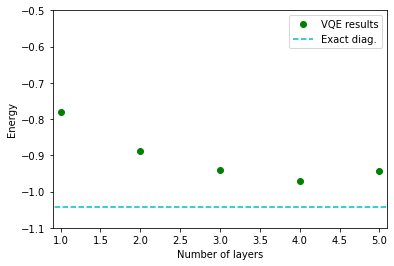

In [36]:
plt.plot(np.array([1,2,3,4,5]),Energy,'o', color = "green",label="VQE results")
plt.plot(np.array([0,1,2,3,4,5,6]),eigenvalues[0]*np.ones(7), ls = "--", color ="c", label = "Exact diag.")
plt.xlabel("Number of layers")
plt.ylabel("Energy")
plt.ylim(-1.1,-0.5)
plt.xlim(0.9,5.1)
plt.legend()

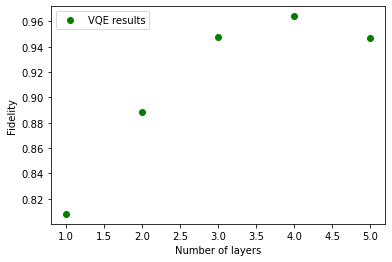

In [37]:
plt.plot(np.array([1,2,3,4,5]),Fidelity,'o', color = "green",label="VQE results")
plt.xlabel("Number of layers")
plt.ylabel("Fidelity")
plt.legend()

In [207]:

def sigma_sigma(m,n,theta):
    sigma_sigma = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    temp1 = np.cos(theta/2)
    temp2 = -1j*np.sin(theta/2)
    for i in range(basis.Ns):
        sigma_sigma[i,i] = 1.
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "2","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "1")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","2"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2


        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2") & ((basis.int_to_state(basis.Ns-i-1)[2*n+1] == "2")):
            string = list(basis.int_to_state(basis.Ns-i-1))
            string[2*m+1],string[2*n+1] = "1","1"
            string = "".join(string)
            string = string.replace(" ", "")
            string = string.replace("|","")
            string = string.replace(">", "")
            sigma_sigma[i,i] = temp1
            sigma_sigma[basis.Ns-1-basis.state_to_int(string),i]  = temp2

            
    return sigma_sigma

def id_id(m,theta):
    id_id = sparse.lil_matrix((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        id_id[i,i] = 1.
        
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "1"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4))
            
        if (basis.int_to_state(basis.Ns-i-1)[2*m+1] == "2"):
            id_id[i,i] = (np.cos(theta/4)-1j*np.sin(theta/4)) 
            
    return id_id


def ms_global_sparse(theta):
    ms_global = sparse.identity(basis.Ns)
    for m in range(L):
        ms_global = id_id(m,theta)@ms_global
        for n in range(m+1,L):
            ms_global = sigma_sigma(m,n,theta)@ms_global
    return ms_global

#print(np.allclose(ms_global_sparse(np.pi/4).toarray(),ms_gate_global(np.pi/4), atol= 1e-3,rtol=1e-3))
#print(np.allclose(ms_global_sparse(np.pi/3).toarray().conj().T@ms_global_sparse(np.pi/3).toarray(),np.identity(basis.Ns), atol= 1e-8,rtol=1e-8))

%time sigma_sigma(0,1,np.pi/3)

CPU times: user 103 ms, sys: 62 µs, total: 103 ms
Wall time: 25.7 ms


<243x243 sparse matrix of type '<class 'numpy.complex128'>'
	with 351 stored elements in List of Lists format>